## Assignment 2

In this task we implement a simple single hidden layer neural networks with logistic regression classifier on CIFAR10 dataset. 
Our implementation consists of 2 main class:

* LogisticRegression 

    Contains implementation of logistic regression classifier with 1 hidden layer on top of pytorch nn Module.


* ModelEvaluator 

    Class consisting of basic functionalities for training, testing and visualizing loss.

For extra task we implement another class named: CrossValidation. THis class supports functionality of tuning hyperparameters with grid search and k-fold cross validation.  

In [1]:
#importing basic stuff
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils import shuffle as skshuffle
import numpy as np
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

Implement logistic regression classifier using pytorch.

In [2]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(LogisticRegression, self).__init__()
        '''
        n_in: Number of Inputs
        n_hidden: Number of Hidden Units
        n_out: Number of Output Units
        '''
        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = n_hidden
        self.fc1 = nn.Linear(self.n_in, self.n_hidden)
        self.fc2 = nn.Linear(self.n_hidden, self.n_out)
        self.nonlin = nn.ReLU()
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, X):
        '''
        forward pass
        '''
        return self.fc2(self.nonlin(self.fc1(X)))



Basic functionalities for evaluating model is implemented as a part of ModelEvaluator class.

In [3]:
class ModelEvaluator:
    def __init__(self, model, epochs, lr, use_gpu=False, optim='adam'):
        '''
        model: instance of pytorch model class
        epochs: number of training epochs
        lr: learning rate
        use_gpu: to use gpu
        optim: optimizer used for training, SGD or adam
        '''
        self.epochs = epochs
        self.lr = lr
        self.model = model
        self.use_gpu = use_gpu
        self.epoch_loss = []
        if self.use_gpu:
            self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

            if self.device == 'cuda:0':
                if torch.cuda.device_count()>1:
                    self.model = nn.DataParallel(model)
                self.model.to(device)
        if optim=='adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        elif optim=='sgd':
            self.optimizer = optim.SGD(self.model.parameters(), lr = lr, momentum=0.9)
        else:
            ValueError('Optimizer Not Supported')


    def train(self, trainloader, testloader, validation=False):
        '''
        method for training
        '''
        iter_ = 0
        for epoch in range(self.epochs):
            print('Epoch-{}'.format(epoch+1))
            print('-----------------')
            loss_batch = []
            for train_data, train_labels in trainloader:
                if self.use_gpu and self.device == 'cuda:0':
                    train_data, train_labels = train_data.to(self.device), train_labels.to(self.device)
                train_data = train_data.reshape(-1, 32*32*3)
                train_data = train_data / 255
                train_preds = self.model.forward(train_data)
                loss = self.model.loss(train_preds, train_labels)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                iter_ += 1
                print('Iter-{0}, training loss{1:.2f}'.format(iter_, loss))
                if validation:
                    if iter_%500 == 0:
                        acc_test = self.test(testloader)
                        print('Accuracy on Test Set {:.2f}'.format(acc_test))
                loss_batch.append(loss)
            self.epoch_loss.append(np.sum(loss_batch))    

    def test(self, testloader):
        '''
        method for testing
        '''
        correct_ = 0
        total_ = 0
        with torch.no_grad():
            for test_data, test_labels in testloader:
                if self.use_gpu and self.device == 'cuda:0':
                    test_data, test_labels = test_data.to(self.device), test_labels.to(self.device)
                test_data = test_data.reshape(-1, 32*32*3)
                test_data = test_data / 255
                test_preds = self.model.forward(test_data)
                _, test_pred_labels = torch.max(test_preds.data, 1)
                total_ += test_labels.size(0)
                correct_ += (test_pred_labels.cpu() == test_labels.cpu()).sum()
                accuracy_test = (100*correct_/total_)
            return accuracy_test

    def plot_loss(self):
        '''
        to visualize loss
        '''
        plt.plot(range(len(self.epoch_loss)), self.epoch_loss)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.show()

# Load and Prepare Dataset

In [4]:
trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [11]:
# Parameters
n_in = np.prod(trainset[0][0].numpy().shape)
n_out = len(classes)
batch_size = 100
epochs = 30

In [6]:
# Hyperparameters
lr = 0.001
n_hidden = 512

In [7]:
# Data Loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [9]:
# Model
model = LogisticRegression(n_in, n_hidden, n_out)
modeleval = ModelEvaluator(model, epochs, lr, use_gpu=True)
modeleval.train(trainloader, testloader)

Epoch-1
-----------------
Iter-1, training loss2.30
Iter-2, training loss2.30
Iter-3, training loss2.31
Iter-4, training loss2.30
Iter-5, training loss2.30
Iter-6, training loss2.30
Iter-7, training loss2.30
Iter-8, training loss2.30
Iter-9, training loss2.30
Iter-10, training loss2.30
Iter-11, training loss2.30
Iter-12, training loss2.30
Iter-13, training loss2.30
Iter-14, training loss2.29
Iter-15, training loss2.30
Iter-16, training loss2.30
Iter-17, training loss2.30
Iter-18, training loss2.29
Iter-19, training loss2.31
Iter-20, training loss2.29
Iter-21, training loss2.29
Iter-22, training loss2.30
Iter-23, training loss2.30
Iter-24, training loss2.30
Iter-25, training loss2.30
Iter-26, training loss2.30
Iter-27, training loss2.29
Iter-28, training loss2.29
Iter-29, training loss2.28
Iter-30, training loss2.29
Iter-31, training loss2.29
Iter-32, training loss2.30
Iter-33, training loss2.30
Iter-34, training loss2.29
Iter-35, training loss2.28
Iter-36, training loss2.29
Iter-37, tr

Iter-298, training loss2.02
Iter-299, training loss2.06
Iter-300, training loss2.03
Iter-301, training loss2.11
Iter-302, training loss2.03
Iter-303, training loss2.03
Iter-304, training loss1.94
Iter-305, training loss2.06
Iter-306, training loss2.01
Iter-307, training loss1.91
Iter-308, training loss2.00
Iter-309, training loss1.95
Iter-310, training loss1.95
Iter-311, training loss1.94
Iter-312, training loss1.91
Iter-313, training loss2.01
Iter-314, training loss1.89
Iter-315, training loss2.03
Iter-316, training loss1.93
Iter-317, training loss1.89
Iter-318, training loss2.00
Iter-319, training loss2.04
Iter-320, training loss2.03
Iter-321, training loss1.96
Iter-322, training loss2.04
Iter-323, training loss1.94
Iter-324, training loss2.01
Iter-325, training loss1.98
Iter-326, training loss1.87
Iter-327, training loss1.95
Iter-328, training loss2.08
Iter-329, training loss1.98
Iter-330, training loss1.90
Iter-331, training loss1.97
Iter-332, training loss1.90
Iter-333, training l

Iter-591, training loss1.81
Iter-592, training loss1.98
Iter-593, training loss1.88
Iter-594, training loss1.84
Iter-595, training loss2.01
Iter-596, training loss1.89
Iter-597, training loss1.98
Iter-598, training loss1.95
Iter-599, training loss2.07
Iter-600, training loss1.84
Iter-601, training loss1.96
Iter-602, training loss1.93
Iter-603, training loss1.92
Iter-604, training loss2.01
Iter-605, training loss1.87
Iter-606, training loss1.86
Iter-607, training loss1.92
Iter-608, training loss1.91
Iter-609, training loss1.95
Iter-610, training loss1.93
Iter-611, training loss1.94
Iter-612, training loss1.88
Iter-613, training loss1.91
Iter-614, training loss1.92
Iter-615, training loss1.96
Iter-616, training loss1.82
Iter-617, training loss1.97
Iter-618, training loss1.88
Iter-619, training loss2.01
Iter-620, training loss1.85
Iter-621, training loss1.82
Iter-622, training loss1.93
Iter-623, training loss1.93
Iter-624, training loss1.93
Iter-625, training loss1.92
Iter-626, training l

Iter-886, training loss1.87
Iter-887, training loss2.03
Iter-888, training loss1.84
Iter-889, training loss1.85
Iter-890, training loss1.84
Iter-891, training loss1.75
Iter-892, training loss1.76
Iter-893, training loss1.81
Iter-894, training loss1.81
Iter-895, training loss1.87
Iter-896, training loss1.92
Iter-897, training loss1.78
Iter-898, training loss1.80
Iter-899, training loss1.89
Iter-900, training loss1.86
Iter-901, training loss1.82
Iter-902, training loss1.96
Iter-903, training loss1.76
Iter-904, training loss1.86
Iter-905, training loss1.86
Iter-906, training loss1.87
Iter-907, training loss1.79
Iter-908, training loss1.75
Iter-909, training loss2.07
Iter-910, training loss1.88
Iter-911, training loss1.88
Iter-912, training loss1.96
Iter-913, training loss1.81
Iter-914, training loss1.85
Iter-915, training loss1.99
Iter-916, training loss1.84
Iter-917, training loss1.86
Iter-918, training loss1.83
Iter-919, training loss1.89
Iter-920, training loss1.97
Iter-921, training l

Iter-1172, training loss1.86
Iter-1173, training loss1.94
Iter-1174, training loss1.97
Iter-1175, training loss1.88
Iter-1176, training loss1.89
Iter-1177, training loss1.96
Iter-1178, training loss1.64
Iter-1179, training loss1.89
Iter-1180, training loss1.82
Iter-1181, training loss1.97
Iter-1182, training loss1.84
Iter-1183, training loss1.76
Iter-1184, training loss1.88
Iter-1185, training loss1.74
Iter-1186, training loss1.94
Iter-1187, training loss1.97
Iter-1188, training loss1.83
Iter-1189, training loss1.89
Iter-1190, training loss1.94
Iter-1191, training loss1.94
Iter-1192, training loss1.84
Iter-1193, training loss1.83
Iter-1194, training loss1.88
Iter-1195, training loss1.87
Iter-1196, training loss1.91
Iter-1197, training loss1.99
Iter-1198, training loss1.97
Iter-1199, training loss1.93
Iter-1200, training loss1.86
Iter-1201, training loss1.91
Iter-1202, training loss1.49
Iter-1203, training loss1.93
Iter-1204, training loss1.82
Iter-1205, training loss1.92
Iter-1206, tra

Iter-1455, training loss1.79
Iter-1456, training loss1.93
Iter-1457, training loss1.70
Iter-1458, training loss1.87
Iter-1459, training loss1.79
Iter-1460, training loss1.80
Iter-1461, training loss1.85
Iter-1462, training loss1.84
Iter-1463, training loss1.65
Iter-1464, training loss1.79
Iter-1465, training loss1.91
Iter-1466, training loss1.85
Iter-1467, training loss1.83
Iter-1468, training loss1.90
Iter-1469, training loss1.85
Iter-1470, training loss1.77
Iter-1471, training loss1.94
Iter-1472, training loss1.74
Iter-1473, training loss1.82
Iter-1474, training loss1.85
Iter-1475, training loss1.89
Iter-1476, training loss1.76
Iter-1477, training loss1.76
Iter-1478, training loss1.71
Iter-1479, training loss1.80
Iter-1480, training loss1.83
Iter-1481, training loss1.75
Iter-1482, training loss1.71
Iter-1483, training loss1.98
Iter-1484, training loss1.89
Iter-1485, training loss1.77
Iter-1486, training loss1.88
Iter-1487, training loss1.76
Iter-1488, training loss1.77
Iter-1489, tra

Iter-1737, training loss1.75
Iter-1738, training loss1.84
Iter-1739, training loss1.60
Iter-1740, training loss1.67
Iter-1741, training loss1.80
Iter-1742, training loss1.67
Iter-1743, training loss1.70
Iter-1744, training loss1.96
Iter-1745, training loss1.84
Iter-1746, training loss1.70
Iter-1747, training loss1.93
Iter-1748, training loss1.73
Iter-1749, training loss1.87
Iter-1750, training loss1.76
Iter-1751, training loss1.75
Iter-1752, training loss1.84
Iter-1753, training loss1.90
Iter-1754, training loss1.74
Iter-1755, training loss1.99
Iter-1756, training loss1.88
Iter-1757, training loss1.75
Iter-1758, training loss1.71
Iter-1759, training loss1.85
Iter-1760, training loss1.89
Iter-1761, training loss1.74
Iter-1762, training loss1.68
Iter-1763, training loss1.75
Iter-1764, training loss1.78
Iter-1765, training loss1.83
Iter-1766, training loss1.89
Iter-1767, training loss1.69
Iter-1768, training loss1.89
Iter-1769, training loss1.89
Iter-1770, training loss1.76
Iter-1771, tra

Iter-2021, training loss1.72
Iter-2022, training loss1.75
Iter-2023, training loss1.80
Iter-2024, training loss1.68
Iter-2025, training loss1.64
Iter-2026, training loss2.00
Iter-2027, training loss1.92
Iter-2028, training loss1.85
Iter-2029, training loss1.82
Iter-2030, training loss1.86
Iter-2031, training loss1.91
Iter-2032, training loss1.53
Iter-2033, training loss1.86
Iter-2034, training loss1.82
Iter-2035, training loss1.83
Iter-2036, training loss1.78
Iter-2037, training loss1.78
Iter-2038, training loss1.91
Iter-2039, training loss1.82
Iter-2040, training loss1.82
Iter-2041, training loss1.75
Iter-2042, training loss1.74
Iter-2043, training loss1.59
Iter-2044, training loss1.72
Iter-2045, training loss1.84
Iter-2046, training loss1.87
Iter-2047, training loss1.67
Iter-2048, training loss2.03
Iter-2049, training loss1.92
Iter-2050, training loss1.71
Iter-2051, training loss1.93
Iter-2052, training loss1.81
Iter-2053, training loss1.79
Iter-2054, training loss1.77
Iter-2055, tra

Iter-2305, training loss1.80
Iter-2306, training loss1.78
Iter-2307, training loss1.90
Iter-2308, training loss1.74
Iter-2309, training loss1.66
Iter-2310, training loss1.69
Iter-2311, training loss1.72
Iter-2312, training loss1.75
Iter-2313, training loss1.62
Iter-2314, training loss1.70
Iter-2315, training loss1.87
Iter-2316, training loss1.75
Iter-2317, training loss1.73
Iter-2318, training loss1.82
Iter-2319, training loss1.62
Iter-2320, training loss1.73
Iter-2321, training loss1.75
Iter-2322, training loss1.82
Iter-2323, training loss1.92
Iter-2324, training loss1.58
Iter-2325, training loss1.80
Iter-2326, training loss1.79
Iter-2327, training loss1.74
Iter-2328, training loss1.77
Iter-2329, training loss1.80
Iter-2330, training loss1.69
Iter-2331, training loss1.90
Iter-2332, training loss1.73
Iter-2333, training loss1.49
Iter-2334, training loss1.84
Iter-2335, training loss1.79
Iter-2336, training loss1.74
Iter-2337, training loss1.72
Iter-2338, training loss1.84
Iter-2339, tra

Iter-2591, training loss1.63
Iter-2592, training loss1.72
Iter-2593, training loss1.71
Iter-2594, training loss1.78
Iter-2595, training loss1.71
Iter-2596, training loss1.63
Iter-2597, training loss1.75
Iter-2598, training loss1.82
Iter-2599, training loss1.86
Iter-2600, training loss1.69
Iter-2601, training loss1.65
Iter-2602, training loss1.78
Iter-2603, training loss1.71
Iter-2604, training loss1.68
Iter-2605, training loss1.75
Iter-2606, training loss1.70
Iter-2607, training loss1.86
Iter-2608, training loss1.69
Iter-2609, training loss1.63
Iter-2610, training loss1.79
Iter-2611, training loss1.76
Iter-2612, training loss1.79
Iter-2613, training loss1.81
Iter-2614, training loss1.70
Iter-2615, training loss1.74
Iter-2616, training loss1.75
Iter-2617, training loss1.71
Iter-2618, training loss1.64
Iter-2619, training loss1.77
Iter-2620, training loss1.65
Iter-2621, training loss1.72
Iter-2622, training loss1.79
Iter-2623, training loss1.74
Iter-2624, training loss1.73
Iter-2625, tra

Iter-2876, training loss1.85
Iter-2877, training loss1.71
Iter-2878, training loss1.95
Iter-2879, training loss1.65
Iter-2880, training loss1.86
Iter-2881, training loss1.62
Iter-2882, training loss1.65
Iter-2883, training loss1.73
Iter-2884, training loss1.86
Iter-2885, training loss1.66
Iter-2886, training loss1.91
Iter-2887, training loss1.86
Iter-2888, training loss1.65
Iter-2889, training loss1.75
Iter-2890, training loss1.67
Iter-2891, training loss1.73
Iter-2892, training loss1.80
Iter-2893, training loss1.66
Iter-2894, training loss1.58
Iter-2895, training loss1.64
Iter-2896, training loss1.85
Iter-2897, training loss1.81
Iter-2898, training loss1.59
Iter-2899, training loss1.74
Iter-2900, training loss1.83
Iter-2901, training loss1.74
Iter-2902, training loss1.81
Iter-2903, training loss1.72
Iter-2904, training loss1.63
Iter-2905, training loss1.62
Iter-2906, training loss1.71
Iter-2907, training loss1.76
Iter-2908, training loss1.61
Iter-2909, training loss1.82
Iter-2910, tra

Iter-3163, training loss1.90
Iter-3164, training loss1.74
Iter-3165, training loss1.69
Iter-3166, training loss1.78
Iter-3167, training loss1.68
Iter-3168, training loss1.81
Iter-3169, training loss1.70
Iter-3170, training loss1.82
Iter-3171, training loss1.66
Iter-3172, training loss1.70
Iter-3173, training loss1.65
Iter-3174, training loss1.63
Iter-3175, training loss1.78
Iter-3176, training loss1.69
Iter-3177, training loss1.82
Iter-3178, training loss1.74
Iter-3179, training loss1.66
Iter-3180, training loss1.59
Iter-3181, training loss1.76
Iter-3182, training loss1.79
Iter-3183, training loss1.63
Iter-3184, training loss1.81
Iter-3185, training loss1.66
Iter-3186, training loss1.70
Iter-3187, training loss1.60
Iter-3188, training loss1.77
Iter-3189, training loss1.66
Iter-3190, training loss1.70
Iter-3191, training loss1.59
Iter-3192, training loss1.55
Iter-3193, training loss1.57
Iter-3194, training loss1.61
Iter-3195, training loss1.62
Iter-3196, training loss1.62
Iter-3197, tra

Iter-3447, training loss1.73
Iter-3448, training loss1.83
Iter-3449, training loss1.67
Iter-3450, training loss1.42
Iter-3451, training loss1.76
Iter-3452, training loss1.89
Iter-3453, training loss1.66
Iter-3454, training loss1.74
Iter-3455, training loss1.84
Iter-3456, training loss1.55
Iter-3457, training loss1.69
Iter-3458, training loss1.65
Iter-3459, training loss1.67
Iter-3460, training loss1.57
Iter-3461, training loss1.65
Iter-3462, training loss1.58
Iter-3463, training loss1.79
Iter-3464, training loss1.69
Iter-3465, training loss1.69
Iter-3466, training loss1.91
Iter-3467, training loss1.69
Iter-3468, training loss1.71
Iter-3469, training loss1.79
Iter-3470, training loss1.75
Iter-3471, training loss1.74
Iter-3472, training loss1.67
Iter-3473, training loss1.74
Iter-3474, training loss1.79
Iter-3475, training loss1.65
Iter-3476, training loss1.63
Iter-3477, training loss1.79
Iter-3478, training loss1.75
Iter-3479, training loss1.67
Iter-3480, training loss1.64
Iter-3481, tra

Iter-3734, training loss1.73
Iter-3735, training loss1.58
Iter-3736, training loss1.67
Iter-3737, training loss1.82
Iter-3738, training loss1.67
Iter-3739, training loss1.68
Iter-3740, training loss1.74
Iter-3741, training loss1.80
Iter-3742, training loss1.90
Iter-3743, training loss1.53
Iter-3744, training loss1.60
Iter-3745, training loss1.66
Iter-3746, training loss1.70
Iter-3747, training loss1.63
Iter-3748, training loss1.57
Iter-3749, training loss1.48
Iter-3750, training loss1.53
Iter-3751, training loss1.76
Iter-3752, training loss1.58
Iter-3753, training loss1.65
Iter-3754, training loss1.52
Iter-3755, training loss1.48
Iter-3756, training loss1.77
Iter-3757, training loss1.65
Iter-3758, training loss1.84
Iter-3759, training loss1.61
Iter-3760, training loss1.67
Iter-3761, training loss1.70
Iter-3762, training loss1.54
Iter-3763, training loss1.59
Iter-3764, training loss1.81
Iter-3765, training loss1.59
Iter-3766, training loss1.78
Iter-3767, training loss1.74
Iter-3768, tra

Iter-4018, training loss1.58
Iter-4019, training loss1.61
Iter-4020, training loss1.58
Iter-4021, training loss1.60
Iter-4022, training loss1.75
Iter-4023, training loss1.71
Iter-4024, training loss1.69
Iter-4025, training loss1.69
Iter-4026, training loss1.64
Iter-4027, training loss1.62
Iter-4028, training loss1.69
Iter-4029, training loss1.60
Iter-4030, training loss1.53
Iter-4031, training loss1.57
Iter-4032, training loss1.73
Iter-4033, training loss1.62
Iter-4034, training loss1.50
Iter-4035, training loss1.67
Iter-4036, training loss1.55
Iter-4037, training loss1.66
Iter-4038, training loss1.58
Iter-4039, training loss1.72
Iter-4040, training loss1.72
Iter-4041, training loss1.74
Iter-4042, training loss1.56
Iter-4043, training loss1.58
Iter-4044, training loss1.72
Iter-4045, training loss1.64
Iter-4046, training loss1.63
Iter-4047, training loss1.77
Iter-4048, training loss1.70
Iter-4049, training loss1.71
Iter-4050, training loss1.66
Iter-4051, training loss1.52
Iter-4052, tra

Iter-4304, training loss1.54
Iter-4305, training loss1.59
Iter-4306, training loss1.75
Iter-4307, training loss1.67
Iter-4308, training loss1.53
Iter-4309, training loss1.66
Iter-4310, training loss1.63
Iter-4311, training loss1.65
Iter-4312, training loss1.72
Iter-4313, training loss1.62
Iter-4314, training loss1.61
Iter-4315, training loss1.68
Iter-4316, training loss1.60
Iter-4317, training loss1.69
Iter-4318, training loss1.64
Iter-4319, training loss1.53
Iter-4320, training loss1.59
Iter-4321, training loss1.61
Iter-4322, training loss1.74
Iter-4323, training loss1.69
Iter-4324, training loss1.64
Iter-4325, training loss1.85
Iter-4326, training loss1.53
Iter-4327, training loss1.64
Iter-4328, training loss1.78
Iter-4329, training loss1.69
Iter-4330, training loss1.54
Iter-4331, training loss1.86
Iter-4332, training loss1.75
Iter-4333, training loss1.70
Iter-4334, training loss1.66
Iter-4335, training loss1.63
Iter-4336, training loss1.77
Iter-4337, training loss1.58
Iter-4338, tra

Iter-4589, training loss1.63
Iter-4590, training loss1.60
Iter-4591, training loss1.65
Iter-4592, training loss1.59
Iter-4593, training loss1.59
Iter-4594, training loss1.67
Iter-4595, training loss1.66
Iter-4596, training loss1.61
Iter-4597, training loss1.56
Iter-4598, training loss1.75
Iter-4599, training loss1.74
Iter-4600, training loss1.45
Iter-4601, training loss1.59
Iter-4602, training loss1.54
Iter-4603, training loss1.72
Iter-4604, training loss1.73
Iter-4605, training loss1.69
Iter-4606, training loss1.75
Iter-4607, training loss1.57
Iter-4608, training loss1.82
Iter-4609, training loss1.71
Iter-4610, training loss1.72
Iter-4611, training loss1.64
Iter-4612, training loss1.51
Iter-4613, training loss1.53
Iter-4614, training loss1.78
Iter-4615, training loss1.75
Iter-4616, training loss1.51
Iter-4617, training loss1.61
Iter-4618, training loss1.80
Iter-4619, training loss1.70
Iter-4620, training loss1.59
Iter-4621, training loss1.53
Iter-4622, training loss1.54
Iter-4623, tra

Iter-4873, training loss1.50
Iter-4874, training loss1.61
Iter-4875, training loss1.50
Iter-4876, training loss1.39
Iter-4877, training loss1.80
Iter-4878, training loss1.62
Iter-4879, training loss1.54
Iter-4880, training loss1.69
Iter-4881, training loss1.63
Iter-4882, training loss1.56
Iter-4883, training loss1.66
Iter-4884, training loss1.72
Iter-4885, training loss1.75
Iter-4886, training loss1.54
Iter-4887, training loss1.64
Iter-4888, training loss1.48
Iter-4889, training loss1.60
Iter-4890, training loss1.62
Iter-4891, training loss1.47
Iter-4892, training loss1.50
Iter-4893, training loss1.55
Iter-4894, training loss1.61
Iter-4895, training loss1.69
Iter-4896, training loss1.73
Iter-4897, training loss1.54
Iter-4898, training loss1.59
Iter-4899, training loss1.61
Iter-4900, training loss1.44
Iter-4901, training loss1.54
Iter-4902, training loss1.53
Iter-4903, training loss1.65
Iter-4904, training loss1.61
Iter-4905, training loss1.56
Iter-4906, training loss1.54
Iter-4907, tra

Iter-5158, training loss1.57
Iter-5159, training loss1.68
Iter-5160, training loss1.51
Iter-5161, training loss1.68
Iter-5162, training loss1.69
Iter-5163, training loss1.54
Iter-5164, training loss1.44
Iter-5165, training loss1.55
Iter-5166, training loss1.60
Iter-5167, training loss1.57
Iter-5168, training loss1.48
Iter-5169, training loss1.73
Iter-5170, training loss1.74
Iter-5171, training loss1.71
Iter-5172, training loss1.47
Iter-5173, training loss1.71
Iter-5174, training loss1.58
Iter-5175, training loss1.57
Iter-5176, training loss1.72
Iter-5177, training loss1.57
Iter-5178, training loss1.57
Iter-5179, training loss1.67
Iter-5180, training loss1.68
Iter-5181, training loss1.60
Iter-5182, training loss1.64
Iter-5183, training loss1.53
Iter-5184, training loss1.43
Iter-5185, training loss1.72
Iter-5186, training loss1.64
Iter-5187, training loss1.69
Iter-5188, training loss1.55
Iter-5189, training loss1.85
Iter-5190, training loss1.62
Iter-5191, training loss1.72
Iter-5192, tra

Iter-5442, training loss1.77
Iter-5443, training loss1.69
Iter-5444, training loss1.48
Iter-5445, training loss1.63
Iter-5446, training loss1.62
Iter-5447, training loss1.65
Iter-5448, training loss1.50
Iter-5449, training loss1.58
Iter-5450, training loss1.58
Iter-5451, training loss1.64
Iter-5452, training loss1.60
Iter-5453, training loss1.35
Iter-5454, training loss1.71
Iter-5455, training loss1.62
Iter-5456, training loss1.52
Iter-5457, training loss1.67
Iter-5458, training loss1.64
Iter-5459, training loss1.72
Iter-5460, training loss1.44
Iter-5461, training loss1.75
Iter-5462, training loss1.67
Iter-5463, training loss1.50
Iter-5464, training loss1.51
Iter-5465, training loss1.61
Iter-5466, training loss1.67
Iter-5467, training loss1.60
Iter-5468, training loss1.68
Iter-5469, training loss1.55
Iter-5470, training loss1.66
Iter-5471, training loss1.60
Iter-5472, training loss1.51
Iter-5473, training loss1.69
Iter-5474, training loss1.48
Iter-5475, training loss1.83
Iter-5476, tra

Iter-5727, training loss1.48
Iter-5728, training loss1.58
Iter-5729, training loss1.49
Iter-5730, training loss1.55
Iter-5731, training loss1.63
Iter-5732, training loss1.61
Iter-5733, training loss1.60
Iter-5734, training loss1.46
Iter-5735, training loss1.53
Iter-5736, training loss1.55
Iter-5737, training loss1.77
Iter-5738, training loss1.62
Iter-5739, training loss1.63
Iter-5740, training loss1.54
Iter-5741, training loss1.61
Iter-5742, training loss1.58
Iter-5743, training loss1.65
Iter-5744, training loss1.67
Iter-5745, training loss1.62
Iter-5746, training loss1.67
Iter-5747, training loss1.53
Iter-5748, training loss1.54
Iter-5749, training loss1.48
Iter-5750, training loss1.63
Iter-5751, training loss1.60
Iter-5752, training loss1.70
Iter-5753, training loss1.57
Iter-5754, training loss1.68
Iter-5755, training loss1.57
Iter-5756, training loss1.69
Iter-5757, training loss1.50
Iter-5758, training loss1.55
Iter-5759, training loss1.54
Iter-5760, training loss1.50
Iter-5761, tra

Iter-6009, training loss1.56
Iter-6010, training loss1.59
Iter-6011, training loss1.55
Iter-6012, training loss1.47
Iter-6013, training loss1.55
Iter-6014, training loss1.55
Iter-6015, training loss1.58
Iter-6016, training loss1.58
Iter-6017, training loss1.55
Iter-6018, training loss1.57
Iter-6019, training loss1.50
Iter-6020, training loss1.61
Iter-6021, training loss1.69
Iter-6022, training loss1.57
Iter-6023, training loss1.66
Iter-6024, training loss1.54
Iter-6025, training loss1.41
Iter-6026, training loss1.72
Iter-6027, training loss1.67
Iter-6028, training loss1.62
Iter-6029, training loss1.49
Iter-6030, training loss1.60
Iter-6031, training loss1.45
Iter-6032, training loss1.41
Iter-6033, training loss1.51
Iter-6034, training loss1.62
Iter-6035, training loss1.62
Iter-6036, training loss1.62
Iter-6037, training loss1.43
Iter-6038, training loss1.73
Iter-6039, training loss1.37
Iter-6040, training loss1.62
Iter-6041, training loss1.44
Iter-6042, training loss1.61
Iter-6043, tra

Iter-6293, training loss1.67
Iter-6294, training loss1.59
Iter-6295, training loss1.55
Iter-6296, training loss1.57
Iter-6297, training loss1.73
Iter-6298, training loss1.85
Iter-6299, training loss1.46
Iter-6300, training loss1.47
Iter-6301, training loss1.60
Iter-6302, training loss1.57
Iter-6303, training loss1.52
Iter-6304, training loss1.47
Iter-6305, training loss1.55
Iter-6306, training loss1.44
Iter-6307, training loss1.61
Iter-6308, training loss1.43
Iter-6309, training loss1.60
Iter-6310, training loss1.65
Iter-6311, training loss1.53
Iter-6312, training loss1.53
Iter-6313, training loss1.57
Iter-6314, training loss1.74
Iter-6315, training loss1.63
Iter-6316, training loss1.61
Iter-6317, training loss1.39
Iter-6318, training loss1.51
Iter-6319, training loss1.52
Iter-6320, training loss1.50
Iter-6321, training loss1.57
Iter-6322, training loss1.73
Iter-6323, training loss1.62
Iter-6324, training loss1.61
Iter-6325, training loss1.66
Iter-6326, training loss1.57
Iter-6327, tra

Iter-6575, training loss1.49
Iter-6576, training loss1.63
Iter-6577, training loss1.61
Iter-6578, training loss1.54
Iter-6579, training loss1.66
Iter-6580, training loss1.51
Iter-6581, training loss1.65
Iter-6582, training loss1.49
Iter-6583, training loss1.66
Iter-6584, training loss1.57
Iter-6585, training loss1.65
Iter-6586, training loss1.49
Iter-6587, training loss1.66
Iter-6588, training loss1.66
Iter-6589, training loss1.60
Iter-6590, training loss1.55
Iter-6591, training loss1.65
Iter-6592, training loss1.61
Iter-6593, training loss1.64
Iter-6594, training loss1.76
Iter-6595, training loss1.52
Iter-6596, training loss1.54
Iter-6597, training loss1.58
Iter-6598, training loss1.59
Iter-6599, training loss1.42
Iter-6600, training loss1.61
Iter-6601, training loss1.62
Iter-6602, training loss1.75
Iter-6603, training loss1.59
Iter-6604, training loss1.36
Iter-6605, training loss1.65
Iter-6606, training loss1.61
Iter-6607, training loss1.65
Iter-6608, training loss1.47
Iter-6609, tra

Iter-6859, training loss1.47
Iter-6860, training loss1.68
Iter-6861, training loss1.59
Iter-6862, training loss1.61
Iter-6863, training loss1.60
Iter-6864, training loss1.42
Iter-6865, training loss1.60
Iter-6866, training loss1.38
Iter-6867, training loss1.53
Iter-6868, training loss1.55
Iter-6869, training loss1.46
Iter-6870, training loss1.61
Iter-6871, training loss1.46
Iter-6872, training loss1.56
Iter-6873, training loss1.64
Iter-6874, training loss1.74
Iter-6875, training loss1.61
Iter-6876, training loss1.57
Iter-6877, training loss1.44
Iter-6878, training loss1.47
Iter-6879, training loss1.49
Iter-6880, training loss1.39
Iter-6881, training loss1.69
Iter-6882, training loss1.60
Iter-6883, training loss1.62
Iter-6884, training loss1.53
Iter-6885, training loss1.52
Iter-6886, training loss1.65
Iter-6887, training loss1.59
Iter-6888, training loss1.56
Iter-6889, training loss1.47
Iter-6890, training loss1.57
Iter-6891, training loss1.57
Iter-6892, training loss1.61
Iter-6893, tra

Iter-7142, training loss1.59
Iter-7143, training loss1.62
Iter-7144, training loss1.48
Iter-7145, training loss1.48
Iter-7146, training loss1.50
Iter-7147, training loss1.39
Iter-7148, training loss1.62
Iter-7149, training loss1.66
Iter-7150, training loss1.53
Iter-7151, training loss1.55
Iter-7152, training loss1.44
Iter-7153, training loss1.49
Iter-7154, training loss1.68
Iter-7155, training loss1.52
Iter-7156, training loss1.59
Iter-7157, training loss1.43
Iter-7158, training loss1.55
Iter-7159, training loss1.49
Iter-7160, training loss1.50
Iter-7161, training loss1.66
Iter-7162, training loss1.40
Iter-7163, training loss1.54
Iter-7164, training loss1.43
Iter-7165, training loss1.88
Iter-7166, training loss1.61
Iter-7167, training loss1.58
Iter-7168, training loss1.56
Iter-7169, training loss1.65
Iter-7170, training loss1.66
Iter-7171, training loss1.45
Iter-7172, training loss1.74
Iter-7173, training loss1.64
Iter-7174, training loss1.50
Iter-7175, training loss1.42
Iter-7176, tra

Iter-7425, training loss1.94
Iter-7426, training loss1.56
Iter-7427, training loss1.34
Iter-7428, training loss1.64
Iter-7429, training loss1.36
Iter-7430, training loss1.56
Iter-7431, training loss1.58
Iter-7432, training loss1.69
Iter-7433, training loss1.54
Iter-7434, training loss1.73
Iter-7435, training loss1.75
Iter-7436, training loss1.61
Iter-7437, training loss1.49
Iter-7438, training loss1.70
Iter-7439, training loss1.66
Iter-7440, training loss1.53
Iter-7441, training loss1.54
Iter-7442, training loss1.64
Iter-7443, training loss1.40
Iter-7444, training loss1.50
Iter-7445, training loss1.40
Iter-7446, training loss1.64
Iter-7447, training loss1.42
Iter-7448, training loss1.50
Iter-7449, training loss1.47
Iter-7450, training loss1.80
Iter-7451, training loss1.55
Iter-7452, training loss1.50
Iter-7453, training loss1.54
Iter-7454, training loss1.43
Iter-7455, training loss1.46
Iter-7456, training loss1.54
Iter-7457, training loss1.69
Iter-7458, training loss1.56
Iter-7459, tra

Iter-7707, training loss1.55
Iter-7708, training loss1.70
Iter-7709, training loss1.64
Iter-7710, training loss1.42
Iter-7711, training loss1.47
Iter-7712, training loss1.60
Iter-7713, training loss1.59
Iter-7714, training loss1.41
Iter-7715, training loss1.42
Iter-7716, training loss1.52
Iter-7717, training loss1.58
Iter-7718, training loss1.64
Iter-7719, training loss1.62
Iter-7720, training loss1.52
Iter-7721, training loss1.49
Iter-7722, training loss1.51
Iter-7723, training loss1.62
Iter-7724, training loss1.46
Iter-7725, training loss1.53
Iter-7726, training loss1.64
Iter-7727, training loss1.68
Iter-7728, training loss1.73
Iter-7729, training loss1.37
Iter-7730, training loss1.42
Iter-7731, training loss1.57
Iter-7732, training loss1.48
Iter-7733, training loss1.50
Iter-7734, training loss1.51
Iter-7735, training loss1.60
Iter-7736, training loss1.55
Iter-7737, training loss1.57
Iter-7738, training loss1.70
Iter-7739, training loss1.63
Iter-7740, training loss1.44
Iter-7741, tra

Iter-7990, training loss1.62
Iter-7991, training loss1.75
Iter-7992, training loss1.51
Iter-7993, training loss1.51
Iter-7994, training loss1.64
Iter-7995, training loss1.49
Iter-7996, training loss1.60
Iter-7997, training loss1.71
Iter-7998, training loss1.64
Iter-7999, training loss1.57
Iter-8000, training loss1.65
Epoch-17
-----------------
Iter-8001, training loss1.58
Iter-8002, training loss1.52
Iter-8003, training loss1.44
Iter-8004, training loss1.56
Iter-8005, training loss1.60
Iter-8006, training loss1.56
Iter-8007, training loss1.54
Iter-8008, training loss1.43
Iter-8009, training loss1.46
Iter-8010, training loss1.44
Iter-8011, training loss1.61
Iter-8012, training loss1.57
Iter-8013, training loss1.56
Iter-8014, training loss1.62
Iter-8015, training loss1.70
Iter-8016, training loss1.39
Iter-8017, training loss1.58
Iter-8018, training loss1.59
Iter-8019, training loss1.52
Iter-8020, training loss1.40
Iter-8021, training loss1.53
Iter-8022, training loss1.61
Iter-8023, train

Iter-8273, training loss1.73
Iter-8274, training loss1.58
Iter-8275, training loss1.36
Iter-8276, training loss1.42
Iter-8277, training loss1.49
Iter-8278, training loss1.55
Iter-8279, training loss1.51
Iter-8280, training loss1.87
Iter-8281, training loss1.42
Iter-8282, training loss1.52
Iter-8283, training loss1.54
Iter-8284, training loss1.39
Iter-8285, training loss1.58
Iter-8286, training loss1.64
Iter-8287, training loss1.41
Iter-8288, training loss1.69
Iter-8289, training loss1.44
Iter-8290, training loss1.41
Iter-8291, training loss1.56
Iter-8292, training loss1.37
Iter-8293, training loss1.52
Iter-8294, training loss1.53
Iter-8295, training loss1.35
Iter-8296, training loss1.45
Iter-8297, training loss1.54
Iter-8298, training loss1.48
Iter-8299, training loss1.49
Iter-8300, training loss1.58
Iter-8301, training loss1.47
Iter-8302, training loss1.60
Iter-8303, training loss1.42
Iter-8304, training loss1.40
Iter-8305, training loss1.68
Iter-8306, training loss1.37
Iter-8307, tra

Iter-8555, training loss1.61
Iter-8556, training loss1.47
Iter-8557, training loss1.50
Iter-8558, training loss1.57
Iter-8559, training loss1.55
Iter-8560, training loss1.62
Iter-8561, training loss1.60
Iter-8562, training loss1.51
Iter-8563, training loss1.56
Iter-8564, training loss1.48
Iter-8565, training loss1.50
Iter-8566, training loss1.49
Iter-8567, training loss1.52
Iter-8568, training loss1.51
Iter-8569, training loss1.46
Iter-8570, training loss1.44
Iter-8571, training loss1.61
Iter-8572, training loss1.44
Iter-8573, training loss1.64
Iter-8574, training loss1.48
Iter-8575, training loss1.62
Iter-8576, training loss1.66
Iter-8577, training loss1.46
Iter-8578, training loss1.43
Iter-8579, training loss1.34
Iter-8580, training loss1.67
Iter-8581, training loss1.46
Iter-8582, training loss1.37
Iter-8583, training loss1.57
Iter-8584, training loss1.30
Iter-8585, training loss1.54
Iter-8586, training loss1.48
Iter-8587, training loss1.61
Iter-8588, training loss1.70
Iter-8589, tra

Iter-8839, training loss1.61
Iter-8840, training loss1.44
Iter-8841, training loss1.46
Iter-8842, training loss1.48
Iter-8843, training loss1.43
Iter-8844, training loss1.39
Iter-8845, training loss1.55
Iter-8846, training loss1.63
Iter-8847, training loss1.50
Iter-8848, training loss1.37
Iter-8849, training loss1.54
Iter-8850, training loss1.51
Iter-8851, training loss1.51
Iter-8852, training loss1.43
Iter-8853, training loss1.45
Iter-8854, training loss1.59
Iter-8855, training loss1.55
Iter-8856, training loss1.47
Iter-8857, training loss1.51
Iter-8858, training loss1.41
Iter-8859, training loss1.63
Iter-8860, training loss1.37
Iter-8861, training loss1.56
Iter-8862, training loss1.54
Iter-8863, training loss1.47
Iter-8864, training loss1.57
Iter-8865, training loss1.54
Iter-8866, training loss1.56
Iter-8867, training loss1.55
Iter-8868, training loss1.31
Iter-8869, training loss1.54
Iter-8870, training loss1.43
Iter-8871, training loss1.64
Iter-8872, training loss1.54
Iter-8873, tra

Iter-9123, training loss1.45
Iter-9124, training loss1.52
Iter-9125, training loss1.36
Iter-9126, training loss1.52
Iter-9127, training loss1.47
Iter-9128, training loss1.49
Iter-9129, training loss1.35
Iter-9130, training loss1.52
Iter-9131, training loss1.44
Iter-9132, training loss1.42
Iter-9133, training loss1.55
Iter-9134, training loss1.59
Iter-9135, training loss1.44
Iter-9136, training loss1.42
Iter-9137, training loss1.56
Iter-9138, training loss1.58
Iter-9139, training loss1.61
Iter-9140, training loss1.50
Iter-9141, training loss1.36
Iter-9142, training loss1.59
Iter-9143, training loss1.60
Iter-9144, training loss1.60
Iter-9145, training loss1.62
Iter-9146, training loss1.57
Iter-9147, training loss1.67
Iter-9148, training loss1.46
Iter-9149, training loss1.58
Iter-9150, training loss1.38
Iter-9151, training loss1.47
Iter-9152, training loss1.41
Iter-9153, training loss1.47
Iter-9154, training loss1.56
Iter-9155, training loss1.41
Iter-9156, training loss1.59
Iter-9157, tra

Iter-9408, training loss1.71
Iter-9409, training loss1.54
Iter-9410, training loss1.42
Iter-9411, training loss1.37
Iter-9412, training loss1.54
Iter-9413, training loss1.28
Iter-9414, training loss1.61
Iter-9415, training loss1.43
Iter-9416, training loss1.44
Iter-9417, training loss1.39
Iter-9418, training loss1.52
Iter-9419, training loss1.57
Iter-9420, training loss1.52
Iter-9421, training loss1.67
Iter-9422, training loss1.49
Iter-9423, training loss1.43
Iter-9424, training loss1.62
Iter-9425, training loss1.42
Iter-9426, training loss1.55
Iter-9427, training loss1.47
Iter-9428, training loss1.53
Iter-9429, training loss1.41
Iter-9430, training loss1.64
Iter-9431, training loss1.47
Iter-9432, training loss1.45
Iter-9433, training loss1.47
Iter-9434, training loss1.58
Iter-9435, training loss1.36
Iter-9436, training loss1.62
Iter-9437, training loss1.45
Iter-9438, training loss1.50
Iter-9439, training loss1.54
Iter-9440, training loss1.55
Iter-9441, training loss1.45
Iter-9442, tra

Iter-9690, training loss1.43
Iter-9691, training loss1.50
Iter-9692, training loss1.46
Iter-9693, training loss1.59
Iter-9694, training loss1.47
Iter-9695, training loss1.56
Iter-9696, training loss1.49
Iter-9697, training loss1.36
Iter-9698, training loss1.59
Iter-9699, training loss1.45
Iter-9700, training loss1.47
Iter-9701, training loss1.55
Iter-9702, training loss1.72
Iter-9703, training loss1.35
Iter-9704, training loss1.61
Iter-9705, training loss1.57
Iter-9706, training loss1.30
Iter-9707, training loss1.36
Iter-9708, training loss1.64
Iter-9709, training loss1.28
Iter-9710, training loss1.31
Iter-9711, training loss1.56
Iter-9712, training loss1.55
Iter-9713, training loss1.59
Iter-9714, training loss1.42
Iter-9715, training loss1.46
Iter-9716, training loss1.56
Iter-9717, training loss1.34
Iter-9718, training loss1.49
Iter-9719, training loss1.60
Iter-9720, training loss1.53
Iter-9721, training loss1.55
Iter-9722, training loss1.54
Iter-9723, training loss1.56
Iter-9724, tra

Iter-9975, training loss1.55
Iter-9976, training loss1.45
Iter-9977, training loss1.43
Iter-9978, training loss1.57
Iter-9979, training loss1.68
Iter-9980, training loss1.45
Iter-9981, training loss1.52
Iter-9982, training loss1.54
Iter-9983, training loss1.95
Iter-9984, training loss1.47
Iter-9985, training loss1.45
Iter-9986, training loss1.38
Iter-9987, training loss1.37
Iter-9988, training loss1.52
Iter-9989, training loss1.50
Iter-9990, training loss1.62
Iter-9991, training loss1.53
Iter-9992, training loss1.44
Iter-9993, training loss1.42
Iter-9994, training loss1.52
Iter-9995, training loss1.56
Iter-9996, training loss1.41
Iter-9997, training loss1.58
Iter-9998, training loss1.38
Iter-9999, training loss1.55
Iter-10000, training loss1.58
Epoch-21
-----------------
Iter-10001, training loss1.40
Iter-10002, training loss1.45
Iter-10003, training loss1.53
Iter-10004, training loss1.43
Iter-10005, training loss1.43
Iter-10006, training loss1.54
Iter-10007, training loss1.47
Iter-100

Iter-10252, training loss1.45
Iter-10253, training loss1.58
Iter-10254, training loss1.38
Iter-10255, training loss1.33
Iter-10256, training loss1.40
Iter-10257, training loss1.37
Iter-10258, training loss1.72
Iter-10259, training loss1.50
Iter-10260, training loss1.43
Iter-10261, training loss1.48
Iter-10262, training loss1.37
Iter-10263, training loss1.56
Iter-10264, training loss1.50
Iter-10265, training loss1.46
Iter-10266, training loss1.40
Iter-10267, training loss1.56
Iter-10268, training loss1.52
Iter-10269, training loss1.61
Iter-10270, training loss1.54
Iter-10271, training loss1.32
Iter-10272, training loss1.55
Iter-10273, training loss1.62
Iter-10274, training loss1.35
Iter-10275, training loss1.44
Iter-10276, training loss1.66
Iter-10277, training loss1.55
Iter-10278, training loss1.58
Iter-10279, training loss1.64
Iter-10280, training loss1.37
Iter-10281, training loss1.61
Iter-10282, training loss1.36
Iter-10283, training loss1.52
Iter-10284, training loss1.48
Iter-10285

Iter-10526, training loss1.53
Iter-10527, training loss1.52
Iter-10528, training loss1.35
Iter-10529, training loss1.44
Iter-10530, training loss1.42
Iter-10531, training loss1.24
Iter-10532, training loss1.40
Iter-10533, training loss1.59
Iter-10534, training loss1.61
Iter-10535, training loss1.50
Iter-10536, training loss1.43
Iter-10537, training loss1.56
Iter-10538, training loss1.41
Iter-10539, training loss1.40
Iter-10540, training loss1.44
Iter-10541, training loss1.51
Iter-10542, training loss1.43
Iter-10543, training loss1.66
Iter-10544, training loss1.38
Iter-10545, training loss1.43
Iter-10546, training loss1.60
Iter-10547, training loss1.47
Iter-10548, training loss1.59
Iter-10549, training loss1.61
Iter-10550, training loss1.48
Iter-10551, training loss1.72
Iter-10552, training loss1.52
Iter-10553, training loss1.37
Iter-10554, training loss1.55
Iter-10555, training loss1.51
Iter-10556, training loss1.49
Iter-10557, training loss1.60
Iter-10558, training loss1.55
Iter-10559

Iter-10801, training loss1.59
Iter-10802, training loss1.40
Iter-10803, training loss1.73
Iter-10804, training loss1.49
Iter-10805, training loss1.57
Iter-10806, training loss1.48
Iter-10807, training loss1.53
Iter-10808, training loss1.27
Iter-10809, training loss1.47
Iter-10810, training loss1.33
Iter-10811, training loss1.35
Iter-10812, training loss1.46
Iter-10813, training loss1.52
Iter-10814, training loss1.53
Iter-10815, training loss1.29
Iter-10816, training loss1.64
Iter-10817, training loss1.44
Iter-10818, training loss1.49
Iter-10819, training loss1.50
Iter-10820, training loss1.49
Iter-10821, training loss1.53
Iter-10822, training loss1.34
Iter-10823, training loss1.53
Iter-10824, training loss1.29
Iter-10825, training loss1.37
Iter-10826, training loss1.47
Iter-10827, training loss1.48
Iter-10828, training loss1.35
Iter-10829, training loss1.60
Iter-10830, training loss1.41
Iter-10831, training loss1.59
Iter-10832, training loss1.65
Iter-10833, training loss1.50
Iter-10834

Iter-11078, training loss1.55
Iter-11079, training loss1.49
Iter-11080, training loss1.43
Iter-11081, training loss1.56
Iter-11082, training loss1.41
Iter-11083, training loss1.55
Iter-11084, training loss1.64
Iter-11085, training loss1.39
Iter-11086, training loss1.52
Iter-11087, training loss1.39
Iter-11088, training loss1.68
Iter-11089, training loss1.29
Iter-11090, training loss1.77
Iter-11091, training loss1.41
Iter-11092, training loss1.46
Iter-11093, training loss1.48
Iter-11094, training loss1.61
Iter-11095, training loss1.47
Iter-11096, training loss1.32
Iter-11097, training loss1.42
Iter-11098, training loss1.46
Iter-11099, training loss1.32
Iter-11100, training loss1.31
Iter-11101, training loss1.24
Iter-11102, training loss1.45
Iter-11103, training loss1.52
Iter-11104, training loss1.55
Iter-11105, training loss1.57
Iter-11106, training loss1.57
Iter-11107, training loss1.50
Iter-11108, training loss1.36
Iter-11109, training loss1.47
Iter-11110, training loss1.45
Iter-11111

Iter-11354, training loss1.49
Iter-11355, training loss1.61
Iter-11356, training loss1.54
Iter-11357, training loss1.41
Iter-11358, training loss1.24
Iter-11359, training loss1.41
Iter-11360, training loss1.39
Iter-11361, training loss1.49
Iter-11362, training loss1.54
Iter-11363, training loss1.55
Iter-11364, training loss1.45
Iter-11365, training loss1.36
Iter-11366, training loss1.46
Iter-11367, training loss1.54
Iter-11368, training loss1.50
Iter-11369, training loss1.43
Iter-11370, training loss1.53
Iter-11371, training loss1.25
Iter-11372, training loss1.44
Iter-11373, training loss1.37
Iter-11374, training loss1.55
Iter-11375, training loss1.49
Iter-11376, training loss1.47
Iter-11377, training loss1.42
Iter-11378, training loss1.38
Iter-11379, training loss1.75
Iter-11380, training loss1.29
Iter-11381, training loss1.53
Iter-11382, training loss1.63
Iter-11383, training loss1.37
Iter-11384, training loss1.47
Iter-11385, training loss1.70
Iter-11386, training loss1.41
Iter-11387

Iter-11628, training loss1.41
Iter-11629, training loss1.48
Iter-11630, training loss1.63
Iter-11631, training loss1.36
Iter-11632, training loss1.49
Iter-11633, training loss1.47
Iter-11634, training loss1.43
Iter-11635, training loss1.26
Iter-11636, training loss1.52
Iter-11637, training loss1.27
Iter-11638, training loss1.50
Iter-11639, training loss1.40
Iter-11640, training loss1.45
Iter-11641, training loss1.62
Iter-11642, training loss1.48
Iter-11643, training loss1.57
Iter-11644, training loss1.51
Iter-11645, training loss1.51
Iter-11646, training loss1.32
Iter-11647, training loss1.57
Iter-11648, training loss1.51
Iter-11649, training loss1.48
Iter-11650, training loss1.51
Iter-11651, training loss1.51
Iter-11652, training loss1.50
Iter-11653, training loss1.39
Iter-11654, training loss1.50
Iter-11655, training loss1.64
Iter-11656, training loss1.41
Iter-11657, training loss1.45
Iter-11658, training loss1.55
Iter-11659, training loss1.42
Iter-11660, training loss1.38
Iter-11661

Iter-11903, training loss1.57
Iter-11904, training loss1.47
Iter-11905, training loss1.44
Iter-11906, training loss1.45
Iter-11907, training loss1.34
Iter-11908, training loss1.55
Iter-11909, training loss1.64
Iter-11910, training loss1.61
Iter-11911, training loss1.33
Iter-11912, training loss1.43
Iter-11913, training loss1.39
Iter-11914, training loss1.48
Iter-11915, training loss1.43
Iter-11916, training loss1.34
Iter-11917, training loss1.62
Iter-11918, training loss1.32
Iter-11919, training loss1.51
Iter-11920, training loss1.64
Iter-11921, training loss1.80
Iter-11922, training loss1.67
Iter-11923, training loss1.32
Iter-11924, training loss1.48
Iter-11925, training loss1.42
Iter-11926, training loss1.60
Iter-11927, training loss1.49
Iter-11928, training loss1.35
Iter-11929, training loss1.45
Iter-11930, training loss1.60
Iter-11931, training loss1.54
Iter-11932, training loss1.52
Iter-11933, training loss1.59
Iter-11934, training loss1.47
Iter-11935, training loss1.40
Iter-11936

Iter-12177, training loss1.51
Iter-12178, training loss1.40
Iter-12179, training loss1.27
Iter-12180, training loss1.41
Iter-12181, training loss1.29
Iter-12182, training loss1.50
Iter-12183, training loss1.68
Iter-12184, training loss1.31
Iter-12185, training loss1.36
Iter-12186, training loss1.56
Iter-12187, training loss1.44
Iter-12188, training loss1.46
Iter-12189, training loss1.31
Iter-12190, training loss1.48
Iter-12191, training loss1.40
Iter-12192, training loss1.45
Iter-12193, training loss1.26
Iter-12194, training loss1.36
Iter-12195, training loss1.47
Iter-12196, training loss1.34
Iter-12197, training loss1.49
Iter-12198, training loss1.39
Iter-12199, training loss1.48
Iter-12200, training loss1.42
Iter-12201, training loss1.41
Iter-12202, training loss1.62
Iter-12203, training loss1.61
Iter-12204, training loss1.53
Iter-12205, training loss1.36
Iter-12206, training loss1.42
Iter-12207, training loss1.49
Iter-12208, training loss1.47
Iter-12209, training loss1.55
Iter-12210

Iter-12453, training loss1.32
Iter-12454, training loss1.59
Iter-12455, training loss1.50
Iter-12456, training loss1.43
Iter-12457, training loss1.45
Iter-12458, training loss1.40
Iter-12459, training loss1.54
Iter-12460, training loss1.41
Iter-12461, training loss1.38
Iter-12462, training loss1.45
Iter-12463, training loss1.44
Iter-12464, training loss1.66
Iter-12465, training loss1.43
Iter-12466, training loss1.54
Iter-12467, training loss1.51
Iter-12468, training loss1.43
Iter-12469, training loss1.51
Iter-12470, training loss1.73
Iter-12471, training loss1.43
Iter-12472, training loss1.47
Iter-12473, training loss1.58
Iter-12474, training loss1.31
Iter-12475, training loss1.37
Iter-12476, training loss1.69
Iter-12477, training loss1.44
Iter-12478, training loss1.43
Iter-12479, training loss1.55
Iter-12480, training loss1.42
Iter-12481, training loss1.54
Iter-12482, training loss1.47
Iter-12483, training loss1.47
Iter-12484, training loss1.47
Iter-12485, training loss1.48
Iter-12486

Iter-12730, training loss1.49
Iter-12731, training loss1.41
Iter-12732, training loss1.23
Iter-12733, training loss1.30
Iter-12734, training loss1.49
Iter-12735, training loss1.45
Iter-12736, training loss1.49
Iter-12737, training loss1.35
Iter-12738, training loss1.67
Iter-12739, training loss1.35
Iter-12740, training loss1.69
Iter-12741, training loss1.48
Iter-12742, training loss1.58
Iter-12743, training loss1.50
Iter-12744, training loss1.30
Iter-12745, training loss1.62
Iter-12746, training loss1.58
Iter-12747, training loss1.37
Iter-12748, training loss1.42
Iter-12749, training loss1.57
Iter-12750, training loss1.45
Iter-12751, training loss1.45
Iter-12752, training loss1.62
Iter-12753, training loss1.35
Iter-12754, training loss1.28
Iter-12755, training loss1.50
Iter-12756, training loss1.47
Iter-12757, training loss1.62
Iter-12758, training loss1.52
Iter-12759, training loss1.33
Iter-12760, training loss1.46
Iter-12761, training loss1.44
Iter-12762, training loss1.31
Iter-12763

Iter-13005, training loss1.60
Iter-13006, training loss1.46
Iter-13007, training loss1.32
Iter-13008, training loss1.40
Iter-13009, training loss1.42
Iter-13010, training loss1.41
Iter-13011, training loss1.44
Iter-13012, training loss1.46
Iter-13013, training loss1.33
Iter-13014, training loss1.40
Iter-13015, training loss1.31
Iter-13016, training loss1.44
Iter-13017, training loss1.33
Iter-13018, training loss1.43
Iter-13019, training loss1.37
Iter-13020, training loss1.55
Iter-13021, training loss1.56
Iter-13022, training loss1.36
Iter-13023, training loss1.21
Iter-13024, training loss1.46
Iter-13025, training loss1.54
Iter-13026, training loss1.44
Iter-13027, training loss1.51
Iter-13028, training loss1.38
Iter-13029, training loss1.32
Iter-13030, training loss1.43
Iter-13031, training loss1.45
Iter-13032, training loss1.43
Iter-13033, training loss1.40
Iter-13034, training loss1.34
Iter-13035, training loss1.60
Iter-13036, training loss1.71
Iter-13037, training loss1.46
Iter-13038

Iter-13282, training loss1.42
Iter-13283, training loss1.38
Iter-13284, training loss1.24
Iter-13285, training loss1.41
Iter-13286, training loss1.24
Iter-13287, training loss1.34
Iter-13288, training loss1.55
Iter-13289, training loss1.41
Iter-13290, training loss1.53
Iter-13291, training loss1.43
Iter-13292, training loss1.33
Iter-13293, training loss1.45
Iter-13294, training loss1.45
Iter-13295, training loss1.55
Iter-13296, training loss1.35
Iter-13297, training loss1.46
Iter-13298, training loss1.51
Iter-13299, training loss1.47
Iter-13300, training loss1.44
Iter-13301, training loss1.41
Iter-13302, training loss1.27
Iter-13303, training loss1.28
Iter-13304, training loss1.52
Iter-13305, training loss1.47
Iter-13306, training loss1.42
Iter-13307, training loss1.61
Iter-13308, training loss1.41
Iter-13309, training loss1.43
Iter-13310, training loss1.38
Iter-13311, training loss1.44
Iter-13312, training loss1.62
Iter-13313, training loss1.35
Iter-13314, training loss1.53
Iter-13315

Iter-13557, training loss1.35
Iter-13558, training loss1.39
Iter-13559, training loss1.36
Iter-13560, training loss1.34
Iter-13561, training loss1.42
Iter-13562, training loss1.53
Iter-13563, training loss1.43
Iter-13564, training loss1.50
Iter-13565, training loss1.37
Iter-13566, training loss1.44
Iter-13567, training loss1.42
Iter-13568, training loss1.52
Iter-13569, training loss1.48
Iter-13570, training loss1.42
Iter-13571, training loss1.46
Iter-13572, training loss1.60
Iter-13573, training loss1.63
Iter-13574, training loss1.38
Iter-13575, training loss1.41
Iter-13576, training loss1.37
Iter-13577, training loss1.39
Iter-13578, training loss1.22
Iter-13579, training loss1.42
Iter-13580, training loss1.51
Iter-13581, training loss1.46
Iter-13582, training loss1.50
Iter-13583, training loss1.61
Iter-13584, training loss1.50
Iter-13585, training loss1.21
Iter-13586, training loss1.39
Iter-13587, training loss1.37
Iter-13588, training loss1.41
Iter-13589, training loss1.46
Iter-13590

Iter-13835, training loss1.26
Iter-13836, training loss1.53
Iter-13837, training loss1.47
Iter-13838, training loss1.42
Iter-13839, training loss1.55
Iter-13840, training loss1.51
Iter-13841, training loss1.51
Iter-13842, training loss1.46
Iter-13843, training loss1.31
Iter-13844, training loss1.37
Iter-13845, training loss1.41
Iter-13846, training loss1.32
Iter-13847, training loss1.33
Iter-13848, training loss1.35
Iter-13849, training loss1.42
Iter-13850, training loss1.55
Iter-13851, training loss1.46
Iter-13852, training loss1.40
Iter-13853, training loss1.47
Iter-13854, training loss1.54
Iter-13855, training loss1.30
Iter-13856, training loss1.44
Iter-13857, training loss1.37
Iter-13858, training loss1.29
Iter-13859, training loss1.34
Iter-13860, training loss1.36
Iter-13861, training loss1.43
Iter-13862, training loss1.49
Iter-13863, training loss1.49
Iter-13864, training loss1.52
Iter-13865, training loss1.42
Iter-13866, training loss1.51
Iter-13867, training loss1.46
Iter-13868

Iter-14110, training loss1.37
Iter-14111, training loss1.44
Iter-14112, training loss1.31
Iter-14113, training loss1.62
Iter-14114, training loss1.52
Iter-14115, training loss1.58
Iter-14116, training loss1.44
Iter-14117, training loss1.39
Iter-14118, training loss1.29
Iter-14119, training loss1.45
Iter-14120, training loss1.39
Iter-14121, training loss1.43
Iter-14122, training loss1.45
Iter-14123, training loss1.46
Iter-14124, training loss1.31
Iter-14125, training loss1.48
Iter-14126, training loss1.31
Iter-14127, training loss1.55
Iter-14128, training loss1.30
Iter-14129, training loss1.43
Iter-14130, training loss1.58
Iter-14131, training loss1.52
Iter-14132, training loss1.36
Iter-14133, training loss1.52
Iter-14134, training loss1.47
Iter-14135, training loss1.48
Iter-14136, training loss1.42
Iter-14137, training loss1.39
Iter-14138, training loss1.48
Iter-14139, training loss1.48
Iter-14140, training loss1.27
Iter-14141, training loss1.45
Iter-14142, training loss1.56
Iter-14143

Iter-14384, training loss1.31
Iter-14385, training loss1.59
Iter-14386, training loss1.42
Iter-14387, training loss1.20
Iter-14388, training loss1.38
Iter-14389, training loss1.58
Iter-14390, training loss1.63
Iter-14391, training loss1.61
Iter-14392, training loss1.33
Iter-14393, training loss1.55
Iter-14394, training loss1.27
Iter-14395, training loss1.24
Iter-14396, training loss1.46
Iter-14397, training loss1.47
Iter-14398, training loss1.31
Iter-14399, training loss1.40
Iter-14400, training loss1.45
Iter-14401, training loss1.35
Iter-14402, training loss1.47
Iter-14403, training loss1.49
Iter-14404, training loss1.55
Iter-14405, training loss1.41
Iter-14406, training loss1.41
Iter-14407, training loss1.35
Iter-14408, training loss1.47
Iter-14409, training loss1.59
Iter-14410, training loss1.37
Iter-14411, training loss1.35
Iter-14412, training loss1.44
Iter-14413, training loss1.43
Iter-14414, training loss1.38
Iter-14415, training loss1.54
Iter-14416, training loss1.48
Iter-14417

Iter-14659, training loss1.28
Iter-14660, training loss1.42
Iter-14661, training loss1.46
Iter-14662, training loss1.56
Iter-14663, training loss1.56
Iter-14664, training loss1.52
Iter-14665, training loss1.69
Iter-14666, training loss1.44
Iter-14667, training loss1.49
Iter-14668, training loss1.54
Iter-14669, training loss1.40
Iter-14670, training loss1.45
Iter-14671, training loss1.55
Iter-14672, training loss1.43
Iter-14673, training loss1.38
Iter-14674, training loss1.29
Iter-14675, training loss1.40
Iter-14676, training loss1.42
Iter-14677, training loss1.29
Iter-14678, training loss1.32
Iter-14679, training loss1.49
Iter-14680, training loss1.31
Iter-14681, training loss1.37
Iter-14682, training loss1.27
Iter-14683, training loss1.38
Iter-14684, training loss1.47
Iter-14685, training loss1.60
Iter-14686, training loss1.25
Iter-14687, training loss1.42
Iter-14688, training loss1.44
Iter-14689, training loss1.45
Iter-14690, training loss1.37
Iter-14691, training loss1.41
Iter-14692

Iter-14937, training loss1.58
Iter-14938, training loss1.37
Iter-14939, training loss1.55
Iter-14940, training loss1.47
Iter-14941, training loss1.51
Iter-14942, training loss1.30
Iter-14943, training loss1.53
Iter-14944, training loss1.43
Iter-14945, training loss1.38
Iter-14946, training loss1.42
Iter-14947, training loss1.33
Iter-14948, training loss1.38
Iter-14949, training loss1.41
Iter-14950, training loss1.65
Iter-14951, training loss1.46
Iter-14952, training loss1.42
Iter-14953, training loss1.41
Iter-14954, training loss1.29
Iter-14955, training loss1.42
Iter-14956, training loss1.53
Iter-14957, training loss1.24
Iter-14958, training loss1.31
Iter-14959, training loss1.40
Iter-14960, training loss1.45
Iter-14961, training loss1.31
Iter-14962, training loss1.48
Iter-14963, training loss1.41
Iter-14964, training loss1.63
Iter-14965, training loss1.45
Iter-14966, training loss1.52
Iter-14967, training loss1.60
Iter-14968, training loss1.48
Iter-14969, training loss1.31
Iter-14970

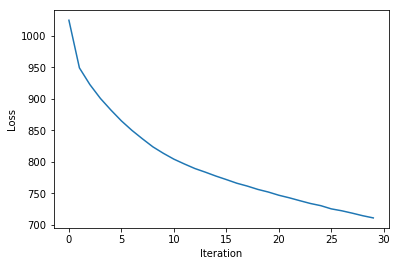

Accuracy of model on test set 48.00


In [10]:
modeleval.plot_loss()
accuracy_test = modeleval.test(testloader)
print('Accuracy of model on test set {0:.2f}'.format(accuracy_test))

In [8]:
from torch.utils.data.sampler import SubsetRandomSampler
from visualization import heatmap, annotate_heatmap
import copy

## K-fold Cross Validation

In [9]:
class CrossValidation:
    def __init__(self, k, batch_size, trainset, use_gpu):
        '''
        k: number of folds
        batch_size: batch size for training
        trainset: training data as pytorch iterator
        use_gpu: boolean variable to use gpus
        '''
        self.k = k
        self.nm_samples = len(trainset)
        self.indices = list(range(self.nm_samples))
        self.trainset = trainset
        self.batch_size = batch_size
        self.use_gpu = use_gpu
        
    def kfold(self):
        '''
        k-fold split
        '''
        for i in range(self.k):
            train_idx = [idx for j,idx in enumerate(self.indices) if j%self.k != i]
            valid_idx = [idx for j,idx in enumerate(self.indices) if j%self.k == i]            
            yield train_idx, valid_idx
    
    def trainloader_sampling(self):
        '''
        k-fold samples
        '''
        for train_idx, valid_idx in self.kfold():
            train_sampler = SubsetRandomSampler(train_idx)
            valid_sampler = SubsetRandomSampler(valid_idx)
            yield train_sampler, valid_sampler

    def gridsearchCV(self, parameters):
        '''
        find best parameters by doing grid search with k-fold cross validation
        '''
        accuracy_mat = np.zeros((len(parameters['lr']), len(parameters['n_hidden'])))
        for ii,lr in enumerate(parameters['lr']):
            for jj,n_hidden in enumerate(parameters['n_hidden']):
                fold_accuracy = []
                i = 0
                for train_sampler, valid_sampler in self.trainloader_sampling():
                    trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=self.batch_size, sampler=train_sampler, num_workers=2)
                    validloader = torch.utils.data.DataLoader(self.trainset, batch_size=self.batch_size, sampler=valid_sampler, num_workers=2)    
                    
                    model = LogisticRegression(n_in, n_hidden, n_out)
                    modeleval = ModelEvaluator(model, epochs, lr, use_gpu=self.use_gpu)
                    modeleval.train(trainloader, validloader, validation=True)
                    #modeleval.plot_loss()
                    accuracy_valid = modeleval.test(validloader)
                    print('Accuracy of model on validation set {0:.2f}'.format(accuracy_valid))
                    fold_accuracy.append(accuracy_valid)
                    i += 1
                mean_acc = np.mean(fold_accuracy)
                if mean_acc > np.max(accuracy_mat):
                    best_model, best_lr, best_n_hidden = copy.deepcopy(model), lr, n_hidden
                    # bestmodeleval = copy.deepcopy(modeleval)
                accuracy_mat[ii, jj] = np.mean(fold_accuracy)
        return accuracy_mat, best_model, best_lr, best_n_hidden

## Run k-fold and evaluate with best parameter

In [13]:
# Number of Parameters
parameters = {'lr':[0.00001, 0.0001, 0.001, 0.01], 'n_hidden': [512, 256, 128]}
# k fold cross validation
k = 3
cv = CrossValidation(k=k, batch_size=batch_size, trainset=trainset, use_gpu=True)
accuracy_mat, best_model, best_lr, best_n_hidden = cv.gridsearchCV(parameters)
bestmodeleval = ModelEvaluator(best_model, epochs, best_lr, use_gpu=True)

Epoch-1
-----------------
Iter-1, training loss2.30
Iter-2, training loss2.30
Iter-3, training loss2.30
Iter-4, training loss2.30
Iter-5, training loss2.30
Iter-6, training loss2.30
Iter-7, training loss2.31
Iter-8, training loss2.30
Iter-9, training loss2.30
Iter-10, training loss2.30
Iter-11, training loss2.30
Iter-12, training loss2.30
Iter-13, training loss2.30
Iter-14, training loss2.30
Iter-15, training loss2.30
Iter-16, training loss2.31
Iter-17, training loss2.30
Iter-18, training loss2.30
Iter-19, training loss2.30
Iter-20, training loss2.30
Iter-21, training loss2.30
Iter-22, training loss2.30
Iter-23, training loss2.30
Iter-24, training loss2.31
Iter-25, training loss2.30
Iter-26, training loss2.30
Iter-27, training loss2.30
Iter-28, training loss2.30
Iter-29, training loss2.30
Iter-30, training loss2.31
Iter-31, training loss2.31
Iter-32, training loss2.30
Iter-33, training loss2.30
Iter-34, training loss2.30
Iter-35, training loss2.30
Iter-36, training loss2.30
Iter-37, tr

Iter-303, training loss2.30
Iter-304, training loss2.30
Iter-305, training loss2.31
Iter-306, training loss2.30
Iter-307, training loss2.31
Iter-308, training loss2.30
Iter-309, training loss2.30
Iter-310, training loss2.30
Iter-311, training loss2.30
Iter-312, training loss2.30
Iter-313, training loss2.30
Iter-314, training loss2.30
Iter-315, training loss2.31
Iter-316, training loss2.30
Iter-317, training loss2.30
Iter-318, training loss2.30
Iter-319, training loss2.30
Iter-320, training loss2.30
Iter-321, training loss2.30
Iter-322, training loss2.31
Iter-323, training loss2.30
Iter-324, training loss2.30
Iter-325, training loss2.30
Iter-326, training loss2.30
Iter-327, training loss2.31
Iter-328, training loss2.30
Iter-329, training loss2.30
Iter-330, training loss2.30
Iter-331, training loss2.30
Iter-332, training loss2.30
Iter-333, training loss2.30
Iter-334, training loss2.31
Epoch-2
-----------------
Iter-335, training loss2.30
Iter-336, training loss2.30
Iter-337, training los

Iter-595, training loss2.30
Iter-596, training loss2.30
Iter-597, training loss2.31
Iter-598, training loss2.30
Iter-599, training loss2.31
Iter-600, training loss2.30
Iter-601, training loss2.29
Iter-602, training loss2.30
Iter-603, training loss2.30
Iter-604, training loss2.30
Iter-605, training loss2.30
Iter-606, training loss2.30
Iter-607, training loss2.30
Iter-608, training loss2.30
Iter-609, training loss2.30
Iter-610, training loss2.30
Iter-611, training loss2.30
Iter-612, training loss2.30
Iter-613, training loss2.30
Iter-614, training loss2.30
Iter-615, training loss2.30
Iter-616, training loss2.30
Iter-617, training loss2.30
Iter-618, training loss2.30
Iter-619, training loss2.30
Iter-620, training loss2.30
Iter-621, training loss2.30
Iter-622, training loss2.30
Iter-623, training loss2.30
Iter-624, training loss2.30
Iter-625, training loss2.30
Iter-626, training loss2.30
Iter-627, training loss2.30
Iter-628, training loss2.30
Iter-629, training loss2.30
Iter-630, training l

Iter-888, training loss2.30
Iter-889, training loss2.30
Iter-890, training loss2.30
Iter-891, training loss2.30
Iter-892, training loss2.30
Iter-893, training loss2.30
Iter-894, training loss2.30
Iter-895, training loss2.30
Iter-896, training loss2.30
Iter-897, training loss2.30
Iter-898, training loss2.30
Iter-899, training loss2.30
Iter-900, training loss2.30
Iter-901, training loss2.30
Iter-902, training loss2.30
Iter-903, training loss2.29
Iter-904, training loss2.30
Iter-905, training loss2.30
Iter-906, training loss2.30
Iter-907, training loss2.30
Iter-908, training loss2.30
Iter-909, training loss2.30
Iter-910, training loss2.30
Iter-911, training loss2.31
Iter-912, training loss2.30
Iter-913, training loss2.30
Iter-914, training loss2.29
Iter-915, training loss2.30
Iter-916, training loss2.30
Iter-917, training loss2.29
Iter-918, training loss2.30
Iter-919, training loss2.30
Iter-920, training loss2.29
Iter-921, training loss2.30
Iter-922, training loss2.30
Iter-923, training l

Iter-1176, training loss2.30
Iter-1177, training loss2.29
Iter-1178, training loss2.29
Iter-1179, training loss2.29
Iter-1180, training loss2.29
Iter-1181, training loss2.30
Iter-1182, training loss2.30
Iter-1183, training loss2.29
Iter-1184, training loss2.30
Iter-1185, training loss2.30
Iter-1186, training loss2.29
Iter-1187, training loss2.29
Iter-1188, training loss2.30
Iter-1189, training loss2.30
Iter-1190, training loss2.29
Iter-1191, training loss2.30
Iter-1192, training loss2.30
Iter-1193, training loss2.29
Iter-1194, training loss2.29
Iter-1195, training loss2.30
Iter-1196, training loss2.30
Iter-1197, training loss2.29
Iter-1198, training loss2.30
Iter-1199, training loss2.29
Iter-1200, training loss2.29
Iter-1201, training loss2.30
Iter-1202, training loss2.30
Iter-1203, training loss2.30
Iter-1204, training loss2.29
Iter-1205, training loss2.29
Iter-1206, training loss2.30
Iter-1207, training loss2.30
Iter-1208, training loss2.29
Iter-1209, training loss2.29
Iter-1210, tra

Iter-1463, training loss2.29
Iter-1464, training loss2.29
Iter-1465, training loss2.30
Iter-1466, training loss2.29
Iter-1467, training loss2.29
Iter-1468, training loss2.29
Iter-1469, training loss2.29
Iter-1470, training loss2.30
Iter-1471, training loss2.29
Iter-1472, training loss2.29
Iter-1473, training loss2.29
Iter-1474, training loss2.29
Iter-1475, training loss2.30
Iter-1476, training loss2.29
Iter-1477, training loss2.29
Iter-1478, training loss2.29
Iter-1479, training loss2.30
Iter-1480, training loss2.29
Iter-1481, training loss2.29
Iter-1482, training loss2.29
Iter-1483, training loss2.29
Iter-1484, training loss2.29
Iter-1485, training loss2.29
Iter-1486, training loss2.29
Iter-1487, training loss2.30
Iter-1488, training loss2.29
Iter-1489, training loss2.30
Iter-1490, training loss2.29
Iter-1491, training loss2.29
Iter-1492, training loss2.29
Iter-1493, training loss2.29
Iter-1494, training loss2.29
Iter-1495, training loss2.29
Iter-1496, training loss2.30
Iter-1497, tra

Iter-1751, training loss2.29
Iter-1752, training loss2.29
Iter-1753, training loss2.29
Iter-1754, training loss2.29
Iter-1755, training loss2.29
Iter-1756, training loss2.28
Iter-1757, training loss2.29
Iter-1758, training loss2.29
Iter-1759, training loss2.29
Iter-1760, training loss2.29
Iter-1761, training loss2.29
Iter-1762, training loss2.28
Iter-1763, training loss2.29
Iter-1764, training loss2.28
Iter-1765, training loss2.29
Iter-1766, training loss2.29
Iter-1767, training loss2.28
Iter-1768, training loss2.29
Iter-1769, training loss2.28
Iter-1770, training loss2.29
Iter-1771, training loss2.29
Iter-1772, training loss2.28
Iter-1773, training loss2.29
Iter-1774, training loss2.29
Iter-1775, training loss2.28
Iter-1776, training loss2.29
Iter-1777, training loss2.29
Iter-1778, training loss2.29
Iter-1779, training loss2.29
Iter-1780, training loss2.29
Iter-1781, training loss2.29
Iter-1782, training loss2.29
Iter-1783, training loss2.29
Iter-1784, training loss2.29
Iter-1785, tra

Iter-2039, training loss2.28
Iter-2040, training loss2.29
Iter-2041, training loss2.29
Iter-2042, training loss2.29
Iter-2043, training loss2.29
Iter-2044, training loss2.28
Iter-2045, training loss2.29
Iter-2046, training loss2.29
Iter-2047, training loss2.29
Iter-2048, training loss2.28
Iter-2049, training loss2.29
Iter-2050, training loss2.28
Iter-2051, training loss2.28
Iter-2052, training loss2.28
Iter-2053, training loss2.29
Iter-2054, training loss2.29
Iter-2055, training loss2.28
Iter-2056, training loss2.29
Iter-2057, training loss2.29
Iter-2058, training loss2.28
Iter-2059, training loss2.28
Iter-2060, training loss2.28
Iter-2061, training loss2.28
Iter-2062, training loss2.28
Iter-2063, training loss2.28
Iter-2064, training loss2.28
Iter-2065, training loss2.29
Iter-2066, training loss2.29
Iter-2067, training loss2.28
Iter-2068, training loss2.29
Iter-2069, training loss2.28
Iter-2070, training loss2.28
Iter-2071, training loss2.27
Iter-2072, training loss2.29
Iter-2073, tra

Iter-2323, training loss2.28
Iter-2324, training loss2.28
Iter-2325, training loss2.27
Iter-2326, training loss2.27
Iter-2327, training loss2.28
Iter-2328, training loss2.29
Iter-2329, training loss2.28
Iter-2330, training loss2.28
Iter-2331, training loss2.29
Iter-2332, training loss2.27
Iter-2333, training loss2.28
Iter-2334, training loss2.28
Iter-2335, training loss2.28
Iter-2336, training loss2.27
Iter-2337, training loss2.28
Iter-2338, training loss2.29
Epoch-8
-----------------
Iter-2339, training loss2.28
Iter-2340, training loss2.28
Iter-2341, training loss2.28
Iter-2342, training loss2.28
Iter-2343, training loss2.29
Iter-2344, training loss2.28
Iter-2345, training loss2.28
Iter-2346, training loss2.28
Iter-2347, training loss2.28
Iter-2348, training loss2.28
Iter-2349, training loss2.28
Iter-2350, training loss2.28
Iter-2351, training loss2.27
Iter-2352, training loss2.28
Iter-2353, training loss2.27
Iter-2354, training loss2.29
Iter-2355, training loss2.28
Iter-2356, traini

Iter-2607, training loss2.27
Iter-2608, training loss2.28
Iter-2609, training loss2.28
Iter-2610, training loss2.28
Iter-2611, training loss2.27
Iter-2612, training loss2.27
Iter-2613, training loss2.28
Iter-2614, training loss2.27
Iter-2615, training loss2.28
Iter-2616, training loss2.27
Iter-2617, training loss2.27
Iter-2618, training loss2.28
Iter-2619, training loss2.27
Iter-2620, training loss2.28
Iter-2621, training loss2.26
Iter-2622, training loss2.28
Iter-2623, training loss2.28
Iter-2624, training loss2.28
Iter-2625, training loss2.28
Iter-2626, training loss2.27
Iter-2627, training loss2.28
Iter-2628, training loss2.27
Iter-2629, training loss2.27
Iter-2630, training loss2.27
Iter-2631, training loss2.27
Iter-2632, training loss2.28
Iter-2633, training loss2.27
Iter-2634, training loss2.27
Iter-2635, training loss2.27
Iter-2636, training loss2.27
Iter-2637, training loss2.27
Iter-2638, training loss2.28
Iter-2639, training loss2.28
Iter-2640, training loss2.27
Iter-2641, tra

Iter-2894, training loss2.26
Iter-2895, training loss2.28
Iter-2896, training loss2.28
Iter-2897, training loss2.27
Iter-2898, training loss2.26
Iter-2899, training loss2.27
Iter-2900, training loss2.27
Iter-2901, training loss2.27
Iter-2902, training loss2.28
Iter-2903, training loss2.27
Iter-2904, training loss2.27
Iter-2905, training loss2.26
Iter-2906, training loss2.27
Iter-2907, training loss2.27
Iter-2908, training loss2.27
Iter-2909, training loss2.27
Iter-2910, training loss2.26
Iter-2911, training loss2.27
Iter-2912, training loss2.27
Iter-2913, training loss2.27
Iter-2914, training loss2.27
Iter-2915, training loss2.26
Iter-2916, training loss2.27
Iter-2917, training loss2.27
Iter-2918, training loss2.27
Iter-2919, training loss2.27
Iter-2920, training loss2.27
Iter-2921, training loss2.27
Iter-2922, training loss2.27
Iter-2923, training loss2.27
Iter-2924, training loss2.26
Iter-2925, training loss2.27
Iter-2926, training loss2.26
Iter-2927, training loss2.26
Iter-2928, tra

Iter-3178, training loss2.26
Iter-3179, training loss2.26
Iter-3180, training loss2.26
Iter-3181, training loss2.26
Iter-3182, training loss2.27
Iter-3183, training loss2.27
Iter-3184, training loss2.27
Iter-3185, training loss2.26
Iter-3186, training loss2.26
Iter-3187, training loss2.26
Iter-3188, training loss2.25
Iter-3189, training loss2.26
Iter-3190, training loss2.26
Iter-3191, training loss2.26
Iter-3192, training loss2.26
Iter-3193, training loss2.25
Iter-3194, training loss2.28
Iter-3195, training loss2.27
Iter-3196, training loss2.25
Iter-3197, training loss2.26
Iter-3198, training loss2.27
Iter-3199, training loss2.26
Iter-3200, training loss2.26
Iter-3201, training loss2.26
Iter-3202, training loss2.26
Iter-3203, training loss2.27
Iter-3204, training loss2.28
Iter-3205, training loss2.27
Iter-3206, training loss2.25
Iter-3207, training loss2.26
Iter-3208, training loss2.26
Iter-3209, training loss2.25
Iter-3210, training loss2.26
Iter-3211, training loss2.26
Iter-3212, tra

Iter-128, training loss2.30
Iter-129, training loss2.30
Iter-130, training loss2.30
Iter-131, training loss2.30
Iter-132, training loss2.30
Iter-133, training loss2.30
Iter-134, training loss2.30
Iter-135, training loss2.30
Iter-136, training loss2.30
Iter-137, training loss2.30
Iter-138, training loss2.31
Iter-139, training loss2.30
Iter-140, training loss2.31
Iter-141, training loss2.30
Iter-142, training loss2.30
Iter-143, training loss2.30
Iter-144, training loss2.31
Iter-145, training loss2.30
Iter-146, training loss2.30
Iter-147, training loss2.30
Iter-148, training loss2.30
Iter-149, training loss2.30
Iter-150, training loss2.30
Iter-151, training loss2.30
Iter-152, training loss2.30
Iter-153, training loss2.30
Iter-154, training loss2.30
Iter-155, training loss2.30
Iter-156, training loss2.30
Iter-157, training loss2.30
Iter-158, training loss2.30
Iter-159, training loss2.30
Iter-160, training loss2.30
Iter-161, training loss2.30
Iter-162, training loss2.30
Iter-163, training l

Iter-425, training loss2.30
Iter-426, training loss2.30
Iter-427, training loss2.30
Iter-428, training loss2.30
Iter-429, training loss2.30
Iter-430, training loss2.30
Iter-431, training loss2.30
Iter-432, training loss2.30
Iter-433, training loss2.30
Iter-434, training loss2.30
Iter-435, training loss2.30
Iter-436, training loss2.30
Iter-437, training loss2.30
Iter-438, training loss2.30
Iter-439, training loss2.30
Iter-440, training loss2.30
Iter-441, training loss2.30
Iter-442, training loss2.30
Iter-443, training loss2.30
Iter-444, training loss2.30
Iter-445, training loss2.30
Iter-446, training loss2.30
Iter-447, training loss2.30
Iter-448, training loss2.30
Iter-449, training loss2.30
Iter-450, training loss2.30
Iter-451, training loss2.30
Iter-452, training loss2.30
Iter-453, training loss2.30
Iter-454, training loss2.30
Iter-455, training loss2.30
Iter-456, training loss2.30
Iter-457, training loss2.30
Iter-458, training loss2.30
Iter-459, training loss2.30
Iter-460, training l

Iter-723, training loss2.30
Iter-724, training loss2.30
Iter-725, training loss2.30
Iter-726, training loss2.30
Iter-727, training loss2.30
Iter-728, training loss2.30
Iter-729, training loss2.30
Iter-730, training loss2.30
Iter-731, training loss2.30
Iter-732, training loss2.30
Iter-733, training loss2.30
Iter-734, training loss2.30
Iter-735, training loss2.30
Iter-736, training loss2.30
Iter-737, training loss2.30
Iter-738, training loss2.30
Iter-739, training loss2.30
Iter-740, training loss2.30
Iter-741, training loss2.30
Iter-742, training loss2.30
Iter-743, training loss2.30
Iter-744, training loss2.30
Iter-745, training loss2.30
Iter-746, training loss2.30
Iter-747, training loss2.30
Iter-748, training loss2.30
Iter-749, training loss2.30
Iter-750, training loss2.30
Iter-751, training loss2.30
Iter-752, training loss2.30
Iter-753, training loss2.30
Iter-754, training loss2.30
Iter-755, training loss2.30
Iter-756, training loss2.30
Iter-757, training loss2.30
Iter-758, training l

Iter-1021, training loss2.30
Iter-1022, training loss2.30
Iter-1023, training loss2.30
Iter-1024, training loss2.30
Iter-1025, training loss2.30
Iter-1026, training loss2.30
Iter-1027, training loss2.30
Iter-1028, training loss2.30
Iter-1029, training loss2.29
Iter-1030, training loss2.30
Iter-1031, training loss2.30
Iter-1032, training loss2.30
Iter-1033, training loss2.30
Iter-1034, training loss2.30
Iter-1035, training loss2.30
Iter-1036, training loss2.30
Iter-1037, training loss2.29
Iter-1038, training loss2.30
Iter-1039, training loss2.30
Iter-1040, training loss2.30
Iter-1041, training loss2.30
Iter-1042, training loss2.30
Iter-1043, training loss2.30
Iter-1044, training loss2.30
Iter-1045, training loss2.30
Iter-1046, training loss2.30
Iter-1047, training loss2.30
Iter-1048, training loss2.30
Iter-1049, training loss2.30
Iter-1050, training loss2.30
Iter-1051, training loss2.30
Iter-1052, training loss2.30
Iter-1053, training loss2.30
Iter-1054, training loss2.29
Iter-1055, tra

Iter-1305, training loss2.30
Iter-1306, training loss2.30
Iter-1307, training loss2.30
Iter-1308, training loss2.29
Iter-1309, training loss2.29
Iter-1310, training loss2.30
Iter-1311, training loss2.29
Iter-1312, training loss2.29
Iter-1313, training loss2.30
Iter-1314, training loss2.30
Iter-1315, training loss2.30
Iter-1316, training loss2.29
Iter-1317, training loss2.29
Iter-1318, training loss2.29
Iter-1319, training loss2.30
Iter-1320, training loss2.29
Iter-1321, training loss2.30
Iter-1322, training loss2.30
Iter-1323, training loss2.29
Iter-1324, training loss2.29
Iter-1325, training loss2.29
Iter-1326, training loss2.29
Iter-1327, training loss2.29
Iter-1328, training loss2.29
Iter-1329, training loss2.29
Iter-1330, training loss2.29
Iter-1331, training loss2.29
Iter-1332, training loss2.30
Iter-1333, training loss2.29
Iter-1334, training loss2.30
Iter-1335, training loss2.29
Iter-1336, training loss2.29
Epoch-5
-----------------
Iter-1337, training loss2.29
Iter-1338, traini

Iter-1589, training loss2.29
Iter-1590, training loss2.30
Iter-1591, training loss2.29
Iter-1592, training loss2.29
Iter-1593, training loss2.29
Iter-1594, training loss2.29
Iter-1595, training loss2.29
Iter-1596, training loss2.29
Iter-1597, training loss2.29
Iter-1598, training loss2.29
Iter-1599, training loss2.29
Iter-1600, training loss2.29
Iter-1601, training loss2.29
Iter-1602, training loss2.29
Iter-1603, training loss2.29
Iter-1604, training loss2.29
Iter-1605, training loss2.29
Iter-1606, training loss2.29
Iter-1607, training loss2.29
Iter-1608, training loss2.29
Iter-1609, training loss2.29
Iter-1610, training loss2.29
Iter-1611, training loss2.29
Iter-1612, training loss2.29
Iter-1613, training loss2.29
Iter-1614, training loss2.29
Iter-1615, training loss2.29
Iter-1616, training loss2.29
Iter-1617, training loss2.29
Iter-1618, training loss2.29
Iter-1619, training loss2.29
Iter-1620, training loss2.29
Iter-1621, training loss2.29
Iter-1622, training loss2.29
Iter-1623, tra

Iter-1872, training loss2.29
Iter-1873, training loss2.29
Iter-1874, training loss2.29
Iter-1875, training loss2.28
Iter-1876, training loss2.29
Iter-1877, training loss2.28
Iter-1878, training loss2.29
Iter-1879, training loss2.29
Iter-1880, training loss2.29
Iter-1881, training loss2.29
Iter-1882, training loss2.29
Iter-1883, training loss2.29
Iter-1884, training loss2.28
Iter-1885, training loss2.29
Iter-1886, training loss2.29
Iter-1887, training loss2.29
Iter-1888, training loss2.29
Iter-1889, training loss2.28
Iter-1890, training loss2.28
Iter-1891, training loss2.29
Iter-1892, training loss2.29
Iter-1893, training loss2.29
Iter-1894, training loss2.29
Iter-1895, training loss2.29
Iter-1896, training loss2.29
Iter-1897, training loss2.29
Iter-1898, training loss2.29
Iter-1899, training loss2.29
Iter-1900, training loss2.29
Iter-1901, training loss2.29
Iter-1902, training loss2.29
Iter-1903, training loss2.29
Iter-1904, training loss2.29
Iter-1905, training loss2.29
Iter-1906, tra

Iter-2154, training loss2.28
Iter-2155, training loss2.28
Iter-2156, training loss2.28
Iter-2157, training loss2.28
Iter-2158, training loss2.29
Iter-2159, training loss2.28
Iter-2160, training loss2.28
Iter-2161, training loss2.28
Iter-2162, training loss2.28
Iter-2163, training loss2.28
Iter-2164, training loss2.28
Iter-2165, training loss2.28
Iter-2166, training loss2.29
Iter-2167, training loss2.28
Iter-2168, training loss2.28
Iter-2169, training loss2.28
Iter-2170, training loss2.29
Iter-2171, training loss2.28
Iter-2172, training loss2.29
Iter-2173, training loss2.28
Iter-2174, training loss2.28
Iter-2175, training loss2.29
Iter-2176, training loss2.28
Iter-2177, training loss2.28
Iter-2178, training loss2.28
Iter-2179, training loss2.28
Iter-2180, training loss2.29
Iter-2181, training loss2.28
Iter-2182, training loss2.29
Iter-2183, training loss2.28
Iter-2184, training loss2.29
Iter-2185, training loss2.28
Iter-2186, training loss2.28
Iter-2187, training loss2.28
Iter-2188, tra

Iter-2438, training loss2.28
Iter-2439, training loss2.28
Iter-2440, training loss2.28
Iter-2441, training loss2.28
Iter-2442, training loss2.28
Iter-2443, training loss2.28
Iter-2444, training loss2.28
Iter-2445, training loss2.28
Iter-2446, training loss2.28
Iter-2447, training loss2.28
Iter-2448, training loss2.28
Iter-2449, training loss2.28
Iter-2450, training loss2.28
Iter-2451, training loss2.28
Iter-2452, training loss2.28
Iter-2453, training loss2.29
Iter-2454, training loss2.28
Iter-2455, training loss2.28
Iter-2456, training loss2.28
Iter-2457, training loss2.27
Iter-2458, training loss2.28
Iter-2459, training loss2.27
Iter-2460, training loss2.28
Iter-2461, training loss2.27
Iter-2462, training loss2.28
Iter-2463, training loss2.27
Iter-2464, training loss2.28
Iter-2465, training loss2.27
Iter-2466, training loss2.29
Iter-2467, training loss2.28
Iter-2468, training loss2.27
Iter-2469, training loss2.28
Iter-2470, training loss2.27
Iter-2471, training loss2.28
Iter-2472, tra

Iter-2727, training loss2.28
Iter-2728, training loss2.27
Iter-2729, training loss2.28
Iter-2730, training loss2.28
Iter-2731, training loss2.27
Iter-2732, training loss2.27
Iter-2733, training loss2.26
Iter-2734, training loss2.27
Iter-2735, training loss2.28
Iter-2736, training loss2.27
Iter-2737, training loss2.27
Iter-2738, training loss2.27
Iter-2739, training loss2.27
Iter-2740, training loss2.27
Iter-2741, training loss2.27
Iter-2742, training loss2.28
Iter-2743, training loss2.28
Iter-2744, training loss2.28
Iter-2745, training loss2.28
Iter-2746, training loss2.27
Iter-2747, training loss2.26
Iter-2748, training loss2.27
Iter-2749, training loss2.27
Iter-2750, training loss2.27
Iter-2751, training loss2.27
Iter-2752, training loss2.27
Iter-2753, training loss2.28
Iter-2754, training loss2.27
Iter-2755, training loss2.28
Iter-2756, training loss2.27
Iter-2757, training loss2.27
Iter-2758, training loss2.27
Iter-2759, training loss2.26
Iter-2760, training loss2.27
Iter-2761, tra

Iter-3016, training loss2.26
Iter-3017, training loss2.27
Iter-3018, training loss2.27
Iter-3019, training loss2.27
Iter-3020, training loss2.27
Iter-3021, training loss2.26
Iter-3022, training loss2.27
Iter-3023, training loss2.27
Iter-3024, training loss2.28
Iter-3025, training loss2.27
Iter-3026, training loss2.27
Iter-3027, training loss2.27
Iter-3028, training loss2.26
Iter-3029, training loss2.26
Iter-3030, training loss2.26
Iter-3031, training loss2.26
Iter-3032, training loss2.27
Iter-3033, training loss2.27
Iter-3034, training loss2.26
Iter-3035, training loss2.26
Iter-3036, training loss2.27
Iter-3037, training loss2.27
Iter-3038, training loss2.26
Iter-3039, training loss2.28
Iter-3040, training loss2.27
Iter-3041, training loss2.27
Iter-3042, training loss2.28
Iter-3043, training loss2.26
Iter-3044, training loss2.27
Iter-3045, training loss2.27
Iter-3046, training loss2.27
Iter-3047, training loss2.26
Iter-3048, training loss2.26
Iter-3049, training loss2.27
Iter-3050, tra

Iter-3299, training loss2.26
Iter-3300, training loss2.26
Iter-3301, training loss2.26
Iter-3302, training loss2.27
Iter-3303, training loss2.27
Iter-3304, training loss2.25
Iter-3305, training loss2.27
Iter-3306, training loss2.27
Iter-3307, training loss2.27
Iter-3308, training loss2.27
Iter-3309, training loss2.26
Iter-3310, training loss2.27
Iter-3311, training loss2.25
Iter-3312, training loss2.27
Iter-3313, training loss2.26
Iter-3314, training loss2.27
Iter-3315, training loss2.26
Iter-3316, training loss2.26
Iter-3317, training loss2.27
Iter-3318, training loss2.26
Iter-3319, training loss2.27
Iter-3320, training loss2.27
Iter-3321, training loss2.27
Iter-3322, training loss2.27
Iter-3323, training loss2.28
Iter-3324, training loss2.27
Iter-3325, training loss2.27
Iter-3326, training loss2.27
Iter-3327, training loss2.26
Iter-3328, training loss2.27
Iter-3329, training loss2.26
Iter-3330, training loss2.26
Iter-3331, training loss2.24
Iter-3332, training loss2.26
Iter-3333, tra

Iter-255, training loss2.30
Iter-256, training loss2.31
Iter-257, training loss2.30
Iter-258, training loss2.31
Iter-259, training loss2.30
Iter-260, training loss2.30
Iter-261, training loss2.30
Iter-262, training loss2.30
Iter-263, training loss2.31
Iter-264, training loss2.30
Iter-265, training loss2.30
Iter-266, training loss2.30
Iter-267, training loss2.29
Iter-268, training loss2.30
Iter-269, training loss2.30
Iter-270, training loss2.30
Iter-271, training loss2.30
Iter-272, training loss2.30
Iter-273, training loss2.30
Iter-274, training loss2.30
Iter-275, training loss2.30
Iter-276, training loss2.31
Iter-277, training loss2.30
Iter-278, training loss2.30
Iter-279, training loss2.30
Iter-280, training loss2.30
Iter-281, training loss2.30
Iter-282, training loss2.30
Iter-283, training loss2.30
Iter-284, training loss2.30
Iter-285, training loss2.30
Iter-286, training loss2.30
Iter-287, training loss2.30
Iter-288, training loss2.30
Iter-289, training loss2.31
Iter-290, training l

Iter-553, training loss2.30
Iter-554, training loss2.30
Iter-555, training loss2.30
Iter-556, training loss2.30
Iter-557, training loss2.29
Iter-558, training loss2.30
Iter-559, training loss2.30
Iter-560, training loss2.30
Iter-561, training loss2.29
Iter-562, training loss2.30
Iter-563, training loss2.30
Iter-564, training loss2.31
Iter-565, training loss2.30
Iter-566, training loss2.30
Iter-567, training loss2.30
Iter-568, training loss2.30
Iter-569, training loss2.30
Iter-570, training loss2.30
Iter-571, training loss2.30
Iter-572, training loss2.30
Iter-573, training loss2.30
Iter-574, training loss2.30
Iter-575, training loss2.29
Iter-576, training loss2.30
Iter-577, training loss2.30
Iter-578, training loss2.30
Iter-579, training loss2.30
Iter-580, training loss2.30
Iter-581, training loss2.30
Iter-582, training loss2.30
Iter-583, training loss2.30
Iter-584, training loss2.30
Iter-585, training loss2.30
Iter-586, training loss2.29
Iter-587, training loss2.30
Iter-588, training l

Iter-853, training loss2.30
Iter-854, training loss2.29
Iter-855, training loss2.30
Iter-856, training loss2.30
Iter-857, training loss2.30
Iter-858, training loss2.30
Iter-859, training loss2.30
Iter-860, training loss2.30
Iter-861, training loss2.30
Iter-862, training loss2.30
Iter-863, training loss2.29
Iter-864, training loss2.30
Iter-865, training loss2.30
Iter-866, training loss2.30
Iter-867, training loss2.29
Iter-868, training loss2.30
Iter-869, training loss2.30
Iter-870, training loss2.30
Iter-871, training loss2.30
Iter-872, training loss2.30
Iter-873, training loss2.30
Iter-874, training loss2.29
Iter-875, training loss2.30
Iter-876, training loss2.30
Iter-877, training loss2.30
Iter-878, training loss2.30
Iter-879, training loss2.29
Iter-880, training loss2.29
Iter-881, training loss2.30
Iter-882, training loss2.29
Iter-883, training loss2.30
Iter-884, training loss2.29
Iter-885, training loss2.29
Iter-886, training loss2.30
Iter-887, training loss2.30
Iter-888, training l

Iter-1145, training loss2.30
Iter-1146, training loss2.30
Iter-1147, training loss2.29
Iter-1148, training loss2.30
Iter-1149, training loss2.30
Iter-1150, training loss2.29
Iter-1151, training loss2.29
Iter-1152, training loss2.29
Iter-1153, training loss2.30
Iter-1154, training loss2.30
Iter-1155, training loss2.30
Iter-1156, training loss2.30
Iter-1157, training loss2.29
Iter-1158, training loss2.29
Iter-1159, training loss2.29
Iter-1160, training loss2.29
Iter-1161, training loss2.29
Iter-1162, training loss2.29
Iter-1163, training loss2.29
Iter-1164, training loss2.30
Iter-1165, training loss2.29
Iter-1166, training loss2.29
Iter-1167, training loss2.29
Iter-1168, training loss2.30
Iter-1169, training loss2.29
Iter-1170, training loss2.29
Iter-1171, training loss2.30
Iter-1172, training loss2.30
Iter-1173, training loss2.30
Iter-1174, training loss2.29
Iter-1175, training loss2.29
Iter-1176, training loss2.30
Iter-1177, training loss2.29
Iter-1178, training loss2.28
Iter-1179, tra

Iter-1427, training loss2.29
Iter-1428, training loss2.29
Iter-1429, training loss2.30
Iter-1430, training loss2.29
Iter-1431, training loss2.29
Iter-1432, training loss2.29
Iter-1433, training loss2.29
Iter-1434, training loss2.29
Iter-1435, training loss2.29
Iter-1436, training loss2.30
Iter-1437, training loss2.29
Iter-1438, training loss2.29
Iter-1439, training loss2.28
Iter-1440, training loss2.29
Iter-1441, training loss2.29
Iter-1442, training loss2.29
Iter-1443, training loss2.29
Iter-1444, training loss2.29
Iter-1445, training loss2.29
Iter-1446, training loss2.29
Iter-1447, training loss2.29
Iter-1448, training loss2.29
Iter-1449, training loss2.30
Iter-1450, training loss2.29
Iter-1451, training loss2.29
Iter-1452, training loss2.29
Iter-1453, training loss2.29
Iter-1454, training loss2.29
Iter-1455, training loss2.29
Iter-1456, training loss2.29
Iter-1457, training loss2.29
Iter-1458, training loss2.29
Iter-1459, training loss2.30
Iter-1460, training loss2.29
Iter-1461, tra

Iter-1714, training loss2.29
Iter-1715, training loss2.29
Iter-1716, training loss2.28
Iter-1717, training loss2.29
Iter-1718, training loss2.29
Iter-1719, training loss2.29
Iter-1720, training loss2.29
Iter-1721, training loss2.29
Iter-1722, training loss2.29
Iter-1723, training loss2.29
Iter-1724, training loss2.29
Iter-1725, training loss2.30
Iter-1726, training loss2.29
Iter-1727, training loss2.28
Iter-1728, training loss2.30
Iter-1729, training loss2.28
Iter-1730, training loss2.29
Iter-1731, training loss2.29
Iter-1732, training loss2.29
Iter-1733, training loss2.29
Iter-1734, training loss2.29
Iter-1735, training loss2.29
Iter-1736, training loss2.28
Iter-1737, training loss2.29
Iter-1738, training loss2.29
Iter-1739, training loss2.29
Iter-1740, training loss2.29
Iter-1741, training loss2.29
Iter-1742, training loss2.29
Iter-1743, training loss2.28
Iter-1744, training loss2.29
Iter-1745, training loss2.30
Iter-1746, training loss2.29
Iter-1747, training loss2.29
Iter-1748, tra

Iter-2000, training loss2.28
Accuracy on Test Set 12.00
Iter-2001, training loss2.27
Iter-2002, training loss2.28
Iter-2003, training loss2.29
Iter-2004, training loss2.28
Epoch-7
-----------------
Iter-2005, training loss2.28
Iter-2006, training loss2.28
Iter-2007, training loss2.29
Iter-2008, training loss2.28
Iter-2009, training loss2.28
Iter-2010, training loss2.28
Iter-2011, training loss2.29
Iter-2012, training loss2.28
Iter-2013, training loss2.27
Iter-2014, training loss2.29
Iter-2015, training loss2.27
Iter-2016, training loss2.29
Iter-2017, training loss2.29
Iter-2018, training loss2.28
Iter-2019, training loss2.28
Iter-2020, training loss2.28
Iter-2021, training loss2.28
Iter-2022, training loss2.28
Iter-2023, training loss2.28
Iter-2024, training loss2.28
Iter-2025, training loss2.28
Iter-2026, training loss2.29
Iter-2027, training loss2.29
Iter-2028, training loss2.28
Iter-2029, training loss2.28
Iter-2030, training loss2.29
Iter-2031, training loss2.28
Iter-2032, training

Iter-2282, training loss2.28
Iter-2283, training loss2.28
Iter-2284, training loss2.28
Iter-2285, training loss2.27
Iter-2286, training loss2.28
Iter-2287, training loss2.27
Iter-2288, training loss2.27
Iter-2289, training loss2.28
Iter-2290, training loss2.27
Iter-2291, training loss2.29
Iter-2292, training loss2.28
Iter-2293, training loss2.28
Iter-2294, training loss2.28
Iter-2295, training loss2.28
Iter-2296, training loss2.28
Iter-2297, training loss2.28
Iter-2298, training loss2.27
Iter-2299, training loss2.28
Iter-2300, training loss2.29
Iter-2301, training loss2.27
Iter-2302, training loss2.29
Iter-2303, training loss2.29
Iter-2304, training loss2.27
Iter-2305, training loss2.28
Iter-2306, training loss2.28
Iter-2307, training loss2.29
Iter-2308, training loss2.27
Iter-2309, training loss2.28
Iter-2310, training loss2.28
Iter-2311, training loss2.29
Iter-2312, training loss2.28
Iter-2313, training loss2.27
Iter-2314, training loss2.28
Iter-2315, training loss2.29
Iter-2316, tra

Iter-2571, training loss2.27
Iter-2572, training loss2.27
Iter-2573, training loss2.26
Iter-2574, training loss2.27
Iter-2575, training loss2.28
Iter-2576, training loss2.27
Iter-2577, training loss2.26
Iter-2578, training loss2.28
Iter-2579, training loss2.28
Iter-2580, training loss2.27
Iter-2581, training loss2.28
Iter-2582, training loss2.28
Iter-2583, training loss2.27
Iter-2584, training loss2.27
Iter-2585, training loss2.26
Iter-2586, training loss2.27
Iter-2587, training loss2.27
Iter-2588, training loss2.28
Iter-2589, training loss2.28
Iter-2590, training loss2.28
Iter-2591, training loss2.28
Iter-2592, training loss2.28
Iter-2593, training loss2.26
Iter-2594, training loss2.27
Iter-2595, training loss2.27
Iter-2596, training loss2.26
Iter-2597, training loss2.27
Iter-2598, training loss2.27
Iter-2599, training loss2.25
Iter-2600, training loss2.28
Iter-2601, training loss2.28
Iter-2602, training loss2.28
Iter-2603, training loss2.28
Iter-2604, training loss2.28
Iter-2605, tra

Iter-2859, training loss2.27
Iter-2860, training loss2.27
Iter-2861, training loss2.28
Iter-2862, training loss2.28
Iter-2863, training loss2.27
Iter-2864, training loss2.27
Iter-2865, training loss2.27
Iter-2866, training loss2.27
Iter-2867, training loss2.26
Iter-2868, training loss2.28
Iter-2869, training loss2.26
Iter-2870, training loss2.27
Iter-2871, training loss2.27
Iter-2872, training loss2.27
Iter-2873, training loss2.26
Iter-2874, training loss2.27
Iter-2875, training loss2.26
Iter-2876, training loss2.27
Iter-2877, training loss2.27
Iter-2878, training loss2.27
Iter-2879, training loss2.26
Iter-2880, training loss2.27
Iter-2881, training loss2.27
Iter-2882, training loss2.26
Iter-2883, training loss2.26
Iter-2884, training loss2.28
Iter-2885, training loss2.26
Iter-2886, training loss2.26
Iter-2887, training loss2.26
Iter-2888, training loss2.27
Iter-2889, training loss2.26
Iter-2890, training loss2.27
Iter-2891, training loss2.26
Iter-2892, training loss2.25
Iter-2893, tra

Iter-3142, training loss2.26
Iter-3143, training loss2.25
Iter-3144, training loss2.26
Iter-3145, training loss2.27
Iter-3146, training loss2.26
Iter-3147, training loss2.26
Iter-3148, training loss2.25
Iter-3149, training loss2.26
Iter-3150, training loss2.26
Iter-3151, training loss2.24
Iter-3152, training loss2.26
Iter-3153, training loss2.26
Iter-3154, training loss2.26
Iter-3155, training loss2.26
Iter-3156, training loss2.26
Iter-3157, training loss2.27
Iter-3158, training loss2.26
Iter-3159, training loss2.26
Iter-3160, training loss2.27
Iter-3161, training loss2.25
Iter-3162, training loss2.24
Iter-3163, training loss2.27
Iter-3164, training loss2.26
Iter-3165, training loss2.26
Iter-3166, training loss2.25
Iter-3167, training loss2.25
Iter-3168, training loss2.27
Iter-3169, training loss2.27
Iter-3170, training loss2.26
Iter-3171, training loss2.26
Iter-3172, training loss2.26
Iter-3173, training loss2.27
Iter-3174, training loss2.25
Iter-3175, training loss2.27
Iter-3176, tra

Iter-92, training loss2.30
Iter-93, training loss2.31
Iter-94, training loss2.30
Iter-95, training loss2.30
Iter-96, training loss2.31
Iter-97, training loss2.30
Iter-98, training loss2.30
Iter-99, training loss2.30
Iter-100, training loss2.30
Iter-101, training loss2.31
Iter-102, training loss2.30
Iter-103, training loss2.30
Iter-104, training loss2.30
Iter-105, training loss2.30
Iter-106, training loss2.30
Iter-107, training loss2.30
Iter-108, training loss2.31
Iter-109, training loss2.30
Iter-110, training loss2.30
Iter-111, training loss2.31
Iter-112, training loss2.30
Iter-113, training loss2.31
Iter-114, training loss2.30
Iter-115, training loss2.30
Iter-116, training loss2.30
Iter-117, training loss2.31
Iter-118, training loss2.31
Iter-119, training loss2.30
Iter-120, training loss2.30
Iter-121, training loss2.30
Iter-122, training loss2.30
Iter-123, training loss2.30
Iter-124, training loss2.30
Iter-125, training loss2.30
Iter-126, training loss2.30
Iter-127, training loss2.30


Iter-384, training loss2.31
Iter-385, training loss2.30
Iter-386, training loss2.30
Iter-387, training loss2.30
Iter-388, training loss2.31
Iter-389, training loss2.31
Iter-390, training loss2.30
Iter-391, training loss2.30
Iter-392, training loss2.29
Iter-393, training loss2.30
Iter-394, training loss2.30
Iter-395, training loss2.30
Iter-396, training loss2.30
Iter-397, training loss2.30
Iter-398, training loss2.30
Iter-399, training loss2.30
Iter-400, training loss2.30
Iter-401, training loss2.30
Iter-402, training loss2.30
Iter-403, training loss2.30
Iter-404, training loss2.30
Iter-405, training loss2.30
Iter-406, training loss2.30
Iter-407, training loss2.30
Iter-408, training loss2.31
Iter-409, training loss2.30
Iter-410, training loss2.30
Iter-411, training loss2.31
Iter-412, training loss2.30
Iter-413, training loss2.31
Iter-414, training loss2.30
Iter-415, training loss2.29
Iter-416, training loss2.30
Iter-417, training loss2.30
Iter-418, training loss2.30
Iter-419, training l

Iter-675, training loss2.30
Iter-676, training loss2.30
Iter-677, training loss2.30
Iter-678, training loss2.29
Iter-679, training loss2.31
Iter-680, training loss2.30
Iter-681, training loss2.30
Iter-682, training loss2.30
Iter-683, training loss2.30
Iter-684, training loss2.30
Iter-685, training loss2.30
Iter-686, training loss2.29
Iter-687, training loss2.30
Iter-688, training loss2.30
Iter-689, training loss2.30
Iter-690, training loss2.30
Iter-691, training loss2.30
Iter-692, training loss2.30
Iter-693, training loss2.30
Iter-694, training loss2.30
Iter-695, training loss2.30
Iter-696, training loss2.30
Iter-697, training loss2.30
Iter-698, training loss2.30
Iter-699, training loss2.30
Iter-700, training loss2.30
Iter-701, training loss2.30
Iter-702, training loss2.30
Iter-703, training loss2.30
Iter-704, training loss2.30
Iter-705, training loss2.30
Iter-706, training loss2.29
Iter-707, training loss2.31
Iter-708, training loss2.30
Iter-709, training loss2.30
Iter-710, training l

Iter-971, training loss2.30
Iter-972, training loss2.30
Iter-973, training loss2.30
Iter-974, training loss2.30
Iter-975, training loss2.30
Iter-976, training loss2.30
Iter-977, training loss2.29
Iter-978, training loss2.29
Iter-979, training loss2.30
Iter-980, training loss2.30
Iter-981, training loss2.29
Iter-982, training loss2.30
Iter-983, training loss2.30
Iter-984, training loss2.30
Iter-985, training loss2.30
Iter-986, training loss2.30
Iter-987, training loss2.30
Iter-988, training loss2.30
Iter-989, training loss2.29
Iter-990, training loss2.31
Iter-991, training loss2.30
Iter-992, training loss2.30
Iter-993, training loss2.30
Iter-994, training loss2.30
Iter-995, training loss2.31
Iter-996, training loss2.30
Iter-997, training loss2.30
Iter-998, training loss2.30
Iter-999, training loss2.30
Iter-1000, training loss2.30
Accuracy on Test Set 9.00
Iter-1001, training loss2.30
Iter-1002, training loss2.30
Epoch-4
-----------------
Iter-1003, training loss2.30
Iter-1004, training 

Iter-1262, training loss2.29
Iter-1263, training loss2.29
Iter-1264, training loss2.29
Iter-1265, training loss2.30
Iter-1266, training loss2.29
Iter-1267, training loss2.30
Iter-1268, training loss2.29
Iter-1269, training loss2.30
Iter-1270, training loss2.30
Iter-1271, training loss2.29
Iter-1272, training loss2.29
Iter-1273, training loss2.30
Iter-1274, training loss2.30
Iter-1275, training loss2.30
Iter-1276, training loss2.30
Iter-1277, training loss2.30
Iter-1278, training loss2.30
Iter-1279, training loss2.31
Iter-1280, training loss2.30
Iter-1281, training loss2.30
Iter-1282, training loss2.30
Iter-1283, training loss2.30
Iter-1284, training loss2.30
Iter-1285, training loss2.30
Iter-1286, training loss2.30
Iter-1287, training loss2.29
Iter-1288, training loss2.30
Iter-1289, training loss2.29
Iter-1290, training loss2.30
Iter-1291, training loss2.30
Iter-1292, training loss2.30
Iter-1293, training loss2.30
Iter-1294, training loss2.30
Iter-1295, training loss2.30
Iter-1296, tra

Iter-1550, training loss2.29
Iter-1551, training loss2.29
Iter-1552, training loss2.30
Iter-1553, training loss2.30
Iter-1554, training loss2.29
Iter-1555, training loss2.29
Iter-1556, training loss2.30
Iter-1557, training loss2.30
Iter-1558, training loss2.30
Iter-1559, training loss2.30
Iter-1560, training loss2.29
Iter-1561, training loss2.30
Iter-1562, training loss2.30
Iter-1563, training loss2.30
Iter-1564, training loss2.30
Iter-1565, training loss2.30
Iter-1566, training loss2.29
Iter-1567, training loss2.30
Iter-1568, training loss2.30
Iter-1569, training loss2.30
Iter-1570, training loss2.30
Iter-1571, training loss2.29
Iter-1572, training loss2.29
Iter-1573, training loss2.30
Iter-1574, training loss2.29
Iter-1575, training loss2.31
Iter-1576, training loss2.29
Iter-1577, training loss2.29
Iter-1578, training loss2.30
Iter-1579, training loss2.29
Iter-1580, training loss2.29
Iter-1581, training loss2.29
Iter-1582, training loss2.29
Iter-1583, training loss2.30
Iter-1584, tra

Iter-1835, training loss2.29
Iter-1836, training loss2.30
Iter-1837, training loss2.30
Iter-1838, training loss2.29
Iter-1839, training loss2.30
Iter-1840, training loss2.29
Iter-1841, training loss2.29
Iter-1842, training loss2.29
Iter-1843, training loss2.29
Iter-1844, training loss2.29
Iter-1845, training loss2.30
Iter-1846, training loss2.30
Iter-1847, training loss2.29
Iter-1848, training loss2.29
Iter-1849, training loss2.29
Iter-1850, training loss2.29
Iter-1851, training loss2.29
Iter-1852, training loss2.29
Iter-1853, training loss2.30
Iter-1854, training loss2.29
Iter-1855, training loss2.29
Iter-1856, training loss2.30
Iter-1857, training loss2.30
Iter-1858, training loss2.29
Iter-1859, training loss2.30
Iter-1860, training loss2.30
Iter-1861, training loss2.29
Iter-1862, training loss2.29
Iter-1863, training loss2.29
Iter-1864, training loss2.30
Iter-1865, training loss2.29
Iter-1866, training loss2.30
Iter-1867, training loss2.29
Iter-1868, training loss2.29
Iter-1869, tra

Iter-2117, training loss2.29
Iter-2118, training loss2.29
Iter-2119, training loss2.29
Iter-2120, training loss2.29
Iter-2121, training loss2.29
Iter-2122, training loss2.29
Iter-2123, training loss2.29
Iter-2124, training loss2.29
Iter-2125, training loss2.29
Iter-2126, training loss2.30
Iter-2127, training loss2.29
Iter-2128, training loss2.29
Iter-2129, training loss2.29
Iter-2130, training loss2.29
Iter-2131, training loss2.29
Iter-2132, training loss2.29
Iter-2133, training loss2.29
Iter-2134, training loss2.30
Iter-2135, training loss2.30
Iter-2136, training loss2.29
Iter-2137, training loss2.29
Iter-2138, training loss2.29
Iter-2139, training loss2.30
Iter-2140, training loss2.28
Iter-2141, training loss2.30
Iter-2142, training loss2.29
Iter-2143, training loss2.29
Iter-2144, training loss2.30
Iter-2145, training loss2.30
Iter-2146, training loss2.29
Iter-2147, training loss2.29
Iter-2148, training loss2.30
Iter-2149, training loss2.29
Iter-2150, training loss2.30
Iter-2151, tra

Iter-2399, training loss2.29
Iter-2400, training loss2.29
Iter-2401, training loss2.29
Iter-2402, training loss2.29
Iter-2403, training loss2.30
Iter-2404, training loss2.28
Iter-2405, training loss2.29
Iter-2406, training loss2.29
Iter-2407, training loss2.29
Iter-2408, training loss2.28
Iter-2409, training loss2.30
Iter-2410, training loss2.29
Iter-2411, training loss2.29
Iter-2412, training loss2.29
Iter-2413, training loss2.29
Iter-2414, training loss2.28
Iter-2415, training loss2.29
Iter-2416, training loss2.28
Iter-2417, training loss2.29
Iter-2418, training loss2.28
Iter-2419, training loss2.29
Iter-2420, training loss2.29
Iter-2421, training loss2.29
Iter-2422, training loss2.29
Iter-2423, training loss2.29
Iter-2424, training loss2.29
Iter-2425, training loss2.29
Iter-2426, training loss2.28
Iter-2427, training loss2.29
Iter-2428, training loss2.28
Iter-2429, training loss2.29
Iter-2430, training loss2.28
Iter-2431, training loss2.28
Iter-2432, training loss2.28
Iter-2433, tra

Iter-2685, training loss2.29
Iter-2686, training loss2.27
Iter-2687, training loss2.29
Iter-2688, training loss2.29
Iter-2689, training loss2.28
Iter-2690, training loss2.28
Iter-2691, training loss2.29
Iter-2692, training loss2.29
Iter-2693, training loss2.28
Iter-2694, training loss2.29
Iter-2695, training loss2.28
Iter-2696, training loss2.29
Iter-2697, training loss2.28
Iter-2698, training loss2.28
Iter-2699, training loss2.29
Iter-2700, training loss2.28
Iter-2701, training loss2.29
Iter-2702, training loss2.28
Iter-2703, training loss2.28
Iter-2704, training loss2.29
Iter-2705, training loss2.28
Iter-2706, training loss2.29
Iter-2707, training loss2.29
Iter-2708, training loss2.28
Iter-2709, training loss2.28
Iter-2710, training loss2.29
Iter-2711, training loss2.28
Iter-2712, training loss2.28
Iter-2713, training loss2.28
Iter-2714, training loss2.29
Iter-2715, training loss2.29
Iter-2716, training loss2.29
Iter-2717, training loss2.28
Iter-2718, training loss2.28
Iter-2719, tra

Iter-2974, training loss2.29
Iter-2975, training loss2.27
Iter-2976, training loss2.28
Iter-2977, training loss2.29
Iter-2978, training loss2.29
Iter-2979, training loss2.28
Iter-2980, training loss2.28
Iter-2981, training loss2.28
Iter-2982, training loss2.28
Iter-2983, training loss2.28
Iter-2984, training loss2.29
Iter-2985, training loss2.28
Iter-2986, training loss2.29
Iter-2987, training loss2.27
Iter-2988, training loss2.28
Iter-2989, training loss2.28
Iter-2990, training loss2.28
Iter-2991, training loss2.28
Iter-2992, training loss2.27
Iter-2993, training loss2.29
Iter-2994, training loss2.28
Iter-2995, training loss2.29
Iter-2996, training loss2.29
Iter-2997, training loss2.28
Iter-2998, training loss2.28
Iter-2999, training loss2.29
Iter-3000, training loss2.28
Accuracy on Test Set 12.00
Iter-3001, training loss2.29
Iter-3002, training loss2.29
Iter-3003, training loss2.29
Iter-3004, training loss2.28
Iter-3005, training loss2.28
Iter-3006, training loss2.29
Epoch-10
-------

Iter-3263, training loss2.27
Iter-3264, training loss2.27
Iter-3265, training loss2.29
Iter-3266, training loss2.29
Iter-3267, training loss2.27
Iter-3268, training loss2.29
Iter-3269, training loss2.28
Iter-3270, training loss2.29
Iter-3271, training loss2.27
Iter-3272, training loss2.28
Iter-3273, training loss2.28
Iter-3274, training loss2.28
Iter-3275, training loss2.28
Iter-3276, training loss2.27
Iter-3277, training loss2.27
Iter-3278, training loss2.28
Iter-3279, training loss2.27
Iter-3280, training loss2.27
Iter-3281, training loss2.28
Iter-3282, training loss2.28
Iter-3283, training loss2.27
Iter-3284, training loss2.28
Iter-3285, training loss2.28
Iter-3286, training loss2.28
Iter-3287, training loss2.29
Iter-3288, training loss2.28
Iter-3289, training loss2.28
Iter-3290, training loss2.28
Iter-3291, training loss2.29
Iter-3292, training loss2.27
Iter-3293, training loss2.28
Iter-3294, training loss2.28
Iter-3295, training loss2.29
Iter-3296, training loss2.28
Iter-3297, tra

Iter-219, training loss2.30
Iter-220, training loss2.31
Iter-221, training loss2.30
Iter-222, training loss2.30
Iter-223, training loss2.29
Iter-224, training loss2.30
Iter-225, training loss2.30
Iter-226, training loss2.30
Iter-227, training loss2.31
Iter-228, training loss2.30
Iter-229, training loss2.30
Iter-230, training loss2.30
Iter-231, training loss2.30
Iter-232, training loss2.31
Iter-233, training loss2.30
Iter-234, training loss2.30
Iter-235, training loss2.30
Iter-236, training loss2.30
Iter-237, training loss2.30
Iter-238, training loss2.30
Iter-239, training loss2.30
Iter-240, training loss2.30
Iter-241, training loss2.30
Iter-242, training loss2.30
Iter-243, training loss2.30
Iter-244, training loss2.30
Iter-245, training loss2.30
Iter-246, training loss2.30
Iter-247, training loss2.30
Iter-248, training loss2.31
Iter-249, training loss2.30
Iter-250, training loss2.30
Iter-251, training loss2.30
Iter-252, training loss2.31
Iter-253, training loss2.30
Iter-254, training l

Iter-512, training loss2.30
Iter-513, training loss2.30
Iter-514, training loss2.30
Iter-515, training loss2.30
Iter-516, training loss2.30
Iter-517, training loss2.30
Iter-518, training loss2.30
Iter-519, training loss2.30
Iter-520, training loss2.30
Iter-521, training loss2.29
Iter-522, training loss2.30
Iter-523, training loss2.30
Iter-524, training loss2.31
Iter-525, training loss2.30
Iter-526, training loss2.30
Iter-527, training loss2.30
Iter-528, training loss2.30
Iter-529, training loss2.30
Iter-530, training loss2.30
Iter-531, training loss2.30
Iter-532, training loss2.30
Iter-533, training loss2.30
Iter-534, training loss2.30
Iter-535, training loss2.30
Iter-536, training loss2.30
Iter-537, training loss2.30
Iter-538, training loss2.30
Iter-539, training loss2.30
Iter-540, training loss2.30
Iter-541, training loss2.30
Iter-542, training loss2.30
Iter-543, training loss2.30
Iter-544, training loss2.30
Iter-545, training loss2.30
Iter-546, training loss2.30
Iter-547, training l

Iter-804, training loss2.30
Iter-805, training loss2.30
Iter-806, training loss2.30
Iter-807, training loss2.30
Iter-808, training loss2.30
Iter-809, training loss2.30
Iter-810, training loss2.30
Iter-811, training loss2.30
Iter-812, training loss2.30
Iter-813, training loss2.30
Iter-814, training loss2.30
Iter-815, training loss2.30
Iter-816, training loss2.30
Iter-817, training loss2.30
Iter-818, training loss2.30
Iter-819, training loss2.31
Iter-820, training loss2.30
Iter-821, training loss2.30
Iter-822, training loss2.30
Iter-823, training loss2.30
Iter-824, training loss2.30
Iter-825, training loss2.30
Iter-826, training loss2.30
Iter-827, training loss2.30
Iter-828, training loss2.29
Iter-829, training loss2.30
Iter-830, training loss2.30
Iter-831, training loss2.30
Iter-832, training loss2.30
Iter-833, training loss2.30
Iter-834, training loss2.30
Iter-835, training loss2.30
Iter-836, training loss2.30
Iter-837, training loss2.30
Iter-838, training loss2.30
Iter-839, training l

Iter-1099, training loss2.30
Iter-1100, training loss2.30
Iter-1101, training loss2.29
Iter-1102, training loss2.30
Iter-1103, training loss2.30
Iter-1104, training loss2.30
Iter-1105, training loss2.30
Iter-1106, training loss2.29
Iter-1107, training loss2.30
Iter-1108, training loss2.30
Iter-1109, training loss2.30
Iter-1110, training loss2.30
Iter-1111, training loss2.29
Iter-1112, training loss2.30
Iter-1113, training loss2.30
Iter-1114, training loss2.30
Iter-1115, training loss2.30
Iter-1116, training loss2.30
Iter-1117, training loss2.30
Iter-1118, training loss2.30
Iter-1119, training loss2.30
Iter-1120, training loss2.30
Iter-1121, training loss2.30
Iter-1122, training loss2.30
Iter-1123, training loss2.30
Iter-1124, training loss2.29
Iter-1125, training loss2.30
Iter-1126, training loss2.30
Iter-1127, training loss2.30
Iter-1128, training loss2.30
Iter-1129, training loss2.30
Iter-1130, training loss2.30
Iter-1131, training loss2.30
Iter-1132, training loss2.30
Iter-1133, tra

Iter-1386, training loss2.29
Iter-1387, training loss2.30
Iter-1388, training loss2.30
Iter-1389, training loss2.30
Iter-1390, training loss2.30
Iter-1391, training loss2.30
Iter-1392, training loss2.30
Iter-1393, training loss2.30
Iter-1394, training loss2.30
Iter-1395, training loss2.29
Iter-1396, training loss2.30
Iter-1397, training loss2.29
Iter-1398, training loss2.29
Iter-1399, training loss2.30
Iter-1400, training loss2.30
Iter-1401, training loss2.30
Iter-1402, training loss2.30
Iter-1403, training loss2.30
Iter-1404, training loss2.30
Iter-1405, training loss2.30
Iter-1406, training loss2.29
Iter-1407, training loss2.30
Iter-1408, training loss2.30
Iter-1409, training loss2.30
Iter-1410, training loss2.29
Iter-1411, training loss2.30
Iter-1412, training loss2.30
Iter-1413, training loss2.30
Iter-1414, training loss2.30
Iter-1415, training loss2.30
Iter-1416, training loss2.30
Iter-1417, training loss2.30
Iter-1418, training loss2.30
Iter-1419, training loss2.29
Iter-1420, tra

Iter-1671, training loss2.29
Iter-1672, training loss2.29
Iter-1673, training loss2.29
Iter-1674, training loss2.30
Iter-1675, training loss2.29
Iter-1676, training loss2.29
Iter-1677, training loss2.29
Iter-1678, training loss2.29
Iter-1679, training loss2.29
Iter-1680, training loss2.29
Iter-1681, training loss2.29
Iter-1682, training loss2.29
Iter-1683, training loss2.30
Iter-1684, training loss2.30
Iter-1685, training loss2.30
Iter-1686, training loss2.29
Iter-1687, training loss2.29
Iter-1688, training loss2.29
Iter-1689, training loss2.30
Iter-1690, training loss2.30
Iter-1691, training loss2.29
Iter-1692, training loss2.30
Iter-1693, training loss2.30
Iter-1694, training loss2.30
Iter-1695, training loss2.29
Iter-1696, training loss2.29
Iter-1697, training loss2.29
Iter-1698, training loss2.29
Iter-1699, training loss2.29
Iter-1700, training loss2.29
Iter-1701, training loss2.30
Iter-1702, training loss2.30
Iter-1703, training loss2.30
Iter-1704, training loss2.29
Iter-1705, tra

Iter-1966, training loss2.30
Iter-1967, training loss2.30
Iter-1968, training loss2.29
Iter-1969, training loss2.30
Iter-1970, training loss2.29
Iter-1971, training loss2.29
Iter-1972, training loss2.29
Iter-1973, training loss2.29
Iter-1974, training loss2.30
Iter-1975, training loss2.28
Iter-1976, training loss2.29
Iter-1977, training loss2.29
Iter-1978, training loss2.29
Iter-1979, training loss2.29
Iter-1980, training loss2.29
Iter-1981, training loss2.29
Iter-1982, training loss2.30
Iter-1983, training loss2.29
Iter-1984, training loss2.29
Iter-1985, training loss2.29
Iter-1986, training loss2.29
Iter-1987, training loss2.29
Iter-1988, training loss2.29
Iter-1989, training loss2.29
Iter-1990, training loss2.29
Iter-1991, training loss2.29
Iter-1992, training loss2.29
Iter-1993, training loss2.29
Iter-1994, training loss2.29
Iter-1995, training loss2.29
Iter-1996, training loss2.29
Iter-1997, training loss2.29
Iter-1998, training loss2.29
Iter-1999, training loss2.29
Iter-2000, tra

Iter-2258, training loss2.28
Iter-2259, training loss2.29
Iter-2260, training loss2.29
Iter-2261, training loss2.29
Iter-2262, training loss2.30
Iter-2263, training loss2.30
Iter-2264, training loss2.29
Iter-2265, training loss2.29
Iter-2266, training loss2.29
Iter-2267, training loss2.29
Iter-2268, training loss2.29
Iter-2269, training loss2.29
Iter-2270, training loss2.29
Iter-2271, training loss2.30
Iter-2272, training loss2.29
Iter-2273, training loss2.29
Iter-2274, training loss2.30
Iter-2275, training loss2.30
Iter-2276, training loss2.30
Iter-2277, training loss2.29
Iter-2278, training loss2.29
Iter-2279, training loss2.29
Iter-2280, training loss2.29
Iter-2281, training loss2.30
Iter-2282, training loss2.29
Iter-2283, training loss2.29
Iter-2284, training loss2.29
Iter-2285, training loss2.29
Iter-2286, training loss2.29
Iter-2287, training loss2.29
Iter-2288, training loss2.29
Iter-2289, training loss2.29
Iter-2290, training loss2.29
Iter-2291, training loss2.29
Iter-2292, tra

Iter-2550, training loss2.29
Iter-2551, training loss2.29
Iter-2552, training loss2.29
Iter-2553, training loss2.29
Iter-2554, training loss2.28
Iter-2555, training loss2.29
Iter-2556, training loss2.29
Iter-2557, training loss2.29
Iter-2558, training loss2.29
Iter-2559, training loss2.29
Iter-2560, training loss2.29
Iter-2561, training loss2.28
Iter-2562, training loss2.28
Iter-2563, training loss2.29
Iter-2564, training loss2.29
Iter-2565, training loss2.29
Iter-2566, training loss2.29
Iter-2567, training loss2.29
Iter-2568, training loss2.29
Iter-2569, training loss2.28
Iter-2570, training loss2.29
Iter-2571, training loss2.29
Iter-2572, training loss2.28
Iter-2573, training loss2.29
Iter-2574, training loss2.29
Iter-2575, training loss2.30
Iter-2576, training loss2.29
Iter-2577, training loss2.28
Iter-2578, training loss2.29
Iter-2579, training loss2.30
Iter-2580, training loss2.30
Iter-2581, training loss2.29
Iter-2582, training loss2.28
Iter-2583, training loss2.29
Iter-2584, tra

Iter-2832, training loss2.28
Iter-2833, training loss2.29
Iter-2834, training loss2.28
Iter-2835, training loss2.29
Iter-2836, training loss2.29
Iter-2837, training loss2.28
Iter-2838, training loss2.29
Iter-2839, training loss2.29
Iter-2840, training loss2.28
Iter-2841, training loss2.29
Iter-2842, training loss2.28
Iter-2843, training loss2.28
Iter-2844, training loss2.28
Iter-2845, training loss2.28
Iter-2846, training loss2.29
Iter-2847, training loss2.29
Iter-2848, training loss2.29
Iter-2849, training loss2.29
Iter-2850, training loss2.28
Iter-2851, training loss2.28
Iter-2852, training loss2.29
Iter-2853, training loss2.29
Iter-2854, training loss2.29
Iter-2855, training loss2.29
Iter-2856, training loss2.29
Iter-2857, training loss2.28
Iter-2858, training loss2.28
Iter-2859, training loss2.28
Iter-2860, training loss2.29
Iter-2861, training loss2.28
Iter-2862, training loss2.29
Iter-2863, training loss2.29
Iter-2864, training loss2.28
Iter-2865, training loss2.29
Iter-2866, tra

Iter-3113, training loss2.28
Iter-3114, training loss2.28
Iter-3115, training loss2.28
Iter-3116, training loss2.28
Iter-3117, training loss2.28
Iter-3118, training loss2.28
Iter-3119, training loss2.28
Iter-3120, training loss2.29
Iter-3121, training loss2.28
Iter-3122, training loss2.28
Iter-3123, training loss2.29
Iter-3124, training loss2.28
Iter-3125, training loss2.28
Iter-3126, training loss2.29
Iter-3127, training loss2.29
Iter-3128, training loss2.28
Iter-3129, training loss2.28
Iter-3130, training loss2.27
Iter-3131, training loss2.28
Iter-3132, training loss2.29
Iter-3133, training loss2.29
Iter-3134, training loss2.28
Iter-3135, training loss2.28
Iter-3136, training loss2.28
Iter-3137, training loss2.28
Iter-3138, training loss2.28
Iter-3139, training loss2.28
Iter-3140, training loss2.28
Iter-3141, training loss2.28
Iter-3142, training loss2.28
Iter-3143, training loss2.28
Iter-3144, training loss2.28
Iter-3145, training loss2.28
Iter-3146, training loss2.28
Iter-3147, tra

Iter-63, training loss2.30
Iter-64, training loss2.30
Iter-65, training loss2.30
Iter-66, training loss2.31
Iter-67, training loss2.31
Iter-68, training loss2.30
Iter-69, training loss2.31
Iter-70, training loss2.30
Iter-71, training loss2.30
Iter-72, training loss2.30
Iter-73, training loss2.30
Iter-74, training loss2.30
Iter-75, training loss2.30
Iter-76, training loss2.30
Iter-77, training loss2.30
Iter-78, training loss2.30
Iter-79, training loss2.30
Iter-80, training loss2.30
Iter-81, training loss2.30
Iter-82, training loss2.30
Iter-83, training loss2.31
Iter-84, training loss2.31
Iter-85, training loss2.30
Iter-86, training loss2.30
Iter-87, training loss2.30
Iter-88, training loss2.30
Iter-89, training loss2.30
Iter-90, training loss2.30
Iter-91, training loss2.30
Iter-92, training loss2.31
Iter-93, training loss2.30
Iter-94, training loss2.30
Iter-95, training loss2.30
Iter-96, training loss2.31
Iter-97, training loss2.30
Iter-98, training loss2.30
Iter-99, training loss2.30
I

Iter-360, training loss2.30
Iter-361, training loss2.30
Iter-362, training loss2.30
Iter-363, training loss2.30
Iter-364, training loss2.30
Iter-365, training loss2.30
Iter-366, training loss2.30
Iter-367, training loss2.31
Iter-368, training loss2.30
Iter-369, training loss2.30
Iter-370, training loss2.30
Iter-371, training loss2.30
Iter-372, training loss2.30
Iter-373, training loss2.30
Iter-374, training loss2.30
Iter-375, training loss2.30
Iter-376, training loss2.31
Iter-377, training loss2.30
Iter-378, training loss2.30
Iter-379, training loss2.29
Iter-380, training loss2.30
Iter-381, training loss2.30
Iter-382, training loss2.30
Iter-383, training loss2.31
Iter-384, training loss2.30
Iter-385, training loss2.30
Iter-386, training loss2.30
Iter-387, training loss2.31
Iter-388, training loss2.30
Iter-389, training loss2.30
Iter-390, training loss2.30
Iter-391, training loss2.31
Iter-392, training loss2.30
Iter-393, training loss2.30
Iter-394, training loss2.30
Iter-395, training l

Iter-664, training loss2.29
Iter-665, training loss2.30
Iter-666, training loss2.30
Iter-667, training loss2.30
Iter-668, training loss2.30
Epoch-3
-----------------
Iter-669, training loss2.30
Iter-670, training loss2.30
Iter-671, training loss2.30
Iter-672, training loss2.30
Iter-673, training loss2.30
Iter-674, training loss2.30
Iter-675, training loss2.30
Iter-676, training loss2.30
Iter-677, training loss2.30
Iter-678, training loss2.30
Iter-679, training loss2.30
Iter-680, training loss2.30
Iter-681, training loss2.31
Iter-682, training loss2.30
Iter-683, training loss2.30
Iter-684, training loss2.30
Iter-685, training loss2.30
Iter-686, training loss2.30
Iter-687, training loss2.30
Iter-688, training loss2.30
Iter-689, training loss2.30
Iter-690, training loss2.30
Iter-691, training loss2.30
Iter-692, training loss2.30
Iter-693, training loss2.30
Iter-694, training loss2.30
Iter-695, training loss2.30
Iter-696, training loss2.30
Iter-697, training loss2.30
Iter-698, training los

Iter-964, training loss2.30
Iter-965, training loss2.30
Iter-966, training loss2.30
Iter-967, training loss2.30
Iter-968, training loss2.30
Iter-969, training loss2.30
Iter-970, training loss2.30
Iter-971, training loss2.30
Iter-972, training loss2.30
Iter-973, training loss2.30
Iter-974, training loss2.30
Iter-975, training loss2.30
Iter-976, training loss2.30
Iter-977, training loss2.29
Iter-978, training loss2.30
Iter-979, training loss2.30
Iter-980, training loss2.30
Iter-981, training loss2.30
Iter-982, training loss2.30
Iter-983, training loss2.30
Iter-984, training loss2.29
Iter-985, training loss2.30
Iter-986, training loss2.30
Iter-987, training loss2.30
Iter-988, training loss2.30
Iter-989, training loss2.30
Iter-990, training loss2.30
Iter-991, training loss2.29
Iter-992, training loss2.30
Iter-993, training loss2.30
Iter-994, training loss2.30
Iter-995, training loss2.30
Iter-996, training loss2.31
Iter-997, training loss2.31
Iter-998, training loss2.30
Iter-999, training l

Iter-1249, training loss2.29
Iter-1250, training loss2.29
Iter-1251, training loss2.30
Iter-1252, training loss2.30
Iter-1253, training loss2.30
Iter-1254, training loss2.29
Iter-1255, training loss2.30
Iter-1256, training loss2.30
Iter-1257, training loss2.30
Iter-1258, training loss2.30
Iter-1259, training loss2.30
Iter-1260, training loss2.30
Iter-1261, training loss2.30
Iter-1262, training loss2.30
Iter-1263, training loss2.29
Iter-1264, training loss2.30
Iter-1265, training loss2.30
Iter-1266, training loss2.30
Iter-1267, training loss2.30
Iter-1268, training loss2.30
Iter-1269, training loss2.29
Iter-1270, training loss2.29
Iter-1271, training loss2.30
Iter-1272, training loss2.29
Iter-1273, training loss2.30
Iter-1274, training loss2.30
Iter-1275, training loss2.30
Iter-1276, training loss2.29
Iter-1277, training loss2.30
Iter-1278, training loss2.30
Iter-1279, training loss2.29
Iter-1280, training loss2.29
Iter-1281, training loss2.30
Iter-1282, training loss2.29
Iter-1283, tra

Iter-1537, training loss2.29
Iter-1538, training loss2.30
Iter-1539, training loss2.29
Iter-1540, training loss2.29
Iter-1541, training loss2.30
Iter-1542, training loss2.29
Iter-1543, training loss2.29
Iter-1544, training loss2.29
Iter-1545, training loss2.29
Iter-1546, training loss2.30
Iter-1547, training loss2.30
Iter-1548, training loss2.30
Iter-1549, training loss2.29
Iter-1550, training loss2.30
Iter-1551, training loss2.30
Iter-1552, training loss2.30
Iter-1553, training loss2.30
Iter-1554, training loss2.30
Iter-1555, training loss2.29
Iter-1556, training loss2.30
Iter-1557, training loss2.30
Iter-1558, training loss2.29
Iter-1559, training loss2.30
Iter-1560, training loss2.29
Iter-1561, training loss2.30
Iter-1562, training loss2.29
Iter-1563, training loss2.29
Iter-1564, training loss2.30
Iter-1565, training loss2.30
Iter-1566, training loss2.29
Iter-1567, training loss2.29
Iter-1568, training loss2.30
Iter-1569, training loss2.29
Iter-1570, training loss2.30
Iter-1571, tra

Iter-1827, training loss2.29
Iter-1828, training loss2.30
Iter-1829, training loss2.29
Iter-1830, training loss2.29
Iter-1831, training loss2.30
Iter-1832, training loss2.29
Iter-1833, training loss2.29
Iter-1834, training loss2.29
Iter-1835, training loss2.30
Iter-1836, training loss2.29
Iter-1837, training loss2.29
Iter-1838, training loss2.29
Iter-1839, training loss2.29
Iter-1840, training loss2.30
Iter-1841, training loss2.29
Iter-1842, training loss2.29
Iter-1843, training loss2.29
Iter-1844, training loss2.29
Iter-1845, training loss2.29
Iter-1846, training loss2.29
Iter-1847, training loss2.29
Iter-1848, training loss2.29
Iter-1849, training loss2.29
Iter-1850, training loss2.30
Iter-1851, training loss2.29
Iter-1852, training loss2.30
Iter-1853, training loss2.29
Iter-1854, training loss2.29
Iter-1855, training loss2.29
Iter-1856, training loss2.29
Iter-1857, training loss2.30
Iter-1858, training loss2.29
Iter-1859, training loss2.29
Iter-1860, training loss2.29
Iter-1861, tra

Iter-2115, training loss2.29
Iter-2116, training loss2.29
Iter-2117, training loss2.29
Iter-2118, training loss2.29
Iter-2119, training loss2.29
Iter-2120, training loss2.30
Iter-2121, training loss2.29
Iter-2122, training loss2.30
Iter-2123, training loss2.29
Iter-2124, training loss2.29
Iter-2125, training loss2.29
Iter-2126, training loss2.30
Iter-2127, training loss2.29
Iter-2128, training loss2.29
Iter-2129, training loss2.29
Iter-2130, training loss2.30
Iter-2131, training loss2.29
Iter-2132, training loss2.29
Iter-2133, training loss2.30
Iter-2134, training loss2.29
Iter-2135, training loss2.29
Iter-2136, training loss2.29
Iter-2137, training loss2.29
Iter-2138, training loss2.29
Iter-2139, training loss2.29
Iter-2140, training loss2.29
Iter-2141, training loss2.29
Iter-2142, training loss2.29
Iter-2143, training loss2.29
Iter-2144, training loss2.29
Iter-2145, training loss2.29
Iter-2146, training loss2.29
Iter-2147, training loss2.29
Iter-2148, training loss2.29
Iter-2149, tra

Iter-2400, training loss2.29
Iter-2401, training loss2.29
Iter-2402, training loss2.29
Iter-2403, training loss2.29
Iter-2404, training loss2.29
Iter-2405, training loss2.28
Iter-2406, training loss2.28
Iter-2407, training loss2.29
Iter-2408, training loss2.28
Iter-2409, training loss2.29
Iter-2410, training loss2.29
Iter-2411, training loss2.29
Iter-2412, training loss2.29
Iter-2413, training loss2.29
Iter-2414, training loss2.28
Iter-2415, training loss2.28
Iter-2416, training loss2.28
Iter-2417, training loss2.29
Iter-2418, training loss2.29
Iter-2419, training loss2.29
Iter-2420, training loss2.29
Iter-2421, training loss2.28
Iter-2422, training loss2.28
Iter-2423, training loss2.29
Iter-2424, training loss2.28
Iter-2425, training loss2.29
Iter-2426, training loss2.28
Iter-2427, training loss2.29
Iter-2428, training loss2.29
Iter-2429, training loss2.29
Iter-2430, training loss2.28
Iter-2431, training loss2.29
Iter-2432, training loss2.28
Iter-2433, training loss2.29
Iter-2434, tra

Iter-2686, training loss2.29
Iter-2687, training loss2.29
Iter-2688, training loss2.29
Iter-2689, training loss2.28
Iter-2690, training loss2.30
Iter-2691, training loss2.28
Iter-2692, training loss2.28
Iter-2693, training loss2.29
Iter-2694, training loss2.29
Iter-2695, training loss2.29
Iter-2696, training loss2.28
Iter-2697, training loss2.28
Iter-2698, training loss2.28
Iter-2699, training loss2.27
Iter-2700, training loss2.29
Iter-2701, training loss2.29
Iter-2702, training loss2.28
Iter-2703, training loss2.29
Iter-2704, training loss2.29
Iter-2705, training loss2.28
Iter-2706, training loss2.29
Iter-2707, training loss2.29
Iter-2708, training loss2.28
Iter-2709, training loss2.28
Iter-2710, training loss2.29
Iter-2711, training loss2.29
Iter-2712, training loss2.29
Iter-2713, training loss2.28
Iter-2714, training loss2.28
Iter-2715, training loss2.28
Iter-2716, training loss2.28
Iter-2717, training loss2.28
Iter-2718, training loss2.29
Iter-2719, training loss2.28
Iter-2720, tra

Iter-2979, training loss2.28
Iter-2980, training loss2.28
Iter-2981, training loss2.28
Iter-2982, training loss2.28
Iter-2983, training loss2.28
Iter-2984, training loss2.28
Iter-2985, training loss2.28
Iter-2986, training loss2.28
Iter-2987, training loss2.28
Iter-2988, training loss2.28
Iter-2989, training loss2.28
Iter-2990, training loss2.29
Iter-2991, training loss2.28
Iter-2992, training loss2.28
Iter-2993, training loss2.29
Iter-2994, training loss2.28
Iter-2995, training loss2.28
Iter-2996, training loss2.29
Iter-2997, training loss2.28
Iter-2998, training loss2.28
Iter-2999, training loss2.28
Iter-3000, training loss2.29
Accuracy on Test Set 17.00
Iter-3001, training loss2.28
Iter-3002, training loss2.28
Iter-3003, training loss2.28
Iter-3004, training loss2.28
Iter-3005, training loss2.28
Iter-3006, training loss2.27
Epoch-10
-----------------
Iter-3007, training loss2.27
Iter-3008, training loss2.27
Iter-3009, training loss2.28
Iter-3010, training loss2.28
Iter-3011, trainin

Iter-3262, training loss2.28
Iter-3263, training loss2.28
Iter-3264, training loss2.27
Iter-3265, training loss2.28
Iter-3266, training loss2.28
Iter-3267, training loss2.28
Iter-3268, training loss2.28
Iter-3269, training loss2.28
Iter-3270, training loss2.28
Iter-3271, training loss2.29
Iter-3272, training loss2.28
Iter-3273, training loss2.28
Iter-3274, training loss2.29
Iter-3275, training loss2.27
Iter-3276, training loss2.27
Iter-3277, training loss2.28
Iter-3278, training loss2.28
Iter-3279, training loss2.28
Iter-3280, training loss2.27
Iter-3281, training loss2.28
Iter-3282, training loss2.28
Iter-3283, training loss2.28
Iter-3284, training loss2.28
Iter-3285, training loss2.28
Iter-3286, training loss2.28
Iter-3287, training loss2.28
Iter-3288, training loss2.27
Iter-3289, training loss2.28
Iter-3290, training loss2.27
Iter-3291, training loss2.27
Iter-3292, training loss2.28
Iter-3293, training loss2.27
Iter-3294, training loss2.28
Iter-3295, training loss2.28
Iter-3296, tra

Iter-223, training loss2.30
Iter-224, training loss2.30
Iter-225, training loss2.30
Iter-226, training loss2.30
Iter-227, training loss2.31
Iter-228, training loss2.29
Iter-229, training loss2.30
Iter-230, training loss2.31
Iter-231, training loss2.30
Iter-232, training loss2.30
Iter-233, training loss2.31
Iter-234, training loss2.31
Iter-235, training loss2.31
Iter-236, training loss2.29
Iter-237, training loss2.30
Iter-238, training loss2.30
Iter-239, training loss2.30
Iter-240, training loss2.31
Iter-241, training loss2.30
Iter-242, training loss2.31
Iter-243, training loss2.30
Iter-244, training loss2.30
Iter-245, training loss2.30
Iter-246, training loss2.30
Iter-247, training loss2.30
Iter-248, training loss2.30
Iter-249, training loss2.31
Iter-250, training loss2.30
Iter-251, training loss2.30
Iter-252, training loss2.30
Iter-253, training loss2.31
Iter-254, training loss2.29
Iter-255, training loss2.30
Iter-256, training loss2.29
Iter-257, training loss2.30
Iter-258, training l

Iter-515, training loss2.31
Iter-516, training loss2.30
Iter-517, training loss2.31
Iter-518, training loss2.30
Iter-519, training loss2.30
Iter-520, training loss2.30
Iter-521, training loss2.30
Iter-522, training loss2.30
Iter-523, training loss2.30
Iter-524, training loss2.30
Iter-525, training loss2.31
Iter-526, training loss2.30
Iter-527, training loss2.31
Iter-528, training loss2.30
Iter-529, training loss2.30
Iter-530, training loss2.31
Iter-531, training loss2.31
Iter-532, training loss2.31
Iter-533, training loss2.31
Iter-534, training loss2.30
Iter-535, training loss2.31
Iter-536, training loss2.30
Iter-537, training loss2.30
Iter-538, training loss2.30
Iter-539, training loss2.30
Iter-540, training loss2.30
Iter-541, training loss2.30
Iter-542, training loss2.31
Iter-543, training loss2.30
Iter-544, training loss2.30
Iter-545, training loss2.30
Iter-546, training loss2.30
Iter-547, training loss2.30
Iter-548, training loss2.30
Iter-549, training loss2.30
Iter-550, training l

Iter-817, training loss2.30
Iter-818, training loss2.30
Iter-819, training loss2.30
Iter-820, training loss2.30
Iter-821, training loss2.30
Iter-822, training loss2.30
Iter-823, training loss2.30
Iter-824, training loss2.30
Iter-825, training loss2.30
Iter-826, training loss2.31
Iter-827, training loss2.30
Iter-828, training loss2.30
Iter-829, training loss2.30
Iter-830, training loss2.31
Iter-831, training loss2.30
Iter-832, training loss2.30
Iter-833, training loss2.30
Iter-834, training loss2.30
Iter-835, training loss2.31
Iter-836, training loss2.30
Iter-837, training loss2.30
Iter-838, training loss2.30
Iter-839, training loss2.29
Iter-840, training loss2.30
Iter-841, training loss2.29
Iter-842, training loss2.30
Iter-843, training loss2.30
Iter-844, training loss2.30
Iter-845, training loss2.31
Iter-846, training loss2.30
Iter-847, training loss2.31
Iter-848, training loss2.30
Iter-849, training loss2.30
Iter-850, training loss2.30
Iter-851, training loss2.30
Iter-852, training l

Iter-1111, training loss2.29
Iter-1112, training loss2.30
Iter-1113, training loss2.30
Iter-1114, training loss2.30
Iter-1115, training loss2.30
Iter-1116, training loss2.30
Iter-1117, training loss2.30
Iter-1118, training loss2.30
Iter-1119, training loss2.30
Iter-1120, training loss2.30
Iter-1121, training loss2.30
Iter-1122, training loss2.30
Iter-1123, training loss2.30
Iter-1124, training loss2.30
Iter-1125, training loss2.30
Iter-1126, training loss2.30
Iter-1127, training loss2.31
Iter-1128, training loss2.30
Iter-1129, training loss2.29
Iter-1130, training loss2.30
Iter-1131, training loss2.30
Iter-1132, training loss2.30
Iter-1133, training loss2.29
Iter-1134, training loss2.29
Iter-1135, training loss2.30
Iter-1136, training loss2.30
Iter-1137, training loss2.30
Iter-1138, training loss2.29
Iter-1139, training loss2.31
Iter-1140, training loss2.30
Iter-1141, training loss2.30
Iter-1142, training loss2.30
Iter-1143, training loss2.30
Iter-1144, training loss2.30
Iter-1145, tra

Iter-1399, training loss2.30
Iter-1400, training loss2.29
Iter-1401, training loss2.30
Iter-1402, training loss2.30
Iter-1403, training loss2.30
Iter-1404, training loss2.30
Iter-1405, training loss2.30
Iter-1406, training loss2.30
Iter-1407, training loss2.30
Iter-1408, training loss2.31
Iter-1409, training loss2.30
Iter-1410, training loss2.29
Iter-1411, training loss2.30
Iter-1412, training loss2.30
Iter-1413, training loss2.30
Iter-1414, training loss2.30
Iter-1415, training loss2.30
Iter-1416, training loss2.30
Iter-1417, training loss2.30
Iter-1418, training loss2.30
Iter-1419, training loss2.30
Iter-1420, training loss2.30
Iter-1421, training loss2.30
Iter-1422, training loss2.30
Iter-1423, training loss2.30
Iter-1424, training loss2.30
Iter-1425, training loss2.30
Iter-1426, training loss2.30
Iter-1427, training loss2.30
Iter-1428, training loss2.29
Iter-1429, training loss2.30
Iter-1430, training loss2.30
Iter-1431, training loss2.30
Iter-1432, training loss2.31
Iter-1433, tra

Iter-1686, training loss2.30
Iter-1687, training loss2.30
Iter-1688, training loss2.30
Iter-1689, training loss2.30
Iter-1690, training loss2.30
Iter-1691, training loss2.30
Iter-1692, training loss2.30
Iter-1693, training loss2.30
Iter-1694, training loss2.30
Iter-1695, training loss2.30
Iter-1696, training loss2.30
Iter-1697, training loss2.30
Iter-1698, training loss2.29
Iter-1699, training loss2.29
Iter-1700, training loss2.29
Iter-1701, training loss2.30
Iter-1702, training loss2.30
Iter-1703, training loss2.30
Iter-1704, training loss2.30
Iter-1705, training loss2.30
Iter-1706, training loss2.30
Iter-1707, training loss2.30
Iter-1708, training loss2.30
Iter-1709, training loss2.30
Iter-1710, training loss2.30
Iter-1711, training loss2.30
Iter-1712, training loss2.30
Iter-1713, training loss2.29
Iter-1714, training loss2.30
Iter-1715, training loss2.30
Iter-1716, training loss2.30
Iter-1717, training loss2.30
Iter-1718, training loss2.30
Iter-1719, training loss2.29
Iter-1720, tra

Iter-1986, training loss2.30
Iter-1987, training loss2.29
Iter-1988, training loss2.30
Iter-1989, training loss2.30
Iter-1990, training loss2.30
Iter-1991, training loss2.30
Iter-1992, training loss2.30
Iter-1993, training loss2.30
Iter-1994, training loss2.30
Iter-1995, training loss2.29
Iter-1996, training loss2.29
Iter-1997, training loss2.29
Iter-1998, training loss2.30
Iter-1999, training loss2.30
Iter-2000, training loss2.30
Accuracy on Test Set 14.00
Iter-2001, training loss2.29
Iter-2002, training loss2.29
Iter-2003, training loss2.30
Iter-2004, training loss2.30
Epoch-7
-----------------
Iter-2005, training loss2.30
Iter-2006, training loss2.29
Iter-2007, training loss2.30
Iter-2008, training loss2.30
Iter-2009, training loss2.30
Iter-2010, training loss2.30
Iter-2011, training loss2.30
Iter-2012, training loss2.30
Iter-2013, training loss2.30
Iter-2014, training loss2.30
Iter-2015, training loss2.30
Iter-2016, training loss2.30
Iter-2017, training loss2.29
Iter-2018, training

Iter-2274, training loss2.30
Iter-2275, training loss2.30
Iter-2276, training loss2.31
Iter-2277, training loss2.29
Iter-2278, training loss2.30
Iter-2279, training loss2.31
Iter-2280, training loss2.30
Iter-2281, training loss2.30
Iter-2282, training loss2.30
Iter-2283, training loss2.30
Iter-2284, training loss2.29
Iter-2285, training loss2.30
Iter-2286, training loss2.30
Iter-2287, training loss2.29
Iter-2288, training loss2.30
Iter-2289, training loss2.30
Iter-2290, training loss2.30
Iter-2291, training loss2.30
Iter-2292, training loss2.29
Iter-2293, training loss2.29
Iter-2294, training loss2.29
Iter-2295, training loss2.29
Iter-2296, training loss2.29
Iter-2297, training loss2.30
Iter-2298, training loss2.30
Iter-2299, training loss2.29
Iter-2300, training loss2.29
Iter-2301, training loss2.29
Iter-2302, training loss2.30
Iter-2303, training loss2.30
Iter-2304, training loss2.30
Iter-2305, training loss2.29
Iter-2306, training loss2.30
Iter-2307, training loss2.29
Iter-2308, tra

Iter-2567, training loss2.30
Iter-2568, training loss2.29
Iter-2569, training loss2.29
Iter-2570, training loss2.30
Iter-2571, training loss2.29
Iter-2572, training loss2.30
Iter-2573, training loss2.30
Iter-2574, training loss2.29
Iter-2575, training loss2.30
Iter-2576, training loss2.30
Iter-2577, training loss2.29
Iter-2578, training loss2.29
Iter-2579, training loss2.29
Iter-2580, training loss2.29
Iter-2581, training loss2.30
Iter-2582, training loss2.29
Iter-2583, training loss2.30
Iter-2584, training loss2.30
Iter-2585, training loss2.29
Iter-2586, training loss2.29
Iter-2587, training loss2.29
Iter-2588, training loss2.29
Iter-2589, training loss2.29
Iter-2590, training loss2.29
Iter-2591, training loss2.30
Iter-2592, training loss2.29
Iter-2593, training loss2.30
Iter-2594, training loss2.29
Iter-2595, training loss2.29
Iter-2596, training loss2.30
Iter-2597, training loss2.29
Iter-2598, training loss2.29
Iter-2599, training loss2.29
Iter-2600, training loss2.29
Iter-2601, tra

Iter-2863, training loss2.29
Iter-2864, training loss2.30
Iter-2865, training loss2.29
Iter-2866, training loss2.29
Iter-2867, training loss2.30
Iter-2868, training loss2.29
Iter-2869, training loss2.29
Iter-2870, training loss2.29
Iter-2871, training loss2.29
Iter-2872, training loss2.29
Iter-2873, training loss2.30
Iter-2874, training loss2.29
Iter-2875, training loss2.29
Iter-2876, training loss2.29
Iter-2877, training loss2.29
Iter-2878, training loss2.30
Iter-2879, training loss2.30
Iter-2880, training loss2.30
Iter-2881, training loss2.29
Iter-2882, training loss2.29
Iter-2883, training loss2.29
Iter-2884, training loss2.29
Iter-2885, training loss2.29
Iter-2886, training loss2.29
Iter-2887, training loss2.30
Iter-2888, training loss2.30
Iter-2889, training loss2.30
Iter-2890, training loss2.29
Iter-2891, training loss2.29
Iter-2892, training loss2.30
Iter-2893, training loss2.29
Iter-2894, training loss2.30
Iter-2895, training loss2.29
Iter-2896, training loss2.29
Iter-2897, tra

Iter-3144, training loss2.29
Iter-3145, training loss2.30
Iter-3146, training loss2.29
Iter-3147, training loss2.29
Iter-3148, training loss2.29
Iter-3149, training loss2.28
Iter-3150, training loss2.29
Iter-3151, training loss2.29
Iter-3152, training loss2.29
Iter-3153, training loss2.29
Iter-3154, training loss2.29
Iter-3155, training loss2.29
Iter-3156, training loss2.29
Iter-3157, training loss2.29
Iter-3158, training loss2.29
Iter-3159, training loss2.29
Iter-3160, training loss2.29
Iter-3161, training loss2.29
Iter-3162, training loss2.29
Iter-3163, training loss2.30
Iter-3164, training loss2.29
Iter-3165, training loss2.29
Iter-3166, training loss2.29
Iter-3167, training loss2.30
Iter-3168, training loss2.29
Iter-3169, training loss2.28
Iter-3170, training loss2.29
Iter-3171, training loss2.29
Iter-3172, training loss2.29
Iter-3173, training loss2.29
Iter-3174, training loss2.29
Iter-3175, training loss2.29
Iter-3176, training loss2.29
Iter-3177, training loss2.29
Iter-3178, tra

Iter-91, training loss2.30
Iter-92, training loss2.29
Iter-93, training loss2.30
Iter-94, training loss2.31
Iter-95, training loss2.30
Iter-96, training loss2.29
Iter-97, training loss2.30
Iter-98, training loss2.31
Iter-99, training loss2.31
Iter-100, training loss2.31
Iter-101, training loss2.31
Iter-102, training loss2.31
Iter-103, training loss2.30
Iter-104, training loss2.32
Iter-105, training loss2.31
Iter-106, training loss2.31
Iter-107, training loss2.31
Iter-108, training loss2.31
Iter-109, training loss2.30
Iter-110, training loss2.32
Iter-111, training loss2.30
Iter-112, training loss2.30
Iter-113, training loss2.32
Iter-114, training loss2.31
Iter-115, training loss2.31
Iter-116, training loss2.31
Iter-117, training loss2.31
Iter-118, training loss2.30
Iter-119, training loss2.31
Iter-120, training loss2.30
Iter-121, training loss2.30
Iter-122, training loss2.30
Iter-123, training loss2.31
Iter-124, training loss2.29
Iter-125, training loss2.31
Iter-126, training loss2.30
I

Iter-394, training loss2.30
Iter-395, training loss2.30
Iter-396, training loss2.31
Iter-397, training loss2.30
Iter-398, training loss2.30
Iter-399, training loss2.31
Iter-400, training loss2.30
Iter-401, training loss2.30
Iter-402, training loss2.29
Iter-403, training loss2.29
Iter-404, training loss2.31
Iter-405, training loss2.29
Iter-406, training loss2.31
Iter-407, training loss2.30
Iter-408, training loss2.31
Iter-409, training loss2.32
Iter-410, training loss2.31
Iter-411, training loss2.31
Iter-412, training loss2.31
Iter-413, training loss2.30
Iter-414, training loss2.30
Iter-415, training loss2.30
Iter-416, training loss2.30
Iter-417, training loss2.31
Iter-418, training loss2.30
Iter-419, training loss2.30
Iter-420, training loss2.32
Iter-421, training loss2.30
Iter-422, training loss2.30
Iter-423, training loss2.29
Iter-424, training loss2.31
Iter-425, training loss2.30
Iter-426, training loss2.30
Iter-427, training loss2.31
Iter-428, training loss2.30
Iter-429, training l

Iter-686, training loss2.30
Iter-687, training loss2.31
Iter-688, training loss2.30
Iter-689, training loss2.32
Iter-690, training loss2.30
Iter-691, training loss2.30
Iter-692, training loss2.30
Iter-693, training loss2.31
Iter-694, training loss2.31
Iter-695, training loss2.30
Iter-696, training loss2.30
Iter-697, training loss2.29
Iter-698, training loss2.30
Iter-699, training loss2.30
Iter-700, training loss2.30
Iter-701, training loss2.30
Iter-702, training loss2.31
Iter-703, training loss2.31
Iter-704, training loss2.31
Iter-705, training loss2.32
Iter-706, training loss2.30
Iter-707, training loss2.30
Iter-708, training loss2.30
Iter-709, training loss2.30
Iter-710, training loss2.30
Iter-711, training loss2.31
Iter-712, training loss2.29
Iter-713, training loss2.29
Iter-714, training loss2.30
Iter-715, training loss2.30
Iter-716, training loss2.31
Iter-717, training loss2.30
Iter-718, training loss2.30
Iter-719, training loss2.30
Iter-720, training loss2.31
Iter-721, training l

Iter-985, training loss2.30
Iter-986, training loss2.29
Iter-987, training loss2.31
Iter-988, training loss2.30
Iter-989, training loss2.31
Iter-990, training loss2.30
Iter-991, training loss2.30
Iter-992, training loss2.31
Iter-993, training loss2.29
Iter-994, training loss2.30
Iter-995, training loss2.30
Iter-996, training loss2.30
Iter-997, training loss2.30
Iter-998, training loss2.30
Iter-999, training loss2.30
Iter-1000, training loss2.29
Accuracy on Test Set 14.00
Iter-1001, training loss2.31
Iter-1002, training loss2.31
Epoch-4
-----------------
Iter-1003, training loss2.29
Iter-1004, training loss2.31
Iter-1005, training loss2.30
Iter-1006, training loss2.30
Iter-1007, training loss2.31
Iter-1008, training loss2.30
Iter-1009, training loss2.31
Iter-1010, training loss2.30
Iter-1011, training loss2.30
Iter-1012, training loss2.30
Iter-1013, training loss2.30
Iter-1014, training loss2.31
Iter-1015, training loss2.30
Iter-1016, training loss2.30
Iter-1017, training loss2.30
Iter-

Iter-1268, training loss2.30
Iter-1269, training loss2.30
Iter-1270, training loss2.30
Iter-1271, training loss2.30
Iter-1272, training loss2.30
Iter-1273, training loss2.30
Iter-1274, training loss2.30
Iter-1275, training loss2.31
Iter-1276, training loss2.31
Iter-1277, training loss2.29
Iter-1278, training loss2.30
Iter-1279, training loss2.30
Iter-1280, training loss2.29
Iter-1281, training loss2.30
Iter-1282, training loss2.31
Iter-1283, training loss2.30
Iter-1284, training loss2.30
Iter-1285, training loss2.29
Iter-1286, training loss2.31
Iter-1287, training loss2.29
Iter-1288, training loss2.29
Iter-1289, training loss2.30
Iter-1290, training loss2.30
Iter-1291, training loss2.30
Iter-1292, training loss2.30
Iter-1293, training loss2.29
Iter-1294, training loss2.30
Iter-1295, training loss2.30
Iter-1296, training loss2.30
Iter-1297, training loss2.30
Iter-1298, training loss2.30
Iter-1299, training loss2.31
Iter-1300, training loss2.31
Iter-1301, training loss2.31
Iter-1302, tra

Iter-1563, training loss2.31
Iter-1564, training loss2.28
Iter-1565, training loss2.30
Iter-1566, training loss2.30
Iter-1567, training loss2.30
Iter-1568, training loss2.29
Iter-1569, training loss2.29
Iter-1570, training loss2.30
Iter-1571, training loss2.30
Iter-1572, training loss2.30
Iter-1573, training loss2.30
Iter-1574, training loss2.29
Iter-1575, training loss2.29
Iter-1576, training loss2.30
Iter-1577, training loss2.30
Iter-1578, training loss2.31
Iter-1579, training loss2.30
Iter-1580, training loss2.30
Iter-1581, training loss2.30
Iter-1582, training loss2.30
Iter-1583, training loss2.30
Iter-1584, training loss2.30
Iter-1585, training loss2.30
Iter-1586, training loss2.30
Iter-1587, training loss2.29
Iter-1588, training loss2.30
Iter-1589, training loss2.30
Iter-1590, training loss2.30
Iter-1591, training loss2.31
Iter-1592, training loss2.30
Iter-1593, training loss2.30
Iter-1594, training loss2.29
Iter-1595, training loss2.31
Iter-1596, training loss2.30
Iter-1597, tra

Iter-1850, training loss2.30
Iter-1851, training loss2.30
Iter-1852, training loss2.30
Iter-1853, training loss2.30
Iter-1854, training loss2.30
Iter-1855, training loss2.31
Iter-1856, training loss2.29
Iter-1857, training loss2.30
Iter-1858, training loss2.29
Iter-1859, training loss2.30
Iter-1860, training loss2.29
Iter-1861, training loss2.29
Iter-1862, training loss2.30
Iter-1863, training loss2.30
Iter-1864, training loss2.30
Iter-1865, training loss2.30
Iter-1866, training loss2.30
Iter-1867, training loss2.30
Iter-1868, training loss2.30
Iter-1869, training loss2.30
Iter-1870, training loss2.30
Iter-1871, training loss2.30
Iter-1872, training loss2.30
Iter-1873, training loss2.31
Iter-1874, training loss2.31
Iter-1875, training loss2.31
Iter-1876, training loss2.29
Iter-1877, training loss2.31
Iter-1878, training loss2.29
Iter-1879, training loss2.29
Iter-1880, training loss2.31
Iter-1881, training loss2.30
Iter-1882, training loss2.30
Iter-1883, training loss2.30
Iter-1884, tra

Iter-2134, training loss2.30
Iter-2135, training loss2.31
Iter-2136, training loss2.30
Iter-2137, training loss2.30
Iter-2138, training loss2.30
Iter-2139, training loss2.30
Iter-2140, training loss2.29
Iter-2141, training loss2.30
Iter-2142, training loss2.29
Iter-2143, training loss2.30
Iter-2144, training loss2.30
Iter-2145, training loss2.29
Iter-2146, training loss2.30
Iter-2147, training loss2.30
Iter-2148, training loss2.30
Iter-2149, training loss2.30
Iter-2150, training loss2.29
Iter-2151, training loss2.30
Iter-2152, training loss2.29
Iter-2153, training loss2.30
Iter-2154, training loss2.30
Iter-2155, training loss2.30
Iter-2156, training loss2.30
Iter-2157, training loss2.29
Iter-2158, training loss2.30
Iter-2159, training loss2.29
Iter-2160, training loss2.29
Iter-2161, training loss2.30
Iter-2162, training loss2.30
Iter-2163, training loss2.30
Iter-2164, training loss2.30
Iter-2165, training loss2.30
Iter-2166, training loss2.29
Iter-2167, training loss2.30
Iter-2168, tra

Iter-2429, training loss2.30
Iter-2430, training loss2.29
Iter-2431, training loss2.30
Iter-2432, training loss2.30
Iter-2433, training loss2.29
Iter-2434, training loss2.30
Iter-2435, training loss2.30
Iter-2436, training loss2.31
Iter-2437, training loss2.30
Iter-2438, training loss2.30
Iter-2439, training loss2.29
Iter-2440, training loss2.30
Iter-2441, training loss2.30
Iter-2442, training loss2.31
Iter-2443, training loss2.29
Iter-2444, training loss2.30
Iter-2445, training loss2.30
Iter-2446, training loss2.29
Iter-2447, training loss2.30
Iter-2448, training loss2.29
Iter-2449, training loss2.30
Iter-2450, training loss2.30
Iter-2451, training loss2.30
Iter-2452, training loss2.30
Iter-2453, training loss2.30
Iter-2454, training loss2.30
Iter-2455, training loss2.30
Iter-2456, training loss2.30
Iter-2457, training loss2.30
Iter-2458, training loss2.29
Iter-2459, training loss2.29
Iter-2460, training loss2.29
Iter-2461, training loss2.29
Iter-2462, training loss2.29
Iter-2463, tra

Iter-2718, training loss2.29
Iter-2719, training loss2.29
Iter-2720, training loss2.30
Iter-2721, training loss2.29
Iter-2722, training loss2.30
Iter-2723, training loss2.30
Iter-2724, training loss2.30
Iter-2725, training loss2.30
Iter-2726, training loss2.31
Iter-2727, training loss2.30
Iter-2728, training loss2.28
Iter-2729, training loss2.29
Iter-2730, training loss2.29
Iter-2731, training loss2.30
Iter-2732, training loss2.29
Iter-2733, training loss2.30
Iter-2734, training loss2.29
Iter-2735, training loss2.30
Iter-2736, training loss2.30
Iter-2737, training loss2.31
Iter-2738, training loss2.29
Iter-2739, training loss2.29
Iter-2740, training loss2.29
Iter-2741, training loss2.30
Iter-2742, training loss2.29
Iter-2743, training loss2.30
Iter-2744, training loss2.29
Iter-2745, training loss2.30
Iter-2746, training loss2.30
Iter-2747, training loss2.29
Iter-2748, training loss2.30
Iter-2749, training loss2.29
Iter-2750, training loss2.30
Iter-2751, training loss2.30
Iter-2752, tra

Accuracy on Test Set 18.00
Iter-3001, training loss2.29
Iter-3002, training loss2.30
Iter-3003, training loss2.29
Iter-3004, training loss2.30
Iter-3005, training loss2.30
Iter-3006, training loss2.29
Epoch-10
-----------------
Iter-3007, training loss2.29
Iter-3008, training loss2.30
Iter-3009, training loss2.28
Iter-3010, training loss2.29
Iter-3011, training loss2.29
Iter-3012, training loss2.29
Iter-3013, training loss2.29
Iter-3014, training loss2.29
Iter-3015, training loss2.29
Iter-3016, training loss2.30
Iter-3017, training loss2.29
Iter-3018, training loss2.30
Iter-3019, training loss2.29
Iter-3020, training loss2.30
Iter-3021, training loss2.30
Iter-3022, training loss2.30
Iter-3023, training loss2.29
Iter-3024, training loss2.30
Iter-3025, training loss2.29
Iter-3026, training loss2.30
Iter-3027, training loss2.29
Iter-3028, training loss2.29
Iter-3029, training loss2.29
Iter-3030, training loss2.29
Iter-3031, training loss2.29
Iter-3032, training loss2.29
Iter-3033, trainin

Iter-3290, training loss2.29
Iter-3291, training loss2.29
Iter-3292, training loss2.29
Iter-3293, training loss2.29
Iter-3294, training loss2.30
Iter-3295, training loss2.29
Iter-3296, training loss2.29
Iter-3297, training loss2.29
Iter-3298, training loss2.28
Iter-3299, training loss2.30
Iter-3300, training loss2.30
Iter-3301, training loss2.29
Iter-3302, training loss2.29
Iter-3303, training loss2.30
Iter-3304, training loss2.29
Iter-3305, training loss2.29
Iter-3306, training loss2.29
Iter-3307, training loss2.30
Iter-3308, training loss2.29
Iter-3309, training loss2.29
Iter-3310, training loss2.30
Iter-3311, training loss2.29
Iter-3312, training loss2.29
Iter-3313, training loss2.29
Iter-3314, training loss2.29
Iter-3315, training loss2.29
Iter-3316, training loss2.29
Iter-3317, training loss2.29
Iter-3318, training loss2.29
Iter-3319, training loss2.28
Iter-3320, training loss2.29
Iter-3321, training loss2.29
Iter-3322, training loss2.29
Iter-3323, training loss2.28
Iter-3324, tra

Iter-249, training loss2.30
Iter-250, training loss2.31
Iter-251, training loss2.31
Iter-252, training loss2.32
Iter-253, training loss2.31
Iter-254, training loss2.31
Iter-255, training loss2.31
Iter-256, training loss2.30
Iter-257, training loss2.31
Iter-258, training loss2.31
Iter-259, training loss2.31
Iter-260, training loss2.31
Iter-261, training loss2.30
Iter-262, training loss2.30
Iter-263, training loss2.31
Iter-264, training loss2.30
Iter-265, training loss2.30
Iter-266, training loss2.31
Iter-267, training loss2.31
Iter-268, training loss2.30
Iter-269, training loss2.29
Iter-270, training loss2.30
Iter-271, training loss2.31
Iter-272, training loss2.29
Iter-273, training loss2.31
Iter-274, training loss2.30
Iter-275, training loss2.29
Iter-276, training loss2.31
Iter-277, training loss2.30
Iter-278, training loss2.31
Iter-279, training loss2.31
Iter-280, training loss2.31
Iter-281, training loss2.30
Iter-282, training loss2.30
Iter-283, training loss2.30
Iter-284, training l

Iter-541, training loss2.31
Iter-542, training loss2.32
Iter-543, training loss2.30
Iter-544, training loss2.30
Iter-545, training loss2.31
Iter-546, training loss2.30
Iter-547, training loss2.30
Iter-548, training loss2.30
Iter-549, training loss2.30
Iter-550, training loss2.29
Iter-551, training loss2.32
Iter-552, training loss2.29
Iter-553, training loss2.30
Iter-554, training loss2.30
Iter-555, training loss2.30
Iter-556, training loss2.30
Iter-557, training loss2.30
Iter-558, training loss2.30
Iter-559, training loss2.30
Iter-560, training loss2.31
Iter-561, training loss2.30
Iter-562, training loss2.30
Iter-563, training loss2.31
Iter-564, training loss2.30
Iter-565, training loss2.30
Iter-566, training loss2.30
Iter-567, training loss2.30
Iter-568, training loss2.31
Iter-569, training loss2.30
Iter-570, training loss2.30
Iter-571, training loss2.30
Iter-572, training loss2.31
Iter-573, training loss2.30
Iter-574, training loss2.31
Iter-575, training loss2.30
Iter-576, training l

Iter-834, training loss2.30
Iter-835, training loss2.31
Iter-836, training loss2.30
Iter-837, training loss2.30
Iter-838, training loss2.31
Iter-839, training loss2.30
Iter-840, training loss2.30
Iter-841, training loss2.30
Iter-842, training loss2.30
Iter-843, training loss2.29
Iter-844, training loss2.30
Iter-845, training loss2.30
Iter-846, training loss2.30
Iter-847, training loss2.30
Iter-848, training loss2.30
Iter-849, training loss2.30
Iter-850, training loss2.30
Iter-851, training loss2.29
Iter-852, training loss2.30
Iter-853, training loss2.30
Iter-854, training loss2.30
Iter-855, training loss2.31
Iter-856, training loss2.30
Iter-857, training loss2.30
Iter-858, training loss2.31
Iter-859, training loss2.30
Iter-860, training loss2.29
Iter-861, training loss2.30
Iter-862, training loss2.29
Iter-863, training loss2.30
Iter-864, training loss2.30
Iter-865, training loss2.29
Iter-866, training loss2.30
Iter-867, training loss2.30
Iter-868, training loss2.30
Iter-869, training l

Iter-1129, training loss2.31
Iter-1130, training loss2.30
Iter-1131, training loss2.30
Iter-1132, training loss2.30
Iter-1133, training loss2.29
Iter-1134, training loss2.31
Iter-1135, training loss2.30
Iter-1136, training loss2.31
Iter-1137, training loss2.31
Iter-1138, training loss2.30
Iter-1139, training loss2.30
Iter-1140, training loss2.30
Iter-1141, training loss2.29
Iter-1142, training loss2.29
Iter-1143, training loss2.30
Iter-1144, training loss2.30
Iter-1145, training loss2.30
Iter-1146, training loss2.30
Iter-1147, training loss2.30
Iter-1148, training loss2.30
Iter-1149, training loss2.30
Iter-1150, training loss2.30
Iter-1151, training loss2.30
Iter-1152, training loss2.31
Iter-1153, training loss2.30
Iter-1154, training loss2.30
Iter-1155, training loss2.30
Iter-1156, training loss2.30
Iter-1157, training loss2.29
Iter-1158, training loss2.31
Iter-1159, training loss2.30
Iter-1160, training loss2.30
Iter-1161, training loss2.31
Iter-1162, training loss2.29
Iter-1163, tra

Iter-1421, training loss2.31
Iter-1422, training loss2.30
Iter-1423, training loss2.31
Iter-1424, training loss2.29
Iter-1425, training loss2.30
Iter-1426, training loss2.30
Iter-1427, training loss2.30
Iter-1428, training loss2.30
Iter-1429, training loss2.30
Iter-1430, training loss2.30
Iter-1431, training loss2.30
Iter-1432, training loss2.30
Iter-1433, training loss2.30
Iter-1434, training loss2.29
Iter-1435, training loss2.30
Iter-1436, training loss2.30
Iter-1437, training loss2.30
Iter-1438, training loss2.30
Iter-1439, training loss2.30
Iter-1440, training loss2.29
Iter-1441, training loss2.30
Iter-1442, training loss2.30
Iter-1443, training loss2.30
Iter-1444, training loss2.29
Iter-1445, training loss2.30
Iter-1446, training loss2.30
Iter-1447, training loss2.29
Iter-1448, training loss2.29
Iter-1449, training loss2.30
Iter-1450, training loss2.30
Iter-1451, training loss2.30
Iter-1452, training loss2.30
Iter-1453, training loss2.30
Iter-1454, training loss2.30
Iter-1455, tra

Iter-1714, training loss2.31
Iter-1715, training loss2.31
Iter-1716, training loss2.29
Iter-1717, training loss2.30
Iter-1718, training loss2.30
Iter-1719, training loss2.30
Iter-1720, training loss2.29
Iter-1721, training loss2.30
Iter-1722, training loss2.30
Iter-1723, training loss2.30
Iter-1724, training loss2.30
Iter-1725, training loss2.30
Iter-1726, training loss2.30
Iter-1727, training loss2.29
Iter-1728, training loss2.30
Iter-1729, training loss2.29
Iter-1730, training loss2.29
Iter-1731, training loss2.29
Iter-1732, training loss2.30
Iter-1733, training loss2.29
Iter-1734, training loss2.30
Iter-1735, training loss2.31
Iter-1736, training loss2.29
Iter-1737, training loss2.30
Iter-1738, training loss2.30
Iter-1739, training loss2.30
Iter-1740, training loss2.30
Iter-1741, training loss2.30
Iter-1742, training loss2.30
Iter-1743, training loss2.30
Iter-1744, training loss2.30
Iter-1745, training loss2.30
Iter-1746, training loss2.30
Iter-1747, training loss2.30
Iter-1748, tra

Iter-1999, training loss2.29
Iter-2000, training loss2.29
Accuracy on Test Set 12.00
Iter-2001, training loss2.30
Iter-2002, training loss2.29
Iter-2003, training loss2.30
Iter-2004, training loss2.28
Epoch-7
-----------------
Iter-2005, training loss2.30
Iter-2006, training loss2.30
Iter-2007, training loss2.30
Iter-2008, training loss2.29
Iter-2009, training loss2.30
Iter-2010, training loss2.30
Iter-2011, training loss2.30
Iter-2012, training loss2.30
Iter-2013, training loss2.31
Iter-2014, training loss2.30
Iter-2015, training loss2.30
Iter-2016, training loss2.29
Iter-2017, training loss2.30
Iter-2018, training loss2.30
Iter-2019, training loss2.30
Iter-2020, training loss2.30
Iter-2021, training loss2.30
Iter-2022, training loss2.29
Iter-2023, training loss2.30
Iter-2024, training loss2.29
Iter-2025, training loss2.30
Iter-2026, training loss2.29
Iter-2027, training loss2.29
Iter-2028, training loss2.30
Iter-2029, training loss2.29
Iter-2030, training loss2.30
Iter-2031, training

Iter-2284, training loss2.30
Iter-2285, training loss2.30
Iter-2286, training loss2.30
Iter-2287, training loss2.30
Iter-2288, training loss2.29
Iter-2289, training loss2.29
Iter-2290, training loss2.31
Iter-2291, training loss2.29
Iter-2292, training loss2.29
Iter-2293, training loss2.30
Iter-2294, training loss2.30
Iter-2295, training loss2.30
Iter-2296, training loss2.29
Iter-2297, training loss2.30
Iter-2298, training loss2.30
Iter-2299, training loss2.30
Iter-2300, training loss2.30
Iter-2301, training loss2.30
Iter-2302, training loss2.29
Iter-2303, training loss2.29
Iter-2304, training loss2.30
Iter-2305, training loss2.30
Iter-2306, training loss2.29
Iter-2307, training loss2.29
Iter-2308, training loss2.30
Iter-2309, training loss2.30
Iter-2310, training loss2.30
Iter-2311, training loss2.29
Iter-2312, training loss2.29
Iter-2313, training loss2.29
Iter-2314, training loss2.30
Iter-2315, training loss2.30
Iter-2316, training loss2.30
Iter-2317, training loss2.30
Iter-2318, tra

Iter-2581, training loss2.29
Iter-2582, training loss2.30
Iter-2583, training loss2.29
Iter-2584, training loss2.29
Iter-2585, training loss2.30
Iter-2586, training loss2.29
Iter-2587, training loss2.29
Iter-2588, training loss2.29
Iter-2589, training loss2.30
Iter-2590, training loss2.29
Iter-2591, training loss2.29
Iter-2592, training loss2.30
Iter-2593, training loss2.29
Iter-2594, training loss2.29
Iter-2595, training loss2.30
Iter-2596, training loss2.30
Iter-2597, training loss2.29
Iter-2598, training loss2.29
Iter-2599, training loss2.30
Iter-2600, training loss2.29
Iter-2601, training loss2.29
Iter-2602, training loss2.30
Iter-2603, training loss2.30
Iter-2604, training loss2.29
Iter-2605, training loss2.29
Iter-2606, training loss2.29
Iter-2607, training loss2.29
Iter-2608, training loss2.30
Iter-2609, training loss2.29
Iter-2610, training loss2.29
Iter-2611, training loss2.30
Iter-2612, training loss2.30
Iter-2613, training loss2.29
Iter-2614, training loss2.30
Iter-2615, tra

Iter-2863, training loss2.30
Iter-2864, training loss2.29
Iter-2865, training loss2.29
Iter-2866, training loss2.29
Iter-2867, training loss2.29
Iter-2868, training loss2.29
Iter-2869, training loss2.29
Iter-2870, training loss2.29
Iter-2871, training loss2.29
Iter-2872, training loss2.29
Iter-2873, training loss2.29
Iter-2874, training loss2.29
Iter-2875, training loss2.29
Iter-2876, training loss2.29
Iter-2877, training loss2.29
Iter-2878, training loss2.29
Iter-2879, training loss2.30
Iter-2880, training loss2.30
Iter-2881, training loss2.29
Iter-2882, training loss2.30
Iter-2883, training loss2.29
Iter-2884, training loss2.29
Iter-2885, training loss2.30
Iter-2886, training loss2.30
Iter-2887, training loss2.29
Iter-2888, training loss2.30
Iter-2889, training loss2.30
Iter-2890, training loss2.29
Iter-2891, training loss2.29
Iter-2892, training loss2.29
Iter-2893, training loss2.30
Iter-2894, training loss2.29
Iter-2895, training loss2.28
Iter-2896, training loss2.30
Iter-2897, tra

Iter-3147, training loss2.29
Iter-3148, training loss2.30
Iter-3149, training loss2.29
Iter-3150, training loss2.29
Iter-3151, training loss2.30
Iter-3152, training loss2.29
Iter-3153, training loss2.28
Iter-3154, training loss2.29
Iter-3155, training loss2.29
Iter-3156, training loss2.29
Iter-3157, training loss2.29
Iter-3158, training loss2.30
Iter-3159, training loss2.29
Iter-3160, training loss2.29
Iter-3161, training loss2.29
Iter-3162, training loss2.28
Iter-3163, training loss2.29
Iter-3164, training loss2.29
Iter-3165, training loss2.30
Iter-3166, training loss2.29
Iter-3167, training loss2.29
Iter-3168, training loss2.29
Iter-3169, training loss2.29
Iter-3170, training loss2.29
Iter-3171, training loss2.30
Iter-3172, training loss2.29
Iter-3173, training loss2.29
Iter-3174, training loss2.29
Iter-3175, training loss2.29
Iter-3176, training loss2.29
Iter-3177, training loss2.29
Iter-3178, training loss2.29
Iter-3179, training loss2.29
Iter-3180, training loss2.29
Iter-3181, tra

Iter-96, training loss2.29
Iter-97, training loss2.30
Iter-98, training loss2.30
Iter-99, training loss2.30
Iter-100, training loss2.29
Iter-101, training loss2.30
Iter-102, training loss2.29
Iter-103, training loss2.30
Iter-104, training loss2.30
Iter-105, training loss2.30
Iter-106, training loss2.30
Iter-107, training loss2.30
Iter-108, training loss2.30
Iter-109, training loss2.30
Iter-110, training loss2.30
Iter-111, training loss2.30
Iter-112, training loss2.29
Iter-113, training loss2.29
Iter-114, training loss2.30
Iter-115, training loss2.30
Iter-116, training loss2.29
Iter-117, training loss2.29
Iter-118, training loss2.30
Iter-119, training loss2.30
Iter-120, training loss2.30
Iter-121, training loss2.30
Iter-122, training loss2.29
Iter-123, training loss2.29
Iter-124, training loss2.29
Iter-125, training loss2.29
Iter-126, training loss2.29
Iter-127, training loss2.29
Iter-128, training loss2.30
Iter-129, training loss2.29
Iter-130, training loss2.29
Iter-131, training loss2

Iter-388, training loss2.24
Iter-389, training loss2.24
Iter-390, training loss2.24
Iter-391, training loss2.22
Iter-392, training loss2.26
Iter-393, training loss2.24
Iter-394, training loss2.25
Iter-395, training loss2.25
Iter-396, training loss2.26
Iter-397, training loss2.24
Iter-398, training loss2.25
Iter-399, training loss2.25
Iter-400, training loss2.24
Iter-401, training loss2.26
Iter-402, training loss2.25
Iter-403, training loss2.22
Iter-404, training loss2.22
Iter-405, training loss2.25
Iter-406, training loss2.24
Iter-407, training loss2.26
Iter-408, training loss2.26
Iter-409, training loss2.24
Iter-410, training loss2.23
Iter-411, training loss2.23
Iter-412, training loss2.25
Iter-413, training loss2.23
Iter-414, training loss2.24
Iter-415, training loss2.24
Iter-416, training loss2.24
Iter-417, training loss2.25
Iter-418, training loss2.25
Iter-419, training loss2.24
Iter-420, training loss2.24
Iter-421, training loss2.24
Iter-422, training loss2.22
Iter-423, training l

Iter-680, training loss2.13
Iter-681, training loss2.15
Iter-682, training loss2.18
Iter-683, training loss2.16
Iter-684, training loss2.17
Iter-685, training loss2.18
Iter-686, training loss2.19
Iter-687, training loss2.16
Iter-688, training loss2.16
Iter-689, training loss2.20
Iter-690, training loss2.13
Iter-691, training loss2.11
Iter-692, training loss2.16
Iter-693, training loss2.20
Iter-694, training loss2.16
Iter-695, training loss2.12
Iter-696, training loss2.20
Iter-697, training loss2.19
Iter-698, training loss2.16
Iter-699, training loss2.20
Iter-700, training loss2.17
Iter-701, training loss2.16
Iter-702, training loss2.18
Iter-703, training loss2.14
Iter-704, training loss2.14
Iter-705, training loss2.15
Iter-706, training loss2.15
Iter-707, training loss2.16
Iter-708, training loss2.18
Iter-709, training loss2.16
Iter-710, training loss2.18
Iter-711, training loss2.17
Iter-712, training loss2.18
Iter-713, training loss2.14
Iter-714, training loss2.15
Iter-715, training l

Iter-975, training loss2.10
Iter-976, training loss2.14
Iter-977, training loss2.07
Iter-978, training loss2.14
Iter-979, training loss2.17
Iter-980, training loss2.11
Iter-981, training loss2.08
Iter-982, training loss2.16
Iter-983, training loss2.11
Iter-984, training loss2.13
Iter-985, training loss2.14
Iter-986, training loss2.07
Iter-987, training loss2.12
Iter-988, training loss2.10
Iter-989, training loss2.09
Iter-990, training loss2.06
Iter-991, training loss2.07
Iter-992, training loss2.05
Iter-993, training loss2.18
Iter-994, training loss2.06
Iter-995, training loss2.10
Iter-996, training loss2.13
Iter-997, training loss2.07
Iter-998, training loss2.12
Iter-999, training loss2.09
Iter-1000, training loss2.12
Accuracy on Test Set 26.00
Iter-1001, training loss2.12
Iter-1002, training loss2.11
Epoch-4
-----------------
Iter-1003, training loss2.09
Iter-1004, training loss2.15
Iter-1005, training loss2.05
Iter-1006, training loss2.09
Iter-1007, training loss2.11
Iter-1008, trai

Iter-1261, training loss2.07
Iter-1262, training loss2.08
Iter-1263, training loss2.02
Iter-1264, training loss2.08
Iter-1265, training loss2.00
Iter-1266, training loss2.06
Iter-1267, training loss2.04
Iter-1268, training loss2.06
Iter-1269, training loss2.09
Iter-1270, training loss2.11
Iter-1271, training loss2.06
Iter-1272, training loss2.06
Iter-1273, training loss2.05
Iter-1274, training loss2.11
Iter-1275, training loss2.06
Iter-1276, training loss2.09
Iter-1277, training loss2.02
Iter-1278, training loss2.07
Iter-1279, training loss2.08
Iter-1280, training loss2.01
Iter-1281, training loss2.04
Iter-1282, training loss2.08
Iter-1283, training loss2.15
Iter-1284, training loss2.08
Iter-1285, training loss2.09
Iter-1286, training loss1.99
Iter-1287, training loss2.08
Iter-1288, training loss2.06
Iter-1289, training loss2.09
Iter-1290, training loss2.11
Iter-1291, training loss2.10
Iter-1292, training loss2.15
Iter-1293, training loss2.06
Iter-1294, training loss2.08
Iter-1295, tra

Iter-1544, training loss2.05
Iter-1545, training loss2.05
Iter-1546, training loss2.13
Iter-1547, training loss2.07
Iter-1548, training loss2.05
Iter-1549, training loss1.96
Iter-1550, training loss2.11
Iter-1551, training loss1.94
Iter-1552, training loss1.97
Iter-1553, training loss1.98
Iter-1554, training loss2.01
Iter-1555, training loss2.09
Iter-1556, training loss2.04
Iter-1557, training loss2.10
Iter-1558, training loss2.05
Iter-1559, training loss2.08
Iter-1560, training loss2.09
Iter-1561, training loss2.02
Iter-1562, training loss2.11
Iter-1563, training loss2.02
Iter-1564, training loss2.04
Iter-1565, training loss2.08
Iter-1566, training loss2.07
Iter-1567, training loss2.02
Iter-1568, training loss2.00
Iter-1569, training loss1.99
Iter-1570, training loss1.97
Iter-1571, training loss2.07
Iter-1572, training loss1.99
Iter-1573, training loss2.08
Iter-1574, training loss2.07
Iter-1575, training loss2.05
Iter-1576, training loss2.08
Iter-1577, training loss2.03
Iter-1578, tra

Iter-1830, training loss2.07
Iter-1831, training loss2.07
Iter-1832, training loss2.12
Iter-1833, training loss2.06
Iter-1834, training loss2.03
Iter-1835, training loss1.93
Iter-1836, training loss2.01
Iter-1837, training loss2.06
Iter-1838, training loss1.97
Iter-1839, training loss1.97
Iter-1840, training loss2.03
Iter-1841, training loss2.02
Iter-1842, training loss1.93
Iter-1843, training loss2.00
Iter-1844, training loss2.06
Iter-1845, training loss2.01
Iter-1846, training loss2.02
Iter-1847, training loss2.07
Iter-1848, training loss2.01
Iter-1849, training loss1.94
Iter-1850, training loss1.99
Iter-1851, training loss2.06
Iter-1852, training loss2.11
Iter-1853, training loss2.02
Iter-1854, training loss1.92
Iter-1855, training loss1.94
Iter-1856, training loss2.02
Iter-1857, training loss2.06
Iter-1858, training loss2.03
Iter-1859, training loss2.06
Iter-1860, training loss1.96
Iter-1861, training loss2.05
Iter-1862, training loss1.99
Iter-1863, training loss2.01
Iter-1864, tra

Iter-2116, training loss2.05
Iter-2117, training loss2.14
Iter-2118, training loss1.95
Iter-2119, training loss2.01
Iter-2120, training loss2.07
Iter-2121, training loss2.00
Iter-2122, training loss2.04
Iter-2123, training loss2.08
Iter-2124, training loss2.01
Iter-2125, training loss2.09
Iter-2126, training loss1.98
Iter-2127, training loss2.05
Iter-2128, training loss2.01
Iter-2129, training loss2.01
Iter-2130, training loss2.05
Iter-2131, training loss2.02
Iter-2132, training loss2.04
Iter-2133, training loss1.94
Iter-2134, training loss2.01
Iter-2135, training loss2.02
Iter-2136, training loss1.91
Iter-2137, training loss2.01
Iter-2138, training loss1.94
Iter-2139, training loss2.05
Iter-2140, training loss1.87
Iter-2141, training loss2.08
Iter-2142, training loss2.06
Iter-2143, training loss1.99
Iter-2144, training loss1.89
Iter-2145, training loss1.91
Iter-2146, training loss2.02
Iter-2147, training loss1.96
Iter-2148, training loss2.01
Iter-2149, training loss2.05
Iter-2150, tra

Iter-2402, training loss2.01
Iter-2403, training loss2.01
Iter-2404, training loss2.01
Iter-2405, training loss2.01
Iter-2406, training loss1.97
Iter-2407, training loss2.02
Iter-2408, training loss2.01
Iter-2409, training loss1.91
Iter-2410, training loss1.88
Iter-2411, training loss2.05
Iter-2412, training loss1.99
Iter-2413, training loss1.93
Iter-2414, training loss1.97
Iter-2415, training loss1.92
Iter-2416, training loss2.07
Iter-2417, training loss1.97
Iter-2418, training loss1.99
Iter-2419, training loss1.95
Iter-2420, training loss1.99
Iter-2421, training loss1.99
Iter-2422, training loss1.99
Iter-2423, training loss1.94
Iter-2424, training loss1.98
Iter-2425, training loss1.96
Iter-2426, training loss2.04
Iter-2427, training loss2.03
Iter-2428, training loss2.06
Iter-2429, training loss1.94
Iter-2430, training loss1.96
Iter-2431, training loss1.96
Iter-2432, training loss1.95
Iter-2433, training loss1.88
Iter-2434, training loss1.93
Iter-2435, training loss2.00
Iter-2436, tra

Iter-2684, training loss1.96
Iter-2685, training loss1.98
Iter-2686, training loss1.95
Iter-2687, training loss1.97
Iter-2688, training loss1.92
Iter-2689, training loss1.99
Iter-2690, training loss1.91
Iter-2691, training loss2.00
Iter-2692, training loss1.91
Iter-2693, training loss2.10
Iter-2694, training loss1.94
Iter-2695, training loss2.10
Iter-2696, training loss2.04
Iter-2697, training loss1.98
Iter-2698, training loss1.86
Iter-2699, training loss1.99
Iter-2700, training loss2.01
Iter-2701, training loss1.98
Iter-2702, training loss1.89
Iter-2703, training loss2.04
Iter-2704, training loss1.95
Iter-2705, training loss1.97
Iter-2706, training loss1.96
Iter-2707, training loss2.03
Iter-2708, training loss1.90
Iter-2709, training loss1.99
Iter-2710, training loss2.00
Iter-2711, training loss1.98
Iter-2712, training loss1.91
Iter-2713, training loss1.97
Iter-2714, training loss1.97
Iter-2715, training loss1.91
Iter-2716, training loss2.05
Iter-2717, training loss1.92
Iter-2718, tra

Iter-2967, training loss1.95
Iter-2968, training loss2.00
Iter-2969, training loss1.91
Iter-2970, training loss1.84
Iter-2971, training loss1.86
Iter-2972, training loss1.89
Iter-2973, training loss1.98
Iter-2974, training loss2.02
Iter-2975, training loss1.95
Iter-2976, training loss1.85
Iter-2977, training loss1.90
Iter-2978, training loss2.00
Iter-2979, training loss2.03
Iter-2980, training loss1.91
Iter-2981, training loss1.87
Iter-2982, training loss2.02
Iter-2983, training loss2.06
Iter-2984, training loss1.95
Iter-2985, training loss1.86
Iter-2986, training loss1.98
Iter-2987, training loss1.87
Iter-2988, training loss1.91
Iter-2989, training loss1.97
Iter-2990, training loss1.94
Iter-2991, training loss1.97
Iter-2992, training loss2.04
Iter-2993, training loss1.88
Iter-2994, training loss1.90
Iter-2995, training loss1.90
Iter-2996, training loss1.83
Iter-2997, training loss1.99
Iter-2998, training loss1.99
Iter-2999, training loss1.96
Iter-3000, training loss2.01
Accuracy on Te

Iter-3253, training loss1.92
Iter-3254, training loss1.92
Iter-3255, training loss1.96
Iter-3256, training loss1.94
Iter-3257, training loss1.87
Iter-3258, training loss1.92
Iter-3259, training loss2.00
Iter-3260, training loss1.91
Iter-3261, training loss1.84
Iter-3262, training loss1.80
Iter-3263, training loss1.97
Iter-3264, training loss2.12
Iter-3265, training loss1.86
Iter-3266, training loss2.00
Iter-3267, training loss1.91
Iter-3268, training loss1.96
Iter-3269, training loss1.97
Iter-3270, training loss1.93
Iter-3271, training loss2.02
Iter-3272, training loss1.94
Iter-3273, training loss1.98
Iter-3274, training loss1.96
Iter-3275, training loss1.97
Iter-3276, training loss1.82
Iter-3277, training loss1.99
Iter-3278, training loss2.09
Iter-3279, training loss1.97
Iter-3280, training loss2.06
Iter-3281, training loss1.90
Iter-3282, training loss1.92
Iter-3283, training loss1.95
Iter-3284, training loss2.00
Iter-3285, training loss1.94
Iter-3286, training loss1.87
Iter-3287, tra

Iter-210, training loss2.29
Iter-211, training loss2.28
Iter-212, training loss2.29
Iter-213, training loss2.28
Iter-214, training loss2.28
Iter-215, training loss2.29
Iter-216, training loss2.29
Iter-217, training loss2.29
Iter-218, training loss2.28
Iter-219, training loss2.29
Iter-220, training loss2.29
Iter-221, training loss2.28
Iter-222, training loss2.28
Iter-223, training loss2.28
Iter-224, training loss2.28
Iter-225, training loss2.28
Iter-226, training loss2.29
Iter-227, training loss2.29
Iter-228, training loss2.28
Iter-229, training loss2.28
Iter-230, training loss2.28
Iter-231, training loss2.27
Iter-232, training loss2.29
Iter-233, training loss2.28
Iter-234, training loss2.29
Iter-235, training loss2.29
Iter-236, training loss2.28
Iter-237, training loss2.28
Iter-238, training loss2.28
Iter-239, training loss2.29
Iter-240, training loss2.28
Iter-241, training loss2.28
Iter-242, training loss2.27
Iter-243, training loss2.28
Iter-244, training loss2.27
Iter-245, training l

Iter-506, training loss2.25
Iter-507, training loss2.20
Iter-508, training loss2.22
Iter-509, training loss2.25
Iter-510, training loss2.23
Iter-511, training loss2.21
Iter-512, training loss2.23
Iter-513, training loss2.19
Iter-514, training loss2.21
Iter-515, training loss2.20
Iter-516, training loss2.22
Iter-517, training loss2.24
Iter-518, training loss2.20
Iter-519, training loss2.20
Iter-520, training loss2.19
Iter-521, training loss2.20
Iter-522, training loss2.21
Iter-523, training loss2.22
Iter-524, training loss2.22
Iter-525, training loss2.20
Iter-526, training loss2.23
Iter-527, training loss2.19
Iter-528, training loss2.21
Iter-529, training loss2.21
Iter-530, training loss2.22
Iter-531, training loss2.21
Iter-532, training loss2.22
Iter-533, training loss2.19
Iter-534, training loss2.21
Iter-535, training loss2.22
Iter-536, training loss2.21
Iter-537, training loss2.17
Iter-538, training loss2.20
Iter-539, training loss2.24
Iter-540, training loss2.18
Iter-541, training l

Iter-801, training loss2.12
Iter-802, training loss2.16
Iter-803, training loss2.15
Iter-804, training loss2.13
Iter-805, training loss2.12
Iter-806, training loss2.13
Iter-807, training loss2.14
Iter-808, training loss2.17
Iter-809, training loss2.15
Iter-810, training loss2.15
Iter-811, training loss2.11
Iter-812, training loss2.12
Iter-813, training loss2.14
Iter-814, training loss2.16
Iter-815, training loss2.11
Iter-816, training loss2.13
Iter-817, training loss2.15
Iter-818, training loss2.15
Iter-819, training loss2.12
Iter-820, training loss2.15
Iter-821, training loss2.15
Iter-822, training loss2.14
Iter-823, training loss2.16
Iter-824, training loss2.12
Iter-825, training loss2.10
Iter-826, training loss2.08
Iter-827, training loss2.09
Iter-828, training loss2.15
Iter-829, training loss2.11
Iter-830, training loss2.12
Iter-831, training loss2.19
Iter-832, training loss2.15
Iter-833, training loss2.14
Iter-834, training loss2.12
Iter-835, training loss2.10
Iter-836, training l

Iter-1092, training loss2.14
Iter-1093, training loss2.06
Iter-1094, training loss2.12
Iter-1095, training loss2.07
Iter-1096, training loss2.10
Iter-1097, training loss2.04
Iter-1098, training loss2.16
Iter-1099, training loss2.11
Iter-1100, training loss2.10
Iter-1101, training loss2.11
Iter-1102, training loss2.08
Iter-1103, training loss2.09
Iter-1104, training loss2.06
Iter-1105, training loss2.09
Iter-1106, training loss2.10
Iter-1107, training loss2.13
Iter-1108, training loss2.08
Iter-1109, training loss2.07
Iter-1110, training loss2.12
Iter-1111, training loss2.00
Iter-1112, training loss2.09
Iter-1113, training loss2.03
Iter-1114, training loss2.12
Iter-1115, training loss2.05
Iter-1116, training loss2.09
Iter-1117, training loss2.16
Iter-1118, training loss2.10
Iter-1119, training loss2.10
Iter-1120, training loss2.05
Iter-1121, training loss2.12
Iter-1122, training loss2.11
Iter-1123, training loss2.07
Iter-1124, training loss2.03
Iter-1125, training loss2.09
Iter-1126, tra

Iter-1379, training loss2.11
Iter-1380, training loss2.04
Iter-1381, training loss2.04
Iter-1382, training loss2.09
Iter-1383, training loss2.06
Iter-1384, training loss2.00
Iter-1385, training loss1.99
Iter-1386, training loss2.05
Iter-1387, training loss2.03
Iter-1388, training loss2.13
Iter-1389, training loss2.06
Iter-1390, training loss2.10
Iter-1391, training loss1.92
Iter-1392, training loss2.04
Iter-1393, training loss2.06
Iter-1394, training loss2.09
Iter-1395, training loss2.08
Iter-1396, training loss1.99
Iter-1397, training loss2.10
Iter-1398, training loss2.01
Iter-1399, training loss2.10
Iter-1400, training loss2.12
Iter-1401, training loss2.11
Iter-1402, training loss2.01
Iter-1403, training loss2.03
Iter-1404, training loss2.04
Iter-1405, training loss2.06
Iter-1406, training loss2.04
Iter-1407, training loss2.12
Iter-1408, training loss1.92
Iter-1409, training loss2.03
Iter-1410, training loss2.08
Iter-1411, training loss2.09
Iter-1412, training loss2.09
Iter-1413, tra

Iter-1662, training loss2.10
Iter-1663, training loss2.02
Iter-1664, training loss1.97
Iter-1665, training loss1.99
Iter-1666, training loss2.10
Iter-1667, training loss2.09
Iter-1668, training loss2.09
Iter-1669, training loss2.06
Iter-1670, training loss2.03
Epoch-6
-----------------
Iter-1671, training loss2.04
Iter-1672, training loss2.04
Iter-1673, training loss1.98
Iter-1674, training loss1.99
Iter-1675, training loss2.05
Iter-1676, training loss2.00
Iter-1677, training loss2.07
Iter-1678, training loss1.96
Iter-1679, training loss1.98
Iter-1680, training loss1.99
Iter-1681, training loss1.96
Iter-1682, training loss2.02
Iter-1683, training loss2.05
Iter-1684, training loss1.98
Iter-1685, training loss2.09
Iter-1686, training loss2.02
Iter-1687, training loss2.00
Iter-1688, training loss1.98
Iter-1689, training loss1.97
Iter-1690, training loss1.97
Iter-1691, training loss2.06
Iter-1692, training loss2.15
Iter-1693, training loss2.06
Iter-1694, training loss1.97
Iter-1695, traini

Iter-1947, training loss2.19
Iter-1948, training loss1.93
Iter-1949, training loss1.95
Iter-1950, training loss1.99
Iter-1951, training loss1.90
Iter-1952, training loss2.03
Iter-1953, training loss2.13
Iter-1954, training loss1.92
Iter-1955, training loss2.05
Iter-1956, training loss2.02
Iter-1957, training loss1.96
Iter-1958, training loss1.96
Iter-1959, training loss1.96
Iter-1960, training loss1.98
Iter-1961, training loss2.08
Iter-1962, training loss1.97
Iter-1963, training loss2.00
Iter-1964, training loss1.98
Iter-1965, training loss2.05
Iter-1966, training loss2.12
Iter-1967, training loss1.96
Iter-1968, training loss2.09
Iter-1969, training loss1.97
Iter-1970, training loss2.03
Iter-1971, training loss2.14
Iter-1972, training loss2.00
Iter-1973, training loss2.00
Iter-1974, training loss2.08
Iter-1975, training loss2.08
Iter-1976, training loss1.99
Iter-1977, training loss1.97
Iter-1978, training loss1.96
Iter-1979, training loss2.05
Iter-1980, training loss2.03
Iter-1981, tra

Iter-2236, training loss1.87
Iter-2237, training loss2.07
Iter-2238, training loss2.00
Iter-2239, training loss2.03
Iter-2240, training loss1.92
Iter-2241, training loss1.90
Iter-2242, training loss2.04
Iter-2243, training loss1.96
Iter-2244, training loss2.02
Iter-2245, training loss2.03
Iter-2246, training loss1.89
Iter-2247, training loss1.98
Iter-2248, training loss2.01
Iter-2249, training loss1.96
Iter-2250, training loss2.00
Iter-2251, training loss1.99
Iter-2252, training loss2.04
Iter-2253, training loss2.07
Iter-2254, training loss2.00
Iter-2255, training loss2.02
Iter-2256, training loss1.93
Iter-2257, training loss2.10
Iter-2258, training loss2.02
Iter-2259, training loss2.01
Iter-2260, training loss2.04
Iter-2261, training loss2.04
Iter-2262, training loss2.07
Iter-2263, training loss1.99
Iter-2264, training loss1.92
Iter-2265, training loss1.94
Iter-2266, training loss1.99
Iter-2267, training loss1.98
Iter-2268, training loss1.91
Iter-2269, training loss2.11
Iter-2270, tra

Iter-2523, training loss1.91
Iter-2524, training loss1.95
Iter-2525, training loss2.03
Iter-2526, training loss2.00
Iter-2527, training loss2.00
Iter-2528, training loss1.90
Iter-2529, training loss1.96
Iter-2530, training loss1.98
Iter-2531, training loss1.99
Iter-2532, training loss2.05
Iter-2533, training loss1.94
Iter-2534, training loss1.96
Iter-2535, training loss2.05
Iter-2536, training loss2.02
Iter-2537, training loss1.93
Iter-2538, training loss2.04
Iter-2539, training loss1.95
Iter-2540, training loss1.93
Iter-2541, training loss1.84
Iter-2542, training loss2.00
Iter-2543, training loss2.00
Iter-2544, training loss1.99
Iter-2545, training loss2.09
Iter-2546, training loss1.97
Iter-2547, training loss2.06
Iter-2548, training loss1.95
Iter-2549, training loss2.02
Iter-2550, training loss1.97
Iter-2551, training loss1.97
Iter-2552, training loss2.10
Iter-2553, training loss1.95
Iter-2554, training loss1.96
Iter-2555, training loss1.98
Iter-2556, training loss2.01
Iter-2557, tra

Iter-2809, training loss2.08
Iter-2810, training loss2.00
Iter-2811, training loss1.93
Iter-2812, training loss2.05
Iter-2813, training loss2.07
Iter-2814, training loss2.08
Iter-2815, training loss1.89
Iter-2816, training loss1.85
Iter-2817, training loss1.92
Iter-2818, training loss1.99
Iter-2819, training loss1.96
Iter-2820, training loss1.91
Iter-2821, training loss1.98
Iter-2822, training loss2.03
Iter-2823, training loss1.92
Iter-2824, training loss2.07
Iter-2825, training loss2.07
Iter-2826, training loss1.95
Iter-2827, training loss2.00
Iter-2828, training loss2.03
Iter-2829, training loss2.00
Iter-2830, training loss2.02
Iter-2831, training loss2.02
Iter-2832, training loss1.93
Iter-2833, training loss1.97
Iter-2834, training loss1.91
Iter-2835, training loss2.01
Iter-2836, training loss1.99
Iter-2837, training loss1.96
Iter-2838, training loss1.94
Iter-2839, training loss1.91
Iter-2840, training loss1.96
Iter-2841, training loss1.90
Iter-2842, training loss1.92
Iter-2843, tra

Iter-3096, training loss1.88
Iter-3097, training loss2.01
Iter-3098, training loss1.97
Iter-3099, training loss1.85
Iter-3100, training loss1.91
Iter-3101, training loss1.98
Iter-3102, training loss1.95
Iter-3103, training loss2.05
Iter-3104, training loss1.98
Iter-3105, training loss1.89
Iter-3106, training loss1.98
Iter-3107, training loss1.93
Iter-3108, training loss1.98
Iter-3109, training loss1.91
Iter-3110, training loss1.91
Iter-3111, training loss1.87
Iter-3112, training loss1.93
Iter-3113, training loss2.00
Iter-3114, training loss1.91
Iter-3115, training loss1.94
Iter-3116, training loss1.96
Iter-3117, training loss1.89
Iter-3118, training loss1.97
Iter-3119, training loss1.96
Iter-3120, training loss1.97
Iter-3121, training loss1.88
Iter-3122, training loss1.94
Iter-3123, training loss1.94
Iter-3124, training loss1.98
Iter-3125, training loss1.97
Iter-3126, training loss1.93
Iter-3127, training loss1.93
Iter-3128, training loss1.90
Iter-3129, training loss1.91
Iter-3130, tra

Iter-44, training loss2.30
Iter-45, training loss2.30
Iter-46, training loss2.30
Iter-47, training loss2.30
Iter-48, training loss2.30
Iter-49, training loss2.30
Iter-50, training loss2.30
Iter-51, training loss2.30
Iter-52, training loss2.30
Iter-53, training loss2.30
Iter-54, training loss2.30
Iter-55, training loss2.30
Iter-56, training loss2.30
Iter-57, training loss2.30
Iter-58, training loss2.30
Iter-59, training loss2.31
Iter-60, training loss2.30
Iter-61, training loss2.30
Iter-62, training loss2.30
Iter-63, training loss2.30
Iter-64, training loss2.30
Iter-65, training loss2.30
Iter-66, training loss2.30
Iter-67, training loss2.30
Iter-68, training loss2.30
Iter-69, training loss2.30
Iter-70, training loss2.30
Iter-71, training loss2.30
Iter-72, training loss2.30
Iter-73, training loss2.30
Iter-74, training loss2.30
Iter-75, training loss2.30
Iter-76, training loss2.30
Iter-77, training loss2.30
Iter-78, training loss2.30
Iter-79, training loss2.30
Iter-80, training loss2.30
I

Iter-344, training loss2.27
Iter-345, training loss2.27
Iter-346, training loss2.27
Iter-347, training loss2.26
Iter-348, training loss2.26
Iter-349, training loss2.26
Iter-350, training loss2.27
Iter-351, training loss2.27
Iter-352, training loss2.25
Iter-353, training loss2.26
Iter-354, training loss2.27
Iter-355, training loss2.26
Iter-356, training loss2.27
Iter-357, training loss2.27
Iter-358, training loss2.26
Iter-359, training loss2.25
Iter-360, training loss2.26
Iter-361, training loss2.27
Iter-362, training loss2.26
Iter-363, training loss2.26
Iter-364, training loss2.26
Iter-365, training loss2.26
Iter-366, training loss2.25
Iter-367, training loss2.25
Iter-368, training loss2.26
Iter-369, training loss2.26
Iter-370, training loss2.26
Iter-371, training loss2.26
Iter-372, training loss2.27
Iter-373, training loss2.24
Iter-374, training loss2.24
Iter-375, training loss2.26
Iter-376, training loss2.25
Iter-377, training loss2.26
Iter-378, training loss2.26
Iter-379, training l

Iter-640, training loss2.19
Iter-641, training loss2.19
Iter-642, training loss2.21
Iter-643, training loss2.22
Iter-644, training loss2.17
Iter-645, training loss2.18
Iter-646, training loss2.16
Iter-647, training loss2.17
Iter-648, training loss2.17
Iter-649, training loss2.18
Iter-650, training loss2.16
Iter-651, training loss2.18
Iter-652, training loss2.18
Iter-653, training loss2.13
Iter-654, training loss2.20
Iter-655, training loss2.18
Iter-656, training loss2.14
Iter-657, training loss2.18
Iter-658, training loss2.16
Iter-659, training loss2.17
Iter-660, training loss2.19
Iter-661, training loss2.13
Iter-662, training loss2.19
Iter-663, training loss2.17
Iter-664, training loss2.16
Iter-665, training loss2.18
Iter-666, training loss2.16
Iter-667, training loss2.20
Iter-668, training loss2.14
Epoch-3
-----------------
Iter-669, training loss2.18
Iter-670, training loss2.18
Iter-671, training loss2.15
Iter-672, training loss2.18
Iter-673, training loss2.18
Iter-674, training los

Iter-938, training loss2.11
Iter-939, training loss2.10
Iter-940, training loss2.13
Iter-941, training loss2.11
Iter-942, training loss2.12
Iter-943, training loss2.10
Iter-944, training loss2.14
Iter-945, training loss2.14
Iter-946, training loss2.08
Iter-947, training loss2.08
Iter-948, training loss2.16
Iter-949, training loss2.10
Iter-950, training loss2.09
Iter-951, training loss2.17
Iter-952, training loss2.10
Iter-953, training loss2.11
Iter-954, training loss2.06
Iter-955, training loss2.10
Iter-956, training loss2.13
Iter-957, training loss2.15
Iter-958, training loss2.07
Iter-959, training loss2.20
Iter-960, training loss2.13
Iter-961, training loss2.13
Iter-962, training loss2.15
Iter-963, training loss2.08
Iter-964, training loss2.14
Iter-965, training loss2.10
Iter-966, training loss2.19
Iter-967, training loss2.14
Iter-968, training loss2.10
Iter-969, training loss2.06
Iter-970, training loss2.18
Iter-971, training loss2.09
Iter-972, training loss2.11
Iter-973, training l

Iter-1225, training loss2.08
Iter-1226, training loss2.02
Iter-1227, training loss2.03
Iter-1228, training loss2.03
Iter-1229, training loss2.08
Iter-1230, training loss2.11
Iter-1231, training loss2.02
Iter-1232, training loss2.14
Iter-1233, training loss2.12
Iter-1234, training loss2.06
Iter-1235, training loss2.15
Iter-1236, training loss2.00
Iter-1237, training loss2.10
Iter-1238, training loss2.04
Iter-1239, training loss1.99
Iter-1240, training loss2.13
Iter-1241, training loss2.07
Iter-1242, training loss2.05
Iter-1243, training loss2.06
Iter-1244, training loss2.12
Iter-1245, training loss2.01
Iter-1246, training loss2.02
Iter-1247, training loss2.07
Iter-1248, training loss2.11
Iter-1249, training loss2.12
Iter-1250, training loss2.11
Iter-1251, training loss2.05
Iter-1252, training loss2.04
Iter-1253, training loss2.02
Iter-1254, training loss2.08
Iter-1255, training loss2.07
Iter-1256, training loss2.06
Iter-1257, training loss2.09
Iter-1258, training loss2.12
Iter-1259, tra

Iter-1507, training loss2.06
Iter-1508, training loss2.07
Iter-1509, training loss2.10
Iter-1510, training loss2.01
Iter-1511, training loss2.01
Iter-1512, training loss2.00
Iter-1513, training loss2.11
Iter-1514, training loss2.10
Iter-1515, training loss2.03
Iter-1516, training loss2.03
Iter-1517, training loss2.13
Iter-1518, training loss2.06
Iter-1519, training loss1.97
Iter-1520, training loss2.13
Iter-1521, training loss2.06
Iter-1522, training loss2.18
Iter-1523, training loss2.02
Iter-1524, training loss1.97
Iter-1525, training loss2.17
Iter-1526, training loss2.04
Iter-1527, training loss2.04
Iter-1528, training loss2.11
Iter-1529, training loss2.02
Iter-1530, training loss2.03
Iter-1531, training loss2.07
Iter-1532, training loss2.11
Iter-1533, training loss2.09
Iter-1534, training loss2.01
Iter-1535, training loss2.07
Iter-1536, training loss2.10
Iter-1537, training loss2.00
Iter-1538, training loss2.12
Iter-1539, training loss2.10
Iter-1540, training loss2.08
Iter-1541, tra

Iter-1796, training loss2.03
Iter-1797, training loss2.14
Iter-1798, training loss2.07
Iter-1799, training loss1.95
Iter-1800, training loss1.94
Iter-1801, training loss2.06
Iter-1802, training loss1.99
Iter-1803, training loss2.07
Iter-1804, training loss2.04
Iter-1805, training loss1.97
Iter-1806, training loss2.02
Iter-1807, training loss2.04
Iter-1808, training loss2.08
Iter-1809, training loss2.05
Iter-1810, training loss1.99
Iter-1811, training loss1.95
Iter-1812, training loss2.00
Iter-1813, training loss2.07
Iter-1814, training loss2.08
Iter-1815, training loss2.06
Iter-1816, training loss2.07
Iter-1817, training loss2.01
Iter-1818, training loss1.96
Iter-1819, training loss1.97
Iter-1820, training loss1.96
Iter-1821, training loss2.11
Iter-1822, training loss2.00
Iter-1823, training loss2.10
Iter-1824, training loss2.00
Iter-1825, training loss1.95
Iter-1826, training loss2.07
Iter-1827, training loss2.03
Iter-1828, training loss2.01
Iter-1829, training loss2.03
Iter-1830, tra

Iter-2084, training loss2.01
Iter-2085, training loss2.10
Iter-2086, training loss2.08
Iter-2087, training loss1.93
Iter-2088, training loss1.93
Iter-2089, training loss2.02
Iter-2090, training loss2.00
Iter-2091, training loss1.95
Iter-2092, training loss1.97
Iter-2093, training loss2.04
Iter-2094, training loss2.05
Iter-2095, training loss2.03
Iter-2096, training loss1.97
Iter-2097, training loss1.98
Iter-2098, training loss2.02
Iter-2099, training loss2.02
Iter-2100, training loss2.08
Iter-2101, training loss2.00
Iter-2102, training loss1.98
Iter-2103, training loss1.94
Iter-2104, training loss1.98
Iter-2105, training loss2.03
Iter-2106, training loss2.08
Iter-2107, training loss2.04
Iter-2108, training loss2.05
Iter-2109, training loss2.03
Iter-2110, training loss2.09
Iter-2111, training loss2.06
Iter-2112, training loss1.95
Iter-2113, training loss2.03
Iter-2114, training loss2.00
Iter-2115, training loss1.99
Iter-2116, training loss2.05
Iter-2117, training loss2.07
Iter-2118, tra

Iter-2366, training loss1.95
Iter-2367, training loss1.98
Iter-2368, training loss2.11
Iter-2369, training loss2.01
Iter-2370, training loss1.91
Iter-2371, training loss1.95
Iter-2372, training loss1.99
Iter-2373, training loss2.07
Iter-2374, training loss2.03
Iter-2375, training loss2.02
Iter-2376, training loss1.96
Iter-2377, training loss1.92
Iter-2378, training loss1.99
Iter-2379, training loss1.88
Iter-2380, training loss2.05
Iter-2381, training loss1.92
Iter-2382, training loss2.04
Iter-2383, training loss2.00
Iter-2384, training loss1.98
Iter-2385, training loss1.93
Iter-2386, training loss1.91
Iter-2387, training loss2.07
Iter-2388, training loss1.99
Iter-2389, training loss1.97
Iter-2390, training loss1.93
Iter-2391, training loss1.89
Iter-2392, training loss1.92
Iter-2393, training loss2.00
Iter-2394, training loss1.90
Iter-2395, training loss1.94
Iter-2396, training loss2.08
Iter-2397, training loss1.96
Iter-2398, training loss1.92
Iter-2399, training loss1.97
Iter-2400, tra

Iter-2652, training loss1.97
Iter-2653, training loss2.03
Iter-2654, training loss1.96
Iter-2655, training loss1.96
Iter-2656, training loss1.89
Iter-2657, training loss1.92
Iter-2658, training loss1.80
Iter-2659, training loss1.93
Iter-2660, training loss1.91
Iter-2661, training loss2.01
Iter-2662, training loss2.01
Iter-2663, training loss1.94
Iter-2664, training loss2.01
Iter-2665, training loss1.99
Iter-2666, training loss1.92
Iter-2667, training loss1.93
Iter-2668, training loss1.94
Iter-2669, training loss2.05
Iter-2670, training loss1.90
Iter-2671, training loss2.06
Iter-2672, training loss1.93
Epoch-9
-----------------
Iter-2673, training loss1.95
Iter-2674, training loss2.04
Iter-2675, training loss1.84
Iter-2676, training loss2.02
Iter-2677, training loss2.09
Iter-2678, training loss2.07
Iter-2679, training loss2.03
Iter-2680, training loss1.90
Iter-2681, training loss2.00
Iter-2682, training loss2.02
Iter-2683, training loss2.01
Iter-2684, training loss1.96
Iter-2685, traini

Iter-2934, training loss1.90
Iter-2935, training loss2.01
Iter-2936, training loss1.99
Iter-2937, training loss1.86
Iter-2938, training loss1.95
Iter-2939, training loss1.84
Iter-2940, training loss1.91
Iter-2941, training loss1.97
Iter-2942, training loss1.87
Iter-2943, training loss1.84
Iter-2944, training loss1.89
Iter-2945, training loss1.96
Iter-2946, training loss1.94
Iter-2947, training loss1.94
Iter-2948, training loss1.98
Iter-2949, training loss2.12
Iter-2950, training loss1.95
Iter-2951, training loss1.91
Iter-2952, training loss2.03
Iter-2953, training loss1.94
Iter-2954, training loss1.98
Iter-2955, training loss1.91
Iter-2956, training loss1.93
Iter-2957, training loss2.12
Iter-2958, training loss2.05
Iter-2959, training loss1.83
Iter-2960, training loss1.92
Iter-2961, training loss2.05
Iter-2962, training loss1.89
Iter-2963, training loss1.95
Iter-2964, training loss2.05
Iter-2965, training loss1.87
Iter-2966, training loss1.90
Iter-2967, training loss2.04
Iter-2968, tra

Iter-3223, training loss2.01
Iter-3224, training loss1.91
Iter-3225, training loss1.88
Iter-3226, training loss1.94
Iter-3227, training loss1.92
Iter-3228, training loss1.96
Iter-3229, training loss1.93
Iter-3230, training loss2.08
Iter-3231, training loss1.89
Iter-3232, training loss1.93
Iter-3233, training loss2.00
Iter-3234, training loss1.89
Iter-3235, training loss1.95
Iter-3236, training loss1.86
Iter-3237, training loss2.02
Iter-3238, training loss1.98
Iter-3239, training loss2.10
Iter-3240, training loss2.05
Iter-3241, training loss1.97
Iter-3242, training loss1.99
Iter-3243, training loss1.95
Iter-3244, training loss1.91
Iter-3245, training loss1.95
Iter-3246, training loss1.87
Iter-3247, training loss2.00
Iter-3248, training loss1.92
Iter-3249, training loss1.83
Iter-3250, training loss1.99
Iter-3251, training loss1.93
Iter-3252, training loss1.98
Iter-3253, training loss1.97
Iter-3254, training loss1.84
Iter-3255, training loss2.08
Iter-3256, training loss2.00
Iter-3257, tra

Iter-178, training loss2.29
Iter-179, training loss2.30
Iter-180, training loss2.29
Iter-181, training loss2.30
Iter-182, training loss2.29
Iter-183, training loss2.29
Iter-184, training loss2.29
Iter-185, training loss2.30
Iter-186, training loss2.29
Iter-187, training loss2.30
Iter-188, training loss2.29
Iter-189, training loss2.29
Iter-190, training loss2.29
Iter-191, training loss2.30
Iter-192, training loss2.29
Iter-193, training loss2.29
Iter-194, training loss2.29
Iter-195, training loss2.29
Iter-196, training loss2.29
Iter-197, training loss2.29
Iter-198, training loss2.29
Iter-199, training loss2.29
Iter-200, training loss2.29
Iter-201, training loss2.29
Iter-202, training loss2.29
Iter-203, training loss2.29
Iter-204, training loss2.29
Iter-205, training loss2.29
Iter-206, training loss2.29
Iter-207, training loss2.29
Iter-208, training loss2.29
Iter-209, training loss2.29
Iter-210, training loss2.29
Iter-211, training loss2.29
Iter-212, training loss2.30
Iter-213, training l

Iter-471, training loss2.27
Iter-472, training loss2.26
Iter-473, training loss2.25
Iter-474, training loss2.27
Iter-475, training loss2.25
Iter-476, training loss2.25
Iter-477, training loss2.26
Iter-478, training loss2.27
Iter-479, training loss2.26
Iter-480, training loss2.27
Iter-481, training loss2.25
Iter-482, training loss2.25
Iter-483, training loss2.25
Iter-484, training loss2.25
Iter-485, training loss2.25
Iter-486, training loss2.25
Iter-487, training loss2.25
Iter-488, training loss2.26
Iter-489, training loss2.26
Iter-490, training loss2.26
Iter-491, training loss2.25
Iter-492, training loss2.25
Iter-493, training loss2.27
Iter-494, training loss2.23
Iter-495, training loss2.25
Iter-496, training loss2.23
Iter-497, training loss2.25
Iter-498, training loss2.26
Iter-499, training loss2.25
Iter-500, training loss2.25
Accuracy on Test Set 20.00
Iter-501, training loss2.25
Iter-502, training loss2.26
Iter-503, training loss2.26
Iter-504, training loss2.26
Iter-505, training lo

Iter-765, training loss2.18
Iter-766, training loss2.19
Iter-767, training loss2.19
Iter-768, training loss2.23
Iter-769, training loss2.20
Iter-770, training loss2.19
Iter-771, training loss2.18
Iter-772, training loss2.23
Iter-773, training loss2.19
Iter-774, training loss2.15
Iter-775, training loss2.21
Iter-776, training loss2.19
Iter-777, training loss2.20
Iter-778, training loss2.13
Iter-779, training loss2.20
Iter-780, training loss2.24
Iter-781, training loss2.22
Iter-782, training loss2.20
Iter-783, training loss2.20
Iter-784, training loss2.19
Iter-785, training loss2.21
Iter-786, training loss2.21
Iter-787, training loss2.19
Iter-788, training loss2.19
Iter-789, training loss2.13
Iter-790, training loss2.19
Iter-791, training loss2.17
Iter-792, training loss2.20
Iter-793, training loss2.20
Iter-794, training loss2.20
Iter-795, training loss2.21
Iter-796, training loss2.19
Iter-797, training loss2.18
Iter-798, training loss2.19
Iter-799, training loss2.16
Iter-800, training l

Iter-1063, training loss2.16
Iter-1064, training loss2.17
Iter-1065, training loss2.11
Iter-1066, training loss2.08
Iter-1067, training loss2.17
Iter-1068, training loss2.15
Iter-1069, training loss2.15
Iter-1070, training loss2.13
Iter-1071, training loss2.16
Iter-1072, training loss2.18
Iter-1073, training loss2.14
Iter-1074, training loss2.10
Iter-1075, training loss2.13
Iter-1076, training loss2.15
Iter-1077, training loss2.11
Iter-1078, training loss2.15
Iter-1079, training loss2.12
Iter-1080, training loss2.16
Iter-1081, training loss2.16
Iter-1082, training loss2.13
Iter-1083, training loss2.13
Iter-1084, training loss2.09
Iter-1085, training loss2.17
Iter-1086, training loss2.14
Iter-1087, training loss2.14
Iter-1088, training loss2.15
Iter-1089, training loss2.16
Iter-1090, training loss2.15
Iter-1091, training loss2.18
Iter-1092, training loss2.15
Iter-1093, training loss2.17
Iter-1094, training loss2.09
Iter-1095, training loss2.09
Iter-1096, training loss2.13
Iter-1097, tra

Iter-1349, training loss2.05
Iter-1350, training loss2.08
Iter-1351, training loss2.12
Iter-1352, training loss2.13
Iter-1353, training loss2.19
Iter-1354, training loss2.13
Iter-1355, training loss2.06
Iter-1356, training loss2.16
Iter-1357, training loss2.15
Iter-1358, training loss2.12
Iter-1359, training loss2.12
Iter-1360, training loss2.14
Iter-1361, training loss2.19
Iter-1362, training loss2.09
Iter-1363, training loss2.10
Iter-1364, training loss2.10
Iter-1365, training loss2.13
Iter-1366, training loss2.06
Iter-1367, training loss2.13
Iter-1368, training loss2.15
Iter-1369, training loss2.12
Iter-1370, training loss2.13
Iter-1371, training loss2.08
Iter-1372, training loss2.08
Iter-1373, training loss2.17
Iter-1374, training loss2.11
Iter-1375, training loss2.08
Iter-1376, training loss2.16
Iter-1377, training loss2.08
Iter-1378, training loss2.11
Iter-1379, training loss2.09
Iter-1380, training loss2.17
Iter-1381, training loss2.07
Iter-1382, training loss2.06
Iter-1383, tra

Iter-1643, training loss2.05
Iter-1644, training loss2.08
Iter-1645, training loss2.02
Iter-1646, training loss2.12
Iter-1647, training loss2.15
Iter-1648, training loss2.04
Iter-1649, training loss2.10
Iter-1650, training loss2.12
Iter-1651, training loss2.07
Iter-1652, training loss2.13
Iter-1653, training loss2.05
Iter-1654, training loss2.10
Iter-1655, training loss2.13
Iter-1656, training loss2.07
Iter-1657, training loss2.05
Iter-1658, training loss2.11
Iter-1659, training loss2.04
Iter-1660, training loss2.16
Iter-1661, training loss2.04
Iter-1662, training loss2.05
Iter-1663, training loss2.08
Iter-1664, training loss2.11
Iter-1665, training loss2.07
Iter-1666, training loss2.13
Iter-1667, training loss2.07
Iter-1668, training loss2.08
Iter-1669, training loss2.01
Iter-1670, training loss2.00
Epoch-6
-----------------
Iter-1671, training loss2.08
Iter-1672, training loss2.09
Iter-1673, training loss2.09
Iter-1674, training loss2.18
Iter-1675, training loss2.05
Iter-1676, traini

Iter-1925, training loss2.03
Iter-1926, training loss2.08
Iter-1927, training loss2.16
Iter-1928, training loss2.03
Iter-1929, training loss2.08
Iter-1930, training loss2.00
Iter-1931, training loss2.06
Iter-1932, training loss2.00
Iter-1933, training loss2.09
Iter-1934, training loss2.08
Iter-1935, training loss2.03
Iter-1936, training loss2.14
Iter-1937, training loss2.06
Iter-1938, training loss2.03
Iter-1939, training loss2.05
Iter-1940, training loss2.06
Iter-1941, training loss2.12
Iter-1942, training loss2.14
Iter-1943, training loss2.16
Iter-1944, training loss2.10
Iter-1945, training loss2.05
Iter-1946, training loss2.07
Iter-1947, training loss2.10
Iter-1948, training loss2.08
Iter-1949, training loss2.02
Iter-1950, training loss2.07
Iter-1951, training loss2.09
Iter-1952, training loss2.10
Iter-1953, training loss2.09
Iter-1954, training loss2.07
Iter-1955, training loss2.07
Iter-1956, training loss2.09
Iter-1957, training loss2.00
Iter-1958, training loss2.05
Iter-1959, tra

Iter-2212, training loss2.04
Iter-2213, training loss2.10
Iter-2214, training loss2.03
Iter-2215, training loss1.97
Iter-2216, training loss2.01
Iter-2217, training loss2.02
Iter-2218, training loss2.07
Iter-2219, training loss2.05
Iter-2220, training loss2.03
Iter-2221, training loss1.98
Iter-2222, training loss2.04
Iter-2223, training loss2.01
Iter-2224, training loss2.05
Iter-2225, training loss2.01
Iter-2226, training loss1.97
Iter-2227, training loss2.04
Iter-2228, training loss2.07
Iter-2229, training loss2.13
Iter-2230, training loss1.97
Iter-2231, training loss2.07
Iter-2232, training loss2.04
Iter-2233, training loss2.02
Iter-2234, training loss2.05
Iter-2235, training loss2.03
Iter-2236, training loss2.00
Iter-2237, training loss1.98
Iter-2238, training loss2.04
Iter-2239, training loss2.04
Iter-2240, training loss2.02
Iter-2241, training loss1.97
Iter-2242, training loss2.04
Iter-2243, training loss2.07
Iter-2244, training loss2.09
Iter-2245, training loss2.03
Iter-2246, tra

Iter-2494, training loss1.89
Iter-2495, training loss2.03
Iter-2496, training loss2.01
Iter-2497, training loss1.99
Iter-2498, training loss2.05
Iter-2499, training loss1.96
Iter-2500, training loss1.96
Accuracy on Test Set 27.00
Iter-2501, training loss2.13
Iter-2502, training loss2.04
Iter-2503, training loss2.15
Iter-2504, training loss2.01
Iter-2505, training loss2.07
Iter-2506, training loss2.00
Iter-2507, training loss2.05
Iter-2508, training loss1.97
Iter-2509, training loss2.05
Iter-2510, training loss2.09
Iter-2511, training loss2.03
Iter-2512, training loss2.02
Iter-2513, training loss1.98
Iter-2514, training loss2.01
Iter-2515, training loss2.02
Iter-2516, training loss2.06
Iter-2517, training loss2.10
Iter-2518, training loss1.99
Iter-2519, training loss2.03
Iter-2520, training loss2.12
Iter-2521, training loss2.08
Iter-2522, training loss2.00
Iter-2523, training loss2.00
Iter-2524, training loss1.98
Iter-2525, training loss1.95
Iter-2526, training loss2.00
Iter-2527, train

Iter-2779, training loss2.00
Iter-2780, training loss1.94
Iter-2781, training loss2.00
Iter-2782, training loss2.17
Iter-2783, training loss1.92
Iter-2784, training loss1.95
Iter-2785, training loss2.06
Iter-2786, training loss1.98
Iter-2787, training loss2.06
Iter-2788, training loss2.01
Iter-2789, training loss2.05
Iter-2790, training loss2.00
Iter-2791, training loss2.07
Iter-2792, training loss2.06
Iter-2793, training loss2.01
Iter-2794, training loss2.01
Iter-2795, training loss1.97
Iter-2796, training loss2.04
Iter-2797, training loss2.08
Iter-2798, training loss2.05
Iter-2799, training loss2.04
Iter-2800, training loss2.01
Iter-2801, training loss1.91
Iter-2802, training loss1.97
Iter-2803, training loss2.06
Iter-2804, training loss2.05
Iter-2805, training loss1.92
Iter-2806, training loss2.00
Iter-2807, training loss1.96
Iter-2808, training loss2.05
Iter-2809, training loss2.00
Iter-2810, training loss2.03
Iter-2811, training loss1.97
Iter-2812, training loss2.00
Iter-2813, tra

Iter-3068, training loss2.02
Iter-3069, training loss1.93
Iter-3070, training loss1.96
Iter-3071, training loss2.05
Iter-3072, training loss2.00
Iter-3073, training loss2.02
Iter-3074, training loss1.89
Iter-3075, training loss2.01
Iter-3076, training loss2.04
Iter-3077, training loss1.98
Iter-3078, training loss1.96
Iter-3079, training loss1.95
Iter-3080, training loss2.00
Iter-3081, training loss1.95
Iter-3082, training loss2.06
Iter-3083, training loss2.06
Iter-3084, training loss2.15
Iter-3085, training loss2.10
Iter-3086, training loss1.99
Iter-3087, training loss2.09
Iter-3088, training loss2.05
Iter-3089, training loss1.98
Iter-3090, training loss2.03
Iter-3091, training loss1.90
Iter-3092, training loss1.97
Iter-3093, training loss1.95
Iter-3094, training loss2.06
Iter-3095, training loss2.01
Iter-3096, training loss2.06
Iter-3097, training loss2.08
Iter-3098, training loss1.96
Iter-3099, training loss1.99
Iter-3100, training loss2.02
Iter-3101, training loss1.94
Iter-3102, tra

Iter-13, training loss2.30
Iter-14, training loss2.31
Iter-15, training loss2.30
Iter-16, training loss2.30
Iter-17, training loss2.30
Iter-18, training loss2.31
Iter-19, training loss2.30
Iter-20, training loss2.30
Iter-21, training loss2.31
Iter-22, training loss2.30
Iter-23, training loss2.30
Iter-24, training loss2.30
Iter-25, training loss2.30
Iter-26, training loss2.30
Iter-27, training loss2.30
Iter-28, training loss2.30
Iter-29, training loss2.30
Iter-30, training loss2.30
Iter-31, training loss2.30
Iter-32, training loss2.30
Iter-33, training loss2.30
Iter-34, training loss2.30
Iter-35, training loss2.30
Iter-36, training loss2.29
Iter-37, training loss2.30
Iter-38, training loss2.30
Iter-39, training loss2.30
Iter-40, training loss2.30
Iter-41, training loss2.30
Iter-42, training loss2.30
Iter-43, training loss2.30
Iter-44, training loss2.30
Iter-45, training loss2.30
Iter-46, training loss2.30
Iter-47, training loss2.30
Iter-48, training loss2.30
Iter-49, training loss2.30
I

Iter-319, training loss2.28
Iter-320, training loss2.29
Iter-321, training loss2.28
Iter-322, training loss2.27
Iter-323, training loss2.28
Iter-324, training loss2.29
Iter-325, training loss2.29
Iter-326, training loss2.28
Iter-327, training loss2.28
Iter-328, training loss2.29
Iter-329, training loss2.27
Iter-330, training loss2.28
Iter-331, training loss2.29
Iter-332, training loss2.27
Iter-333, training loss2.28
Iter-334, training loss2.29
Epoch-2
-----------------
Iter-335, training loss2.28
Iter-336, training loss2.28
Iter-337, training loss2.28
Iter-338, training loss2.28
Iter-339, training loss2.29
Iter-340, training loss2.29
Iter-341, training loss2.28
Iter-342, training loss2.27
Iter-343, training loss2.27
Iter-344, training loss2.28
Iter-345, training loss2.28
Iter-346, training loss2.28
Iter-347, training loss2.28
Iter-348, training loss2.27
Iter-349, training loss2.28
Iter-350, training loss2.28
Iter-351, training loss2.28
Iter-352, training loss2.28
Iter-353, training los

Iter-622, training loss2.26
Iter-623, training loss2.22
Iter-624, training loss2.22
Iter-625, training loss2.20
Iter-626, training loss2.24
Iter-627, training loss2.21
Iter-628, training loss2.27
Iter-629, training loss2.22
Iter-630, training loss2.25
Iter-631, training loss2.21
Iter-632, training loss2.23
Iter-633, training loss2.22
Iter-634, training loss2.20
Iter-635, training loss2.22
Iter-636, training loss2.21
Iter-637, training loss2.20
Iter-638, training loss2.21
Iter-639, training loss2.22
Iter-640, training loss2.21
Iter-641, training loss2.26
Iter-642, training loss2.20
Iter-643, training loss2.24
Iter-644, training loss2.21
Iter-645, training loss2.20
Iter-646, training loss2.20
Iter-647, training loss2.22
Iter-648, training loss2.20
Iter-649, training loss2.25
Iter-650, training loss2.21
Iter-651, training loss2.22
Iter-652, training loss2.22
Iter-653, training loss2.21
Iter-654, training loss2.22
Iter-655, training loss2.23
Iter-656, training loss2.22
Iter-657, training l

Iter-915, training loss2.14
Iter-916, training loss2.17
Iter-917, training loss2.20
Iter-918, training loss2.20
Iter-919, training loss2.20
Iter-920, training loss2.18
Iter-921, training loss2.17
Iter-922, training loss2.16
Iter-923, training loss2.18
Iter-924, training loss2.15
Iter-925, training loss2.15
Iter-926, training loss2.18
Iter-927, training loss2.13
Iter-928, training loss2.13
Iter-929, training loss2.16
Iter-930, training loss2.14
Iter-931, training loss2.12
Iter-932, training loss2.16
Iter-933, training loss2.15
Iter-934, training loss2.16
Iter-935, training loss2.19
Iter-936, training loss2.18
Iter-937, training loss2.16
Iter-938, training loss2.20
Iter-939, training loss2.14
Iter-940, training loss2.17
Iter-941, training loss2.16
Iter-942, training loss2.13
Iter-943, training loss2.11
Iter-944, training loss2.19
Iter-945, training loss2.18
Iter-946, training loss2.15
Iter-947, training loss2.14
Iter-948, training loss2.15
Iter-949, training loss2.14
Iter-950, training l

Iter-1203, training loss2.12
Iter-1204, training loss2.13
Iter-1205, training loss2.09
Iter-1206, training loss2.15
Iter-1207, training loss2.16
Iter-1208, training loss2.16
Iter-1209, training loss2.16
Iter-1210, training loss2.12
Iter-1211, training loss2.11
Iter-1212, training loss2.15
Iter-1213, training loss2.09
Iter-1214, training loss2.10
Iter-1215, training loss2.09
Iter-1216, training loss2.15
Iter-1217, training loss2.12
Iter-1218, training loss2.17
Iter-1219, training loss2.15
Iter-1220, training loss2.09
Iter-1221, training loss2.11
Iter-1222, training loss2.12
Iter-1223, training loss2.09
Iter-1224, training loss2.19
Iter-1225, training loss2.12
Iter-1226, training loss2.12
Iter-1227, training loss2.07
Iter-1228, training loss2.13
Iter-1229, training loss2.12
Iter-1230, training loss2.17
Iter-1231, training loss2.17
Iter-1232, training loss2.08
Iter-1233, training loss2.11
Iter-1234, training loss2.10
Iter-1235, training loss2.10
Iter-1236, training loss2.07
Iter-1237, tra

Iter-1495, training loss2.10
Iter-1496, training loss2.09
Iter-1497, training loss2.06
Iter-1498, training loss2.14
Iter-1499, training loss2.06
Iter-1500, training loss2.07
Accuracy on Test Set 26.00
Iter-1501, training loss2.19
Iter-1502, training loss2.10
Iter-1503, training loss2.08
Iter-1504, training loss2.05
Iter-1505, training loss2.07
Iter-1506, training loss2.14
Iter-1507, training loss2.08
Iter-1508, training loss2.06
Iter-1509, training loss2.07
Iter-1510, training loss2.10
Iter-1511, training loss2.10
Iter-1512, training loss2.08
Iter-1513, training loss2.09
Iter-1514, training loss2.07
Iter-1515, training loss2.01
Iter-1516, training loss2.15
Iter-1517, training loss2.07
Iter-1518, training loss2.12
Iter-1519, training loss2.07
Iter-1520, training loss2.05
Iter-1521, training loss2.10
Iter-1522, training loss2.08
Iter-1523, training loss2.09
Iter-1524, training loss2.10
Iter-1525, training loss2.08
Iter-1526, training loss2.13
Iter-1527, training loss2.11
Iter-1528, train

Iter-1783, training loss2.09
Iter-1784, training loss2.05
Iter-1785, training loss2.06
Iter-1786, training loss2.00
Iter-1787, training loss2.07
Iter-1788, training loss2.03
Iter-1789, training loss2.14
Iter-1790, training loss2.10
Iter-1791, training loss2.08
Iter-1792, training loss2.12
Iter-1793, training loss2.09
Iter-1794, training loss2.09
Iter-1795, training loss2.06
Iter-1796, training loss2.02
Iter-1797, training loss2.00
Iter-1798, training loss2.06
Iter-1799, training loss2.05
Iter-1800, training loss2.09
Iter-1801, training loss2.07
Iter-1802, training loss2.06
Iter-1803, training loss2.08
Iter-1804, training loss2.01
Iter-1805, training loss2.07
Iter-1806, training loss2.07
Iter-1807, training loss2.07
Iter-1808, training loss2.12
Iter-1809, training loss2.06
Iter-1810, training loss2.02
Iter-1811, training loss2.09
Iter-1812, training loss2.02
Iter-1813, training loss2.11
Iter-1814, training loss2.03
Iter-1815, training loss2.09
Iter-1816, training loss2.13
Iter-1817, tra

Iter-2065, training loss1.92
Iter-2066, training loss1.97
Iter-2067, training loss1.99
Iter-2068, training loss2.04
Iter-2069, training loss2.00
Iter-2070, training loss1.98
Iter-2071, training loss2.09
Iter-2072, training loss2.06
Iter-2073, training loss2.11
Iter-2074, training loss2.04
Iter-2075, training loss2.09
Iter-2076, training loss2.13
Iter-2077, training loss2.00
Iter-2078, training loss2.00
Iter-2079, training loss1.98
Iter-2080, training loss2.05
Iter-2081, training loss2.11
Iter-2082, training loss1.94
Iter-2083, training loss2.08
Iter-2084, training loss2.00
Iter-2085, training loss2.07
Iter-2086, training loss2.07
Iter-2087, training loss2.16
Iter-2088, training loss2.07
Iter-2089, training loss1.99
Iter-2090, training loss2.04
Iter-2091, training loss2.13
Iter-2092, training loss2.01
Iter-2093, training loss1.99
Iter-2094, training loss2.01
Iter-2095, training loss2.02
Iter-2096, training loss2.00
Iter-2097, training loss1.98
Iter-2098, training loss2.09
Iter-2099, tra

Iter-2351, training loss2.00
Iter-2352, training loss2.06
Iter-2353, training loss1.99
Iter-2354, training loss2.05
Iter-2355, training loss2.03
Iter-2356, training loss1.89
Iter-2357, training loss2.07
Iter-2358, training loss2.01
Iter-2359, training loss2.04
Iter-2360, training loss1.97
Iter-2361, training loss2.03
Iter-2362, training loss1.96
Iter-2363, training loss1.99
Iter-2364, training loss2.13
Iter-2365, training loss1.99
Iter-2366, training loss2.03
Iter-2367, training loss2.03
Iter-2368, training loss2.01
Iter-2369, training loss2.02
Iter-2370, training loss1.99
Iter-2371, training loss1.96
Iter-2372, training loss2.04
Iter-2373, training loss2.07
Iter-2374, training loss2.02
Iter-2375, training loss2.08
Iter-2376, training loss1.95
Iter-2377, training loss1.94
Iter-2378, training loss2.05
Iter-2379, training loss2.02
Iter-2380, training loss2.00
Iter-2381, training loss2.12
Iter-2382, training loss2.01
Iter-2383, training loss2.05
Iter-2384, training loss1.98
Iter-2385, tra

Iter-2640, training loss2.03
Iter-2641, training loss2.01
Iter-2642, training loss2.10
Iter-2643, training loss2.08
Iter-2644, training loss2.09
Iter-2645, training loss1.93
Iter-2646, training loss2.00
Iter-2647, training loss1.97
Iter-2648, training loss1.97
Iter-2649, training loss1.95
Iter-2650, training loss1.93
Iter-2651, training loss2.04
Iter-2652, training loss2.05
Iter-2653, training loss2.14
Iter-2654, training loss1.97
Iter-2655, training loss1.92
Iter-2656, training loss2.08
Iter-2657, training loss2.06
Iter-2658, training loss2.05
Iter-2659, training loss1.94
Iter-2660, training loss1.95
Iter-2661, training loss2.01
Iter-2662, training loss2.15
Iter-2663, training loss2.04
Iter-2664, training loss1.94
Iter-2665, training loss1.98
Iter-2666, training loss2.08
Iter-2667, training loss1.95
Iter-2668, training loss2.04
Iter-2669, training loss2.08
Iter-2670, training loss2.03
Iter-2671, training loss1.91
Iter-2672, training loss1.91
Epoch-9
-----------------
Iter-2673, traini

Iter-2935, training loss2.01
Iter-2936, training loss2.07
Iter-2937, training loss1.93
Iter-2938, training loss2.13
Iter-2939, training loss2.00
Iter-2940, training loss2.08
Iter-2941, training loss2.01
Iter-2942, training loss1.94
Iter-2943, training loss1.98
Iter-2944, training loss2.05
Iter-2945, training loss2.01
Iter-2946, training loss2.15
Iter-2947, training loss2.14
Iter-2948, training loss2.08
Iter-2949, training loss1.99
Iter-2950, training loss2.05
Iter-2951, training loss2.02
Iter-2952, training loss1.99
Iter-2953, training loss1.95
Iter-2954, training loss1.98
Iter-2955, training loss1.99
Iter-2956, training loss1.95
Iter-2957, training loss1.94
Iter-2958, training loss2.01
Iter-2959, training loss1.95
Iter-2960, training loss2.02
Iter-2961, training loss2.05
Iter-2962, training loss1.99
Iter-2963, training loss2.07
Iter-2964, training loss2.04
Iter-2965, training loss2.02
Iter-2966, training loss1.98
Iter-2967, training loss1.91
Iter-2968, training loss2.03
Iter-2969, tra

Iter-3228, training loss2.01
Iter-3229, training loss2.15
Iter-3230, training loss2.07
Iter-3231, training loss1.95
Iter-3232, training loss2.05
Iter-3233, training loss2.00
Iter-3234, training loss2.02
Iter-3235, training loss1.92
Iter-3236, training loss1.92
Iter-3237, training loss1.94
Iter-3238, training loss2.06
Iter-3239, training loss2.03
Iter-3240, training loss1.93
Iter-3241, training loss2.08
Iter-3242, training loss1.96
Iter-3243, training loss1.95
Iter-3244, training loss2.08
Iter-3245, training loss1.86
Iter-3246, training loss1.91
Iter-3247, training loss1.96
Iter-3248, training loss2.03
Iter-3249, training loss2.12
Iter-3250, training loss1.99
Iter-3251, training loss1.99
Iter-3252, training loss2.07
Iter-3253, training loss2.00
Iter-3254, training loss1.93
Iter-3255, training loss2.04
Iter-3256, training loss1.94
Iter-3257, training loss2.11
Iter-3258, training loss2.03
Iter-3259, training loss2.00
Iter-3260, training loss2.09
Iter-3261, training loss1.99
Iter-3262, tra

Iter-180, training loss2.29
Iter-181, training loss2.29
Iter-182, training loss2.30
Iter-183, training loss2.30
Iter-184, training loss2.30
Iter-185, training loss2.30
Iter-186, training loss2.29
Iter-187, training loss2.29
Iter-188, training loss2.30
Iter-189, training loss2.29
Iter-190, training loss2.29
Iter-191, training loss2.30
Iter-192, training loss2.29
Iter-193, training loss2.30
Iter-194, training loss2.29
Iter-195, training loss2.29
Iter-196, training loss2.29
Iter-197, training loss2.30
Iter-198, training loss2.30
Iter-199, training loss2.29
Iter-200, training loss2.30
Iter-201, training loss2.30
Iter-202, training loss2.30
Iter-203, training loss2.29
Iter-204, training loss2.29
Iter-205, training loss2.29
Iter-206, training loss2.29
Iter-207, training loss2.29
Iter-208, training loss2.29
Iter-209, training loss2.29
Iter-210, training loss2.29
Iter-211, training loss2.29
Iter-212, training loss2.29
Iter-213, training loss2.29
Iter-214, training loss2.29
Iter-215, training l

Iter-475, training loss2.26
Iter-476, training loss2.26
Iter-477, training loss2.26
Iter-478, training loss2.26
Iter-479, training loss2.26
Iter-480, training loss2.25
Iter-481, training loss2.26
Iter-482, training loss2.26
Iter-483, training loss2.25
Iter-484, training loss2.26
Iter-485, training loss2.25
Iter-486, training loss2.25
Iter-487, training loss2.27
Iter-488, training loss2.26
Iter-489, training loss2.25
Iter-490, training loss2.26
Iter-491, training loss2.26
Iter-492, training loss2.26
Iter-493, training loss2.25
Iter-494, training loss2.24
Iter-495, training loss2.26
Iter-496, training loss2.25
Iter-497, training loss2.26
Iter-498, training loss2.26
Iter-499, training loss2.27
Iter-500, training loss2.24
Accuracy on Test Set 19.00
Iter-501, training loss2.25
Iter-502, training loss2.25
Iter-503, training loss2.24
Iter-504, training loss2.25
Iter-505, training loss2.25
Iter-506, training loss2.24
Iter-507, training loss2.23
Iter-508, training loss2.25
Iter-509, training lo

Iter-767, training loss2.20
Iter-768, training loss2.18
Iter-769, training loss2.18
Iter-770, training loss2.21
Iter-771, training loss2.20
Iter-772, training loss2.20
Iter-773, training loss2.19
Iter-774, training loss2.18
Iter-775, training loss2.17
Iter-776, training loss2.19
Iter-777, training loss2.20
Iter-778, training loss2.20
Iter-779, training loss2.21
Iter-780, training loss2.19
Iter-781, training loss2.19
Iter-782, training loss2.19
Iter-783, training loss2.19
Iter-784, training loss2.18
Iter-785, training loss2.19
Iter-786, training loss2.22
Iter-787, training loss2.21
Iter-788, training loss2.23
Iter-789, training loss2.19
Iter-790, training loss2.18
Iter-791, training loss2.23
Iter-792, training loss2.21
Iter-793, training loss2.20
Iter-794, training loss2.21
Iter-795, training loss2.17
Iter-796, training loss2.18
Iter-797, training loss2.19
Iter-798, training loss2.20
Iter-799, training loss2.21
Iter-800, training loss2.18
Iter-801, training loss2.22
Iter-802, training l

Iter-1065, training loss2.13
Iter-1066, training loss2.15
Iter-1067, training loss2.08
Iter-1068, training loss2.17
Iter-1069, training loss2.17
Iter-1070, training loss2.09
Iter-1071, training loss2.13
Iter-1072, training loss2.13
Iter-1073, training loss2.18
Iter-1074, training loss2.17
Iter-1075, training loss2.17
Iter-1076, training loss2.16
Iter-1077, training loss2.14
Iter-1078, training loss2.11
Iter-1079, training loss2.18
Iter-1080, training loss2.14
Iter-1081, training loss2.09
Iter-1082, training loss2.13
Iter-1083, training loss2.15
Iter-1084, training loss2.14
Iter-1085, training loss2.09
Iter-1086, training loss2.17
Iter-1087, training loss2.16
Iter-1088, training loss2.17
Iter-1089, training loss2.14
Iter-1090, training loss2.16
Iter-1091, training loss2.15
Iter-1092, training loss2.14
Iter-1093, training loss2.16
Iter-1094, training loss2.17
Iter-1095, training loss2.15
Iter-1096, training loss2.16
Iter-1097, training loss2.10
Iter-1098, training loss2.16
Iter-1099, tra

Iter-1349, training loss2.15
Iter-1350, training loss2.14
Iter-1351, training loss2.17
Iter-1352, training loss2.04
Iter-1353, training loss2.13
Iter-1354, training loss2.14
Iter-1355, training loss2.07
Iter-1356, training loss2.13
Iter-1357, training loss2.13
Iter-1358, training loss2.15
Iter-1359, training loss2.05
Iter-1360, training loss2.12
Iter-1361, training loss2.12
Iter-1362, training loss2.13
Iter-1363, training loss2.07
Iter-1364, training loss2.09
Iter-1365, training loss2.09
Iter-1366, training loss2.13
Iter-1367, training loss2.07
Iter-1368, training loss2.11
Iter-1369, training loss2.13
Iter-1370, training loss2.11
Iter-1371, training loss2.11
Iter-1372, training loss2.09
Iter-1373, training loss2.07
Iter-1374, training loss2.07
Iter-1375, training loss2.07
Iter-1376, training loss2.11
Iter-1377, training loss2.17
Iter-1378, training loss2.12
Iter-1379, training loss2.09
Iter-1380, training loss2.03
Iter-1381, training loss2.16
Iter-1382, training loss2.07
Iter-1383, tra

Iter-1637, training loss2.04
Iter-1638, training loss2.12
Iter-1639, training loss2.06
Iter-1640, training loss2.11
Iter-1641, training loss2.09
Iter-1642, training loss2.05
Iter-1643, training loss2.10
Iter-1644, training loss2.12
Iter-1645, training loss2.06
Iter-1646, training loss2.15
Iter-1647, training loss2.08
Iter-1648, training loss2.05
Iter-1649, training loss2.02
Iter-1650, training loss2.00
Iter-1651, training loss2.09
Iter-1652, training loss2.14
Iter-1653, training loss2.10
Iter-1654, training loss2.14
Iter-1655, training loss2.08
Iter-1656, training loss2.09
Iter-1657, training loss2.07
Iter-1658, training loss2.05
Iter-1659, training loss2.10
Iter-1660, training loss2.07
Iter-1661, training loss2.03
Iter-1662, training loss1.99
Iter-1663, training loss2.09
Iter-1664, training loss2.06
Iter-1665, training loss2.09
Iter-1666, training loss2.07
Iter-1667, training loss2.01
Iter-1668, training loss2.11
Iter-1669, training loss2.07
Iter-1670, training loss1.93
Epoch-6
------

Iter-1924, training loss2.03
Iter-1925, training loss2.01
Iter-1926, training loss2.09
Iter-1927, training loss2.10
Iter-1928, training loss2.01
Iter-1929, training loss2.06
Iter-1930, training loss2.09
Iter-1931, training loss2.06
Iter-1932, training loss2.16
Iter-1933, training loss2.12
Iter-1934, training loss2.07
Iter-1935, training loss2.14
Iter-1936, training loss2.07
Iter-1937, training loss2.02
Iter-1938, training loss2.10
Iter-1939, training loss2.08
Iter-1940, training loss2.05
Iter-1941, training loss2.09
Iter-1942, training loss1.96
Iter-1943, training loss2.11
Iter-1944, training loss2.05
Iter-1945, training loss2.12
Iter-1946, training loss1.98
Iter-1947, training loss2.01
Iter-1948, training loss1.98
Iter-1949, training loss2.01
Iter-1950, training loss2.02
Iter-1951, training loss2.07
Iter-1952, training loss2.06
Iter-1953, training loss2.11
Iter-1954, training loss2.09
Iter-1955, training loss1.98
Iter-1956, training loss2.03
Iter-1957, training loss2.06
Iter-1958, tra

Iter-2207, training loss2.04
Iter-2208, training loss2.03
Iter-2209, training loss2.05
Iter-2210, training loss2.03
Iter-2211, training loss2.00
Iter-2212, training loss1.99
Iter-2213, training loss2.08
Iter-2214, training loss2.00
Iter-2215, training loss2.04
Iter-2216, training loss2.00
Iter-2217, training loss2.02
Iter-2218, training loss2.05
Iter-2219, training loss2.06
Iter-2220, training loss1.98
Iter-2221, training loss2.02
Iter-2222, training loss2.01
Iter-2223, training loss2.05
Iter-2224, training loss1.94
Iter-2225, training loss2.01
Iter-2226, training loss2.08
Iter-2227, training loss2.06
Iter-2228, training loss2.01
Iter-2229, training loss2.12
Iter-2230, training loss1.96
Iter-2231, training loss2.05
Iter-2232, training loss2.13
Iter-2233, training loss2.04
Iter-2234, training loss1.96
Iter-2235, training loss2.03
Iter-2236, training loss2.04
Iter-2237, training loss2.06
Iter-2238, training loss2.06
Iter-2239, training loss1.98
Iter-2240, training loss2.04
Iter-2241, tra

Iter-2489, training loss2.02
Iter-2490, training loss1.93
Iter-2491, training loss1.99
Iter-2492, training loss2.04
Iter-2493, training loss2.09
Iter-2494, training loss2.09
Iter-2495, training loss2.02
Iter-2496, training loss1.97
Iter-2497, training loss1.98
Iter-2498, training loss2.09
Iter-2499, training loss2.12
Iter-2500, training loss2.06
Accuracy on Test Set 28.00
Iter-2501, training loss2.11
Iter-2502, training loss2.01
Iter-2503, training loss1.98
Iter-2504, training loss1.94
Iter-2505, training loss2.01
Iter-2506, training loss2.07
Iter-2507, training loss2.01
Iter-2508, training loss2.04
Iter-2509, training loss2.01
Iter-2510, training loss2.07
Iter-2511, training loss2.01
Iter-2512, training loss2.01
Iter-2513, training loss2.05
Iter-2514, training loss1.99
Iter-2515, training loss2.05
Iter-2516, training loss2.09
Iter-2517, training loss2.02
Iter-2518, training loss2.15
Iter-2519, training loss2.05
Iter-2520, training loss2.00
Iter-2521, training loss2.05
Iter-2522, train

Iter-2782, training loss2.03
Iter-2783, training loss2.01
Iter-2784, training loss1.96
Iter-2785, training loss1.96
Iter-2786, training loss1.98
Iter-2787, training loss2.06
Iter-2788, training loss1.97
Iter-2789, training loss2.12
Iter-2790, training loss1.97
Iter-2791, training loss1.93
Iter-2792, training loss1.97
Iter-2793, training loss2.08
Iter-2794, training loss2.05
Iter-2795, training loss1.97
Iter-2796, training loss1.93
Iter-2797, training loss1.94
Iter-2798, training loss2.03
Iter-2799, training loss1.94
Iter-2800, training loss1.96
Iter-2801, training loss2.05
Iter-2802, training loss2.06
Iter-2803, training loss2.03
Iter-2804, training loss2.01
Iter-2805, training loss2.00
Iter-2806, training loss2.03
Iter-2807, training loss1.96
Iter-2808, training loss2.10
Iter-2809, training loss1.97
Iter-2810, training loss2.04
Iter-2811, training loss2.06
Iter-2812, training loss2.12
Iter-2813, training loss2.07
Iter-2814, training loss2.00
Iter-2815, training loss1.95
Iter-2816, tra

Iter-3067, training loss2.00
Iter-3068, training loss1.93
Iter-3069, training loss1.88
Iter-3070, training loss2.07
Iter-3071, training loss2.05
Iter-3072, training loss2.00
Iter-3073, training loss1.95
Iter-3074, training loss1.98
Iter-3075, training loss2.03
Iter-3076, training loss2.08
Iter-3077, training loss1.99
Iter-3078, training loss1.95
Iter-3079, training loss2.01
Iter-3080, training loss1.95
Iter-3081, training loss1.99
Iter-3082, training loss1.89
Iter-3083, training loss2.02
Iter-3084, training loss1.93
Iter-3085, training loss1.92
Iter-3086, training loss2.03
Iter-3087, training loss2.04
Iter-3088, training loss1.93
Iter-3089, training loss2.01
Iter-3090, training loss2.05
Iter-3091, training loss2.03
Iter-3092, training loss2.02
Iter-3093, training loss1.99
Iter-3094, training loss2.01
Iter-3095, training loss2.02
Iter-3096, training loss1.92
Iter-3097, training loss1.93
Iter-3098, training loss2.02
Iter-3099, training loss2.06
Iter-3100, training loss1.96
Iter-3101, tra

Iter-8, training loss2.30
Iter-9, training loss2.30
Iter-10, training loss2.30
Iter-11, training loss2.30
Iter-12, training loss2.30
Iter-13, training loss2.31
Iter-14, training loss2.31
Iter-15, training loss2.30
Iter-16, training loss2.30
Iter-17, training loss2.30
Iter-18, training loss2.31
Iter-19, training loss2.30
Iter-20, training loss2.30
Iter-21, training loss2.30
Iter-22, training loss2.30
Iter-23, training loss2.30
Iter-24, training loss2.31
Iter-25, training loss2.30
Iter-26, training loss2.30
Iter-27, training loss2.30
Iter-28, training loss2.30
Iter-29, training loss2.30
Iter-30, training loss2.30
Iter-31, training loss2.30
Iter-32, training loss2.30
Iter-33, training loss2.30
Iter-34, training loss2.31
Iter-35, training loss2.31
Iter-36, training loss2.30
Iter-37, training loss2.30
Iter-38, training loss2.30
Iter-39, training loss2.30
Iter-40, training loss2.30
Iter-41, training loss2.31
Iter-42, training loss2.31
Iter-43, training loss2.30
Iter-44, training loss2.30
Ite

Iter-309, training loss2.29
Iter-310, training loss2.29
Iter-311, training loss2.29
Iter-312, training loss2.29
Iter-313, training loss2.29
Iter-314, training loss2.29
Iter-315, training loss2.29
Iter-316, training loss2.29
Iter-317, training loss2.30
Iter-318, training loss2.29
Iter-319, training loss2.29
Iter-320, training loss2.28
Iter-321, training loss2.29
Iter-322, training loss2.29
Iter-323, training loss2.29
Iter-324, training loss2.29
Iter-325, training loss2.29
Iter-326, training loss2.29
Iter-327, training loss2.29
Iter-328, training loss2.29
Iter-329, training loss2.29
Iter-330, training loss2.29
Iter-331, training loss2.29
Iter-332, training loss2.29
Iter-333, training loss2.29
Iter-334, training loss2.29
Epoch-2
-----------------
Iter-335, training loss2.29
Iter-336, training loss2.29
Iter-337, training loss2.29
Iter-338, training loss2.29
Iter-339, training loss2.29
Iter-340, training loss2.29
Iter-341, training loss2.29
Iter-342, training loss2.29
Iter-343, training los

Iter-611, training loss2.25
Iter-612, training loss2.26
Iter-613, training loss2.27
Iter-614, training loss2.27
Iter-615, training loss2.26
Iter-616, training loss2.25
Iter-617, training loss2.26
Iter-618, training loss2.25
Iter-619, training loss2.25
Iter-620, training loss2.25
Iter-621, training loss2.26
Iter-622, training loss2.26
Iter-623, training loss2.27
Iter-624, training loss2.25
Iter-625, training loss2.25
Iter-626, training loss2.26
Iter-627, training loss2.26
Iter-628, training loss2.26
Iter-629, training loss2.26
Iter-630, training loss2.25
Iter-631, training loss2.25
Iter-632, training loss2.26
Iter-633, training loss2.25
Iter-634, training loss2.26
Iter-635, training loss2.26
Iter-636, training loss2.26
Iter-637, training loss2.26
Iter-638, training loss2.26
Iter-639, training loss2.27
Iter-640, training loss2.26
Iter-641, training loss2.25
Iter-642, training loss2.27
Iter-643, training loss2.26
Iter-644, training loss2.27
Iter-645, training loss2.27
Iter-646, training l

Iter-908, training loss2.22
Iter-909, training loss2.22
Iter-910, training loss2.23
Iter-911, training loss2.22
Iter-912, training loss2.21
Iter-913, training loss2.23
Iter-914, training loss2.20
Iter-915, training loss2.20
Iter-916, training loss2.21
Iter-917, training loss2.22
Iter-918, training loss2.23
Iter-919, training loss2.23
Iter-920, training loss2.22
Iter-921, training loss2.22
Iter-922, training loss2.22
Iter-923, training loss2.22
Iter-924, training loss2.21
Iter-925, training loss2.20
Iter-926, training loss2.23
Iter-927, training loss2.22
Iter-928, training loss2.24
Iter-929, training loss2.21
Iter-930, training loss2.21
Iter-931, training loss2.21
Iter-932, training loss2.23
Iter-933, training loss2.22
Iter-934, training loss2.24
Iter-935, training loss2.24
Iter-936, training loss2.21
Iter-937, training loss2.23
Iter-938, training loss2.22
Iter-939, training loss2.22
Iter-940, training loss2.24
Iter-941, training loss2.22
Iter-942, training loss2.21
Iter-943, training l

Iter-1195, training loss2.17
Iter-1196, training loss2.21
Iter-1197, training loss2.16
Iter-1198, training loss2.19
Iter-1199, training loss2.19
Iter-1200, training loss2.20
Iter-1201, training loss2.19
Iter-1202, training loss2.20
Iter-1203, training loss2.20
Iter-1204, training loss2.17
Iter-1205, training loss2.16
Iter-1206, training loss2.19
Iter-1207, training loss2.15
Iter-1208, training loss2.20
Iter-1209, training loss2.22
Iter-1210, training loss2.16
Iter-1211, training loss2.17
Iter-1212, training loss2.20
Iter-1213, training loss2.19
Iter-1214, training loss2.20
Iter-1215, training loss2.18
Iter-1216, training loss2.18
Iter-1217, training loss2.20
Iter-1218, training loss2.21
Iter-1219, training loss2.18
Iter-1220, training loss2.17
Iter-1221, training loss2.16
Iter-1222, training loss2.19
Iter-1223, training loss2.17
Iter-1224, training loss2.19
Iter-1225, training loss2.20
Iter-1226, training loss2.19
Iter-1227, training loss2.19
Iter-1228, training loss2.17
Iter-1229, tra

Iter-1484, training loss2.22
Iter-1485, training loss2.18
Iter-1486, training loss2.14
Iter-1487, training loss2.12
Iter-1488, training loss2.13
Iter-1489, training loss2.18
Iter-1490, training loss2.20
Iter-1491, training loss2.14
Iter-1492, training loss2.17
Iter-1493, training loss2.14
Iter-1494, training loss2.15
Iter-1495, training loss2.10
Iter-1496, training loss2.08
Iter-1497, training loss2.12
Iter-1498, training loss2.16
Iter-1499, training loss2.18
Iter-1500, training loss2.11
Accuracy on Test Set 24.00
Iter-1501, training loss2.11
Iter-1502, training loss2.20
Iter-1503, training loss2.13
Iter-1504, training loss2.13
Iter-1505, training loss2.10
Iter-1506, training loss2.12
Iter-1507, training loss2.09
Iter-1508, training loss2.12
Iter-1509, training loss2.22
Iter-1510, training loss2.14
Iter-1511, training loss2.12
Iter-1512, training loss2.15
Iter-1513, training loss2.13
Iter-1514, training loss2.15
Iter-1515, training loss2.19
Iter-1516, training loss2.19
Iter-1517, train

Iter-1781, training loss2.10
Iter-1782, training loss2.16
Iter-1783, training loss2.13
Iter-1784, training loss2.11
Iter-1785, training loss2.18
Iter-1786, training loss2.12
Iter-1787, training loss2.11
Iter-1788, training loss2.07
Iter-1789, training loss2.10
Iter-1790, training loss2.12
Iter-1791, training loss2.17
Iter-1792, training loss2.14
Iter-1793, training loss2.11
Iter-1794, training loss2.15
Iter-1795, training loss2.14
Iter-1796, training loss2.09
Iter-1797, training loss2.13
Iter-1798, training loss2.14
Iter-1799, training loss2.10
Iter-1800, training loss2.10
Iter-1801, training loss2.11
Iter-1802, training loss2.14
Iter-1803, training loss2.10
Iter-1804, training loss2.18
Iter-1805, training loss2.12
Iter-1806, training loss2.16
Iter-1807, training loss2.04
Iter-1808, training loss2.11
Iter-1809, training loss2.13
Iter-1810, training loss2.05
Iter-1811, training loss2.10
Iter-1812, training loss2.07
Iter-1813, training loss2.10
Iter-1814, training loss2.12
Iter-1815, tra

Iter-2063, training loss2.14
Iter-2064, training loss2.06
Iter-2065, training loss2.11
Iter-2066, training loss2.10
Iter-2067, training loss2.05
Iter-2068, training loss2.11
Iter-2069, training loss2.07
Iter-2070, training loss2.05
Iter-2071, training loss2.08
Iter-2072, training loss2.15
Iter-2073, training loss2.11
Iter-2074, training loss2.08
Iter-2075, training loss2.11
Iter-2076, training loss2.04
Iter-2077, training loss2.15
Iter-2078, training loss2.10
Iter-2079, training loss2.12
Iter-2080, training loss2.11
Iter-2081, training loss2.10
Iter-2082, training loss2.15
Iter-2083, training loss2.07
Iter-2084, training loss2.04
Iter-2085, training loss2.08
Iter-2086, training loss2.15
Iter-2087, training loss2.08
Iter-2088, training loss2.06
Iter-2089, training loss2.04
Iter-2090, training loss2.13
Iter-2091, training loss2.08
Iter-2092, training loss2.15
Iter-2093, training loss2.11
Iter-2094, training loss2.16
Iter-2095, training loss2.10
Iter-2096, training loss2.10
Iter-2097, tra

Iter-2351, training loss2.05
Iter-2352, training loss2.07
Iter-2353, training loss2.13
Iter-2354, training loss2.11
Iter-2355, training loss2.04
Iter-2356, training loss2.06
Iter-2357, training loss2.06
Iter-2358, training loss2.13
Iter-2359, training loss2.09
Iter-2360, training loss2.11
Iter-2361, training loss2.11
Iter-2362, training loss2.13
Iter-2363, training loss2.14
Iter-2364, training loss2.15
Iter-2365, training loss2.13
Iter-2366, training loss2.10
Iter-2367, training loss2.10
Iter-2368, training loss2.06
Iter-2369, training loss2.09
Iter-2370, training loss2.11
Iter-2371, training loss2.03
Iter-2372, training loss2.04
Iter-2373, training loss2.15
Iter-2374, training loss2.00
Iter-2375, training loss2.07
Iter-2376, training loss2.07
Iter-2377, training loss2.12
Iter-2378, training loss2.17
Iter-2379, training loss2.10
Iter-2380, training loss2.09
Iter-2381, training loss2.04
Iter-2382, training loss2.01
Iter-2383, training loss2.03
Iter-2384, training loss2.10
Iter-2385, tra

Iter-2642, training loss2.12
Iter-2643, training loss2.00
Iter-2644, training loss2.12
Iter-2645, training loss2.04
Iter-2646, training loss2.13
Iter-2647, training loss2.06
Iter-2648, training loss2.08
Iter-2649, training loss2.06
Iter-2650, training loss2.04
Iter-2651, training loss2.07
Iter-2652, training loss2.12
Iter-2653, training loss2.05
Iter-2654, training loss2.04
Iter-2655, training loss2.04
Iter-2656, training loss2.05
Iter-2657, training loss2.02
Iter-2658, training loss2.06
Iter-2659, training loss2.03
Iter-2660, training loss2.04
Iter-2661, training loss2.15
Iter-2662, training loss2.09
Iter-2663, training loss2.02
Iter-2664, training loss2.05
Iter-2665, training loss2.07
Iter-2666, training loss2.08
Iter-2667, training loss2.10
Iter-2668, training loss2.05
Iter-2669, training loss2.08
Iter-2670, training loss2.08
Iter-2671, training loss2.01
Iter-2672, training loss2.04
Epoch-9
-----------------
Iter-2673, training loss2.12
Iter-2674, training loss2.10
Iter-2675, traini

Iter-2930, training loss2.09
Iter-2931, training loss2.02
Iter-2932, training loss2.01
Iter-2933, training loss2.08
Iter-2934, training loss2.08
Iter-2935, training loss2.05
Iter-2936, training loss2.07
Iter-2937, training loss2.03
Iter-2938, training loss2.05
Iter-2939, training loss2.02
Iter-2940, training loss2.00
Iter-2941, training loss2.07
Iter-2942, training loss2.04
Iter-2943, training loss2.06
Iter-2944, training loss2.11
Iter-2945, training loss2.07
Iter-2946, training loss2.01
Iter-2947, training loss2.02
Iter-2948, training loss1.99
Iter-2949, training loss2.10
Iter-2950, training loss2.07
Iter-2951, training loss2.05
Iter-2952, training loss1.98
Iter-2953, training loss2.03
Iter-2954, training loss1.95
Iter-2955, training loss1.99
Iter-2956, training loss2.06
Iter-2957, training loss2.07
Iter-2958, training loss2.04
Iter-2959, training loss2.06
Iter-2960, training loss2.05
Iter-2961, training loss2.00
Iter-2962, training loss2.01
Iter-2963, training loss2.12
Iter-2964, tra

Iter-3211, training loss1.99
Iter-3212, training loss2.00
Iter-3213, training loss2.01
Iter-3214, training loss2.00
Iter-3215, training loss2.01
Iter-3216, training loss2.05
Iter-3217, training loss1.96
Iter-3218, training loss2.06
Iter-3219, training loss2.02
Iter-3220, training loss1.98
Iter-3221, training loss2.04
Iter-3222, training loss2.05
Iter-3223, training loss2.03
Iter-3224, training loss2.10
Iter-3225, training loss1.96
Iter-3226, training loss2.01
Iter-3227, training loss2.11
Iter-3228, training loss2.15
Iter-3229, training loss1.99
Iter-3230, training loss2.08
Iter-3231, training loss2.07
Iter-3232, training loss2.08
Iter-3233, training loss2.04
Iter-3234, training loss2.00
Iter-3235, training loss2.01
Iter-3236, training loss2.10
Iter-3237, training loss2.00
Iter-3238, training loss2.02
Iter-3239, training loss2.05
Iter-3240, training loss2.01
Iter-3241, training loss2.08
Iter-3242, training loss2.03
Iter-3243, training loss2.02
Iter-3244, training loss1.94
Iter-3245, tra

Iter-162, training loss2.29
Iter-163, training loss2.30
Iter-164, training loss2.29
Iter-165, training loss2.30
Iter-166, training loss2.30
Iter-167, training loss2.30
Iter-168, training loss2.30
Iter-169, training loss2.30
Iter-170, training loss2.30
Iter-171, training loss2.29
Iter-172, training loss2.30
Iter-173, training loss2.29
Iter-174, training loss2.30
Iter-175, training loss2.30
Iter-176, training loss2.30
Iter-177, training loss2.31
Iter-178, training loss2.30
Iter-179, training loss2.30
Iter-180, training loss2.30
Iter-181, training loss2.30
Iter-182, training loss2.30
Iter-183, training loss2.29
Iter-184, training loss2.29
Iter-185, training loss2.29
Iter-186, training loss2.30
Iter-187, training loss2.30
Iter-188, training loss2.30
Iter-189, training loss2.30
Iter-190, training loss2.30
Iter-191, training loss2.29
Iter-192, training loss2.29
Iter-193, training loss2.29
Iter-194, training loss2.30
Iter-195, training loss2.30
Iter-196, training loss2.30
Iter-197, training l

Iter-454, training loss2.28
Iter-455, training loss2.27
Iter-456, training loss2.28
Iter-457, training loss2.28
Iter-458, training loss2.28
Iter-459, training loss2.28
Iter-460, training loss2.27
Iter-461, training loss2.27
Iter-462, training loss2.27
Iter-463, training loss2.29
Iter-464, training loss2.27
Iter-465, training loss2.28
Iter-466, training loss2.28
Iter-467, training loss2.28
Iter-468, training loss2.28
Iter-469, training loss2.28
Iter-470, training loss2.29
Iter-471, training loss2.28
Iter-472, training loss2.28
Iter-473, training loss2.27
Iter-474, training loss2.27
Iter-475, training loss2.28
Iter-476, training loss2.27
Iter-477, training loss2.28
Iter-478, training loss2.28
Iter-479, training loss2.26
Iter-480, training loss2.27
Iter-481, training loss2.27
Iter-482, training loss2.28
Iter-483, training loss2.26
Iter-484, training loss2.27
Iter-485, training loss2.27
Iter-486, training loss2.26
Iter-487, training loss2.26
Iter-488, training loss2.27
Iter-489, training l

Iter-746, training loss2.22
Iter-747, training loss2.24
Iter-748, training loss2.25
Iter-749, training loss2.25
Iter-750, training loss2.25
Iter-751, training loss2.24
Iter-752, training loss2.24
Iter-753, training loss2.24
Iter-754, training loss2.25
Iter-755, training loss2.26
Iter-756, training loss2.22
Iter-757, training loss2.25
Iter-758, training loss2.23
Iter-759, training loss2.24
Iter-760, training loss2.23
Iter-761, training loss2.25
Iter-762, training loss2.23
Iter-763, training loss2.24
Iter-764, training loss2.24
Iter-765, training loss2.27
Iter-766, training loss2.23
Iter-767, training loss2.23
Iter-768, training loss2.22
Iter-769, training loss2.25
Iter-770, training loss2.24
Iter-771, training loss2.22
Iter-772, training loss2.24
Iter-773, training loss2.24
Iter-774, training loss2.24
Iter-775, training loss2.25
Iter-776, training loss2.24
Iter-777, training loss2.24
Iter-778, training loss2.25
Iter-779, training loss2.24
Iter-780, training loss2.24
Iter-781, training l

Iter-1036, training loss2.21
Iter-1037, training loss2.18
Iter-1038, training loss2.19
Iter-1039, training loss2.17
Iter-1040, training loss2.21
Iter-1041, training loss2.21
Iter-1042, training loss2.18
Iter-1043, training loss2.18
Iter-1044, training loss2.19
Iter-1045, training loss2.20
Iter-1046, training loss2.22
Iter-1047, training loss2.16
Iter-1048, training loss2.18
Iter-1049, training loss2.19
Iter-1050, training loss2.18
Iter-1051, training loss2.19
Iter-1052, training loss2.21
Iter-1053, training loss2.20
Iter-1054, training loss2.22
Iter-1055, training loss2.23
Iter-1056, training loss2.19
Iter-1057, training loss2.20
Iter-1058, training loss2.18
Iter-1059, training loss2.20
Iter-1060, training loss2.22
Iter-1061, training loss2.19
Iter-1062, training loss2.21
Iter-1063, training loss2.19
Iter-1064, training loss2.23
Iter-1065, training loss2.18
Iter-1066, training loss2.22
Iter-1067, training loss2.17
Iter-1068, training loss2.16
Iter-1069, training loss2.24
Iter-1070, tra

Iter-1320, training loss2.15
Iter-1321, training loss2.13
Iter-1322, training loss2.21
Iter-1323, training loss2.16
Iter-1324, training loss2.20
Iter-1325, training loss2.13
Iter-1326, training loss2.16
Iter-1327, training loss2.14
Iter-1328, training loss2.12
Iter-1329, training loss2.15
Iter-1330, training loss2.17
Iter-1331, training loss2.19
Iter-1332, training loss2.16
Iter-1333, training loss2.19
Iter-1334, training loss2.14
Iter-1335, training loss2.13
Iter-1336, training loss2.19
Epoch-5
-----------------
Iter-1337, training loss2.13
Iter-1338, training loss2.17
Iter-1339, training loss2.21
Iter-1340, training loss2.13
Iter-1341, training loss2.15
Iter-1342, training loss2.19
Iter-1343, training loss2.10
Iter-1344, training loss2.14
Iter-1345, training loss2.20
Iter-1346, training loss2.13
Iter-1347, training loss2.15
Iter-1348, training loss2.18
Iter-1349, training loss2.13
Iter-1350, training loss2.15
Iter-1351, training loss2.18
Iter-1352, training loss2.16
Iter-1353, traini

Iter-1612, training loss2.19
Iter-1613, training loss2.12
Iter-1614, training loss2.11
Iter-1615, training loss2.11
Iter-1616, training loss2.12
Iter-1617, training loss2.13
Iter-1618, training loss2.18
Iter-1619, training loss2.17
Iter-1620, training loss2.15
Iter-1621, training loss2.08
Iter-1622, training loss2.16
Iter-1623, training loss2.18
Iter-1624, training loss2.12
Iter-1625, training loss2.15
Iter-1626, training loss2.14
Iter-1627, training loss2.17
Iter-1628, training loss2.09
Iter-1629, training loss2.16
Iter-1630, training loss2.09
Iter-1631, training loss2.15
Iter-1632, training loss2.15
Iter-1633, training loss2.12
Iter-1634, training loss2.07
Iter-1635, training loss2.11
Iter-1636, training loss2.11
Iter-1637, training loss2.13
Iter-1638, training loss2.13
Iter-1639, training loss2.12
Iter-1640, training loss2.12
Iter-1641, training loss2.14
Iter-1642, training loss2.10
Iter-1643, training loss2.16
Iter-1644, training loss2.18
Iter-1645, training loss2.17
Iter-1646, tra

Iter-1905, training loss2.12
Iter-1906, training loss2.11
Iter-1907, training loss2.07
Iter-1908, training loss2.02
Iter-1909, training loss2.16
Iter-1910, training loss2.08
Iter-1911, training loss2.08
Iter-1912, training loss2.09
Iter-1913, training loss2.11
Iter-1914, training loss2.11
Iter-1915, training loss2.09
Iter-1916, training loss2.14
Iter-1917, training loss2.15
Iter-1918, training loss2.09
Iter-1919, training loss2.13
Iter-1920, training loss2.14
Iter-1921, training loss2.12
Iter-1922, training loss2.06
Iter-1923, training loss2.04
Iter-1924, training loss2.08
Iter-1925, training loss2.08
Iter-1926, training loss2.08
Iter-1927, training loss2.17
Iter-1928, training loss2.05
Iter-1929, training loss2.16
Iter-1930, training loss2.11
Iter-1931, training loss1.99
Iter-1932, training loss2.06
Iter-1933, training loss2.11
Iter-1934, training loss2.09
Iter-1935, training loss2.01
Iter-1936, training loss2.14
Iter-1937, training loss2.12
Iter-1938, training loss2.08
Iter-1939, tra

Iter-2190, training loss2.17
Iter-2191, training loss2.09
Iter-2192, training loss2.14
Iter-2193, training loss2.15
Iter-2194, training loss2.09
Iter-2195, training loss2.08
Iter-2196, training loss2.11
Iter-2197, training loss2.13
Iter-2198, training loss2.09
Iter-2199, training loss2.17
Iter-2200, training loss2.13
Iter-2201, training loss2.07
Iter-2202, training loss2.07
Iter-2203, training loss2.05
Iter-2204, training loss2.13
Iter-2205, training loss2.02
Iter-2206, training loss2.11
Iter-2207, training loss2.06
Iter-2208, training loss2.02
Iter-2209, training loss2.09
Iter-2210, training loss2.12
Iter-2211, training loss2.10
Iter-2212, training loss2.06
Iter-2213, training loss2.13
Iter-2214, training loss2.12
Iter-2215, training loss2.10
Iter-2216, training loss2.16
Iter-2217, training loss2.16
Iter-2218, training loss2.07
Iter-2219, training loss2.08
Iter-2220, training loss2.12
Iter-2221, training loss2.09
Iter-2222, training loss2.01
Iter-2223, training loss2.02
Iter-2224, tra

Iter-2478, training loss2.05
Iter-2479, training loss2.07
Iter-2480, training loss2.03
Iter-2481, training loss2.04
Iter-2482, training loss2.00
Iter-2483, training loss2.06
Iter-2484, training loss2.08
Iter-2485, training loss2.05
Iter-2486, training loss2.04
Iter-2487, training loss2.11
Iter-2488, training loss2.00
Iter-2489, training loss2.09
Iter-2490, training loss2.04
Iter-2491, training loss2.05
Iter-2492, training loss2.12
Iter-2493, training loss2.05
Iter-2494, training loss2.09
Iter-2495, training loss2.02
Iter-2496, training loss2.11
Iter-2497, training loss2.06
Iter-2498, training loss1.99
Iter-2499, training loss2.08
Iter-2500, training loss2.09
Accuracy on Test Set 27.00
Iter-2501, training loss2.12
Iter-2502, training loss2.02
Iter-2503, training loss2.04
Iter-2504, training loss2.04
Iter-2505, training loss2.05
Iter-2506, training loss2.00
Iter-2507, training loss2.08
Iter-2508, training loss2.09
Iter-2509, training loss2.16
Iter-2510, training loss2.03
Iter-2511, train

Iter-2769, training loss2.06
Iter-2770, training loss2.04
Iter-2771, training loss2.00
Iter-2772, training loss1.98
Iter-2773, training loss2.00
Iter-2774, training loss2.05
Iter-2775, training loss2.10
Iter-2776, training loss2.07
Iter-2777, training loss2.08
Iter-2778, training loss2.07
Iter-2779, training loss2.05
Iter-2780, training loss2.01
Iter-2781, training loss2.04
Iter-2782, training loss1.99
Iter-2783, training loss2.01
Iter-2784, training loss2.04
Iter-2785, training loss1.99
Iter-2786, training loss2.04
Iter-2787, training loss2.01
Iter-2788, training loss2.10
Iter-2789, training loss2.02
Iter-2790, training loss2.07
Iter-2791, training loss2.02
Iter-2792, training loss2.04
Iter-2793, training loss2.06
Iter-2794, training loss2.03
Iter-2795, training loss2.08
Iter-2796, training loss2.10
Iter-2797, training loss2.01
Iter-2798, training loss2.04
Iter-2799, training loss2.06
Iter-2800, training loss2.00
Iter-2801, training loss1.97
Iter-2802, training loss2.00
Iter-2803, tra

Iter-3051, training loss2.07
Iter-3052, training loss2.00
Iter-3053, training loss2.10
Iter-3054, training loss2.12
Iter-3055, training loss2.04
Iter-3056, training loss2.04
Iter-3057, training loss2.08
Iter-3058, training loss2.02
Iter-3059, training loss2.07
Iter-3060, training loss1.99
Iter-3061, training loss2.00
Iter-3062, training loss2.10
Iter-3063, training loss2.03
Iter-3064, training loss2.06
Iter-3065, training loss2.10
Iter-3066, training loss2.14
Iter-3067, training loss1.98
Iter-3068, training loss1.99
Iter-3069, training loss2.11
Iter-3070, training loss2.04
Iter-3071, training loss2.11
Iter-3072, training loss2.05
Iter-3073, training loss2.08
Iter-3074, training loss1.99
Iter-3075, training loss2.02
Iter-3076, training loss2.06
Iter-3077, training loss2.02
Iter-3078, training loss2.07
Iter-3079, training loss2.06
Iter-3080, training loss2.02
Iter-3081, training loss2.03
Iter-3082, training loss2.10
Iter-3083, training loss2.02
Iter-3084, training loss2.04
Iter-3085, tra

Accuracy of model on validation set 27.00
Epoch-1
-----------------
Iter-1, training loss2.31
Iter-2, training loss2.31
Iter-3, training loss2.30
Iter-4, training loss2.30
Iter-5, training loss2.30
Iter-6, training loss2.31
Iter-7, training loss2.30
Iter-8, training loss2.31
Iter-9, training loss2.30
Iter-10, training loss2.31
Iter-11, training loss2.31
Iter-12, training loss2.30
Iter-13, training loss2.30
Iter-14, training loss2.31
Iter-15, training loss2.30
Iter-16, training loss2.30
Iter-17, training loss2.30
Iter-18, training loss2.30
Iter-19, training loss2.31
Iter-20, training loss2.30
Iter-21, training loss2.31
Iter-22, training loss2.31
Iter-23, training loss2.30
Iter-24, training loss2.30
Iter-25, training loss2.30
Iter-26, training loss2.31
Iter-27, training loss2.30
Iter-28, training loss2.31
Iter-29, training loss2.30
Iter-30, training loss2.30
Iter-31, training loss2.31
Iter-32, training loss2.30
Iter-33, training loss2.31
Iter-34, training loss2.31
Iter-35, training loss2

Iter-296, training loss2.29
Iter-297, training loss2.30
Iter-298, training loss2.30
Iter-299, training loss2.29
Iter-300, training loss2.29
Iter-301, training loss2.29
Iter-302, training loss2.28
Iter-303, training loss2.29
Iter-304, training loss2.29
Iter-305, training loss2.28
Iter-306, training loss2.29
Iter-307, training loss2.29
Iter-308, training loss2.29
Iter-309, training loss2.29
Iter-310, training loss2.29
Iter-311, training loss2.29
Iter-312, training loss2.28
Iter-313, training loss2.29
Iter-314, training loss2.30
Iter-315, training loss2.28
Iter-316, training loss2.30
Iter-317, training loss2.29
Iter-318, training loss2.29
Iter-319, training loss2.30
Iter-320, training loss2.30
Iter-321, training loss2.28
Iter-322, training loss2.29
Iter-323, training loss2.29
Iter-324, training loss2.30
Iter-325, training loss2.28
Iter-326, training loss2.29
Iter-327, training loss2.30
Iter-328, training loss2.29
Iter-329, training loss2.28
Iter-330, training loss2.29
Iter-331, training l

Iter-599, training loss2.26
Iter-600, training loss2.26
Iter-601, training loss2.28
Iter-602, training loss2.27
Iter-603, training loss2.28
Iter-604, training loss2.27
Iter-605, training loss2.27
Iter-606, training loss2.27
Iter-607, training loss2.25
Iter-608, training loss2.24
Iter-609, training loss2.27
Iter-610, training loss2.27
Iter-611, training loss2.25
Iter-612, training loss2.26
Iter-613, training loss2.26
Iter-614, training loss2.28
Iter-615, training loss2.25
Iter-616, training loss2.28
Iter-617, training loss2.26
Iter-618, training loss2.26
Iter-619, training loss2.26
Iter-620, training loss2.25
Iter-621, training loss2.25
Iter-622, training loss2.26
Iter-623, training loss2.26
Iter-624, training loss2.26
Iter-625, training loss2.26
Iter-626, training loss2.27
Iter-627, training loss2.27
Iter-628, training loss2.28
Iter-629, training loss2.26
Iter-630, training loss2.27
Iter-631, training loss2.27
Iter-632, training loss2.26
Iter-633, training loss2.28
Iter-634, training l

Iter-893, training loss2.20
Iter-894, training loss2.21
Iter-895, training loss2.18
Iter-896, training loss2.23
Iter-897, training loss2.22
Iter-898, training loss2.22
Iter-899, training loss2.23
Iter-900, training loss2.21
Iter-901, training loss2.24
Iter-902, training loss2.22
Iter-903, training loss2.24
Iter-904, training loss2.21
Iter-905, training loss2.24
Iter-906, training loss2.24
Iter-907, training loss2.22
Iter-908, training loss2.20
Iter-909, training loss2.21
Iter-910, training loss2.20
Iter-911, training loss2.23
Iter-912, training loss2.23
Iter-913, training loss2.20
Iter-914, training loss2.23
Iter-915, training loss2.23
Iter-916, training loss2.21
Iter-917, training loss2.20
Iter-918, training loss2.22
Iter-919, training loss2.21
Iter-920, training loss2.20
Iter-921, training loss2.24
Iter-922, training loss2.19
Iter-923, training loss2.22
Iter-924, training loss2.22
Iter-925, training loss2.19
Iter-926, training loss2.21
Iter-927, training loss2.22
Iter-928, training l

Iter-1180, training loss2.21
Iter-1181, training loss2.20
Iter-1182, training loss2.18
Iter-1183, training loss2.15
Iter-1184, training loss2.19
Iter-1185, training loss2.19
Iter-1186, training loss2.19
Iter-1187, training loss2.19
Iter-1188, training loss2.16
Iter-1189, training loss2.19
Iter-1190, training loss2.18
Iter-1191, training loss2.21
Iter-1192, training loss2.19
Iter-1193, training loss2.21
Iter-1194, training loss2.16
Iter-1195, training loss2.17
Iter-1196, training loss2.16
Iter-1197, training loss2.18
Iter-1198, training loss2.18
Iter-1199, training loss2.18
Iter-1200, training loss2.19
Iter-1201, training loss2.20
Iter-1202, training loss2.19
Iter-1203, training loss2.19
Iter-1204, training loss2.17
Iter-1205, training loss2.22
Iter-1206, training loss2.17
Iter-1207, training loss2.18
Iter-1208, training loss2.20
Iter-1209, training loss2.18
Iter-1210, training loss2.19
Iter-1211, training loss2.20
Iter-1212, training loss2.17
Iter-1213, training loss2.25
Iter-1214, tra

Iter-1469, training loss2.14
Iter-1470, training loss2.13
Iter-1471, training loss2.16
Iter-1472, training loss2.14
Iter-1473, training loss2.18
Iter-1474, training loss2.15
Iter-1475, training loss2.16
Iter-1476, training loss2.16
Iter-1477, training loss2.18
Iter-1478, training loss2.13
Iter-1479, training loss2.15
Iter-1480, training loss2.17
Iter-1481, training loss2.20
Iter-1482, training loss2.13
Iter-1483, training loss2.20
Iter-1484, training loss2.11
Iter-1485, training loss2.13
Iter-1486, training loss2.16
Iter-1487, training loss2.10
Iter-1488, training loss2.09
Iter-1489, training loss2.15
Iter-1490, training loss2.18
Iter-1491, training loss2.20
Iter-1492, training loss2.15
Iter-1493, training loss2.13
Iter-1494, training loss2.19
Iter-1495, training loss2.17
Iter-1496, training loss2.17
Iter-1497, training loss2.11
Iter-1498, training loss2.13
Iter-1499, training loss2.17
Iter-1500, training loss2.17
Accuracy on Test Set 22.00
Iter-1501, training loss2.15
Iter-1502, train

Iter-1763, training loss2.17
Iter-1764, training loss2.13
Iter-1765, training loss2.16
Iter-1766, training loss2.17
Iter-1767, training loss2.11
Iter-1768, training loss2.10
Iter-1769, training loss2.11
Iter-1770, training loss2.13
Iter-1771, training loss2.19
Iter-1772, training loss2.07
Iter-1773, training loss2.12
Iter-1774, training loss2.09
Iter-1775, training loss2.11
Iter-1776, training loss2.14
Iter-1777, training loss2.10
Iter-1778, training loss2.12
Iter-1779, training loss2.21
Iter-1780, training loss2.12
Iter-1781, training loss2.10
Iter-1782, training loss2.08
Iter-1783, training loss2.16
Iter-1784, training loss2.19
Iter-1785, training loss2.16
Iter-1786, training loss2.13
Iter-1787, training loss2.16
Iter-1788, training loss2.13
Iter-1789, training loss2.05
Iter-1790, training loss2.12
Iter-1791, training loss2.17
Iter-1792, training loss2.11
Iter-1793, training loss2.11
Iter-1794, training loss2.12
Iter-1795, training loss2.11
Iter-1796, training loss2.16
Iter-1797, tra

Iter-2052, training loss2.10
Iter-2053, training loss2.10
Iter-2054, training loss2.08
Iter-2055, training loss2.03
Iter-2056, training loss2.08
Iter-2057, training loss2.13
Iter-2058, training loss2.13
Iter-2059, training loss2.17
Iter-2060, training loss2.05
Iter-2061, training loss2.07
Iter-2062, training loss2.10
Iter-2063, training loss2.06
Iter-2064, training loss2.07
Iter-2065, training loss2.19
Iter-2066, training loss2.15
Iter-2067, training loss2.13
Iter-2068, training loss2.08
Iter-2069, training loss2.02
Iter-2070, training loss2.08
Iter-2071, training loss2.10
Iter-2072, training loss2.07
Iter-2073, training loss2.15
Iter-2074, training loss2.05
Iter-2075, training loss2.12
Iter-2076, training loss2.07
Iter-2077, training loss2.09
Iter-2078, training loss2.12
Iter-2079, training loss2.14
Iter-2080, training loss2.08
Iter-2081, training loss2.14
Iter-2082, training loss2.08
Iter-2083, training loss2.10
Iter-2084, training loss2.07
Iter-2085, training loss2.10
Iter-2086, tra

Iter-2339, training loss2.11
Iter-2340, training loss2.01
Iter-2341, training loss2.14
Iter-2342, training loss2.08
Iter-2343, training loss2.05
Iter-2344, training loss2.05
Iter-2345, training loss2.09
Iter-2346, training loss2.07
Iter-2347, training loss2.04
Iter-2348, training loss2.04
Iter-2349, training loss2.09
Iter-2350, training loss2.13
Iter-2351, training loss2.12
Iter-2352, training loss2.12
Iter-2353, training loss2.14
Iter-2354, training loss2.04
Iter-2355, training loss2.12
Iter-2356, training loss2.05
Iter-2357, training loss2.05
Iter-2358, training loss2.06
Iter-2359, training loss2.12
Iter-2360, training loss2.06
Iter-2361, training loss2.13
Iter-2362, training loss2.05
Iter-2363, training loss2.06
Iter-2364, training loss2.07
Iter-2365, training loss2.10
Iter-2366, training loss2.10
Iter-2367, training loss2.06
Iter-2368, training loss2.14
Iter-2369, training loss2.11
Iter-2370, training loss2.12
Iter-2371, training loss2.07
Iter-2372, training loss2.11
Iter-2373, tra

Iter-2624, training loss2.10
Iter-2625, training loss2.10
Iter-2626, training loss2.01
Iter-2627, training loss1.94
Iter-2628, training loss2.10
Iter-2629, training loss2.06
Iter-2630, training loss2.04
Iter-2631, training loss2.13
Iter-2632, training loss2.09
Iter-2633, training loss2.10
Iter-2634, training loss2.09
Iter-2635, training loss2.11
Iter-2636, training loss2.02
Iter-2637, training loss2.06
Iter-2638, training loss2.13
Iter-2639, training loss2.14
Iter-2640, training loss2.12
Iter-2641, training loss2.07
Iter-2642, training loss2.06
Iter-2643, training loss2.03
Iter-2644, training loss2.13
Iter-2645, training loss2.09
Iter-2646, training loss2.08
Iter-2647, training loss2.03
Iter-2648, training loss2.05
Iter-2649, training loss2.04
Iter-2650, training loss2.11
Iter-2651, training loss2.01
Iter-2652, training loss2.05
Iter-2653, training loss2.09
Iter-2654, training loss2.11
Iter-2655, training loss2.13
Iter-2656, training loss2.05
Iter-2657, training loss2.07
Iter-2658, tra

Iter-2916, training loss2.07
Iter-2917, training loss2.04
Iter-2918, training loss2.00
Iter-2919, training loss2.09
Iter-2920, training loss2.06
Iter-2921, training loss2.04
Iter-2922, training loss2.04
Iter-2923, training loss2.08
Iter-2924, training loss1.94
Iter-2925, training loss2.07
Iter-2926, training loss2.08
Iter-2927, training loss2.02
Iter-2928, training loss2.07
Iter-2929, training loss2.08
Iter-2930, training loss1.99
Iter-2931, training loss1.97
Iter-2932, training loss2.11
Iter-2933, training loss2.15
Iter-2934, training loss2.04
Iter-2935, training loss2.05
Iter-2936, training loss2.04
Iter-2937, training loss2.03
Iter-2938, training loss2.02
Iter-2939, training loss2.10
Iter-2940, training loss2.12
Iter-2941, training loss2.03
Iter-2942, training loss2.16
Iter-2943, training loss2.02
Iter-2944, training loss2.04
Iter-2945, training loss2.06
Iter-2946, training loss2.03
Iter-2947, training loss2.11
Iter-2948, training loss2.01
Iter-2949, training loss2.06
Iter-2950, tra

Iter-3201, training loss2.06
Iter-3202, training loss2.10
Iter-3203, training loss2.05
Iter-3204, training loss2.02
Iter-3205, training loss2.15
Iter-3206, training loss2.11
Iter-3207, training loss2.18
Iter-3208, training loss1.95
Iter-3209, training loss2.01
Iter-3210, training loss2.09
Iter-3211, training loss2.03
Iter-3212, training loss2.07
Iter-3213, training loss2.11
Iter-3214, training loss2.15
Iter-3215, training loss2.03
Iter-3216, training loss2.16
Iter-3217, training loss2.00
Iter-3218, training loss2.00
Iter-3219, training loss1.98
Iter-3220, training loss2.06
Iter-3221, training loss1.99
Iter-3222, training loss2.04
Iter-3223, training loss2.12
Iter-3224, training loss2.07
Iter-3225, training loss2.05
Iter-3226, training loss2.04
Iter-3227, training loss2.08
Iter-3228, training loss2.06
Iter-3229, training loss1.99
Iter-3230, training loss2.05
Iter-3231, training loss2.00
Iter-3232, training loss2.11
Iter-3233, training loss2.00
Iter-3234, training loss2.01
Iter-3235, tra

Iter-154, training loss2.08
Iter-155, training loss2.13
Iter-156, training loss2.07
Iter-157, training loss2.04
Iter-158, training loss2.12
Iter-159, training loss2.08
Iter-160, training loss2.12
Iter-161, training loss2.09
Iter-162, training loss2.17
Iter-163, training loss2.05
Iter-164, training loss2.15
Iter-165, training loss2.08
Iter-166, training loss2.10
Iter-167, training loss2.07
Iter-168, training loss2.19
Iter-169, training loss2.16
Iter-170, training loss2.09
Iter-171, training loss2.05
Iter-172, training loss2.06
Iter-173, training loss2.08
Iter-174, training loss2.08
Iter-175, training loss2.03
Iter-176, training loss2.09
Iter-177, training loss2.08
Iter-178, training loss2.10
Iter-179, training loss2.22
Iter-180, training loss2.13
Iter-181, training loss2.05
Iter-182, training loss2.07
Iter-183, training loss2.05
Iter-184, training loss2.10
Iter-185, training loss2.09
Iter-186, training loss2.08
Iter-187, training loss2.07
Iter-188, training loss1.98
Iter-189, training l

Iter-448, training loss1.89
Iter-449, training loss1.91
Iter-450, training loss2.04
Iter-451, training loss2.02
Iter-452, training loss1.92
Iter-453, training loss2.01
Iter-454, training loss1.92
Iter-455, training loss1.89
Iter-456, training loss2.02
Iter-457, training loss2.00
Iter-458, training loss1.89
Iter-459, training loss1.99
Iter-460, training loss1.99
Iter-461, training loss1.84
Iter-462, training loss1.83
Iter-463, training loss1.95
Iter-464, training loss1.90
Iter-465, training loss1.94
Iter-466, training loss1.97
Iter-467, training loss1.89
Iter-468, training loss1.86
Iter-469, training loss1.88
Iter-470, training loss1.93
Iter-471, training loss2.02
Iter-472, training loss1.98
Iter-473, training loss1.81
Iter-474, training loss1.93
Iter-475, training loss1.86
Iter-476, training loss1.91
Iter-477, training loss1.85
Iter-478, training loss1.91
Iter-479, training loss1.95
Iter-480, training loss2.05
Iter-481, training loss1.82
Iter-482, training loss2.10
Iter-483, training l

Iter-746, training loss1.98
Iter-747, training loss1.80
Iter-748, training loss1.87
Iter-749, training loss1.81
Iter-750, training loss1.95
Iter-751, training loss1.82
Iter-752, training loss1.83
Iter-753, training loss1.79
Iter-754, training loss1.83
Iter-755, training loss1.80
Iter-756, training loss1.95
Iter-757, training loss1.89
Iter-758, training loss1.90
Iter-759, training loss1.83
Iter-760, training loss2.02
Iter-761, training loss1.76
Iter-762, training loss1.93
Iter-763, training loss1.89
Iter-764, training loss1.98
Iter-765, training loss1.90
Iter-766, training loss1.81
Iter-767, training loss1.80
Iter-768, training loss1.96
Iter-769, training loss1.96
Iter-770, training loss1.94
Iter-771, training loss1.88
Iter-772, training loss1.88
Iter-773, training loss1.90
Iter-774, training loss1.93
Iter-775, training loss1.83
Iter-776, training loss1.82
Iter-777, training loss1.77
Iter-778, training loss1.95
Iter-779, training loss1.95
Iter-780, training loss1.96
Iter-781, training l

Iter-1042, training loss1.88
Iter-1043, training loss1.82
Iter-1044, training loss1.85
Iter-1045, training loss1.91
Iter-1046, training loss1.89
Iter-1047, training loss1.84
Iter-1048, training loss1.90
Iter-1049, training loss1.80
Iter-1050, training loss1.84
Iter-1051, training loss1.94
Iter-1052, training loss1.85
Iter-1053, training loss1.84
Iter-1054, training loss1.72
Iter-1055, training loss1.90
Iter-1056, training loss1.91
Iter-1057, training loss1.80
Iter-1058, training loss1.88
Iter-1059, training loss1.76
Iter-1060, training loss1.93
Iter-1061, training loss1.82
Iter-1062, training loss1.88
Iter-1063, training loss1.96
Iter-1064, training loss1.83
Iter-1065, training loss1.84
Iter-1066, training loss1.85
Iter-1067, training loss1.94
Iter-1068, training loss1.79
Iter-1069, training loss1.93
Iter-1070, training loss1.87
Iter-1071, training loss2.01
Iter-1072, training loss1.81
Iter-1073, training loss1.91
Iter-1074, training loss1.81
Iter-1075, training loss1.91
Iter-1076, tra

Iter-1328, training loss1.83
Iter-1329, training loss1.78
Iter-1330, training loss1.72
Iter-1331, training loss1.83
Iter-1332, training loss1.76
Iter-1333, training loss1.84
Iter-1334, training loss1.88
Iter-1335, training loss1.72
Iter-1336, training loss1.82
Epoch-5
-----------------
Iter-1337, training loss1.64
Iter-1338, training loss1.80
Iter-1339, training loss1.93
Iter-1340, training loss1.75
Iter-1341, training loss1.89
Iter-1342, training loss1.78
Iter-1343, training loss1.81
Iter-1344, training loss1.83
Iter-1345, training loss1.69
Iter-1346, training loss1.80
Iter-1347, training loss1.89
Iter-1348, training loss1.87
Iter-1349, training loss2.02
Iter-1350, training loss1.75
Iter-1351, training loss1.68
Iter-1352, training loss1.77
Iter-1353, training loss1.89
Iter-1354, training loss1.79
Iter-1355, training loss1.60
Iter-1356, training loss1.80
Iter-1357, training loss1.69
Iter-1358, training loss1.81
Iter-1359, training loss1.92
Iter-1360, training loss1.85
Iter-1361, traini

Iter-1614, training loss1.69
Iter-1615, training loss1.63
Iter-1616, training loss1.87
Iter-1617, training loss1.62
Iter-1618, training loss1.81
Iter-1619, training loss1.80
Iter-1620, training loss1.85
Iter-1621, training loss1.93
Iter-1622, training loss1.81
Iter-1623, training loss1.87
Iter-1624, training loss1.79
Iter-1625, training loss1.80
Iter-1626, training loss1.74
Iter-1627, training loss1.79
Iter-1628, training loss1.83
Iter-1629, training loss1.82
Iter-1630, training loss1.76
Iter-1631, training loss1.88
Iter-1632, training loss1.69
Iter-1633, training loss1.80
Iter-1634, training loss1.69
Iter-1635, training loss1.81
Iter-1636, training loss1.68
Iter-1637, training loss1.62
Iter-1638, training loss1.75
Iter-1639, training loss1.70
Iter-1640, training loss1.79
Iter-1641, training loss1.83
Iter-1642, training loss1.80
Iter-1643, training loss1.75
Iter-1644, training loss1.76
Iter-1645, training loss1.79
Iter-1646, training loss1.90
Iter-1647, training loss1.79
Iter-1648, tra

Iter-1902, training loss1.82
Iter-1903, training loss1.73
Iter-1904, training loss1.93
Iter-1905, training loss1.77
Iter-1906, training loss1.78
Iter-1907, training loss1.60
Iter-1908, training loss1.97
Iter-1909, training loss1.81
Iter-1910, training loss1.85
Iter-1911, training loss1.83
Iter-1912, training loss1.76
Iter-1913, training loss1.69
Iter-1914, training loss1.80
Iter-1915, training loss1.62
Iter-1916, training loss1.91
Iter-1917, training loss1.80
Iter-1918, training loss1.79
Iter-1919, training loss1.79
Iter-1920, training loss1.78
Iter-1921, training loss1.73
Iter-1922, training loss1.75
Iter-1923, training loss1.77
Iter-1924, training loss1.86
Iter-1925, training loss1.66
Iter-1926, training loss1.68
Iter-1927, training loss1.73
Iter-1928, training loss1.60
Iter-1929, training loss1.84
Iter-1930, training loss1.90
Iter-1931, training loss1.86
Iter-1932, training loss1.72
Iter-1933, training loss1.81
Iter-1934, training loss1.89
Iter-1935, training loss1.80
Iter-1936, tra

Iter-2183, training loss1.70
Iter-2184, training loss1.82
Iter-2185, training loss1.61
Iter-2186, training loss1.74
Iter-2187, training loss1.78
Iter-2188, training loss1.65
Iter-2189, training loss1.65
Iter-2190, training loss1.73
Iter-2191, training loss1.73
Iter-2192, training loss1.81
Iter-2193, training loss1.68
Iter-2194, training loss1.82
Iter-2195, training loss1.77
Iter-2196, training loss1.63
Iter-2197, training loss1.70
Iter-2198, training loss1.78
Iter-2199, training loss1.69
Iter-2200, training loss1.68
Iter-2201, training loss1.66
Iter-2202, training loss1.88
Iter-2203, training loss1.82
Iter-2204, training loss1.64
Iter-2205, training loss1.82
Iter-2206, training loss1.76
Iter-2207, training loss1.78
Iter-2208, training loss1.65
Iter-2209, training loss1.85
Iter-2210, training loss1.70
Iter-2211, training loss1.75
Iter-2212, training loss1.75
Iter-2213, training loss1.72
Iter-2214, training loss1.83
Iter-2215, training loss1.67
Iter-2216, training loss1.68
Iter-2217, tra

Iter-2470, training loss1.80
Iter-2471, training loss1.58
Iter-2472, training loss1.58
Iter-2473, training loss1.68
Iter-2474, training loss1.71
Iter-2475, training loss1.60
Iter-2476, training loss1.82
Iter-2477, training loss1.77
Iter-2478, training loss1.82
Iter-2479, training loss1.80
Iter-2480, training loss1.77
Iter-2481, training loss1.62
Iter-2482, training loss1.71
Iter-2483, training loss1.74
Iter-2484, training loss1.79
Iter-2485, training loss1.72
Iter-2486, training loss1.90
Iter-2487, training loss1.73
Iter-2488, training loss1.86
Iter-2489, training loss1.60
Iter-2490, training loss1.69
Iter-2491, training loss1.64
Iter-2492, training loss1.70
Iter-2493, training loss1.65
Iter-2494, training loss1.59
Iter-2495, training loss1.85
Iter-2496, training loss1.74
Iter-2497, training loss1.74
Iter-2498, training loss1.66
Iter-2499, training loss1.70
Iter-2500, training loss1.67
Accuracy on Test Set 38.00
Iter-2501, training loss1.70
Iter-2502, training loss1.80
Iter-2503, train

Iter-2757, training loss1.65
Iter-2758, training loss1.53
Iter-2759, training loss1.78
Iter-2760, training loss1.67
Iter-2761, training loss1.65
Iter-2762, training loss1.70
Iter-2763, training loss1.69
Iter-2764, training loss1.86
Iter-2765, training loss1.75
Iter-2766, training loss1.89
Iter-2767, training loss1.64
Iter-2768, training loss1.77
Iter-2769, training loss1.84
Iter-2770, training loss1.81
Iter-2771, training loss1.70
Iter-2772, training loss1.70
Iter-2773, training loss1.79
Iter-2774, training loss1.54
Iter-2775, training loss1.62
Iter-2776, training loss1.63
Iter-2777, training loss1.73
Iter-2778, training loss1.68
Iter-2779, training loss1.69
Iter-2780, training loss1.59
Iter-2781, training loss1.69
Iter-2782, training loss1.78
Iter-2783, training loss1.68
Iter-2784, training loss1.76
Iter-2785, training loss1.80
Iter-2786, training loss1.73
Iter-2787, training loss1.83
Iter-2788, training loss1.67
Iter-2789, training loss1.73
Iter-2790, training loss1.58
Iter-2791, tra

Iter-3040, training loss1.65
Iter-3041, training loss1.68
Iter-3042, training loss1.68
Iter-3043, training loss1.66
Iter-3044, training loss1.67
Iter-3045, training loss1.73
Iter-3046, training loss1.67
Iter-3047, training loss1.71
Iter-3048, training loss1.56
Iter-3049, training loss1.77
Iter-3050, training loss1.71
Iter-3051, training loss1.78
Iter-3052, training loss1.66
Iter-3053, training loss1.71
Iter-3054, training loss1.74
Iter-3055, training loss1.67
Iter-3056, training loss1.77
Iter-3057, training loss1.78
Iter-3058, training loss1.68
Iter-3059, training loss1.51
Iter-3060, training loss1.69
Iter-3061, training loss1.69
Iter-3062, training loss1.70
Iter-3063, training loss1.67
Iter-3064, training loss1.57
Iter-3065, training loss1.54
Iter-3066, training loss1.77
Iter-3067, training loss1.72
Iter-3068, training loss1.85
Iter-3069, training loss1.57
Iter-3070, training loss1.65
Iter-3071, training loss1.59
Iter-3072, training loss1.68
Iter-3073, training loss1.71
Iter-3074, tra

Iter-3330, training loss1.71
Iter-3331, training loss1.69
Iter-3332, training loss1.78
Iter-3333, training loss1.55
Iter-3334, training loss1.73
Iter-3335, training loss1.78
Iter-3336, training loss1.82
Iter-3337, training loss1.69
Iter-3338, training loss1.62
Iter-3339, training loss1.64
Iter-3340, training loss2.20
Accuracy of model on validation set 40.00
Epoch-1
-----------------
Iter-1, training loss2.30
Iter-2, training loss2.31
Iter-3, training loss2.30
Iter-4, training loss2.30
Iter-5, training loss2.30
Iter-6, training loss2.30
Iter-7, training loss2.31
Iter-8, training loss2.30
Iter-9, training loss2.30
Iter-10, training loss2.30
Iter-11, training loss2.30
Iter-12, training loss2.30
Iter-13, training loss2.29
Iter-14, training loss2.28
Iter-15, training loss2.29
Iter-16, training loss2.29
Iter-17, training loss2.30
Iter-18, training loss2.29
Iter-19, training loss2.29
Iter-20, training loss2.29
Iter-21, training loss2.29
Iter-22, training loss2.30
Iter-23, training loss2.31
I

Iter-284, training loss2.06
Iter-285, training loss2.03
Iter-286, training loss2.00
Iter-287, training loss1.98
Iter-288, training loss2.04
Iter-289, training loss2.09
Iter-290, training loss1.96
Iter-291, training loss1.98
Iter-292, training loss1.94
Iter-293, training loss2.07
Iter-294, training loss1.98
Iter-295, training loss2.03
Iter-296, training loss2.01
Iter-297, training loss2.14
Iter-298, training loss2.01
Iter-299, training loss1.87
Iter-300, training loss2.06
Iter-301, training loss2.05
Iter-302, training loss1.99
Iter-303, training loss2.12
Iter-304, training loss2.03
Iter-305, training loss2.02
Iter-306, training loss1.96
Iter-307, training loss1.85
Iter-308, training loss2.04
Iter-309, training loss1.92
Iter-310, training loss1.87
Iter-311, training loss2.09
Iter-312, training loss1.98
Iter-313, training loss2.03
Iter-314, training loss2.01
Iter-315, training loss2.00
Iter-316, training loss2.02
Iter-317, training loss1.92
Iter-318, training loss1.95
Iter-319, training l

Iter-581, training loss1.86
Iter-582, training loss1.90
Iter-583, training loss1.85
Iter-584, training loss1.89
Iter-585, training loss1.92
Iter-586, training loss2.03
Iter-587, training loss1.94
Iter-588, training loss1.84
Iter-589, training loss1.96
Iter-590, training loss1.87
Iter-591, training loss1.91
Iter-592, training loss1.78
Iter-593, training loss1.97
Iter-594, training loss2.06
Iter-595, training loss1.94
Iter-596, training loss1.88
Iter-597, training loss1.94
Iter-598, training loss1.91
Iter-599, training loss2.09
Iter-600, training loss1.97
Iter-601, training loss1.82
Iter-602, training loss1.93
Iter-603, training loss1.93
Iter-604, training loss1.91
Iter-605, training loss1.84
Iter-606, training loss1.79
Iter-607, training loss1.95
Iter-608, training loss1.92
Iter-609, training loss1.91
Iter-610, training loss1.88
Iter-611, training loss1.84
Iter-612, training loss1.99
Iter-613, training loss1.77
Iter-614, training loss1.87
Iter-615, training loss1.92
Iter-616, training l

Iter-876, training loss1.88
Iter-877, training loss1.90
Iter-878, training loss1.87
Iter-879, training loss1.81
Iter-880, training loss1.98
Iter-881, training loss1.87
Iter-882, training loss1.85
Iter-883, training loss1.87
Iter-884, training loss1.80
Iter-885, training loss1.80
Iter-886, training loss1.84
Iter-887, training loss1.81
Iter-888, training loss1.80
Iter-889, training loss1.91
Iter-890, training loss1.90
Iter-891, training loss1.85
Iter-892, training loss1.79
Iter-893, training loss1.85
Iter-894, training loss1.86
Iter-895, training loss1.82
Iter-896, training loss1.74
Iter-897, training loss1.95
Iter-898, training loss1.88
Iter-899, training loss2.00
Iter-900, training loss1.91
Iter-901, training loss1.69
Iter-902, training loss1.88
Iter-903, training loss1.95
Iter-904, training loss1.85
Iter-905, training loss1.74
Iter-906, training loss1.89
Iter-907, training loss1.80
Iter-908, training loss1.99
Iter-909, training loss1.89
Iter-910, training loss1.82
Iter-911, training l

Iter-1161, training loss1.72
Iter-1162, training loss1.80
Iter-1163, training loss1.91
Iter-1164, training loss1.81
Iter-1165, training loss1.80
Iter-1166, training loss1.91
Iter-1167, training loss1.97
Iter-1168, training loss1.86
Iter-1169, training loss1.85
Iter-1170, training loss1.80
Iter-1171, training loss1.92
Iter-1172, training loss1.86
Iter-1173, training loss1.94
Iter-1174, training loss1.91
Iter-1175, training loss1.90
Iter-1176, training loss1.80
Iter-1177, training loss1.94
Iter-1178, training loss1.89
Iter-1179, training loss1.81
Iter-1180, training loss1.76
Iter-1181, training loss1.88
Iter-1182, training loss1.77
Iter-1183, training loss1.94
Iter-1184, training loss1.82
Iter-1185, training loss1.76
Iter-1186, training loss1.87
Iter-1187, training loss1.73
Iter-1188, training loss1.93
Iter-1189, training loss1.82
Iter-1190, training loss1.71
Iter-1191, training loss1.82
Iter-1192, training loss1.85
Iter-1193, training loss1.76
Iter-1194, training loss1.89
Iter-1195, tra

Iter-1445, training loss1.77
Iter-1446, training loss1.92
Iter-1447, training loss1.78
Iter-1448, training loss1.88
Iter-1449, training loss1.84
Iter-1450, training loss1.94
Iter-1451, training loss1.95
Iter-1452, training loss1.74
Iter-1453, training loss1.78
Iter-1454, training loss1.97
Iter-1455, training loss1.83
Iter-1456, training loss1.73
Iter-1457, training loss1.79
Iter-1458, training loss1.68
Iter-1459, training loss2.03
Iter-1460, training loss1.78
Iter-1461, training loss1.78
Iter-1462, training loss1.84
Iter-1463, training loss1.99
Iter-1464, training loss1.75
Iter-1465, training loss1.72
Iter-1466, training loss1.84
Iter-1467, training loss1.87
Iter-1468, training loss1.79
Iter-1469, training loss1.89
Iter-1470, training loss1.70
Iter-1471, training loss1.83
Iter-1472, training loss1.77
Iter-1473, training loss1.72
Iter-1474, training loss1.95
Iter-1475, training loss1.80
Iter-1476, training loss1.84
Iter-1477, training loss1.76
Iter-1478, training loss1.77
Iter-1479, tra

Iter-1726, training loss2.01
Iter-1727, training loss1.70
Iter-1728, training loss1.79
Iter-1729, training loss1.78
Iter-1730, training loss1.84
Iter-1731, training loss1.82
Iter-1732, training loss1.88
Iter-1733, training loss1.83
Iter-1734, training loss1.79
Iter-1735, training loss1.72
Iter-1736, training loss1.82
Iter-1737, training loss1.75
Iter-1738, training loss1.98
Iter-1739, training loss1.92
Iter-1740, training loss1.70
Iter-1741, training loss1.83
Iter-1742, training loss1.75
Iter-1743, training loss1.76
Iter-1744, training loss1.69
Iter-1745, training loss1.83
Iter-1746, training loss1.78
Iter-1747, training loss1.80
Iter-1748, training loss1.69
Iter-1749, training loss1.79
Iter-1750, training loss1.57
Iter-1751, training loss1.73
Iter-1752, training loss1.75
Iter-1753, training loss1.83
Iter-1754, training loss1.92
Iter-1755, training loss1.74
Iter-1756, training loss1.86
Iter-1757, training loss1.75
Iter-1758, training loss1.78
Iter-1759, training loss1.84
Iter-1760, tra

Iter-2014, training loss1.69
Iter-2015, training loss1.77
Iter-2016, training loss1.77
Iter-2017, training loss1.75
Iter-2018, training loss1.81
Iter-2019, training loss1.78
Iter-2020, training loss1.83
Iter-2021, training loss1.68
Iter-2022, training loss1.70
Iter-2023, training loss1.74
Iter-2024, training loss1.84
Iter-2025, training loss1.88
Iter-2026, training loss1.68
Iter-2027, training loss1.77
Iter-2028, training loss1.75
Iter-2029, training loss1.98
Iter-2030, training loss1.78
Iter-2031, training loss1.66
Iter-2032, training loss1.77
Iter-2033, training loss1.67
Iter-2034, training loss1.71
Iter-2035, training loss1.87
Iter-2036, training loss1.63
Iter-2037, training loss1.85
Iter-2038, training loss1.68
Iter-2039, training loss1.93
Iter-2040, training loss1.83
Iter-2041, training loss1.67
Iter-2042, training loss1.77
Iter-2043, training loss1.87
Iter-2044, training loss1.80
Iter-2045, training loss1.95
Iter-2046, training loss1.81
Iter-2047, training loss1.79
Iter-2048, tra

Iter-2305, training loss1.92
Iter-2306, training loss1.70
Iter-2307, training loss1.91
Iter-2308, training loss1.65
Iter-2309, training loss1.68
Iter-2310, training loss1.68
Iter-2311, training loss1.78
Iter-2312, training loss1.76
Iter-2313, training loss1.75
Iter-2314, training loss1.67
Iter-2315, training loss1.69
Iter-2316, training loss1.57
Iter-2317, training loss1.73
Iter-2318, training loss1.69
Iter-2319, training loss1.89
Iter-2320, training loss1.76
Iter-2321, training loss1.78
Iter-2322, training loss1.88
Iter-2323, training loss1.60
Iter-2324, training loss1.79
Iter-2325, training loss1.82
Iter-2326, training loss1.73
Iter-2327, training loss1.69
Iter-2328, training loss1.70
Iter-2329, training loss1.62
Iter-2330, training loss1.77
Iter-2331, training loss1.79
Iter-2332, training loss1.89
Iter-2333, training loss1.63
Iter-2334, training loss1.78
Iter-2335, training loss1.80
Iter-2336, training loss1.76
Iter-2337, training loss1.64
Iter-2338, training loss1.66
Epoch-8
------

Iter-2589, training loss1.65
Iter-2590, training loss1.65
Iter-2591, training loss1.72
Iter-2592, training loss1.84
Iter-2593, training loss1.76
Iter-2594, training loss1.70
Iter-2595, training loss1.69
Iter-2596, training loss1.81
Iter-2597, training loss1.64
Iter-2598, training loss1.75
Iter-2599, training loss1.66
Iter-2600, training loss1.74
Iter-2601, training loss1.70
Iter-2602, training loss1.71
Iter-2603, training loss1.82
Iter-2604, training loss1.64
Iter-2605, training loss1.70
Iter-2606, training loss1.70
Iter-2607, training loss1.72
Iter-2608, training loss1.63
Iter-2609, training loss1.79
Iter-2610, training loss1.73
Iter-2611, training loss1.75
Iter-2612, training loss1.81
Iter-2613, training loss1.83
Iter-2614, training loss1.78
Iter-2615, training loss1.87
Iter-2616, training loss1.98
Iter-2617, training loss1.74
Iter-2618, training loss1.82
Iter-2619, training loss1.73
Iter-2620, training loss1.71
Iter-2621, training loss1.73
Iter-2622, training loss1.63
Iter-2623, tra

Iter-2879, training loss1.68
Iter-2880, training loss1.70
Iter-2881, training loss1.75
Iter-2882, training loss1.55
Iter-2883, training loss1.92
Iter-2884, training loss1.71
Iter-2885, training loss1.56
Iter-2886, training loss1.68
Iter-2887, training loss1.55
Iter-2888, training loss1.71
Iter-2889, training loss1.73
Iter-2890, training loss1.74
Iter-2891, training loss1.70
Iter-2892, training loss1.77
Iter-2893, training loss1.61
Iter-2894, training loss1.74
Iter-2895, training loss1.78
Iter-2896, training loss1.78
Iter-2897, training loss1.61
Iter-2898, training loss1.68
Iter-2899, training loss1.74
Iter-2900, training loss1.64
Iter-2901, training loss1.75
Iter-2902, training loss1.64
Iter-2903, training loss1.66
Iter-2904, training loss1.79
Iter-2905, training loss1.70
Iter-2906, training loss1.70
Iter-2907, training loss1.82
Iter-2908, training loss1.82
Iter-2909, training loss1.73
Iter-2910, training loss1.68
Iter-2911, training loss1.54
Iter-2912, training loss1.73
Iter-2913, tra

Iter-3166, training loss1.69
Iter-3167, training loss1.73
Iter-3168, training loss1.71
Iter-3169, training loss1.76
Iter-3170, training loss1.68
Iter-3171, training loss1.62
Iter-3172, training loss1.70
Iter-3173, training loss1.63
Iter-3174, training loss1.57
Iter-3175, training loss1.50
Iter-3176, training loss1.77
Iter-3177, training loss1.67
Iter-3178, training loss1.78
Iter-3179, training loss1.75
Iter-3180, training loss1.69
Iter-3181, training loss1.71
Iter-3182, training loss1.63
Iter-3183, training loss1.64
Iter-3184, training loss1.81
Iter-3185, training loss1.82
Iter-3186, training loss1.71
Iter-3187, training loss1.65
Iter-3188, training loss1.74
Iter-3189, training loss1.69
Iter-3190, training loss1.77
Iter-3191, training loss1.71
Iter-3192, training loss1.62
Iter-3193, training loss1.67
Iter-3194, training loss1.73
Iter-3195, training loss1.53
Iter-3196, training loss1.64
Iter-3197, training loss1.67
Iter-3198, training loss1.64
Iter-3199, training loss1.78
Iter-3200, tra

Iter-117, training loss2.07
Iter-118, training loss2.13
Iter-119, training loss2.13
Iter-120, training loss2.12
Iter-121, training loss2.14
Iter-122, training loss2.16
Iter-123, training loss2.10
Iter-124, training loss2.16
Iter-125, training loss2.16
Iter-126, training loss2.16
Iter-127, training loss2.09
Iter-128, training loss2.14
Iter-129, training loss2.12
Iter-130, training loss2.10
Iter-131, training loss2.09
Iter-132, training loss2.03
Iter-133, training loss2.18
Iter-134, training loss2.16
Iter-135, training loss2.10
Iter-136, training loss2.04
Iter-137, training loss2.12
Iter-138, training loss2.15
Iter-139, training loss2.11
Iter-140, training loss2.12
Iter-141, training loss2.09
Iter-142, training loss2.13
Iter-143, training loss2.16
Iter-144, training loss2.03
Iter-145, training loss2.14
Iter-146, training loss2.06
Iter-147, training loss2.10
Iter-148, training loss2.11
Iter-149, training loss2.18
Iter-150, training loss2.13
Iter-151, training loss2.09
Iter-152, training l

Iter-417, training loss2.02
Iter-418, training loss2.01
Iter-419, training loss1.81
Iter-420, training loss2.03
Iter-421, training loss1.92
Iter-422, training loss1.86
Iter-423, training loss1.96
Iter-424, training loss2.07
Iter-425, training loss1.90
Iter-426, training loss1.86
Iter-427, training loss1.82
Iter-428, training loss1.99
Iter-429, training loss1.93
Iter-430, training loss1.92
Iter-431, training loss1.77
Iter-432, training loss1.96
Iter-433, training loss1.90
Iter-434, training loss1.92
Iter-435, training loss1.89
Iter-436, training loss2.01
Iter-437, training loss1.84
Iter-438, training loss1.96
Iter-439, training loss1.91
Iter-440, training loss1.87
Iter-441, training loss1.87
Iter-442, training loss1.89
Iter-443, training loss1.96
Iter-444, training loss1.93
Iter-445, training loss2.05
Iter-446, training loss2.04
Iter-447, training loss1.82
Iter-448, training loss2.03
Iter-449, training loss1.82
Iter-450, training loss2.03
Iter-451, training loss2.02
Iter-452, training l

Iter-710, training loss1.88
Iter-711, training loss1.93
Iter-712, training loss1.77
Iter-713, training loss1.92
Iter-714, training loss1.90
Iter-715, training loss1.87
Iter-716, training loss1.98
Iter-717, training loss1.87
Iter-718, training loss1.85
Iter-719, training loss1.90
Iter-720, training loss1.99
Iter-721, training loss1.85
Iter-722, training loss1.83
Iter-723, training loss1.77
Iter-724, training loss1.92
Iter-725, training loss1.93
Iter-726, training loss1.75
Iter-727, training loss1.82
Iter-728, training loss1.89
Iter-729, training loss2.01
Iter-730, training loss1.89
Iter-731, training loss2.02
Iter-732, training loss1.79
Iter-733, training loss1.86
Iter-734, training loss1.90
Iter-735, training loss1.93
Iter-736, training loss1.86
Iter-737, training loss2.03
Iter-738, training loss1.86
Iter-739, training loss1.89
Iter-740, training loss1.91
Iter-741, training loss1.79
Iter-742, training loss1.94
Iter-743, training loss1.92
Iter-744, training loss1.89
Iter-745, training l

Iter-1003, training loss1.86
Iter-1004, training loss1.79
Iter-1005, training loss1.83
Iter-1006, training loss1.74
Iter-1007, training loss1.91
Iter-1008, training loss1.92
Iter-1009, training loss1.90
Iter-1010, training loss1.81
Iter-1011, training loss1.82
Iter-1012, training loss1.89
Iter-1013, training loss1.92
Iter-1014, training loss1.84
Iter-1015, training loss1.92
Iter-1016, training loss1.90
Iter-1017, training loss1.87
Iter-1018, training loss1.68
Iter-1019, training loss1.80
Iter-1020, training loss2.02
Iter-1021, training loss1.85
Iter-1022, training loss1.77
Iter-1023, training loss1.73
Iter-1024, training loss1.93
Iter-1025, training loss1.96
Iter-1026, training loss1.96
Iter-1027, training loss1.96
Iter-1028, training loss1.85
Iter-1029, training loss1.88
Iter-1030, training loss1.90
Iter-1031, training loss1.80
Iter-1032, training loss1.88
Iter-1033, training loss1.88
Iter-1034, training loss1.91
Iter-1035, training loss2.01
Iter-1036, training loss1.93
Iter-1037, tra

Iter-1293, training loss1.90
Iter-1294, training loss1.96
Iter-1295, training loss1.89
Iter-1296, training loss1.79
Iter-1297, training loss1.87
Iter-1298, training loss1.86
Iter-1299, training loss1.80
Iter-1300, training loss1.98
Iter-1301, training loss1.85
Iter-1302, training loss1.93
Iter-1303, training loss1.82
Iter-1304, training loss1.85
Iter-1305, training loss1.80
Iter-1306, training loss1.76
Iter-1307, training loss1.86
Iter-1308, training loss1.76
Iter-1309, training loss1.68
Iter-1310, training loss1.98
Iter-1311, training loss1.93
Iter-1312, training loss1.76
Iter-1313, training loss1.77
Iter-1314, training loss1.73
Iter-1315, training loss1.80
Iter-1316, training loss1.89
Iter-1317, training loss1.75
Iter-1318, training loss1.89
Iter-1319, training loss1.85
Iter-1320, training loss1.89
Iter-1321, training loss1.87
Iter-1322, training loss1.66
Iter-1323, training loss1.91
Iter-1324, training loss1.77
Iter-1325, training loss1.83
Iter-1326, training loss1.81
Iter-1327, tra

Iter-1577, training loss1.89
Iter-1578, training loss1.81
Iter-1579, training loss1.82
Iter-1580, training loss1.89
Iter-1581, training loss1.58
Iter-1582, training loss1.65
Iter-1583, training loss1.83
Iter-1584, training loss1.77
Iter-1585, training loss1.73
Iter-1586, training loss1.78
Iter-1587, training loss1.79
Iter-1588, training loss1.82
Iter-1589, training loss1.87
Iter-1590, training loss1.70
Iter-1591, training loss2.02
Iter-1592, training loss1.75
Iter-1593, training loss1.82
Iter-1594, training loss1.83
Iter-1595, training loss1.69
Iter-1596, training loss1.85
Iter-1597, training loss1.85
Iter-1598, training loss1.66
Iter-1599, training loss1.78
Iter-1600, training loss1.80
Iter-1601, training loss1.89
Iter-1602, training loss1.77
Iter-1603, training loss1.89
Iter-1604, training loss1.65
Iter-1605, training loss1.86
Iter-1606, training loss1.70
Iter-1607, training loss1.83
Iter-1608, training loss1.76
Iter-1609, training loss1.89
Iter-1610, training loss1.87
Iter-1611, tra

Iter-1863, training loss1.75
Iter-1864, training loss1.79
Iter-1865, training loss1.67
Iter-1866, training loss1.98
Iter-1867, training loss1.82
Iter-1868, training loss1.70
Iter-1869, training loss1.68
Iter-1870, training loss1.73
Iter-1871, training loss1.83
Iter-1872, training loss1.82
Iter-1873, training loss1.81
Iter-1874, training loss1.90
Iter-1875, training loss1.79
Iter-1876, training loss1.86
Iter-1877, training loss1.86
Iter-1878, training loss1.58
Iter-1879, training loss1.72
Iter-1880, training loss1.64
Iter-1881, training loss1.95
Iter-1882, training loss1.66
Iter-1883, training loss1.85
Iter-1884, training loss1.76
Iter-1885, training loss1.77
Iter-1886, training loss1.87
Iter-1887, training loss1.72
Iter-1888, training loss1.78
Iter-1889, training loss1.82
Iter-1890, training loss1.80
Iter-1891, training loss1.83
Iter-1892, training loss1.82
Iter-1893, training loss1.92
Iter-1894, training loss1.70
Iter-1895, training loss1.76
Iter-1896, training loss1.89
Iter-1897, tra

Iter-2147, training loss1.75
Iter-2148, training loss1.82
Iter-2149, training loss1.83
Iter-2150, training loss1.74
Iter-2151, training loss1.71
Iter-2152, training loss1.85
Iter-2153, training loss1.81
Iter-2154, training loss1.86
Iter-2155, training loss1.69
Iter-2156, training loss1.76
Iter-2157, training loss1.75
Iter-2158, training loss1.80
Iter-2159, training loss1.70
Iter-2160, training loss1.75
Iter-2161, training loss1.97
Iter-2162, training loss1.73
Iter-2163, training loss1.79
Iter-2164, training loss1.89
Iter-2165, training loss1.88
Iter-2166, training loss1.94
Iter-2167, training loss1.61
Iter-2168, training loss1.70
Iter-2169, training loss1.72
Iter-2170, training loss1.66
Iter-2171, training loss1.78
Iter-2172, training loss1.79
Iter-2173, training loss1.76
Iter-2174, training loss1.74
Iter-2175, training loss1.69
Iter-2176, training loss1.77
Iter-2177, training loss1.63
Iter-2178, training loss1.72
Iter-2179, training loss1.84
Iter-2180, training loss1.92
Iter-2181, tra

Iter-2432, training loss1.74
Iter-2433, training loss1.72
Iter-2434, training loss1.83
Iter-2435, training loss1.74
Iter-2436, training loss1.69
Iter-2437, training loss1.87
Iter-2438, training loss1.70
Iter-2439, training loss1.73
Iter-2440, training loss1.74
Iter-2441, training loss1.74
Iter-2442, training loss1.69
Iter-2443, training loss1.80
Iter-2444, training loss1.78
Iter-2445, training loss1.69
Iter-2446, training loss1.69
Iter-2447, training loss1.79
Iter-2448, training loss1.76
Iter-2449, training loss1.71
Iter-2450, training loss1.60
Iter-2451, training loss1.68
Iter-2452, training loss1.73
Iter-2453, training loss1.87
Iter-2454, training loss1.85
Iter-2455, training loss1.64
Iter-2456, training loss1.63
Iter-2457, training loss1.74
Iter-2458, training loss1.70
Iter-2459, training loss1.85
Iter-2460, training loss1.82
Iter-2461, training loss1.83
Iter-2462, training loss1.77
Iter-2463, training loss1.57
Iter-2464, training loss1.66
Iter-2465, training loss1.52
Iter-2466, tra

Iter-2714, training loss1.58
Iter-2715, training loss1.70
Iter-2716, training loss1.77
Iter-2717, training loss1.67
Iter-2718, training loss1.64
Iter-2719, training loss1.70
Iter-2720, training loss1.79
Iter-2721, training loss1.75
Iter-2722, training loss1.65
Iter-2723, training loss1.56
Iter-2724, training loss1.85
Iter-2725, training loss1.60
Iter-2726, training loss1.73
Iter-2727, training loss1.86
Iter-2728, training loss1.51
Iter-2729, training loss1.82
Iter-2730, training loss1.62
Iter-2731, training loss1.71
Iter-2732, training loss1.70
Iter-2733, training loss1.65
Iter-2734, training loss1.70
Iter-2735, training loss1.80
Iter-2736, training loss1.64
Iter-2737, training loss1.48
Iter-2738, training loss1.72
Iter-2739, training loss1.82
Iter-2740, training loss1.67
Iter-2741, training loss1.61
Iter-2742, training loss1.56
Iter-2743, training loss1.63
Iter-2744, training loss1.67
Iter-2745, training loss1.59
Iter-2746, training loss1.82
Iter-2747, training loss1.76
Iter-2748, tra

Accuracy on Test Set 40.00
Iter-3001, training loss1.64
Iter-3002, training loss1.90
Iter-3003, training loss1.64
Iter-3004, training loss1.64
Iter-3005, training loss1.75
Iter-3006, training loss1.70
Epoch-10
-----------------
Iter-3007, training loss1.70
Iter-3008, training loss1.61
Iter-3009, training loss1.68
Iter-3010, training loss1.65
Iter-3011, training loss1.71
Iter-3012, training loss1.71
Iter-3013, training loss1.61
Iter-3014, training loss1.67
Iter-3015, training loss1.54
Iter-3016, training loss1.68
Iter-3017, training loss1.62
Iter-3018, training loss1.89
Iter-3019, training loss1.66
Iter-3020, training loss1.72
Iter-3021, training loss1.63
Iter-3022, training loss1.52
Iter-3023, training loss1.71
Iter-3024, training loss1.63
Iter-3025, training loss1.65
Iter-3026, training loss1.59
Iter-3027, training loss1.56
Iter-3028, training loss1.66
Iter-3029, training loss1.80
Iter-3030, training loss1.85
Iter-3031, training loss1.62
Iter-3032, training loss1.64
Iter-3033, trainin

Iter-3289, training loss1.64
Iter-3290, training loss1.58
Iter-3291, training loss1.68
Iter-3292, training loss1.61
Iter-3293, training loss1.66
Iter-3294, training loss1.55
Iter-3295, training loss1.66
Iter-3296, training loss1.74
Iter-3297, training loss1.67
Iter-3298, training loss1.75
Iter-3299, training loss1.65
Iter-3300, training loss1.69
Iter-3301, training loss1.71
Iter-3302, training loss1.64
Iter-3303, training loss1.60
Iter-3304, training loss1.67
Iter-3305, training loss1.46
Iter-3306, training loss1.83
Iter-3307, training loss1.56
Iter-3308, training loss1.70
Iter-3309, training loss1.62
Iter-3310, training loss1.57
Iter-3311, training loss1.72
Iter-3312, training loss1.79
Iter-3313, training loss1.76
Iter-3314, training loss1.70
Iter-3315, training loss1.77
Iter-3316, training loss1.69
Iter-3317, training loss1.57
Iter-3318, training loss1.65
Iter-3319, training loss1.61
Iter-3320, training loss1.66
Iter-3321, training loss1.75
Iter-3322, training loss1.57
Iter-3323, tra

Iter-244, training loss2.02
Iter-245, training loss2.05
Iter-246, training loss2.07
Iter-247, training loss2.02
Iter-248, training loss2.13
Iter-249, training loss2.12
Iter-250, training loss2.03
Iter-251, training loss2.04
Iter-252, training loss2.06
Iter-253, training loss2.02
Iter-254, training loss2.03
Iter-255, training loss2.02
Iter-256, training loss2.00
Iter-257, training loss1.97
Iter-258, training loss2.06
Iter-259, training loss2.04
Iter-260, training loss2.13
Iter-261, training loss2.07
Iter-262, training loss2.02
Iter-263, training loss2.17
Iter-264, training loss2.02
Iter-265, training loss2.04
Iter-266, training loss2.05
Iter-267, training loss2.01
Iter-268, training loss2.11
Iter-269, training loss2.04
Iter-270, training loss2.03
Iter-271, training loss2.05
Iter-272, training loss2.03
Iter-273, training loss2.00
Iter-274, training loss2.01
Iter-275, training loss2.01
Iter-276, training loss2.02
Iter-277, training loss1.99
Iter-278, training loss2.06
Iter-279, training l

Iter-538, training loss1.85
Iter-539, training loss1.89
Iter-540, training loss2.07
Iter-541, training loss2.03
Iter-542, training loss1.98
Iter-543, training loss1.94
Iter-544, training loss1.93
Iter-545, training loss1.86
Iter-546, training loss2.00
Iter-547, training loss1.90
Iter-548, training loss1.99
Iter-549, training loss2.01
Iter-550, training loss1.95
Iter-551, training loss1.89
Iter-552, training loss1.99
Iter-553, training loss1.94
Iter-554, training loss1.94
Iter-555, training loss1.97
Iter-556, training loss1.88
Iter-557, training loss2.03
Iter-558, training loss2.00
Iter-559, training loss2.09
Iter-560, training loss1.90
Iter-561, training loss1.97
Iter-562, training loss2.05
Iter-563, training loss1.90
Iter-564, training loss1.98
Iter-565, training loss2.01
Iter-566, training loss1.98
Iter-567, training loss2.06
Iter-568, training loss2.11
Iter-569, training loss2.03
Iter-570, training loss1.92
Iter-571, training loss1.87
Iter-572, training loss2.06
Iter-573, training l

Iter-834, training loss2.02
Iter-835, training loss1.93
Iter-836, training loss1.86
Iter-837, training loss1.92
Iter-838, training loss1.86
Iter-839, training loss1.88
Iter-840, training loss1.93
Iter-841, training loss1.79
Iter-842, training loss1.86
Iter-843, training loss2.09
Iter-844, training loss1.84
Iter-845, training loss1.91
Iter-846, training loss1.76
Iter-847, training loss1.93
Iter-848, training loss1.84
Iter-849, training loss2.01
Iter-850, training loss2.07
Iter-851, training loss1.97
Iter-852, training loss1.85
Iter-853, training loss1.82
Iter-854, training loss1.81
Iter-855, training loss1.79
Iter-856, training loss1.99
Iter-857, training loss1.96
Iter-858, training loss1.95
Iter-859, training loss1.85
Iter-860, training loss1.83
Iter-861, training loss1.82
Iter-862, training loss1.88
Iter-863, training loss1.95
Iter-864, training loss1.95
Iter-865, training loss1.86
Iter-866, training loss1.96
Iter-867, training loss1.92
Iter-868, training loss1.90
Iter-869, training l

Iter-1123, training loss1.81
Iter-1124, training loss1.85
Iter-1125, training loss1.84
Iter-1126, training loss1.79
Iter-1127, training loss1.90
Iter-1128, training loss1.94
Iter-1129, training loss1.97
Iter-1130, training loss2.00
Iter-1131, training loss1.90
Iter-1132, training loss1.82
Iter-1133, training loss1.90
Iter-1134, training loss1.91
Iter-1135, training loss1.97
Iter-1136, training loss1.97
Iter-1137, training loss1.94
Iter-1138, training loss1.86
Iter-1139, training loss1.84
Iter-1140, training loss1.93
Iter-1141, training loss1.76
Iter-1142, training loss1.78
Iter-1143, training loss1.88
Iter-1144, training loss1.89
Iter-1145, training loss1.87
Iter-1146, training loss1.89
Iter-1147, training loss1.99
Iter-1148, training loss1.92
Iter-1149, training loss1.76
Iter-1150, training loss1.92
Iter-1151, training loss1.87
Iter-1152, training loss1.87
Iter-1153, training loss1.83
Iter-1154, training loss1.83
Iter-1155, training loss2.01
Iter-1156, training loss1.89
Iter-1157, tra

Iter-1408, training loss1.80
Iter-1409, training loss1.88
Iter-1410, training loss1.90
Iter-1411, training loss1.80
Iter-1412, training loss1.82
Iter-1413, training loss1.82
Iter-1414, training loss1.87
Iter-1415, training loss1.81
Iter-1416, training loss1.82
Iter-1417, training loss1.84
Iter-1418, training loss1.71
Iter-1419, training loss1.82
Iter-1420, training loss1.89
Iter-1421, training loss1.86
Iter-1422, training loss1.89
Iter-1423, training loss1.71
Iter-1424, training loss1.81
Iter-1425, training loss1.84
Iter-1426, training loss1.81
Iter-1427, training loss1.82
Iter-1428, training loss1.87
Iter-1429, training loss1.86
Iter-1430, training loss1.87
Iter-1431, training loss1.75
Iter-1432, training loss1.75
Iter-1433, training loss1.93
Iter-1434, training loss1.94
Iter-1435, training loss1.79
Iter-1436, training loss1.87
Iter-1437, training loss1.84
Iter-1438, training loss1.85
Iter-1439, training loss1.82
Iter-1440, training loss1.81
Iter-1441, training loss1.89
Iter-1442, tra

Iter-1695, training loss1.73
Iter-1696, training loss1.88
Iter-1697, training loss1.93
Iter-1698, training loss1.80
Iter-1699, training loss1.96
Iter-1700, training loss1.76
Iter-1701, training loss2.06
Iter-1702, training loss1.88
Iter-1703, training loss1.73
Iter-1704, training loss1.77
Iter-1705, training loss1.81
Iter-1706, training loss1.90
Iter-1707, training loss1.79
Iter-1708, training loss1.89
Iter-1709, training loss1.87
Iter-1710, training loss1.82
Iter-1711, training loss1.74
Iter-1712, training loss1.89
Iter-1713, training loss1.66
Iter-1714, training loss1.77
Iter-1715, training loss1.68
Iter-1716, training loss1.88
Iter-1717, training loss1.75
Iter-1718, training loss1.84
Iter-1719, training loss2.00
Iter-1720, training loss1.77
Iter-1721, training loss1.76
Iter-1722, training loss1.76
Iter-1723, training loss1.79
Iter-1724, training loss1.73
Iter-1725, training loss1.84
Iter-1726, training loss1.74
Iter-1727, training loss1.74
Iter-1728, training loss1.64
Iter-1729, tra

Iter-1987, training loss1.94
Iter-1988, training loss1.83
Iter-1989, training loss1.81
Iter-1990, training loss1.86
Iter-1991, training loss1.75
Iter-1992, training loss1.78
Iter-1993, training loss1.89
Iter-1994, training loss1.91
Iter-1995, training loss1.92
Iter-1996, training loss1.88
Iter-1997, training loss1.91
Iter-1998, training loss1.94
Iter-1999, training loss1.84
Iter-2000, training loss1.72
Accuracy on Test Set 35.00
Iter-2001, training loss1.91
Iter-2002, training loss1.73
Iter-2003, training loss1.72
Iter-2004, training loss1.87
Epoch-7
-----------------
Iter-2005, training loss1.75
Iter-2006, training loss1.69
Iter-2007, training loss1.89
Iter-2008, training loss1.74
Iter-2009, training loss1.68
Iter-2010, training loss1.84
Iter-2011, training loss1.97
Iter-2012, training loss1.79
Iter-2013, training loss1.91
Iter-2014, training loss1.86
Iter-2015, training loss1.85
Iter-2016, training loss1.85
Iter-2017, training loss1.94
Iter-2018, training loss1.85
Iter-2019, training

Iter-2271, training loss1.88
Iter-2272, training loss1.86
Iter-2273, training loss1.67
Iter-2274, training loss1.81
Iter-2275, training loss1.73
Iter-2276, training loss1.81
Iter-2277, training loss1.86
Iter-2278, training loss2.00
Iter-2279, training loss1.84
Iter-2280, training loss1.84
Iter-2281, training loss1.75
Iter-2282, training loss1.77
Iter-2283, training loss1.84
Iter-2284, training loss1.87
Iter-2285, training loss1.63
Iter-2286, training loss1.91
Iter-2287, training loss1.74
Iter-2288, training loss1.81
Iter-2289, training loss1.76
Iter-2290, training loss1.88
Iter-2291, training loss1.65
Iter-2292, training loss1.65
Iter-2293, training loss1.88
Iter-2294, training loss1.83
Iter-2295, training loss1.71
Iter-2296, training loss1.84
Iter-2297, training loss1.85
Iter-2298, training loss1.76
Iter-2299, training loss1.86
Iter-2300, training loss1.78
Iter-2301, training loss1.65
Iter-2302, training loss1.90
Iter-2303, training loss1.80
Iter-2304, training loss1.81
Iter-2305, tra

Iter-2562, training loss1.74
Iter-2563, training loss1.76
Iter-2564, training loss1.81
Iter-2565, training loss1.66
Iter-2566, training loss1.62
Iter-2567, training loss1.68
Iter-2568, training loss1.72
Iter-2569, training loss1.95
Iter-2570, training loss1.73
Iter-2571, training loss1.72
Iter-2572, training loss1.92
Iter-2573, training loss1.94
Iter-2574, training loss1.71
Iter-2575, training loss1.79
Iter-2576, training loss1.79
Iter-2577, training loss1.70
Iter-2578, training loss1.75
Iter-2579, training loss1.78
Iter-2580, training loss1.74
Iter-2581, training loss1.80
Iter-2582, training loss1.76
Iter-2583, training loss1.92
Iter-2584, training loss1.80
Iter-2585, training loss1.79
Iter-2586, training loss1.90
Iter-2587, training loss1.78
Iter-2588, training loss1.74
Iter-2589, training loss1.83
Iter-2590, training loss1.79
Iter-2591, training loss1.83
Iter-2592, training loss1.73
Iter-2593, training loss1.87
Iter-2594, training loss1.72
Iter-2595, training loss1.88
Iter-2596, tra

Iter-2849, training loss1.73
Iter-2850, training loss1.80
Iter-2851, training loss1.74
Iter-2852, training loss1.65
Iter-2853, training loss1.73
Iter-2854, training loss1.79
Iter-2855, training loss1.72
Iter-2856, training loss1.78
Iter-2857, training loss1.73
Iter-2858, training loss1.66
Iter-2859, training loss1.67
Iter-2860, training loss1.79
Iter-2861, training loss1.68
Iter-2862, training loss1.65
Iter-2863, training loss1.79
Iter-2864, training loss1.72
Iter-2865, training loss1.60
Iter-2866, training loss1.73
Iter-2867, training loss1.65
Iter-2868, training loss1.72
Iter-2869, training loss1.81
Iter-2870, training loss1.87
Iter-2871, training loss1.80
Iter-2872, training loss1.94
Iter-2873, training loss1.62
Iter-2874, training loss1.74
Iter-2875, training loss1.77
Iter-2876, training loss1.89
Iter-2877, training loss1.67
Iter-2878, training loss1.68
Iter-2879, training loss1.64
Iter-2880, training loss1.62
Iter-2881, training loss1.65
Iter-2882, training loss1.68
Iter-2883, tra

Iter-3135, training loss1.78
Iter-3136, training loss1.71
Iter-3137, training loss1.87
Iter-3138, training loss1.76
Iter-3139, training loss1.74
Iter-3140, training loss1.65
Iter-3141, training loss1.83
Iter-3142, training loss1.77
Iter-3143, training loss1.64
Iter-3144, training loss1.76
Iter-3145, training loss1.76
Iter-3146, training loss1.82
Iter-3147, training loss1.75
Iter-3148, training loss1.68
Iter-3149, training loss1.99
Iter-3150, training loss1.79
Iter-3151, training loss1.80
Iter-3152, training loss1.76
Iter-3153, training loss1.54
Iter-3154, training loss1.75
Iter-3155, training loss1.63
Iter-3156, training loss1.65
Iter-3157, training loss1.55
Iter-3158, training loss1.72
Iter-3159, training loss1.75
Iter-3160, training loss1.69
Iter-3161, training loss1.69
Iter-3162, training loss1.74
Iter-3163, training loss1.67
Iter-3164, training loss1.78
Iter-3165, training loss1.73
Iter-3166, training loss1.71
Iter-3167, training loss1.69
Iter-3168, training loss1.76
Iter-3169, tra

Iter-81, training loss2.21
Iter-82, training loss2.25
Iter-83, training loss2.22
Iter-84, training loss2.21
Iter-85, training loss2.25
Iter-86, training loss2.21
Iter-87, training loss2.21
Iter-88, training loss2.22
Iter-89, training loss2.19
Iter-90, training loss2.25
Iter-91, training loss2.21
Iter-92, training loss2.20
Iter-93, training loss2.21
Iter-94, training loss2.19
Iter-95, training loss2.21
Iter-96, training loss2.20
Iter-97, training loss2.17
Iter-98, training loss2.19
Iter-99, training loss2.18
Iter-100, training loss2.22
Iter-101, training loss2.19
Iter-102, training loss2.18
Iter-103, training loss2.21
Iter-104, training loss2.20
Iter-105, training loss2.16
Iter-106, training loss2.17
Iter-107, training loss2.19
Iter-108, training loss2.19
Iter-109, training loss2.17
Iter-110, training loss2.12
Iter-111, training loss2.15
Iter-112, training loss2.19
Iter-113, training loss2.17
Iter-114, training loss2.17
Iter-115, training loss2.18
Iter-116, training loss2.15
Iter-117, t

Iter-380, training loss1.93
Iter-381, training loss1.98
Iter-382, training loss2.01
Iter-383, training loss2.03
Iter-384, training loss1.92
Iter-385, training loss2.07
Iter-386, training loss2.04
Iter-387, training loss2.07
Iter-388, training loss1.97
Iter-389, training loss2.05
Iter-390, training loss2.02
Iter-391, training loss1.96
Iter-392, training loss2.01
Iter-393, training loss2.02
Iter-394, training loss2.00
Iter-395, training loss1.99
Iter-396, training loss2.02
Iter-397, training loss2.05
Iter-398, training loss2.07
Iter-399, training loss1.96
Iter-400, training loss1.92
Iter-401, training loss2.02
Iter-402, training loss1.93
Iter-403, training loss2.02
Iter-404, training loss2.07
Iter-405, training loss2.01
Iter-406, training loss1.96
Iter-407, training loss1.98
Iter-408, training loss1.89
Iter-409, training loss1.93
Iter-410, training loss1.84
Iter-411, training loss1.91
Iter-412, training loss1.91
Iter-413, training loss1.87
Iter-414, training loss1.89
Iter-415, training l

Iter-680, training loss1.99
Iter-681, training loss2.07
Iter-682, training loss2.01
Iter-683, training loss1.89
Iter-684, training loss2.01
Iter-685, training loss1.94
Iter-686, training loss1.78
Iter-687, training loss1.97
Iter-688, training loss1.99
Iter-689, training loss1.91
Iter-690, training loss1.88
Iter-691, training loss2.07
Iter-692, training loss1.93
Iter-693, training loss1.91
Iter-694, training loss1.94
Iter-695, training loss2.04
Iter-696, training loss1.83
Iter-697, training loss2.06
Iter-698, training loss2.08
Iter-699, training loss1.94
Iter-700, training loss2.02
Iter-701, training loss1.91
Iter-702, training loss1.80
Iter-703, training loss1.81
Iter-704, training loss1.88
Iter-705, training loss2.10
Iter-706, training loss1.98
Iter-707, training loss1.90
Iter-708, training loss2.01
Iter-709, training loss2.00
Iter-710, training loss1.86
Iter-711, training loss1.99
Iter-712, training loss1.84
Iter-713, training loss1.87
Iter-714, training loss1.98
Iter-715, training l

Iter-976, training loss1.80
Iter-977, training loss1.80
Iter-978, training loss2.03
Iter-979, training loss1.88
Iter-980, training loss2.06
Iter-981, training loss1.82
Iter-982, training loss1.84
Iter-983, training loss1.83
Iter-984, training loss1.93
Iter-985, training loss1.83
Iter-986, training loss1.85
Iter-987, training loss1.86
Iter-988, training loss1.89
Iter-989, training loss1.94
Iter-990, training loss2.02
Iter-991, training loss1.85
Iter-992, training loss1.89
Iter-993, training loss1.97
Iter-994, training loss1.91
Iter-995, training loss1.73
Iter-996, training loss1.98
Iter-997, training loss2.01
Iter-998, training loss2.05
Iter-999, training loss1.79
Iter-1000, training loss2.01
Accuracy on Test Set 32.00
Iter-1001, training loss1.82
Iter-1002, training loss1.88
Epoch-4
-----------------
Iter-1003, training loss1.87
Iter-1004, training loss1.87
Iter-1005, training loss1.85
Iter-1006, training loss1.79
Iter-1007, training loss2.00
Iter-1008, training loss1.78
Iter-1009, tra

Iter-1261, training loss1.95
Iter-1262, training loss1.87
Iter-1263, training loss1.86
Iter-1264, training loss1.87
Iter-1265, training loss1.95
Iter-1266, training loss1.84
Iter-1267, training loss1.90
Iter-1268, training loss1.74
Iter-1269, training loss1.90
Iter-1270, training loss1.93
Iter-1271, training loss1.77
Iter-1272, training loss1.84
Iter-1273, training loss1.87
Iter-1274, training loss1.82
Iter-1275, training loss1.97
Iter-1276, training loss1.78
Iter-1277, training loss1.82
Iter-1278, training loss1.88
Iter-1279, training loss1.90
Iter-1280, training loss1.97
Iter-1281, training loss2.05
Iter-1282, training loss1.79
Iter-1283, training loss1.87
Iter-1284, training loss1.89
Iter-1285, training loss1.82
Iter-1286, training loss1.80
Iter-1287, training loss1.80
Iter-1288, training loss1.87
Iter-1289, training loss1.96
Iter-1290, training loss1.84
Iter-1291, training loss1.84
Iter-1292, training loss1.93
Iter-1293, training loss1.86
Iter-1294, training loss1.94
Iter-1295, tra

Iter-1549, training loss1.80
Iter-1550, training loss1.79
Iter-1551, training loss1.86
Iter-1552, training loss1.82
Iter-1553, training loss1.86
Iter-1554, training loss1.86
Iter-1555, training loss1.81
Iter-1556, training loss1.84
Iter-1557, training loss1.80
Iter-1558, training loss1.83
Iter-1559, training loss2.05
Iter-1560, training loss1.96
Iter-1561, training loss1.71
Iter-1562, training loss1.91
Iter-1563, training loss1.87
Iter-1564, training loss1.74
Iter-1565, training loss1.81
Iter-1566, training loss1.80
Iter-1567, training loss1.79
Iter-1568, training loss1.89
Iter-1569, training loss1.73
Iter-1570, training loss1.80
Iter-1571, training loss1.85
Iter-1572, training loss1.92
Iter-1573, training loss1.83
Iter-1574, training loss1.81
Iter-1575, training loss1.82
Iter-1576, training loss1.82
Iter-1577, training loss2.02
Iter-1578, training loss1.83
Iter-1579, training loss1.75
Iter-1580, training loss1.77
Iter-1581, training loss1.63
Iter-1582, training loss1.75
Iter-1583, tra

Iter-1841, training loss1.82
Iter-1842, training loss1.71
Iter-1843, training loss1.81
Iter-1844, training loss1.77
Iter-1845, training loss1.83
Iter-1846, training loss1.71
Iter-1847, training loss1.84
Iter-1848, training loss1.84
Iter-1849, training loss1.79
Iter-1850, training loss1.83
Iter-1851, training loss1.77
Iter-1852, training loss1.71
Iter-1853, training loss1.73
Iter-1854, training loss1.80
Iter-1855, training loss1.72
Iter-1856, training loss1.83
Iter-1857, training loss1.84
Iter-1858, training loss1.76
Iter-1859, training loss1.78
Iter-1860, training loss1.92
Iter-1861, training loss1.74
Iter-1862, training loss1.80
Iter-1863, training loss1.86
Iter-1864, training loss1.86
Iter-1865, training loss1.99
Iter-1866, training loss1.76
Iter-1867, training loss1.77
Iter-1868, training loss1.72
Iter-1869, training loss1.72
Iter-1870, training loss1.87
Iter-1871, training loss1.75
Iter-1872, training loss1.84
Iter-1873, training loss1.75
Iter-1874, training loss2.03
Iter-1875, tra

Iter-2125, training loss1.80
Iter-2126, training loss1.87
Iter-2127, training loss1.82
Iter-2128, training loss1.76
Iter-2129, training loss1.80
Iter-2130, training loss1.65
Iter-2131, training loss1.80
Iter-2132, training loss1.83
Iter-2133, training loss1.69
Iter-2134, training loss1.85
Iter-2135, training loss1.89
Iter-2136, training loss1.79
Iter-2137, training loss1.89
Iter-2138, training loss1.88
Iter-2139, training loss1.66
Iter-2140, training loss1.84
Iter-2141, training loss1.71
Iter-2142, training loss1.78
Iter-2143, training loss1.82
Iter-2144, training loss1.74
Iter-2145, training loss1.92
Iter-2146, training loss1.88
Iter-2147, training loss1.66
Iter-2148, training loss1.88
Iter-2149, training loss1.67
Iter-2150, training loss1.77
Iter-2151, training loss1.93
Iter-2152, training loss1.75
Iter-2153, training loss1.68
Iter-2154, training loss1.81
Iter-2155, training loss1.77
Iter-2156, training loss1.85
Iter-2157, training loss1.81
Iter-2158, training loss1.82
Iter-2159, tra

Iter-2411, training loss1.87
Iter-2412, training loss1.76
Iter-2413, training loss1.67
Iter-2414, training loss1.69
Iter-2415, training loss1.77
Iter-2416, training loss1.83
Iter-2417, training loss1.75
Iter-2418, training loss1.83
Iter-2419, training loss1.67
Iter-2420, training loss1.79
Iter-2421, training loss1.75
Iter-2422, training loss1.61
Iter-2423, training loss1.90
Iter-2424, training loss1.89
Iter-2425, training loss1.73
Iter-2426, training loss1.81
Iter-2427, training loss1.78
Iter-2428, training loss1.75
Iter-2429, training loss1.69
Iter-2430, training loss1.84
Iter-2431, training loss1.69
Iter-2432, training loss1.76
Iter-2433, training loss1.71
Iter-2434, training loss1.83
Iter-2435, training loss1.88
Iter-2436, training loss1.79
Iter-2437, training loss1.65
Iter-2438, training loss1.86
Iter-2439, training loss1.64
Iter-2440, training loss1.76
Iter-2441, training loss1.84
Iter-2442, training loss1.86
Iter-2443, training loss1.94
Iter-2444, training loss1.84
Iter-2445, tra

Iter-2696, training loss1.60
Iter-2697, training loss1.66
Iter-2698, training loss1.77
Iter-2699, training loss1.80
Iter-2700, training loss1.78
Iter-2701, training loss1.83
Iter-2702, training loss1.80
Iter-2703, training loss1.73
Iter-2704, training loss1.77
Iter-2705, training loss1.69
Iter-2706, training loss1.92
Iter-2707, training loss1.80
Iter-2708, training loss1.79
Iter-2709, training loss1.67
Iter-2710, training loss1.64
Iter-2711, training loss1.80
Iter-2712, training loss1.77
Iter-2713, training loss1.67
Iter-2714, training loss1.77
Iter-2715, training loss1.78
Iter-2716, training loss1.70
Iter-2717, training loss1.84
Iter-2718, training loss1.68
Iter-2719, training loss1.69
Iter-2720, training loss1.70
Iter-2721, training loss1.72
Iter-2722, training loss1.87
Iter-2723, training loss1.87
Iter-2724, training loss1.73
Iter-2725, training loss1.64
Iter-2726, training loss1.68
Iter-2727, training loss1.66
Iter-2728, training loss1.80
Iter-2729, training loss1.73
Iter-2730, tra

Iter-2983, training loss1.86
Iter-2984, training loss1.71
Iter-2985, training loss1.66
Iter-2986, training loss1.93
Iter-2987, training loss1.78
Iter-2988, training loss1.72
Iter-2989, training loss1.74
Iter-2990, training loss1.74
Iter-2991, training loss1.79
Iter-2992, training loss1.78
Iter-2993, training loss1.91
Iter-2994, training loss1.59
Iter-2995, training loss1.71
Iter-2996, training loss1.70
Iter-2997, training loss1.74
Iter-2998, training loss1.64
Iter-2999, training loss1.70
Iter-3000, training loss1.71
Accuracy on Test Set 37.00
Iter-3001, training loss1.77
Iter-3002, training loss1.72
Iter-3003, training loss1.79
Iter-3004, training loss1.77
Iter-3005, training loss1.68
Iter-3006, training loss1.67
Epoch-10
-----------------
Iter-3007, training loss1.84
Iter-3008, training loss1.86
Iter-3009, training loss1.58
Iter-3010, training loss1.80
Iter-3011, training loss1.67
Iter-3012, training loss1.61
Iter-3013, training loss1.68
Iter-3014, training loss1.70
Iter-3015, trainin

Iter-3268, training loss1.68
Iter-3269, training loss1.78
Iter-3270, training loss1.93
Iter-3271, training loss1.76
Iter-3272, training loss1.79
Iter-3273, training loss1.71
Iter-3274, training loss1.75
Iter-3275, training loss1.86
Iter-3276, training loss1.67
Iter-3277, training loss1.94
Iter-3278, training loss1.75
Iter-3279, training loss1.74
Iter-3280, training loss1.64
Iter-3281, training loss1.52
Iter-3282, training loss1.75
Iter-3283, training loss1.79
Iter-3284, training loss1.68
Iter-3285, training loss1.76
Iter-3286, training loss1.86
Iter-3287, training loss1.67
Iter-3288, training loss1.75
Iter-3289, training loss1.73
Iter-3290, training loss1.62
Iter-3291, training loss1.65
Iter-3292, training loss1.68
Iter-3293, training loss1.87
Iter-3294, training loss1.78
Iter-3295, training loss1.84
Iter-3296, training loss1.56
Iter-3297, training loss1.58
Iter-3298, training loss1.53
Iter-3299, training loss1.71
Iter-3300, training loss1.78
Iter-3301, training loss1.60
Iter-3302, tra

Iter-223, training loss1.96
Iter-224, training loss2.03
Iter-225, training loss2.03
Iter-226, training loss2.04
Iter-227, training loss2.11
Iter-228, training loss2.13
Iter-229, training loss2.03
Iter-230, training loss2.17
Iter-231, training loss2.01
Iter-232, training loss2.08
Iter-233, training loss2.01
Iter-234, training loss2.08
Iter-235, training loss2.09
Iter-236, training loss2.01
Iter-237, training loss2.09
Iter-238, training loss2.01
Iter-239, training loss2.07
Iter-240, training loss2.08
Iter-241, training loss2.04
Iter-242, training loss2.11
Iter-243, training loss2.10
Iter-244, training loss2.04
Iter-245, training loss2.04
Iter-246, training loss2.15
Iter-247, training loss1.99
Iter-248, training loss2.00
Iter-249, training loss2.00
Iter-250, training loss2.06
Iter-251, training loss2.14
Iter-252, training loss2.04
Iter-253, training loss2.12
Iter-254, training loss2.13
Iter-255, training loss2.11
Iter-256, training loss2.14
Iter-257, training loss2.07
Iter-258, training l

Iter-524, training loss2.00
Iter-525, training loss1.90
Iter-526, training loss1.90
Iter-527, training loss1.93
Iter-528, training loss2.02
Iter-529, training loss2.06
Iter-530, training loss2.01
Iter-531, training loss1.82
Iter-532, training loss1.93
Iter-533, training loss2.03
Iter-534, training loss1.80
Iter-535, training loss1.97
Iter-536, training loss1.96
Iter-537, training loss1.98
Iter-538, training loss1.94
Iter-539, training loss1.88
Iter-540, training loss1.96
Iter-541, training loss1.92
Iter-542, training loss1.98
Iter-543, training loss1.95
Iter-544, training loss2.01
Iter-545, training loss1.95
Iter-546, training loss1.98
Iter-547, training loss1.89
Iter-548, training loss1.95
Iter-549, training loss2.05
Iter-550, training loss1.98
Iter-551, training loss2.00
Iter-552, training loss1.97
Iter-553, training loss1.89
Iter-554, training loss2.02
Iter-555, training loss1.85
Iter-556, training loss1.90
Iter-557, training loss1.98
Iter-558, training loss1.85
Iter-559, training l

Iter-822, training loss1.93
Iter-823, training loss1.86
Iter-824, training loss1.99
Iter-825, training loss1.83
Iter-826, training loss1.96
Iter-827, training loss1.92
Iter-828, training loss1.86
Iter-829, training loss1.74
Iter-830, training loss1.91
Iter-831, training loss2.01
Iter-832, training loss1.91
Iter-833, training loss1.93
Iter-834, training loss1.79
Iter-835, training loss1.95
Iter-836, training loss1.88
Iter-837, training loss1.79
Iter-838, training loss1.92
Iter-839, training loss1.91
Iter-840, training loss1.88
Iter-841, training loss1.85
Iter-842, training loss1.85
Iter-843, training loss1.94
Iter-844, training loss1.98
Iter-845, training loss1.92
Iter-846, training loss1.90
Iter-847, training loss1.98
Iter-848, training loss1.92
Iter-849, training loss1.97
Iter-850, training loss1.77
Iter-851, training loss2.01
Iter-852, training loss1.98
Iter-853, training loss2.01
Iter-854, training loss1.97
Iter-855, training loss1.94
Iter-856, training loss2.05
Iter-857, training l

Iter-1110, training loss2.01
Iter-1111, training loss1.83
Iter-1112, training loss1.89
Iter-1113, training loss1.93
Iter-1114, training loss1.92
Iter-1115, training loss1.72
Iter-1116, training loss2.00
Iter-1117, training loss1.91
Iter-1118, training loss1.89
Iter-1119, training loss1.88
Iter-1120, training loss1.96
Iter-1121, training loss1.92
Iter-1122, training loss1.87
Iter-1123, training loss1.88
Iter-1124, training loss2.03
Iter-1125, training loss1.92
Iter-1126, training loss1.93
Iter-1127, training loss1.55
Iter-1128, training loss1.96
Iter-1129, training loss1.82
Iter-1130, training loss2.00
Iter-1131, training loss1.88
Iter-1132, training loss1.78
Iter-1133, training loss1.86
Iter-1134, training loss1.81
Iter-1135, training loss1.92
Iter-1136, training loss1.85
Iter-1137, training loss1.89
Iter-1138, training loss1.96
Iter-1139, training loss1.68
Iter-1140, training loss1.88
Iter-1141, training loss1.93
Iter-1142, training loss1.82
Iter-1143, training loss1.77
Iter-1144, tra

Iter-1395, training loss1.81
Iter-1396, training loss1.84
Iter-1397, training loss1.82
Iter-1398, training loss1.93
Iter-1399, training loss1.81
Iter-1400, training loss1.89
Iter-1401, training loss1.69
Iter-1402, training loss1.84
Iter-1403, training loss1.79
Iter-1404, training loss2.05
Iter-1405, training loss1.84
Iter-1406, training loss1.86
Iter-1407, training loss1.89
Iter-1408, training loss1.74
Iter-1409, training loss1.86
Iter-1410, training loss1.89
Iter-1411, training loss1.92
Iter-1412, training loss1.90
Iter-1413, training loss1.83
Iter-1414, training loss1.98
Iter-1415, training loss1.92
Iter-1416, training loss1.90
Iter-1417, training loss1.83
Iter-1418, training loss1.91
Iter-1419, training loss1.80
Iter-1420, training loss1.91
Iter-1421, training loss1.86
Iter-1422, training loss1.85
Iter-1423, training loss1.82
Iter-1424, training loss1.72
Iter-1425, training loss1.88
Iter-1426, training loss1.93
Iter-1427, training loss1.82
Iter-1428, training loss1.94
Iter-1429, tra

Iter-1683, training loss1.78
Iter-1684, training loss1.88
Iter-1685, training loss1.79
Iter-1686, training loss1.90
Iter-1687, training loss1.71
Iter-1688, training loss2.00
Iter-1689, training loss1.86
Iter-1690, training loss1.75
Iter-1691, training loss1.95
Iter-1692, training loss1.81
Iter-1693, training loss1.85
Iter-1694, training loss1.78
Iter-1695, training loss1.92
Iter-1696, training loss1.84
Iter-1697, training loss1.85
Iter-1698, training loss1.64
Iter-1699, training loss1.85
Iter-1700, training loss1.89
Iter-1701, training loss1.67
Iter-1702, training loss1.99
Iter-1703, training loss1.99
Iter-1704, training loss1.76
Iter-1705, training loss1.80
Iter-1706, training loss1.75
Iter-1707, training loss1.86
Iter-1708, training loss1.96
Iter-1709, training loss1.65
Iter-1710, training loss1.89
Iter-1711, training loss1.97
Iter-1712, training loss1.93
Iter-1713, training loss1.81
Iter-1714, training loss1.80
Iter-1715, training loss1.99
Iter-1716, training loss1.84
Iter-1717, tra

Iter-1968, training loss1.84
Iter-1969, training loss1.74
Iter-1970, training loss1.71
Iter-1971, training loss1.86
Iter-1972, training loss1.85
Iter-1973, training loss1.86
Iter-1974, training loss1.73
Iter-1975, training loss1.78
Iter-1976, training loss1.76
Iter-1977, training loss1.88
Iter-1978, training loss1.94
Iter-1979, training loss1.82
Iter-1980, training loss1.85
Iter-1981, training loss1.85
Iter-1982, training loss1.77
Iter-1983, training loss1.78
Iter-1984, training loss1.88
Iter-1985, training loss1.63
Iter-1986, training loss1.81
Iter-1987, training loss1.77
Iter-1988, training loss1.83
Iter-1989, training loss1.69
Iter-1990, training loss1.94
Iter-1991, training loss1.92
Iter-1992, training loss1.91
Iter-1993, training loss1.88
Iter-1994, training loss1.78
Iter-1995, training loss1.76
Iter-1996, training loss1.81
Iter-1997, training loss1.88
Iter-1998, training loss1.87
Iter-1999, training loss1.74
Iter-2000, training loss1.80
Accuracy on Test Set 35.00
Iter-2001, train

Iter-2258, training loss1.84
Iter-2259, training loss1.88
Iter-2260, training loss1.88
Iter-2261, training loss1.90
Iter-2262, training loss1.71
Iter-2263, training loss1.76
Iter-2264, training loss1.78
Iter-2265, training loss1.81
Iter-2266, training loss1.72
Iter-2267, training loss1.76
Iter-2268, training loss1.65
Iter-2269, training loss1.87
Iter-2270, training loss1.93
Iter-2271, training loss1.86
Iter-2272, training loss1.60
Iter-2273, training loss1.76
Iter-2274, training loss1.77
Iter-2275, training loss1.74
Iter-2276, training loss1.97
Iter-2277, training loss1.86
Iter-2278, training loss1.89
Iter-2279, training loss1.84
Iter-2280, training loss1.73
Iter-2281, training loss1.90
Iter-2282, training loss1.84
Iter-2283, training loss1.78
Iter-2284, training loss1.78
Iter-2285, training loss1.89
Iter-2286, training loss1.69
Iter-2287, training loss1.78
Iter-2288, training loss1.97
Iter-2289, training loss1.84
Iter-2290, training loss1.65
Iter-2291, training loss1.87
Iter-2292, tra

Iter-2539, training loss1.71
Iter-2540, training loss1.95
Iter-2541, training loss1.68
Iter-2542, training loss1.81
Iter-2543, training loss1.86
Iter-2544, training loss1.89
Iter-2545, training loss1.81
Iter-2546, training loss1.59
Iter-2547, training loss1.71
Iter-2548, training loss1.83
Iter-2549, training loss1.81
Iter-2550, training loss1.87
Iter-2551, training loss1.78
Iter-2552, training loss1.71
Iter-2553, training loss1.72
Iter-2554, training loss1.89
Iter-2555, training loss1.69
Iter-2556, training loss1.70
Iter-2557, training loss1.71
Iter-2558, training loss1.78
Iter-2559, training loss1.71
Iter-2560, training loss1.66
Iter-2561, training loss1.67
Iter-2562, training loss1.60
Iter-2563, training loss1.84
Iter-2564, training loss1.78
Iter-2565, training loss1.90
Iter-2566, training loss1.94
Iter-2567, training loss1.85
Iter-2568, training loss1.64
Iter-2569, training loss1.80
Iter-2570, training loss1.88
Iter-2571, training loss1.83
Iter-2572, training loss1.67
Iter-2573, tra

Iter-2821, training loss1.80
Iter-2822, training loss1.69
Iter-2823, training loss1.96
Iter-2824, training loss1.80
Iter-2825, training loss1.75
Iter-2826, training loss1.79
Iter-2827, training loss1.87
Iter-2828, training loss1.66
Iter-2829, training loss1.84
Iter-2830, training loss1.71
Iter-2831, training loss1.94
Iter-2832, training loss1.66
Iter-2833, training loss1.80
Iter-2834, training loss1.76
Iter-2835, training loss1.75
Iter-2836, training loss1.74
Iter-2837, training loss1.64
Iter-2838, training loss1.54
Iter-2839, training loss1.77
Iter-2840, training loss1.71
Iter-2841, training loss1.84
Iter-2842, training loss1.86
Iter-2843, training loss1.83
Iter-2844, training loss1.86
Iter-2845, training loss1.79
Iter-2846, training loss1.83
Iter-2847, training loss1.78
Iter-2848, training loss1.72
Iter-2849, training loss1.77
Iter-2850, training loss1.79
Iter-2851, training loss1.66
Iter-2852, training loss1.69
Iter-2853, training loss1.85
Iter-2854, training loss1.93
Iter-2855, tra

Iter-3106, training loss1.77
Iter-3107, training loss1.76
Iter-3108, training loss1.91
Iter-3109, training loss1.73
Iter-3110, training loss1.83
Iter-3111, training loss1.77
Iter-3112, training loss1.80
Iter-3113, training loss1.73
Iter-3114, training loss1.60
Iter-3115, training loss1.79
Iter-3116, training loss1.82
Iter-3117, training loss1.77
Iter-3118, training loss1.73
Iter-3119, training loss1.73
Iter-3120, training loss1.87
Iter-3121, training loss1.88
Iter-3122, training loss1.73
Iter-3123, training loss1.78
Iter-3124, training loss1.89
Iter-3125, training loss1.76
Iter-3126, training loss1.83
Iter-3127, training loss1.68
Iter-3128, training loss1.61
Iter-3129, training loss1.81
Iter-3130, training loss1.72
Iter-3131, training loss1.84
Iter-3132, training loss1.84
Iter-3133, training loss1.77
Iter-3134, training loss1.92
Iter-3135, training loss1.82
Iter-3136, training loss1.67
Iter-3137, training loss1.84
Iter-3138, training loss1.63
Iter-3139, training loss1.78
Iter-3140, tra

Iter-52, training loss2.29
Iter-53, training loss2.29
Iter-54, training loss2.29
Iter-55, training loss2.30
Iter-56, training loss2.29
Iter-57, training loss2.30
Iter-58, training loss2.29
Iter-59, training loss2.29
Iter-60, training loss2.28
Iter-61, training loss2.28
Iter-62, training loss2.29
Iter-63, training loss2.29
Iter-64, training loss2.29
Iter-65, training loss2.28
Iter-66, training loss2.28
Iter-67, training loss2.28
Iter-68, training loss2.27
Iter-69, training loss2.28
Iter-70, training loss2.29
Iter-71, training loss2.28
Iter-72, training loss2.28
Iter-73, training loss2.27
Iter-74, training loss2.27
Iter-75, training loss2.28
Iter-76, training loss2.27
Iter-77, training loss2.27
Iter-78, training loss2.28
Iter-79, training loss2.27
Iter-80, training loss2.25
Iter-81, training loss2.27
Iter-82, training loss2.26
Iter-83, training loss2.26
Iter-84, training loss2.26
Iter-85, training loss2.27
Iter-86, training loss2.26
Iter-87, training loss2.27
Iter-88, training loss2.28
I

Iter-348, training loss2.11
Iter-349, training loss2.03
Iter-350, training loss2.03
Iter-351, training loss2.04
Iter-352, training loss1.99
Iter-353, training loss2.10
Iter-354, training loss2.12
Iter-355, training loss2.01
Iter-356, training loss2.08
Iter-357, training loss2.03
Iter-358, training loss1.97
Iter-359, training loss2.05
Iter-360, training loss2.06
Iter-361, training loss2.10
Iter-362, training loss1.99
Iter-363, training loss2.10
Iter-364, training loss2.12
Iter-365, training loss1.99
Iter-366, training loss2.06
Iter-367, training loss2.09
Iter-368, training loss2.03
Iter-369, training loss1.93
Iter-370, training loss2.10
Iter-371, training loss2.06
Iter-372, training loss2.03
Iter-373, training loss2.02
Iter-374, training loss2.04
Iter-375, training loss2.04
Iter-376, training loss2.05
Iter-377, training loss2.05
Iter-378, training loss2.00
Iter-379, training loss2.01
Iter-380, training loss1.98
Iter-381, training loss2.05
Iter-382, training loss1.99
Iter-383, training l

Iter-649, training loss1.94
Iter-650, training loss1.89
Iter-651, training loss1.97
Iter-652, training loss2.01
Iter-653, training loss2.00
Iter-654, training loss2.06
Iter-655, training loss1.94
Iter-656, training loss2.00
Iter-657, training loss2.04
Iter-658, training loss1.89
Iter-659, training loss1.94
Iter-660, training loss1.98
Iter-661, training loss2.05
Iter-662, training loss1.95
Iter-663, training loss2.06
Iter-664, training loss1.88
Iter-665, training loss2.06
Iter-666, training loss1.90
Iter-667, training loss1.92
Iter-668, training loss1.86
Epoch-3
-----------------
Iter-669, training loss1.91
Iter-670, training loss2.06
Iter-671, training loss1.92
Iter-672, training loss1.90
Iter-673, training loss1.90
Iter-674, training loss1.94
Iter-675, training loss1.93
Iter-676, training loss1.95
Iter-677, training loss2.08
Iter-678, training loss1.92
Iter-679, training loss1.84
Iter-680, training loss1.98
Iter-681, training loss1.92
Iter-682, training loss2.03
Iter-683, training los

Iter-947, training loss2.02
Iter-948, training loss1.81
Iter-949, training loss1.86
Iter-950, training loss1.87
Iter-951, training loss1.89
Iter-952, training loss1.93
Iter-953, training loss1.96
Iter-954, training loss1.98
Iter-955, training loss1.99
Iter-956, training loss2.02
Iter-957, training loss1.92
Iter-958, training loss1.87
Iter-959, training loss1.98
Iter-960, training loss1.89
Iter-961, training loss1.83
Iter-962, training loss1.91
Iter-963, training loss1.87
Iter-964, training loss1.88
Iter-965, training loss1.81
Iter-966, training loss1.91
Iter-967, training loss1.85
Iter-968, training loss2.01
Iter-969, training loss1.93
Iter-970, training loss1.90
Iter-971, training loss1.95
Iter-972, training loss1.90
Iter-973, training loss2.04
Iter-974, training loss1.94
Iter-975, training loss2.03
Iter-976, training loss1.99
Iter-977, training loss1.97
Iter-978, training loss1.81
Iter-979, training loss1.87
Iter-980, training loss1.76
Iter-981, training loss1.91
Iter-982, training l

Iter-1242, training loss1.90
Iter-1243, training loss2.04
Iter-1244, training loss1.82
Iter-1245, training loss1.82
Iter-1246, training loss1.94
Iter-1247, training loss1.88
Iter-1248, training loss1.90
Iter-1249, training loss1.95
Iter-1250, training loss2.05
Iter-1251, training loss1.99
Iter-1252, training loss1.89
Iter-1253, training loss1.76
Iter-1254, training loss1.97
Iter-1255, training loss1.93
Iter-1256, training loss2.03
Iter-1257, training loss1.93
Iter-1258, training loss1.87
Iter-1259, training loss2.10
Iter-1260, training loss1.90
Iter-1261, training loss1.78
Iter-1262, training loss1.96
Iter-1263, training loss1.95
Iter-1264, training loss1.94
Iter-1265, training loss1.96
Iter-1266, training loss1.98
Iter-1267, training loss1.92
Iter-1268, training loss1.97
Iter-1269, training loss1.98
Iter-1270, training loss1.94
Iter-1271, training loss1.84
Iter-1272, training loss1.79
Iter-1273, training loss1.91
Iter-1274, training loss1.79
Iter-1275, training loss1.86
Iter-1276, tra

Iter-1531, training loss1.90
Iter-1532, training loss1.98
Iter-1533, training loss1.91
Iter-1534, training loss1.92
Iter-1535, training loss1.81
Iter-1536, training loss1.82
Iter-1537, training loss1.90
Iter-1538, training loss1.89
Iter-1539, training loss1.83
Iter-1540, training loss1.84
Iter-1541, training loss1.92
Iter-1542, training loss1.87
Iter-1543, training loss1.82
Iter-1544, training loss1.88
Iter-1545, training loss1.80
Iter-1546, training loss1.87
Iter-1547, training loss1.94
Iter-1548, training loss1.80
Iter-1549, training loss1.80
Iter-1550, training loss1.95
Iter-1551, training loss1.74
Iter-1552, training loss2.00
Iter-1553, training loss1.91
Iter-1554, training loss1.99
Iter-1555, training loss1.87
Iter-1556, training loss1.79
Iter-1557, training loss1.79
Iter-1558, training loss1.83
Iter-1559, training loss1.86
Iter-1560, training loss1.89
Iter-1561, training loss1.96
Iter-1562, training loss1.82
Iter-1563, training loss1.63
Iter-1564, training loss1.95
Iter-1565, tra

Iter-1824, training loss1.87
Iter-1825, training loss1.87
Iter-1826, training loss1.94
Iter-1827, training loss1.87
Iter-1828, training loss1.91
Iter-1829, training loss1.93
Iter-1830, training loss1.82
Iter-1831, training loss1.82
Iter-1832, training loss1.82
Iter-1833, training loss1.87
Iter-1834, training loss1.78
Iter-1835, training loss1.85
Iter-1836, training loss1.86
Iter-1837, training loss1.85
Iter-1838, training loss1.85
Iter-1839, training loss1.91
Iter-1840, training loss1.88
Iter-1841, training loss1.76
Iter-1842, training loss1.82
Iter-1843, training loss2.03
Iter-1844, training loss1.95
Iter-1845, training loss1.71
Iter-1846, training loss1.99
Iter-1847, training loss2.02
Iter-1848, training loss1.77
Iter-1849, training loss1.88
Iter-1850, training loss1.88
Iter-1851, training loss1.83
Iter-1852, training loss1.69
Iter-1853, training loss1.91
Iter-1854, training loss1.78
Iter-1855, training loss1.86
Iter-1856, training loss1.80
Iter-1857, training loss1.80
Iter-1858, tra

Iter-2108, training loss1.76
Iter-2109, training loss1.80
Iter-2110, training loss1.80
Iter-2111, training loss2.08
Iter-2112, training loss1.93
Iter-2113, training loss1.94
Iter-2114, training loss1.78
Iter-2115, training loss1.89
Iter-2116, training loss1.90
Iter-2117, training loss1.81
Iter-2118, training loss1.80
Iter-2119, training loss1.93
Iter-2120, training loss1.85
Iter-2121, training loss1.88
Iter-2122, training loss1.79
Iter-2123, training loss1.85
Iter-2124, training loss1.74
Iter-2125, training loss1.91
Iter-2126, training loss1.99
Iter-2127, training loss1.87
Iter-2128, training loss1.92
Iter-2129, training loss1.84
Iter-2130, training loss1.75
Iter-2131, training loss1.91
Iter-2132, training loss1.85
Iter-2133, training loss1.88
Iter-2134, training loss1.82
Iter-2135, training loss1.90
Iter-2136, training loss1.84
Iter-2137, training loss1.88
Iter-2138, training loss2.00
Iter-2139, training loss1.82
Iter-2140, training loss1.94
Iter-2141, training loss1.72
Iter-2142, tra

Iter-2391, training loss1.73
Iter-2392, training loss1.94
Iter-2393, training loss1.81
Iter-2394, training loss1.94
Iter-2395, training loss1.73
Iter-2396, training loss1.76
Iter-2397, training loss1.74
Iter-2398, training loss1.84
Iter-2399, training loss1.81
Iter-2400, training loss1.98
Iter-2401, training loss1.89
Iter-2402, training loss1.84
Iter-2403, training loss1.78
Iter-2404, training loss1.76
Iter-2405, training loss1.91
Iter-2406, training loss1.77
Iter-2407, training loss1.95
Iter-2408, training loss1.70
Iter-2409, training loss1.96
Iter-2410, training loss1.88
Iter-2411, training loss1.87
Iter-2412, training loss1.81
Iter-2413, training loss1.81
Iter-2414, training loss1.71
Iter-2415, training loss1.82
Iter-2416, training loss1.65
Iter-2417, training loss1.85
Iter-2418, training loss1.81
Iter-2419, training loss2.00
Iter-2420, training loss1.91
Iter-2421, training loss1.81
Iter-2422, training loss1.83
Iter-2423, training loss1.79
Iter-2424, training loss1.89
Iter-2425, tra

Iter-2673, training loss1.78
Iter-2674, training loss1.86
Iter-2675, training loss1.79
Iter-2676, training loss1.79
Iter-2677, training loss1.66
Iter-2678, training loss1.67
Iter-2679, training loss1.79
Iter-2680, training loss1.81
Iter-2681, training loss1.85
Iter-2682, training loss1.84
Iter-2683, training loss1.85
Iter-2684, training loss1.83
Iter-2685, training loss1.73
Iter-2686, training loss1.83
Iter-2687, training loss1.90
Iter-2688, training loss1.82
Iter-2689, training loss1.82
Iter-2690, training loss1.86
Iter-2691, training loss1.74
Iter-2692, training loss1.86
Iter-2693, training loss1.92
Iter-2694, training loss1.79
Iter-2695, training loss1.86
Iter-2696, training loss2.03
Iter-2697, training loss1.70
Iter-2698, training loss1.82
Iter-2699, training loss1.93
Iter-2700, training loss1.65
Iter-2701, training loss1.93
Iter-2702, training loss1.76
Iter-2703, training loss1.88
Iter-2704, training loss1.89
Iter-2705, training loss1.80
Iter-2706, training loss1.87
Iter-2707, tra

Iter-2962, training loss1.77
Iter-2963, training loss1.79
Iter-2964, training loss1.78
Iter-2965, training loss1.78
Iter-2966, training loss1.87
Iter-2967, training loss1.78
Iter-2968, training loss1.78
Iter-2969, training loss1.74
Iter-2970, training loss1.88
Iter-2971, training loss1.78
Iter-2972, training loss1.82
Iter-2973, training loss1.86
Iter-2974, training loss1.78
Iter-2975, training loss1.79
Iter-2976, training loss1.70
Iter-2977, training loss1.90
Iter-2978, training loss1.79
Iter-2979, training loss1.86
Iter-2980, training loss1.81
Iter-2981, training loss1.85
Iter-2982, training loss1.81
Iter-2983, training loss1.80
Iter-2984, training loss1.85
Iter-2985, training loss1.73
Iter-2986, training loss1.69
Iter-2987, training loss1.95
Iter-2988, training loss1.71
Iter-2989, training loss1.95
Iter-2990, training loss1.86
Iter-2991, training loss1.84
Iter-2992, training loss1.84
Iter-2993, training loss1.86
Iter-2994, training loss1.76
Iter-2995, training loss2.03
Iter-2996, tra

Iter-3247, training loss1.86
Iter-3248, training loss1.91
Iter-3249, training loss1.85
Iter-3250, training loss1.93
Iter-3251, training loss1.77
Iter-3252, training loss1.78
Iter-3253, training loss1.85
Iter-3254, training loss1.80
Iter-3255, training loss1.73
Iter-3256, training loss1.91
Iter-3257, training loss1.75
Iter-3258, training loss1.90
Iter-3259, training loss1.89
Iter-3260, training loss1.87
Iter-3261, training loss1.83
Iter-3262, training loss1.76
Iter-3263, training loss1.72
Iter-3264, training loss1.75
Iter-3265, training loss1.84
Iter-3266, training loss1.88
Iter-3267, training loss1.79
Iter-3268, training loss1.76
Iter-3269, training loss1.85
Iter-3270, training loss1.67
Iter-3271, training loss1.78
Iter-3272, training loss1.92
Iter-3273, training loss1.76
Iter-3274, training loss1.78
Iter-3275, training loss1.84
Iter-3276, training loss1.82
Iter-3277, training loss1.84
Iter-3278, training loss1.79
Iter-3279, training loss1.88
Iter-3280, training loss1.87
Iter-3281, tra

Iter-202, training loss2.17
Iter-203, training loss2.12
Iter-204, training loss2.14
Iter-205, training loss2.16
Iter-206, training loss2.11
Iter-207, training loss2.17
Iter-208, training loss2.12
Iter-209, training loss2.09
Iter-210, training loss2.14
Iter-211, training loss2.10
Iter-212, training loss2.04
Iter-213, training loss2.09
Iter-214, training loss2.12
Iter-215, training loss2.12
Iter-216, training loss2.08
Iter-217, training loss2.10
Iter-218, training loss2.13
Iter-219, training loss2.11
Iter-220, training loss2.16
Iter-221, training loss2.13
Iter-222, training loss2.11
Iter-223, training loss2.13
Iter-224, training loss2.15
Iter-225, training loss2.13
Iter-226, training loss2.14
Iter-227, training loss2.11
Iter-228, training loss2.05
Iter-229, training loss2.07
Iter-230, training loss2.11
Iter-231, training loss2.12
Iter-232, training loss2.02
Iter-233, training loss2.11
Iter-234, training loss2.16
Iter-235, training loss2.15
Iter-236, training loss2.14
Iter-237, training l

Accuracy on Test Set 28.00
Iter-501, training loss1.99
Iter-502, training loss1.97
Iter-503, training loss1.98
Iter-504, training loss1.98
Iter-505, training loss1.98
Iter-506, training loss2.00
Iter-507, training loss2.09
Iter-508, training loss2.08
Iter-509, training loss1.97
Iter-510, training loss1.98
Iter-511, training loss1.92
Iter-512, training loss2.02
Iter-513, training loss2.05
Iter-514, training loss1.98
Iter-515, training loss2.01
Iter-516, training loss1.94
Iter-517, training loss1.93
Iter-518, training loss1.92
Iter-519, training loss1.91
Iter-520, training loss2.04
Iter-521, training loss2.01
Iter-522, training loss1.96
Iter-523, training loss1.97
Iter-524, training loss2.00
Iter-525, training loss2.02
Iter-526, training loss1.97
Iter-527, training loss2.05
Iter-528, training loss1.96
Iter-529, training loss2.03
Iter-530, training loss1.97
Iter-531, training loss1.96
Iter-532, training loss2.06
Iter-533, training loss2.09
Iter-534, training loss1.94
Iter-535, training lo

Iter-802, training loss1.91
Iter-803, training loss1.94
Iter-804, training loss1.96
Iter-805, training loss1.96
Iter-806, training loss1.98
Iter-807, training loss1.93
Iter-808, training loss1.97
Iter-809, training loss1.91
Iter-810, training loss1.93
Iter-811, training loss1.85
Iter-812, training loss1.87
Iter-813, training loss2.01
Iter-814, training loss1.97
Iter-815, training loss2.02
Iter-816, training loss2.07
Iter-817, training loss1.96
Iter-818, training loss2.01
Iter-819, training loss1.94
Iter-820, training loss1.93
Iter-821, training loss1.86
Iter-822, training loss1.91
Iter-823, training loss1.91
Iter-824, training loss1.95
Iter-825, training loss1.84
Iter-826, training loss2.00
Iter-827, training loss1.95
Iter-828, training loss1.97
Iter-829, training loss1.98
Iter-830, training loss1.91
Iter-831, training loss1.97
Iter-832, training loss1.82
Iter-833, training loss2.10
Iter-834, training loss1.86
Iter-835, training loss1.74
Iter-836, training loss1.93
Iter-837, training l

Iter-1091, training loss1.86
Iter-1092, training loss1.92
Iter-1093, training loss1.89
Iter-1094, training loss1.88
Iter-1095, training loss1.90
Iter-1096, training loss1.90
Iter-1097, training loss1.95
Iter-1098, training loss1.76
Iter-1099, training loss2.00
Iter-1100, training loss1.91
Iter-1101, training loss1.84
Iter-1102, training loss2.00
Iter-1103, training loss1.77
Iter-1104, training loss1.72
Iter-1105, training loss1.84
Iter-1106, training loss1.86
Iter-1107, training loss1.86
Iter-1108, training loss1.91
Iter-1109, training loss1.92
Iter-1110, training loss1.92
Iter-1111, training loss2.02
Iter-1112, training loss1.86
Iter-1113, training loss1.91
Iter-1114, training loss1.93
Iter-1115, training loss1.91
Iter-1116, training loss1.76
Iter-1117, training loss1.85
Iter-1118, training loss1.98
Iter-1119, training loss1.93
Iter-1120, training loss1.92
Iter-1121, training loss1.98
Iter-1122, training loss1.98
Iter-1123, training loss1.87
Iter-1124, training loss1.90
Iter-1125, tra

Iter-1378, training loss1.88
Iter-1379, training loss1.80
Iter-1380, training loss1.91
Iter-1381, training loss1.84
Iter-1382, training loss1.92
Iter-1383, training loss1.85
Iter-1384, training loss1.82
Iter-1385, training loss1.84
Iter-1386, training loss1.89
Iter-1387, training loss1.87
Iter-1388, training loss1.87
Iter-1389, training loss1.91
Iter-1390, training loss1.87
Iter-1391, training loss2.01
Iter-1392, training loss1.90
Iter-1393, training loss1.88
Iter-1394, training loss2.03
Iter-1395, training loss1.85
Iter-1396, training loss1.75
Iter-1397, training loss1.75
Iter-1398, training loss2.00
Iter-1399, training loss1.84
Iter-1400, training loss1.82
Iter-1401, training loss1.89
Iter-1402, training loss1.78
Iter-1403, training loss1.87
Iter-1404, training loss1.92
Iter-1405, training loss1.80
Iter-1406, training loss1.97
Iter-1407, training loss1.94
Iter-1408, training loss1.88
Iter-1409, training loss1.92
Iter-1410, training loss1.91
Iter-1411, training loss1.79
Iter-1412, tra

Iter-1671, training loss1.86
Iter-1672, training loss1.94
Iter-1673, training loss1.80
Iter-1674, training loss1.87
Iter-1675, training loss1.74
Iter-1676, training loss1.84
Iter-1677, training loss1.78
Iter-1678, training loss1.85
Iter-1679, training loss1.90
Iter-1680, training loss1.70
Iter-1681, training loss1.93
Iter-1682, training loss1.80
Iter-1683, training loss2.02
Iter-1684, training loss1.91
Iter-1685, training loss2.00
Iter-1686, training loss1.90
Iter-1687, training loss1.91
Iter-1688, training loss2.00
Iter-1689, training loss2.04
Iter-1690, training loss1.85
Iter-1691, training loss1.74
Iter-1692, training loss1.86
Iter-1693, training loss1.88
Iter-1694, training loss1.80
Iter-1695, training loss1.89
Iter-1696, training loss1.87
Iter-1697, training loss1.82
Iter-1698, training loss1.80
Iter-1699, training loss1.88
Iter-1700, training loss1.87
Iter-1701, training loss1.89
Iter-1702, training loss1.89
Iter-1703, training loss1.95
Iter-1704, training loss1.96
Iter-1705, tra

Iter-1962, training loss1.91
Iter-1963, training loss1.81
Iter-1964, training loss1.85
Iter-1965, training loss1.99
Iter-1966, training loss1.84
Iter-1967, training loss1.92
Iter-1968, training loss1.73
Iter-1969, training loss2.00
Iter-1970, training loss1.80
Iter-1971, training loss1.73
Iter-1972, training loss1.89
Iter-1973, training loss1.69
Iter-1974, training loss1.87
Iter-1975, training loss1.88
Iter-1976, training loss1.91
Iter-1977, training loss2.02
Iter-1978, training loss1.64
Iter-1979, training loss1.85
Iter-1980, training loss1.78
Iter-1981, training loss1.79
Iter-1982, training loss1.69
Iter-1983, training loss1.93
Iter-1984, training loss1.83
Iter-1985, training loss1.97
Iter-1986, training loss1.78
Iter-1987, training loss1.81
Iter-1988, training loss2.00
Iter-1989, training loss1.84
Iter-1990, training loss1.75
Iter-1991, training loss1.88
Iter-1992, training loss1.95
Iter-1993, training loss1.87
Iter-1994, training loss1.87
Iter-1995, training loss1.83
Iter-1996, tra

Iter-2248, training loss1.87
Iter-2249, training loss1.94
Iter-2250, training loss1.75
Iter-2251, training loss1.86
Iter-2252, training loss1.70
Iter-2253, training loss1.86
Iter-2254, training loss1.80
Iter-2255, training loss1.74
Iter-2256, training loss1.81
Iter-2257, training loss1.90
Iter-2258, training loss1.87
Iter-2259, training loss1.80
Iter-2260, training loss1.74
Iter-2261, training loss1.94
Iter-2262, training loss1.83
Iter-2263, training loss1.62
Iter-2264, training loss1.87
Iter-2265, training loss1.77
Iter-2266, training loss1.64
Iter-2267, training loss1.81
Iter-2268, training loss1.70
Iter-2269, training loss1.83
Iter-2270, training loss1.77
Iter-2271, training loss1.75
Iter-2272, training loss1.84
Iter-2273, training loss1.83
Iter-2274, training loss1.75
Iter-2275, training loss1.80
Iter-2276, training loss1.67
Iter-2277, training loss1.84
Iter-2278, training loss1.74
Iter-2279, training loss1.82
Iter-2280, training loss1.92
Iter-2281, training loss1.87
Iter-2282, tra

Iter-2531, training loss1.86
Iter-2532, training loss1.79
Iter-2533, training loss1.82
Iter-2534, training loss1.69
Iter-2535, training loss1.84
Iter-2536, training loss1.98
Iter-2537, training loss1.75
Iter-2538, training loss1.90
Iter-2539, training loss1.77
Iter-2540, training loss1.87
Iter-2541, training loss1.85
Iter-2542, training loss1.79
Iter-2543, training loss1.69
Iter-2544, training loss1.73
Iter-2545, training loss1.95
Iter-2546, training loss1.89
Iter-2547, training loss1.76
Iter-2548, training loss1.68
Iter-2549, training loss1.79
Iter-2550, training loss1.76
Iter-2551, training loss1.85
Iter-2552, training loss1.75
Iter-2553, training loss1.69
Iter-2554, training loss1.84
Iter-2555, training loss1.72
Iter-2556, training loss1.78
Iter-2557, training loss1.80
Iter-2558, training loss1.88
Iter-2559, training loss1.75
Iter-2560, training loss1.95
Iter-2561, training loss1.78
Iter-2562, training loss1.69
Iter-2563, training loss1.72
Iter-2564, training loss1.74
Iter-2565, tra

Iter-2814, training loss1.81
Iter-2815, training loss1.73
Iter-2816, training loss1.80
Iter-2817, training loss1.76
Iter-2818, training loss1.84
Iter-2819, training loss1.90
Iter-2820, training loss1.77
Iter-2821, training loss1.76
Iter-2822, training loss1.75
Iter-2823, training loss1.76
Iter-2824, training loss1.78
Iter-2825, training loss1.76
Iter-2826, training loss1.81
Iter-2827, training loss1.78
Iter-2828, training loss1.70
Iter-2829, training loss1.81
Iter-2830, training loss1.80
Iter-2831, training loss1.83
Iter-2832, training loss1.74
Iter-2833, training loss1.80
Iter-2834, training loss1.66
Iter-2835, training loss1.73
Iter-2836, training loss1.75
Iter-2837, training loss1.91
Iter-2838, training loss1.77
Iter-2839, training loss1.80
Iter-2840, training loss1.81
Iter-2841, training loss1.86
Iter-2842, training loss1.72
Iter-2843, training loss1.83
Iter-2844, training loss1.84
Iter-2845, training loss1.80
Iter-2846, training loss1.70
Iter-2847, training loss1.68
Iter-2848, tra

Iter-3109, training loss1.63
Iter-3110, training loss1.62
Iter-3111, training loss1.72
Iter-3112, training loss1.82
Iter-3113, training loss1.89
Iter-3114, training loss1.84
Iter-3115, training loss1.73
Iter-3116, training loss1.95
Iter-3117, training loss1.75
Iter-3118, training loss1.82
Iter-3119, training loss1.69
Iter-3120, training loss1.62
Iter-3121, training loss1.76
Iter-3122, training loss1.73
Iter-3123, training loss1.73
Iter-3124, training loss1.78
Iter-3125, training loss1.75
Iter-3126, training loss1.67
Iter-3127, training loss1.72
Iter-3128, training loss1.77
Iter-3129, training loss1.62
Iter-3130, training loss1.77
Iter-3131, training loss1.69
Iter-3132, training loss1.86
Iter-3133, training loss1.81
Iter-3134, training loss1.61
Iter-3135, training loss1.76
Iter-3136, training loss1.78
Iter-3137, training loss1.75
Iter-3138, training loss1.78
Iter-3139, training loss1.73
Iter-3140, training loss1.70
Iter-3141, training loss1.74
Iter-3142, training loss1.83
Iter-3143, tra

Iter-55, training loss2.29
Iter-56, training loss2.29
Iter-57, training loss2.29
Iter-58, training loss2.27
Iter-59, training loss2.29
Iter-60, training loss2.29
Iter-61, training loss2.30
Iter-62, training loss2.28
Iter-63, training loss2.29
Iter-64, training loss2.27
Iter-65, training loss2.29
Iter-66, training loss2.30
Iter-67, training loss2.29
Iter-68, training loss2.30
Iter-69, training loss2.28
Iter-70, training loss2.29
Iter-71, training loss2.29
Iter-72, training loss2.26
Iter-73, training loss2.28
Iter-74, training loss2.28
Iter-75, training loss2.27
Iter-76, training loss2.28
Iter-77, training loss2.28
Iter-78, training loss2.29
Iter-79, training loss2.28
Iter-80, training loss2.29
Iter-81, training loss2.27
Iter-82, training loss2.28
Iter-83, training loss2.27
Iter-84, training loss2.27
Iter-85, training loss2.27
Iter-86, training loss2.26
Iter-87, training loss2.26
Iter-88, training loss2.27
Iter-89, training loss2.27
Iter-90, training loss2.27
Iter-91, training loss2.27
I

Iter-364, training loss1.93
Iter-365, training loss2.04
Iter-366, training loss2.12
Iter-367, training loss2.09
Iter-368, training loss2.05
Iter-369, training loss2.04
Iter-370, training loss2.05
Iter-371, training loss2.05
Iter-372, training loss2.14
Iter-373, training loss2.09
Iter-374, training loss2.03
Iter-375, training loss1.99
Iter-376, training loss2.07
Iter-377, training loss2.04
Iter-378, training loss2.07
Iter-379, training loss2.05
Iter-380, training loss2.00
Iter-381, training loss1.98
Iter-382, training loss2.01
Iter-383, training loss2.05
Iter-384, training loss1.94
Iter-385, training loss2.08
Iter-386, training loss2.08
Iter-387, training loss2.01
Iter-388, training loss2.13
Iter-389, training loss2.15
Iter-390, training loss1.96
Iter-391, training loss2.04
Iter-392, training loss2.02
Iter-393, training loss2.04
Iter-394, training loss2.05
Iter-395, training loss2.00
Iter-396, training loss2.01
Iter-397, training loss1.97
Iter-398, training loss2.03
Iter-399, training l

Iter-660, training loss1.96
Iter-661, training loss1.92
Iter-662, training loss2.05
Iter-663, training loss1.86
Iter-664, training loss2.01
Iter-665, training loss1.91
Iter-666, training loss2.06
Iter-667, training loss1.90
Iter-668, training loss1.91
Epoch-3
-----------------
Iter-669, training loss2.05
Iter-670, training loss1.98
Iter-671, training loss1.89
Iter-672, training loss1.98
Iter-673, training loss1.98
Iter-674, training loss1.91
Iter-675, training loss2.01
Iter-676, training loss1.91
Iter-677, training loss2.04
Iter-678, training loss1.99
Iter-679, training loss2.01
Iter-680, training loss1.98
Iter-681, training loss2.09
Iter-682, training loss1.91
Iter-683, training loss1.98
Iter-684, training loss1.98
Iter-685, training loss2.04
Iter-686, training loss1.90
Iter-687, training loss2.02
Iter-688, training loss1.91
Iter-689, training loss1.94
Iter-690, training loss1.95
Iter-691, training loss2.02
Iter-692, training loss1.88
Iter-693, training loss2.12
Iter-694, training los

Iter-956, training loss2.06
Iter-957, training loss1.86
Iter-958, training loss1.99
Iter-959, training loss1.89
Iter-960, training loss2.04
Iter-961, training loss1.98
Iter-962, training loss1.91
Iter-963, training loss2.02
Iter-964, training loss1.98
Iter-965, training loss1.93
Iter-966, training loss1.92
Iter-967, training loss2.04
Iter-968, training loss1.96
Iter-969, training loss1.95
Iter-970, training loss1.84
Iter-971, training loss1.88
Iter-972, training loss1.91
Iter-973, training loss2.05
Iter-974, training loss2.01
Iter-975, training loss2.10
Iter-976, training loss1.95
Iter-977, training loss1.91
Iter-978, training loss1.95
Iter-979, training loss1.90
Iter-980, training loss1.93
Iter-981, training loss1.97
Iter-982, training loss2.03
Iter-983, training loss1.92
Iter-984, training loss1.87
Iter-985, training loss2.16
Iter-986, training loss1.87
Iter-987, training loss1.91
Iter-988, training loss1.91
Iter-989, training loss1.88
Iter-990, training loss1.88
Iter-991, training l

Iter-1242, training loss1.92
Iter-1243, training loss1.99
Iter-1244, training loss1.87
Iter-1245, training loss1.99
Iter-1246, training loss1.92
Iter-1247, training loss1.89
Iter-1248, training loss1.98
Iter-1249, training loss1.82
Iter-1250, training loss1.86
Iter-1251, training loss1.84
Iter-1252, training loss1.92
Iter-1253, training loss1.91
Iter-1254, training loss1.77
Iter-1255, training loss1.95
Iter-1256, training loss1.98
Iter-1257, training loss1.91
Iter-1258, training loss1.92
Iter-1259, training loss1.97
Iter-1260, training loss1.96
Iter-1261, training loss1.93
Iter-1262, training loss1.97
Iter-1263, training loss1.84
Iter-1264, training loss1.83
Iter-1265, training loss1.87
Iter-1266, training loss1.96
Iter-1267, training loss1.75
Iter-1268, training loss2.02
Iter-1269, training loss1.91
Iter-1270, training loss1.91
Iter-1271, training loss1.93
Iter-1272, training loss1.91
Iter-1273, training loss1.93
Iter-1274, training loss1.83
Iter-1275, training loss1.85
Iter-1276, tra

Iter-1528, training loss1.90
Iter-1529, training loss1.78
Iter-1530, training loss1.94
Iter-1531, training loss1.98
Iter-1532, training loss1.92
Iter-1533, training loss1.95
Iter-1534, training loss1.87
Iter-1535, training loss1.91
Iter-1536, training loss1.96
Iter-1537, training loss1.85
Iter-1538, training loss1.79
Iter-1539, training loss2.05
Iter-1540, training loss1.88
Iter-1541, training loss1.77
Iter-1542, training loss1.70
Iter-1543, training loss1.94
Iter-1544, training loss1.89
Iter-1545, training loss1.79
Iter-1546, training loss1.84
Iter-1547, training loss1.89
Iter-1548, training loss1.75
Iter-1549, training loss1.98
Iter-1550, training loss1.91
Iter-1551, training loss1.82
Iter-1552, training loss1.83
Iter-1553, training loss1.83
Iter-1554, training loss1.73
Iter-1555, training loss1.93
Iter-1556, training loss2.08
Iter-1557, training loss1.97
Iter-1558, training loss2.00
Iter-1559, training loss1.84
Iter-1560, training loss1.91
Iter-1561, training loss1.99
Iter-1562, tra

Iter-1818, training loss1.79
Iter-1819, training loss1.93
Iter-1820, training loss2.00
Iter-1821, training loss1.86
Iter-1822, training loss1.71
Iter-1823, training loss1.78
Iter-1824, training loss1.88
Iter-1825, training loss1.96
Iter-1826, training loss1.90
Iter-1827, training loss1.91
Iter-1828, training loss1.77
Iter-1829, training loss1.88
Iter-1830, training loss1.81
Iter-1831, training loss1.75
Iter-1832, training loss1.81
Iter-1833, training loss1.88
Iter-1834, training loss2.01
Iter-1835, training loss1.81
Iter-1836, training loss1.75
Iter-1837, training loss1.95
Iter-1838, training loss1.93
Iter-1839, training loss2.01
Iter-1840, training loss1.74
Iter-1841, training loss1.92
Iter-1842, training loss1.92
Iter-1843, training loss1.82
Iter-1844, training loss1.82
Iter-1845, training loss1.81
Iter-1846, training loss1.88
Iter-1847, training loss1.85
Iter-1848, training loss1.82
Iter-1849, training loss1.84
Iter-1850, training loss1.81
Iter-1851, training loss1.94
Iter-1852, tra

Iter-2107, training loss1.85
Iter-2108, training loss1.86
Iter-2109, training loss1.94
Iter-2110, training loss1.93
Iter-2111, training loss2.00
Iter-2112, training loss2.00
Iter-2113, training loss1.85
Iter-2114, training loss1.84
Iter-2115, training loss1.84
Iter-2116, training loss1.85
Iter-2117, training loss1.83
Iter-2118, training loss1.84
Iter-2119, training loss1.97
Iter-2120, training loss1.93
Iter-2121, training loss1.77
Iter-2122, training loss1.93
Iter-2123, training loss1.94
Iter-2124, training loss1.96
Iter-2125, training loss1.94
Iter-2126, training loss1.81
Iter-2127, training loss1.82
Iter-2128, training loss1.89
Iter-2129, training loss1.93
Iter-2130, training loss1.77
Iter-2131, training loss1.80
Iter-2132, training loss1.91
Iter-2133, training loss1.76
Iter-2134, training loss1.97
Iter-2135, training loss1.79
Iter-2136, training loss1.91
Iter-2137, training loss1.83
Iter-2138, training loss1.81
Iter-2139, training loss1.84
Iter-2140, training loss1.92
Iter-2141, tra

Iter-2395, training loss1.85
Iter-2396, training loss2.06
Iter-2397, training loss1.85
Iter-2398, training loss1.91
Iter-2399, training loss1.97
Iter-2400, training loss1.87
Iter-2401, training loss1.88
Iter-2402, training loss2.01
Iter-2403, training loss1.94
Iter-2404, training loss1.80
Iter-2405, training loss1.74
Iter-2406, training loss1.82
Iter-2407, training loss1.93
Iter-2408, training loss1.84
Iter-2409, training loss1.87
Iter-2410, training loss1.76
Iter-2411, training loss1.87
Iter-2412, training loss1.90
Iter-2413, training loss1.89
Iter-2414, training loss1.77
Iter-2415, training loss1.81
Iter-2416, training loss1.93
Iter-2417, training loss1.75
Iter-2418, training loss1.94
Iter-2419, training loss1.97
Iter-2420, training loss1.87
Iter-2421, training loss1.84
Iter-2422, training loss1.86
Iter-2423, training loss1.80
Iter-2424, training loss1.92
Iter-2425, training loss1.92
Iter-2426, training loss1.82
Iter-2427, training loss1.90
Iter-2428, training loss1.92
Iter-2429, tra

Iter-2685, training loss1.92
Iter-2686, training loss1.79
Iter-2687, training loss1.88
Iter-2688, training loss1.90
Iter-2689, training loss1.91
Iter-2690, training loss1.69
Iter-2691, training loss1.81
Iter-2692, training loss1.89
Iter-2693, training loss1.71
Iter-2694, training loss1.81
Iter-2695, training loss1.72
Iter-2696, training loss1.85
Iter-2697, training loss1.89
Iter-2698, training loss1.81
Iter-2699, training loss1.84
Iter-2700, training loss1.87
Iter-2701, training loss1.78
Iter-2702, training loss1.98
Iter-2703, training loss1.91
Iter-2704, training loss1.79
Iter-2705, training loss1.96
Iter-2706, training loss1.84
Iter-2707, training loss1.95
Iter-2708, training loss1.96
Iter-2709, training loss1.85
Iter-2710, training loss1.90
Iter-2711, training loss1.96
Iter-2712, training loss1.87
Iter-2713, training loss1.94
Iter-2714, training loss1.73
Iter-2715, training loss1.91
Iter-2716, training loss1.78
Iter-2717, training loss1.75
Iter-2718, training loss1.91
Iter-2719, tra

Iter-2983, training loss1.84
Iter-2984, training loss1.92
Iter-2985, training loss1.93
Iter-2986, training loss1.88
Iter-2987, training loss1.91
Iter-2988, training loss1.81
Iter-2989, training loss1.84
Iter-2990, training loss1.83
Iter-2991, training loss1.90
Iter-2992, training loss1.98
Iter-2993, training loss1.93
Iter-2994, training loss1.75
Iter-2995, training loss1.80
Iter-2996, training loss1.77
Iter-2997, training loss1.76
Iter-2998, training loss1.91
Iter-2999, training loss1.78
Iter-3000, training loss1.85
Accuracy on Test Set 35.00
Iter-3001, training loss1.81
Iter-3002, training loss1.73
Iter-3003, training loss1.78
Iter-3004, training loss1.98
Iter-3005, training loss1.80
Iter-3006, training loss2.04
Epoch-10
-----------------
Iter-3007, training loss1.67
Iter-3008, training loss1.66
Iter-3009, training loss1.85
Iter-3010, training loss1.86
Iter-3011, training loss1.73
Iter-3012, training loss1.85
Iter-3013, training loss1.87
Iter-3014, training loss2.04
Iter-3015, trainin

Iter-3266, training loss1.75
Iter-3267, training loss1.78
Iter-3268, training loss1.95
Iter-3269, training loss1.75
Iter-3270, training loss1.76
Iter-3271, training loss1.72
Iter-3272, training loss1.74
Iter-3273, training loss1.69
Iter-3274, training loss1.67
Iter-3275, training loss1.66
Iter-3276, training loss1.64
Iter-3277, training loss1.75
Iter-3278, training loss1.93
Iter-3279, training loss1.98
Iter-3280, training loss1.87
Iter-3281, training loss1.73
Iter-3282, training loss1.89
Iter-3283, training loss1.75
Iter-3284, training loss1.90
Iter-3285, training loss1.97
Iter-3286, training loss1.79
Iter-3287, training loss1.75
Iter-3288, training loss1.87
Iter-3289, training loss1.83
Iter-3290, training loss1.83
Iter-3291, training loss1.79
Iter-3292, training loss1.82
Iter-3293, training loss1.75
Iter-3294, training loss1.80
Iter-3295, training loss1.85
Iter-3296, training loss1.84
Iter-3297, training loss1.76
Iter-3298, training loss1.70
Iter-3299, training loss1.87
Iter-3300, tra

Iter-218, training loss1.91
Iter-219, training loss1.89
Iter-220, training loss1.93
Iter-221, training loss1.85
Iter-222, training loss1.88
Iter-223, training loss1.90
Iter-224, training loss1.78
Iter-225, training loss1.92
Iter-226, training loss1.91
Iter-227, training loss2.06
Iter-228, training loss1.86
Iter-229, training loss1.89
Iter-230, training loss1.73
Iter-231, training loss1.82
Iter-232, training loss1.95
Iter-233, training loss1.84
Iter-234, training loss1.94
Iter-235, training loss1.72
Iter-236, training loss1.86
Iter-237, training loss1.95
Iter-238, training loss1.94
Iter-239, training loss1.83
Iter-240, training loss2.02
Iter-241, training loss1.82
Iter-242, training loss1.86
Iter-243, training loss1.88
Iter-244, training loss1.87
Iter-245, training loss1.84
Iter-246, training loss1.76
Iter-247, training loss1.91
Iter-248, training loss1.83
Iter-249, training loss1.77
Iter-250, training loss1.95
Iter-251, training loss1.95
Iter-252, training loss1.98
Iter-253, training l

Iter-517, training loss1.74
Iter-518, training loss1.72
Iter-519, training loss1.83
Iter-520, training loss1.67
Iter-521, training loss1.57
Iter-522, training loss1.75
Iter-523, training loss1.67
Iter-524, training loss1.82
Iter-525, training loss1.78
Iter-526, training loss1.69
Iter-527, training loss1.79
Iter-528, training loss1.70
Iter-529, training loss1.95
Iter-530, training loss1.89
Iter-531, training loss1.78
Iter-532, training loss1.79
Iter-533, training loss1.76
Iter-534, training loss1.74
Iter-535, training loss1.90
Iter-536, training loss1.72
Iter-537, training loss1.69
Iter-538, training loss1.69
Iter-539, training loss1.69
Iter-540, training loss1.66
Iter-541, training loss1.89
Iter-542, training loss1.74
Iter-543, training loss1.73
Iter-544, training loss1.78
Iter-545, training loss1.76
Iter-546, training loss1.80
Iter-547, training loss1.63
Iter-548, training loss1.76
Iter-549, training loss1.75
Iter-550, training loss1.54
Iter-551, training loss1.57
Iter-552, training l

Iter-814, training loss1.73
Iter-815, training loss1.61
Iter-816, training loss1.56
Iter-817, training loss1.65
Iter-818, training loss1.64
Iter-819, training loss1.59
Iter-820, training loss1.61
Iter-821, training loss1.68
Iter-822, training loss1.72
Iter-823, training loss1.67
Iter-824, training loss1.77
Iter-825, training loss1.65
Iter-826, training loss1.76
Iter-827, training loss1.69
Iter-828, training loss1.61
Iter-829, training loss1.63
Iter-830, training loss1.82
Iter-831, training loss1.65
Iter-832, training loss1.68
Iter-833, training loss1.77
Iter-834, training loss1.66
Iter-835, training loss1.72
Iter-836, training loss1.75
Iter-837, training loss1.73
Iter-838, training loss1.71
Iter-839, training loss1.66
Iter-840, training loss1.75
Iter-841, training loss1.83
Iter-842, training loss1.79
Iter-843, training loss1.70
Iter-844, training loss1.83
Iter-845, training loss1.54
Iter-846, training loss1.57
Iter-847, training loss1.52
Iter-848, training loss1.61
Iter-849, training l

Iter-1107, training loss1.83
Iter-1108, training loss1.62
Iter-1109, training loss1.59
Iter-1110, training loss1.70
Iter-1111, training loss1.77
Iter-1112, training loss1.64
Iter-1113, training loss1.54
Iter-1114, training loss1.64
Iter-1115, training loss1.63
Iter-1116, training loss1.69
Iter-1117, training loss1.57
Iter-1118, training loss1.77
Iter-1119, training loss1.53
Iter-1120, training loss1.57
Iter-1121, training loss1.68
Iter-1122, training loss1.62
Iter-1123, training loss1.58
Iter-1124, training loss1.56
Iter-1125, training loss1.45
Iter-1126, training loss1.45
Iter-1127, training loss1.51
Iter-1128, training loss1.66
Iter-1129, training loss1.75
Iter-1130, training loss1.68
Iter-1131, training loss1.66
Iter-1132, training loss1.58
Iter-1133, training loss1.63
Iter-1134, training loss1.63
Iter-1135, training loss1.52
Iter-1136, training loss1.44
Iter-1137, training loss1.59
Iter-1138, training loss1.55
Iter-1139, training loss1.58
Iter-1140, training loss1.67
Iter-1141, tra

Iter-1389, training loss1.56
Iter-1390, training loss1.48
Iter-1391, training loss1.79
Iter-1392, training loss1.66
Iter-1393, training loss1.80
Iter-1394, training loss1.47
Iter-1395, training loss1.61
Iter-1396, training loss1.47
Iter-1397, training loss1.53
Iter-1398, training loss1.63
Iter-1399, training loss1.54
Iter-1400, training loss1.37
Iter-1401, training loss1.50
Iter-1402, training loss1.59
Iter-1403, training loss1.74
Iter-1404, training loss1.81
Iter-1405, training loss1.66
Iter-1406, training loss1.59
Iter-1407, training loss1.60
Iter-1408, training loss1.33
Iter-1409, training loss1.67
Iter-1410, training loss1.58
Iter-1411, training loss1.71
Iter-1412, training loss1.61
Iter-1413, training loss1.55
Iter-1414, training loss1.58
Iter-1415, training loss1.52
Iter-1416, training loss1.70
Iter-1417, training loss1.58
Iter-1418, training loss1.50
Iter-1419, training loss1.68
Iter-1420, training loss1.77
Iter-1421, training loss1.44
Iter-1422, training loss1.49
Iter-1423, tra

Iter-1671, training loss1.46
Iter-1672, training loss1.66
Iter-1673, training loss1.50
Iter-1674, training loss1.60
Iter-1675, training loss1.68
Iter-1676, training loss1.51
Iter-1677, training loss1.61
Iter-1678, training loss1.87
Iter-1679, training loss1.59
Iter-1680, training loss1.69
Iter-1681, training loss1.66
Iter-1682, training loss1.50
Iter-1683, training loss1.46
Iter-1684, training loss1.64
Iter-1685, training loss1.53
Iter-1686, training loss1.47
Iter-1687, training loss1.61
Iter-1688, training loss1.63
Iter-1689, training loss1.50
Iter-1690, training loss1.47
Iter-1691, training loss1.48
Iter-1692, training loss1.59
Iter-1693, training loss1.60
Iter-1694, training loss1.64
Iter-1695, training loss1.68
Iter-1696, training loss1.76
Iter-1697, training loss1.43
Iter-1698, training loss1.46
Iter-1699, training loss1.37
Iter-1700, training loss1.31
Iter-1701, training loss1.58
Iter-1702, training loss1.67
Iter-1703, training loss1.57
Iter-1704, training loss1.47
Iter-1705, tra

Iter-1957, training loss1.35
Iter-1958, training loss1.51
Iter-1959, training loss1.47
Iter-1960, training loss1.57
Iter-1961, training loss1.43
Iter-1962, training loss1.61
Iter-1963, training loss1.53
Iter-1964, training loss1.66
Iter-1965, training loss1.61
Iter-1966, training loss1.52
Iter-1967, training loss1.46
Iter-1968, training loss1.67
Iter-1969, training loss1.68
Iter-1970, training loss1.46
Iter-1971, training loss1.77
Iter-1972, training loss1.50
Iter-1973, training loss1.48
Iter-1974, training loss1.56
Iter-1975, training loss1.46
Iter-1976, training loss1.45
Iter-1977, training loss1.69
Iter-1978, training loss1.63
Iter-1979, training loss1.55
Iter-1980, training loss1.61
Iter-1981, training loss1.41
Iter-1982, training loss1.72
Iter-1983, training loss1.58
Iter-1984, training loss1.49
Iter-1985, training loss1.51
Iter-1986, training loss1.71
Iter-1987, training loss1.50
Iter-1988, training loss1.46
Iter-1989, training loss1.52
Iter-1990, training loss1.36
Iter-1991, tra

Iter-2244, training loss1.55
Iter-2245, training loss1.54
Iter-2246, training loss1.46
Iter-2247, training loss1.42
Iter-2248, training loss1.47
Iter-2249, training loss1.43
Iter-2250, training loss1.57
Iter-2251, training loss1.72
Iter-2252, training loss1.52
Iter-2253, training loss1.49
Iter-2254, training loss1.27
Iter-2255, training loss1.60
Iter-2256, training loss1.58
Iter-2257, training loss1.54
Iter-2258, training loss1.57
Iter-2259, training loss1.44
Iter-2260, training loss1.40
Iter-2261, training loss1.47
Iter-2262, training loss1.48
Iter-2263, training loss1.73
Iter-2264, training loss1.52
Iter-2265, training loss1.55
Iter-2266, training loss1.39
Iter-2267, training loss1.51
Iter-2268, training loss1.61
Iter-2269, training loss1.35
Iter-2270, training loss1.38
Iter-2271, training loss1.60
Iter-2272, training loss1.69
Iter-2273, training loss1.46
Iter-2274, training loss1.70
Iter-2275, training loss1.56
Iter-2276, training loss1.85
Iter-2277, training loss1.58
Iter-2278, tra

Iter-2527, training loss1.54
Iter-2528, training loss1.35
Iter-2529, training loss1.53
Iter-2530, training loss1.57
Iter-2531, training loss1.55
Iter-2532, training loss1.40
Iter-2533, training loss1.60
Iter-2534, training loss1.53
Iter-2535, training loss1.53
Iter-2536, training loss1.44
Iter-2537, training loss1.39
Iter-2538, training loss1.65
Iter-2539, training loss1.51
Iter-2540, training loss1.40
Iter-2541, training loss1.39
Iter-2542, training loss1.34
Iter-2543, training loss1.30
Iter-2544, training loss1.52
Iter-2545, training loss1.50
Iter-2546, training loss1.32
Iter-2547, training loss1.30
Iter-2548, training loss1.60
Iter-2549, training loss1.68
Iter-2550, training loss1.53
Iter-2551, training loss1.41
Iter-2552, training loss1.52
Iter-2553, training loss1.41
Iter-2554, training loss1.31
Iter-2555, training loss1.65
Iter-2556, training loss1.58
Iter-2557, training loss1.70
Iter-2558, training loss1.51
Iter-2559, training loss1.32
Iter-2560, training loss1.54
Iter-2561, tra

Iter-2814, training loss1.55
Iter-2815, training loss1.45
Iter-2816, training loss1.51
Iter-2817, training loss1.49
Iter-2818, training loss1.55
Iter-2819, training loss1.57
Iter-2820, training loss1.43
Iter-2821, training loss1.43
Iter-2822, training loss1.39
Iter-2823, training loss1.46
Iter-2824, training loss1.44
Iter-2825, training loss1.42
Iter-2826, training loss1.50
Iter-2827, training loss1.57
Iter-2828, training loss1.35
Iter-2829, training loss1.45
Iter-2830, training loss1.38
Iter-2831, training loss1.46
Iter-2832, training loss1.32
Iter-2833, training loss1.44
Iter-2834, training loss1.65
Iter-2835, training loss1.67
Iter-2836, training loss1.39
Iter-2837, training loss1.38
Iter-2838, training loss1.40
Iter-2839, training loss1.49
Iter-2840, training loss1.61
Iter-2841, training loss1.46
Iter-2842, training loss1.41
Iter-2843, training loss1.27
Iter-2844, training loss1.39
Iter-2845, training loss1.41
Iter-2846, training loss1.34
Iter-2847, training loss1.32
Iter-2848, tra

Iter-3099, training loss1.66
Iter-3100, training loss1.32
Iter-3101, training loss1.57
Iter-3102, training loss1.52
Iter-3103, training loss1.64
Iter-3104, training loss1.51
Iter-3105, training loss1.47
Iter-3106, training loss1.48
Iter-3107, training loss1.47
Iter-3108, training loss1.40
Iter-3109, training loss1.47
Iter-3110, training loss1.31
Iter-3111, training loss1.39
Iter-3112, training loss1.38
Iter-3113, training loss1.59
Iter-3114, training loss1.49
Iter-3115, training loss1.43
Iter-3116, training loss1.33
Iter-3117, training loss1.41
Iter-3118, training loss1.41
Iter-3119, training loss1.62
Iter-3120, training loss1.62
Iter-3121, training loss1.42
Iter-3122, training loss1.41
Iter-3123, training loss1.41
Iter-3124, training loss1.67
Iter-3125, training loss1.31
Iter-3126, training loss1.38
Iter-3127, training loss1.48
Iter-3128, training loss1.33
Iter-3129, training loss1.34
Iter-3130, training loss1.54
Iter-3131, training loss1.47
Iter-3132, training loss1.37
Iter-3133, tra

Iter-45, training loss2.04
Iter-46, training loss2.04
Iter-47, training loss2.05
Iter-48, training loss2.03
Iter-49, training loss2.03
Iter-50, training loss2.03
Iter-51, training loss2.08
Iter-52, training loss1.99
Iter-53, training loss2.00
Iter-54, training loss2.07
Iter-55, training loss2.02
Iter-56, training loss1.95
Iter-57, training loss1.95
Iter-58, training loss1.87
Iter-59, training loss2.00
Iter-60, training loss1.93
Iter-61, training loss2.01
Iter-62, training loss2.04
Iter-63, training loss2.00
Iter-64, training loss1.93
Iter-65, training loss2.03
Iter-66, training loss2.03
Iter-67, training loss1.98
Iter-68, training loss2.01
Iter-69, training loss1.97
Iter-70, training loss2.15
Iter-71, training loss1.97
Iter-72, training loss2.17
Iter-73, training loss2.09
Iter-74, training loss1.99
Iter-75, training loss2.01
Iter-76, training loss1.99
Iter-77, training loss1.98
Iter-78, training loss1.99
Iter-79, training loss2.06
Iter-80, training loss1.94
Iter-81, training loss2.06
I

Iter-344, training loss1.87
Iter-345, training loss1.92
Iter-346, training loss1.66
Iter-347, training loss1.71
Iter-348, training loss1.89
Iter-349, training loss1.91
Iter-350, training loss1.81
Iter-351, training loss1.65
Iter-352, training loss1.93
Iter-353, training loss1.84
Iter-354, training loss1.76
Iter-355, training loss1.83
Iter-356, training loss1.77
Iter-357, training loss1.77
Iter-358, training loss2.06
Iter-359, training loss1.79
Iter-360, training loss2.06
Iter-361, training loss1.88
Iter-362, training loss1.95
Iter-363, training loss1.74
Iter-364, training loss1.72
Iter-365, training loss1.80
Iter-366, training loss1.76
Iter-367, training loss1.80
Iter-368, training loss1.94
Iter-369, training loss1.75
Iter-370, training loss1.71
Iter-371, training loss1.80
Iter-372, training loss1.76
Iter-373, training loss1.85
Iter-374, training loss1.85
Iter-375, training loss1.72
Iter-376, training loss1.67
Iter-377, training loss1.97
Iter-378, training loss1.81
Iter-379, training l

Iter-643, training loss1.65
Iter-644, training loss1.60
Iter-645, training loss1.63
Iter-646, training loss1.61
Iter-647, training loss1.86
Iter-648, training loss1.74
Iter-649, training loss1.65
Iter-650, training loss1.87
Iter-651, training loss1.73
Iter-652, training loss1.73
Iter-653, training loss1.70
Iter-654, training loss1.60
Iter-655, training loss1.74
Iter-656, training loss1.81
Iter-657, training loss1.90
Iter-658, training loss1.81
Iter-659, training loss1.81
Iter-660, training loss1.74
Iter-661, training loss1.74
Iter-662, training loss1.83
Iter-663, training loss1.63
Iter-664, training loss1.70
Iter-665, training loss1.77
Iter-666, training loss1.73
Iter-667, training loss1.71
Iter-668, training loss1.65
Epoch-3
-----------------
Iter-669, training loss1.79
Iter-670, training loss1.93
Iter-671, training loss1.81
Iter-672, training loss1.70
Iter-673, training loss1.73
Iter-674, training loss1.81
Iter-675, training loss1.59
Iter-676, training loss1.69
Iter-677, training los

Iter-936, training loss1.59
Iter-937, training loss1.85
Iter-938, training loss1.66
Iter-939, training loss1.55
Iter-940, training loss1.66
Iter-941, training loss1.66
Iter-942, training loss1.83
Iter-943, training loss1.74
Iter-944, training loss1.71
Iter-945, training loss1.68
Iter-946, training loss1.65
Iter-947, training loss1.65
Iter-948, training loss1.82
Iter-949, training loss1.76
Iter-950, training loss1.71
Iter-951, training loss1.62
Iter-952, training loss1.63
Iter-953, training loss1.79
Iter-954, training loss1.92
Iter-955, training loss1.63
Iter-956, training loss1.53
Iter-957, training loss1.84
Iter-958, training loss1.78
Iter-959, training loss1.69
Iter-960, training loss1.68
Iter-961, training loss1.52
Iter-962, training loss1.67
Iter-963, training loss1.75
Iter-964, training loss1.74
Iter-965, training loss1.60
Iter-966, training loss1.74
Iter-967, training loss1.70
Iter-968, training loss1.69
Iter-969, training loss1.59
Iter-970, training loss1.59
Iter-971, training l

Iter-1226, training loss1.55
Iter-1227, training loss1.59
Iter-1228, training loss1.67
Iter-1229, training loss1.45
Iter-1230, training loss1.50
Iter-1231, training loss1.65
Iter-1232, training loss1.58
Iter-1233, training loss1.64
Iter-1234, training loss1.49
Iter-1235, training loss1.65
Iter-1236, training loss1.79
Iter-1237, training loss1.70
Iter-1238, training loss1.66
Iter-1239, training loss1.46
Iter-1240, training loss1.60
Iter-1241, training loss1.62
Iter-1242, training loss1.60
Iter-1243, training loss1.56
Iter-1244, training loss1.60
Iter-1245, training loss1.76
Iter-1246, training loss1.57
Iter-1247, training loss1.59
Iter-1248, training loss1.67
Iter-1249, training loss1.79
Iter-1250, training loss1.76
Iter-1251, training loss1.59
Iter-1252, training loss1.74
Iter-1253, training loss1.58
Iter-1254, training loss1.62
Iter-1255, training loss1.57
Iter-1256, training loss1.57
Iter-1257, training loss1.67
Iter-1258, training loss1.68
Iter-1259, training loss1.65
Iter-1260, tra

Iter-1507, training loss1.65
Iter-1508, training loss1.59
Iter-1509, training loss1.58
Iter-1510, training loss1.73
Iter-1511, training loss1.60
Iter-1512, training loss1.50
Iter-1513, training loss1.56
Iter-1514, training loss1.66
Iter-1515, training loss1.43
Iter-1516, training loss1.69
Iter-1517, training loss1.46
Iter-1518, training loss1.61
Iter-1519, training loss1.55
Iter-1520, training loss1.61
Iter-1521, training loss1.68
Iter-1522, training loss1.67
Iter-1523, training loss1.56
Iter-1524, training loss1.83
Iter-1525, training loss1.72
Iter-1526, training loss1.54
Iter-1527, training loss1.71
Iter-1528, training loss1.78
Iter-1529, training loss1.67
Iter-1530, training loss1.55
Iter-1531, training loss1.51
Iter-1532, training loss1.64
Iter-1533, training loss1.56
Iter-1534, training loss1.45
Iter-1535, training loss1.69
Iter-1536, training loss1.57
Iter-1537, training loss1.54
Iter-1538, training loss1.54
Iter-1539, training loss1.73
Iter-1540, training loss1.58
Iter-1541, tra

Iter-1795, training loss1.72
Iter-1796, training loss1.42
Iter-1797, training loss1.52
Iter-1798, training loss1.60
Iter-1799, training loss1.82
Iter-1800, training loss1.64
Iter-1801, training loss1.53
Iter-1802, training loss1.57
Iter-1803, training loss1.67
Iter-1804, training loss1.75
Iter-1805, training loss1.77
Iter-1806, training loss1.67
Iter-1807, training loss1.54
Iter-1808, training loss1.58
Iter-1809, training loss1.59
Iter-1810, training loss1.55
Iter-1811, training loss1.62
Iter-1812, training loss1.57
Iter-1813, training loss1.52
Iter-1814, training loss1.61
Iter-1815, training loss1.73
Iter-1816, training loss1.71
Iter-1817, training loss1.52
Iter-1818, training loss1.43
Iter-1819, training loss1.67
Iter-1820, training loss1.51
Iter-1821, training loss1.60
Iter-1822, training loss1.40
Iter-1823, training loss1.70
Iter-1824, training loss1.54
Iter-1825, training loss1.45
Iter-1826, training loss1.59
Iter-1827, training loss1.60
Iter-1828, training loss1.68
Iter-1829, tra

Iter-2082, training loss1.61
Iter-2083, training loss1.71
Iter-2084, training loss1.54
Iter-2085, training loss1.63
Iter-2086, training loss1.80
Iter-2087, training loss1.41
Iter-2088, training loss1.42
Iter-2089, training loss1.56
Iter-2090, training loss1.57
Iter-2091, training loss1.76
Iter-2092, training loss1.56
Iter-2093, training loss1.51
Iter-2094, training loss1.44
Iter-2095, training loss1.49
Iter-2096, training loss1.33
Iter-2097, training loss1.54
Iter-2098, training loss1.47
Iter-2099, training loss1.50
Iter-2100, training loss1.64
Iter-2101, training loss1.54
Iter-2102, training loss1.18
Iter-2103, training loss1.60
Iter-2104, training loss1.63
Iter-2105, training loss1.56
Iter-2106, training loss1.49
Iter-2107, training loss1.42
Iter-2108, training loss1.47
Iter-2109, training loss1.56
Iter-2110, training loss1.46
Iter-2111, training loss1.80
Iter-2112, training loss1.35
Iter-2113, training loss1.56
Iter-2114, training loss1.41
Iter-2115, training loss1.43
Iter-2116, tra

Iter-2370, training loss1.38
Iter-2371, training loss1.53
Iter-2372, training loss1.39
Iter-2373, training loss1.53
Iter-2374, training loss1.34
Iter-2375, training loss1.41
Iter-2376, training loss1.40
Iter-2377, training loss1.46
Iter-2378, training loss1.47
Iter-2379, training loss1.65
Iter-2380, training loss1.66
Iter-2381, training loss1.49
Iter-2382, training loss1.66
Iter-2383, training loss1.40
Iter-2384, training loss1.35
Iter-2385, training loss1.47
Iter-2386, training loss1.47
Iter-2387, training loss1.65
Iter-2388, training loss1.50
Iter-2389, training loss1.60
Iter-2390, training loss1.30
Iter-2391, training loss1.58
Iter-2392, training loss1.51
Iter-2393, training loss1.42
Iter-2394, training loss1.48
Iter-2395, training loss1.39
Iter-2396, training loss1.44
Iter-2397, training loss1.43
Iter-2398, training loss1.49
Iter-2399, training loss1.49
Iter-2400, training loss1.50
Iter-2401, training loss1.59
Iter-2402, training loss1.43
Iter-2403, training loss1.65
Iter-2404, tra

Iter-2658, training loss1.39
Iter-2659, training loss1.54
Iter-2660, training loss1.47
Iter-2661, training loss1.45
Iter-2662, training loss1.47
Iter-2663, training loss1.45
Iter-2664, training loss1.22
Iter-2665, training loss1.58
Iter-2666, training loss1.44
Iter-2667, training loss1.30
Iter-2668, training loss1.49
Iter-2669, training loss1.43
Iter-2670, training loss1.44
Iter-2671, training loss1.63
Iter-2672, training loss1.66
Epoch-9
-----------------
Iter-2673, training loss1.43
Iter-2674, training loss1.49
Iter-2675, training loss1.37
Iter-2676, training loss1.48
Iter-2677, training loss1.50
Iter-2678, training loss1.60
Iter-2679, training loss1.55
Iter-2680, training loss1.52
Iter-2681, training loss1.44
Iter-2682, training loss1.58
Iter-2683, training loss1.61
Iter-2684, training loss1.36
Iter-2685, training loss1.61
Iter-2686, training loss1.36
Iter-2687, training loss1.51
Iter-2688, training loss1.63
Iter-2689, training loss1.61
Iter-2690, training loss1.57
Iter-2691, traini

Iter-2940, training loss1.57
Iter-2941, training loss1.49
Iter-2942, training loss1.63
Iter-2943, training loss1.54
Iter-2944, training loss1.43
Iter-2945, training loss1.49
Iter-2946, training loss1.54
Iter-2947, training loss1.45
Iter-2948, training loss1.48
Iter-2949, training loss1.50
Iter-2950, training loss1.47
Iter-2951, training loss1.61
Iter-2952, training loss1.59
Iter-2953, training loss1.15
Iter-2954, training loss1.63
Iter-2955, training loss1.38
Iter-2956, training loss1.63
Iter-2957, training loss1.47
Iter-2958, training loss1.63
Iter-2959, training loss1.40
Iter-2960, training loss1.58
Iter-2961, training loss1.36
Iter-2962, training loss1.53
Iter-2963, training loss1.66
Iter-2964, training loss1.36
Iter-2965, training loss1.42
Iter-2966, training loss1.53
Iter-2967, training loss1.39
Iter-2968, training loss1.45
Iter-2969, training loss1.53
Iter-2970, training loss1.50
Iter-2971, training loss1.53
Iter-2972, training loss1.40
Iter-2973, training loss1.35
Iter-2974, tra

Iter-3227, training loss1.46
Iter-3228, training loss1.40
Iter-3229, training loss1.58
Iter-3230, training loss1.43
Iter-3231, training loss1.55
Iter-3232, training loss1.43
Iter-3233, training loss1.49
Iter-3234, training loss1.48
Iter-3235, training loss1.32
Iter-3236, training loss1.54
Iter-3237, training loss1.45
Iter-3238, training loss1.35
Iter-3239, training loss1.46
Iter-3240, training loss1.57
Iter-3241, training loss1.44
Iter-3242, training loss1.55
Iter-3243, training loss1.42
Iter-3244, training loss1.46
Iter-3245, training loss1.42
Iter-3246, training loss1.27
Iter-3247, training loss1.41
Iter-3248, training loss1.52
Iter-3249, training loss1.33
Iter-3250, training loss1.41
Iter-3251, training loss1.54
Iter-3252, training loss1.48
Iter-3253, training loss1.36
Iter-3254, training loss1.49
Iter-3255, training loss1.40
Iter-3256, training loss1.35
Iter-3257, training loss1.33
Iter-3258, training loss1.52
Iter-3259, training loss1.19
Iter-3260, training loss1.49
Iter-3261, tra

Iter-177, training loss1.88
Iter-178, training loss1.90
Iter-179, training loss1.89
Iter-180, training loss1.89
Iter-181, training loss1.99
Iter-182, training loss1.87
Iter-183, training loss1.97
Iter-184, training loss2.04
Iter-185, training loss1.91
Iter-186, training loss1.98
Iter-187, training loss1.86
Iter-188, training loss1.82
Iter-189, training loss1.96
Iter-190, training loss1.89
Iter-191, training loss1.87
Iter-192, training loss1.91
Iter-193, training loss1.81
Iter-194, training loss1.86
Iter-195, training loss1.98
Iter-196, training loss1.90
Iter-197, training loss1.87
Iter-198, training loss2.06
Iter-199, training loss2.04
Iter-200, training loss2.02
Iter-201, training loss1.96
Iter-202, training loss1.98
Iter-203, training loss1.97
Iter-204, training loss1.94
Iter-205, training loss1.80
Iter-206, training loss1.85
Iter-207, training loss1.95
Iter-208, training loss1.87
Iter-209, training loss2.01
Iter-210, training loss2.03
Iter-211, training loss1.91
Iter-212, training l

Iter-475, training loss1.85
Iter-476, training loss1.69
Iter-477, training loss1.81
Iter-478, training loss1.76
Iter-479, training loss1.90
Iter-480, training loss1.86
Iter-481, training loss1.76
Iter-482, training loss1.92
Iter-483, training loss1.89
Iter-484, training loss1.79
Iter-485, training loss1.80
Iter-486, training loss1.80
Iter-487, training loss1.70
Iter-488, training loss1.70
Iter-489, training loss1.66
Iter-490, training loss1.78
Iter-491, training loss1.67
Iter-492, training loss1.64
Iter-493, training loss1.85
Iter-494, training loss1.72
Iter-495, training loss1.76
Iter-496, training loss1.83
Iter-497, training loss1.70
Iter-498, training loss1.68
Iter-499, training loss1.82
Iter-500, training loss1.81
Accuracy on Test Set 36.00
Iter-501, training loss1.90
Iter-502, training loss1.90
Iter-503, training loss1.86
Iter-504, training loss1.75
Iter-505, training loss1.83
Iter-506, training loss1.87
Iter-507, training loss1.62
Iter-508, training loss1.91
Iter-509, training lo

Iter-769, training loss1.72
Iter-770, training loss1.61
Iter-771, training loss1.68
Iter-772, training loss1.64
Iter-773, training loss1.67
Iter-774, training loss1.70
Iter-775, training loss1.84
Iter-776, training loss1.54
Iter-777, training loss1.84
Iter-778, training loss1.59
Iter-779, training loss1.79
Iter-780, training loss1.79
Iter-781, training loss1.61
Iter-782, training loss1.71
Iter-783, training loss1.93
Iter-784, training loss1.72
Iter-785, training loss1.71
Iter-786, training loss1.78
Iter-787, training loss1.54
Iter-788, training loss1.62
Iter-789, training loss1.69
Iter-790, training loss1.81
Iter-791, training loss1.84
Iter-792, training loss1.67
Iter-793, training loss1.73
Iter-794, training loss1.69
Iter-795, training loss1.62
Iter-796, training loss1.65
Iter-797, training loss1.69
Iter-798, training loss1.73
Iter-799, training loss1.69
Iter-800, training loss1.56
Iter-801, training loss1.65
Iter-802, training loss1.91
Iter-803, training loss1.94
Iter-804, training l

Iter-1062, training loss1.56
Iter-1063, training loss1.59
Iter-1064, training loss1.55
Iter-1065, training loss1.81
Iter-1066, training loss1.60
Iter-1067, training loss1.65
Iter-1068, training loss1.60
Iter-1069, training loss1.45
Iter-1070, training loss1.73
Iter-1071, training loss1.66
Iter-1072, training loss1.59
Iter-1073, training loss1.55
Iter-1074, training loss1.69
Iter-1075, training loss1.72
Iter-1076, training loss1.52
Iter-1077, training loss1.52
Iter-1078, training loss1.92
Iter-1079, training loss1.75
Iter-1080, training loss1.62
Iter-1081, training loss1.78
Iter-1082, training loss1.63
Iter-1083, training loss1.68
Iter-1084, training loss1.50
Iter-1085, training loss1.74
Iter-1086, training loss1.75
Iter-1087, training loss1.85
Iter-1088, training loss1.48
Iter-1089, training loss1.78
Iter-1090, training loss1.68
Iter-1091, training loss1.76
Iter-1092, training loss1.77
Iter-1093, training loss1.66
Iter-1094, training loss1.67
Iter-1095, training loss1.61
Iter-1096, tra

Iter-1345, training loss1.44
Iter-1346, training loss1.79
Iter-1347, training loss1.60
Iter-1348, training loss1.63
Iter-1349, training loss1.59
Iter-1350, training loss1.50
Iter-1351, training loss1.71
Iter-1352, training loss1.63
Iter-1353, training loss1.70
Iter-1354, training loss1.75
Iter-1355, training loss1.71
Iter-1356, training loss1.69
Iter-1357, training loss1.60
Iter-1358, training loss1.59
Iter-1359, training loss1.78
Iter-1360, training loss1.71
Iter-1361, training loss1.61
Iter-1362, training loss1.52
Iter-1363, training loss1.54
Iter-1364, training loss1.53
Iter-1365, training loss1.71
Iter-1366, training loss1.68
Iter-1367, training loss1.64
Iter-1368, training loss1.45
Iter-1369, training loss1.46
Iter-1370, training loss1.27
Iter-1371, training loss1.68
Iter-1372, training loss1.52
Iter-1373, training loss1.72
Iter-1374, training loss1.52
Iter-1375, training loss1.60
Iter-1376, training loss1.49
Iter-1377, training loss1.58
Iter-1378, training loss1.65
Iter-1379, tra

Iter-1634, training loss1.48
Iter-1635, training loss1.55
Iter-1636, training loss1.66
Iter-1637, training loss1.65
Iter-1638, training loss1.47
Iter-1639, training loss1.50
Iter-1640, training loss1.65
Iter-1641, training loss1.58
Iter-1642, training loss1.58
Iter-1643, training loss1.61
Iter-1644, training loss1.87
Iter-1645, training loss1.49
Iter-1646, training loss1.59
Iter-1647, training loss1.75
Iter-1648, training loss1.57
Iter-1649, training loss1.52
Iter-1650, training loss1.52
Iter-1651, training loss1.73
Iter-1652, training loss1.58
Iter-1653, training loss1.53
Iter-1654, training loss1.31
Iter-1655, training loss1.64
Iter-1656, training loss1.62
Iter-1657, training loss1.56
Iter-1658, training loss1.50
Iter-1659, training loss1.50
Iter-1660, training loss1.63
Iter-1661, training loss1.65
Iter-1662, training loss1.37
Iter-1663, training loss1.42
Iter-1664, training loss1.67
Iter-1665, training loss1.61
Iter-1666, training loss1.49
Iter-1667, training loss1.66
Iter-1668, tra

Iter-1920, training loss1.61
Iter-1921, training loss1.51
Iter-1922, training loss1.49
Iter-1923, training loss1.57
Iter-1924, training loss1.43
Iter-1925, training loss1.58
Iter-1926, training loss1.51
Iter-1927, training loss1.84
Iter-1928, training loss1.64
Iter-1929, training loss1.41
Iter-1930, training loss1.60
Iter-1931, training loss1.52
Iter-1932, training loss1.71
Iter-1933, training loss1.32
Iter-1934, training loss1.69
Iter-1935, training loss1.58
Iter-1936, training loss1.46
Iter-1937, training loss1.53
Iter-1938, training loss1.46
Iter-1939, training loss1.50
Iter-1940, training loss1.56
Iter-1941, training loss1.50
Iter-1942, training loss1.53
Iter-1943, training loss1.59
Iter-1944, training loss1.47
Iter-1945, training loss1.81
Iter-1946, training loss1.64
Iter-1947, training loss1.52
Iter-1948, training loss1.60
Iter-1949, training loss1.57
Iter-1950, training loss1.61
Iter-1951, training loss1.79
Iter-1952, training loss1.67
Iter-1953, training loss1.50
Iter-1954, tra

Iter-2201, training loss1.57
Iter-2202, training loss1.58
Iter-2203, training loss1.57
Iter-2204, training loss1.48
Iter-2205, training loss1.57
Iter-2206, training loss1.52
Iter-2207, training loss1.54
Iter-2208, training loss1.82
Iter-2209, training loss1.49
Iter-2210, training loss1.39
Iter-2211, training loss1.57
Iter-2212, training loss1.52
Iter-2213, training loss1.63
Iter-2214, training loss1.60
Iter-2215, training loss1.63
Iter-2216, training loss1.56
Iter-2217, training loss1.64
Iter-2218, training loss1.55
Iter-2219, training loss1.60
Iter-2220, training loss1.50
Iter-2221, training loss1.50
Iter-2222, training loss1.53
Iter-2223, training loss1.53
Iter-2224, training loss1.68
Iter-2225, training loss1.57
Iter-2226, training loss1.60
Iter-2227, training loss1.51
Iter-2228, training loss1.51
Iter-2229, training loss1.32
Iter-2230, training loss1.57
Iter-2231, training loss1.67
Iter-2232, training loss1.68
Iter-2233, training loss1.52
Iter-2234, training loss1.61
Iter-2235, tra

Iter-2489, training loss1.38
Iter-2490, training loss1.49
Iter-2491, training loss1.56
Iter-2492, training loss1.74
Iter-2493, training loss1.38
Iter-2494, training loss1.56
Iter-2495, training loss1.55
Iter-2496, training loss1.37
Iter-2497, training loss1.58
Iter-2498, training loss1.68
Iter-2499, training loss1.53
Iter-2500, training loss1.38
Accuracy on Test Set 43.00
Iter-2501, training loss1.26
Iter-2502, training loss1.34
Iter-2503, training loss1.39
Iter-2504, training loss1.57
Iter-2505, training loss1.76
Iter-2506, training loss1.56
Iter-2507, training loss1.61
Iter-2508, training loss1.55
Iter-2509, training loss1.60
Iter-2510, training loss1.62
Iter-2511, training loss1.58
Iter-2512, training loss1.51
Iter-2513, training loss1.57
Iter-2514, training loss1.59
Iter-2515, training loss1.52
Iter-2516, training loss1.58
Iter-2517, training loss1.73
Iter-2518, training loss1.55
Iter-2519, training loss1.74
Iter-2520, training loss1.54
Iter-2521, training loss1.59
Iter-2522, train

Iter-2773, training loss1.56
Iter-2774, training loss1.50
Iter-2775, training loss1.49
Iter-2776, training loss1.45
Iter-2777, training loss1.75
Iter-2778, training loss1.42
Iter-2779, training loss1.33
Iter-2780, training loss1.48
Iter-2781, training loss1.58
Iter-2782, training loss1.55
Iter-2783, training loss1.50
Iter-2784, training loss1.52
Iter-2785, training loss1.59
Iter-2786, training loss1.51
Iter-2787, training loss1.66
Iter-2788, training loss1.57
Iter-2789, training loss1.67
Iter-2790, training loss1.46
Iter-2791, training loss1.43
Iter-2792, training loss1.51
Iter-2793, training loss1.63
Iter-2794, training loss1.47
Iter-2795, training loss1.30
Iter-2796, training loss1.35
Iter-2797, training loss1.40
Iter-2798, training loss1.61
Iter-2799, training loss1.37
Iter-2800, training loss1.49
Iter-2801, training loss1.38
Iter-2802, training loss1.38
Iter-2803, training loss1.53
Iter-2804, training loss1.45
Iter-2805, training loss1.40
Iter-2806, training loss1.82
Iter-2807, tra

Iter-3057, training loss1.40
Iter-3058, training loss1.69
Iter-3059, training loss1.42
Iter-3060, training loss1.34
Iter-3061, training loss1.34
Iter-3062, training loss1.60
Iter-3063, training loss1.59
Iter-3064, training loss1.55
Iter-3065, training loss1.46
Iter-3066, training loss1.63
Iter-3067, training loss1.31
Iter-3068, training loss1.48
Iter-3069, training loss1.44
Iter-3070, training loss1.34
Iter-3071, training loss1.42
Iter-3072, training loss1.38
Iter-3073, training loss1.56
Iter-3074, training loss1.66
Iter-3075, training loss1.33
Iter-3076, training loss1.67
Iter-3077, training loss1.28
Iter-3078, training loss1.37
Iter-3079, training loss1.51
Iter-3080, training loss1.67
Iter-3081, training loss1.52
Iter-3082, training loss1.40
Iter-3083, training loss1.22
Iter-3084, training loss1.62
Iter-3085, training loss1.34
Iter-3086, training loss1.64
Iter-3087, training loss1.60
Iter-3088, training loss1.63
Iter-3089, training loss1.68
Iter-3090, training loss1.38
Iter-3091, tra

Accuracy of model on validation set 46.00
Epoch-1
-----------------
Iter-1, training loss2.31
Iter-2, training loss2.31
Iter-3, training loss2.31
Iter-4, training loss2.30
Iter-5, training loss2.29
Iter-6, training loss2.29
Iter-7, training loss2.28
Iter-8, training loss2.29
Iter-9, training loss2.28
Iter-10, training loss2.29
Iter-11, training loss2.26
Iter-12, training loss2.24
Iter-13, training loss2.24
Iter-14, training loss2.27
Iter-15, training loss2.27
Iter-16, training loss2.28
Iter-17, training loss2.22
Iter-18, training loss2.28
Iter-19, training loss2.23
Iter-20, training loss2.20
Iter-21, training loss2.19
Iter-22, training loss2.20
Iter-23, training loss2.25
Iter-24, training loss2.20
Iter-25, training loss2.17
Iter-26, training loss2.18
Iter-27, training loss2.14
Iter-28, training loss2.14
Iter-29, training loss2.17
Iter-30, training loss2.22
Iter-31, training loss2.10
Iter-32, training loss2.21
Iter-33, training loss2.23
Iter-34, training loss2.16
Iter-35, training loss2

Iter-297, training loss1.95
Iter-298, training loss1.85
Iter-299, training loss1.91
Iter-300, training loss1.78
Iter-301, training loss1.90
Iter-302, training loss1.80
Iter-303, training loss1.88
Iter-304, training loss1.97
Iter-305, training loss1.74
Iter-306, training loss1.78
Iter-307, training loss1.78
Iter-308, training loss2.06
Iter-309, training loss1.83
Iter-310, training loss1.81
Iter-311, training loss1.97
Iter-312, training loss1.91
Iter-313, training loss2.01
Iter-314, training loss1.89
Iter-315, training loss1.89
Iter-316, training loss1.73
Iter-317, training loss1.88
Iter-318, training loss1.92
Iter-319, training loss1.93
Iter-320, training loss2.00
Iter-321, training loss1.79
Iter-322, training loss1.83
Iter-323, training loss1.92
Iter-324, training loss1.84
Iter-325, training loss1.83
Iter-326, training loss1.83
Iter-327, training loss1.91
Iter-328, training loss1.73
Iter-329, training loss1.91
Iter-330, training loss1.77
Iter-331, training loss1.79
Iter-332, training l

Iter-592, training loss1.78
Iter-593, training loss1.66
Iter-594, training loss1.80
Iter-595, training loss1.79
Iter-596, training loss1.61
Iter-597, training loss1.83
Iter-598, training loss1.84
Iter-599, training loss1.83
Iter-600, training loss1.78
Iter-601, training loss1.63
Iter-602, training loss1.84
Iter-603, training loss1.75
Iter-604, training loss1.67
Iter-605, training loss1.70
Iter-606, training loss1.68
Iter-607, training loss1.72
Iter-608, training loss1.71
Iter-609, training loss1.81
Iter-610, training loss1.76
Iter-611, training loss1.71
Iter-612, training loss1.69
Iter-613, training loss1.82
Iter-614, training loss1.82
Iter-615, training loss1.64
Iter-616, training loss1.68
Iter-617, training loss1.89
Iter-618, training loss1.84
Iter-619, training loss1.87
Iter-620, training loss1.69
Iter-621, training loss1.86
Iter-622, training loss1.74
Iter-623, training loss1.73
Iter-624, training loss1.68
Iter-625, training loss1.77
Iter-626, training loss1.74
Iter-627, training l

Iter-885, training loss1.79
Iter-886, training loss1.63
Iter-887, training loss1.64
Iter-888, training loss1.75
Iter-889, training loss1.74
Iter-890, training loss1.66
Iter-891, training loss1.67
Iter-892, training loss1.67
Iter-893, training loss1.56
Iter-894, training loss1.73
Iter-895, training loss1.64
Iter-896, training loss1.73
Iter-897, training loss1.86
Iter-898, training loss1.89
Iter-899, training loss1.70
Iter-900, training loss1.63
Iter-901, training loss1.71
Iter-902, training loss1.64
Iter-903, training loss1.85
Iter-904, training loss1.67
Iter-905, training loss1.74
Iter-906, training loss1.79
Iter-907, training loss1.60
Iter-908, training loss1.64
Iter-909, training loss1.50
Iter-910, training loss1.80
Iter-911, training loss1.55
Iter-912, training loss1.69
Iter-913, training loss1.80
Iter-914, training loss1.58
Iter-915, training loss1.76
Iter-916, training loss1.88
Iter-917, training loss1.50
Iter-918, training loss1.68
Iter-919, training loss1.65
Iter-920, training l

Iter-1172, training loss1.51
Iter-1173, training loss1.63
Iter-1174, training loss1.50
Iter-1175, training loss1.70
Iter-1176, training loss1.63
Iter-1177, training loss1.76
Iter-1178, training loss1.60
Iter-1179, training loss1.66
Iter-1180, training loss1.72
Iter-1181, training loss1.66
Iter-1182, training loss1.56
Iter-1183, training loss1.69
Iter-1184, training loss1.64
Iter-1185, training loss1.75
Iter-1186, training loss1.55
Iter-1187, training loss1.63
Iter-1188, training loss1.69
Iter-1189, training loss1.54
Iter-1190, training loss1.62
Iter-1191, training loss1.46
Iter-1192, training loss1.67
Iter-1193, training loss1.58
Iter-1194, training loss1.53
Iter-1195, training loss1.67
Iter-1196, training loss1.61
Iter-1197, training loss1.55
Iter-1198, training loss1.65
Iter-1199, training loss1.61
Iter-1200, training loss1.66
Iter-1201, training loss1.65
Iter-1202, training loss1.64
Iter-1203, training loss1.59
Iter-1204, training loss1.78
Iter-1205, training loss1.77
Iter-1206, tra

Iter-1454, training loss1.65
Iter-1455, training loss1.71
Iter-1456, training loss1.59
Iter-1457, training loss1.64
Iter-1458, training loss1.68
Iter-1459, training loss1.58
Iter-1460, training loss1.45
Iter-1461, training loss1.73
Iter-1462, training loss1.66
Iter-1463, training loss1.72
Iter-1464, training loss1.59
Iter-1465, training loss1.86
Iter-1466, training loss1.55
Iter-1467, training loss1.78
Iter-1468, training loss1.61
Iter-1469, training loss1.71
Iter-1470, training loss1.56
Iter-1471, training loss1.57
Iter-1472, training loss1.57
Iter-1473, training loss1.43
Iter-1474, training loss1.53
Iter-1475, training loss1.67
Iter-1476, training loss1.55
Iter-1477, training loss1.53
Iter-1478, training loss1.66
Iter-1479, training loss1.43
Iter-1480, training loss1.68
Iter-1481, training loss1.81
Iter-1482, training loss1.64
Iter-1483, training loss1.66
Iter-1484, training loss1.54
Iter-1485, training loss1.81
Iter-1486, training loss1.66
Iter-1487, training loss1.68
Iter-1488, tra

Iter-1739, training loss1.51
Iter-1740, training loss1.56
Iter-1741, training loss1.71
Iter-1742, training loss1.52
Iter-1743, training loss1.63
Iter-1744, training loss1.52
Iter-1745, training loss1.58
Iter-1746, training loss1.66
Iter-1747, training loss1.55
Iter-1748, training loss1.61
Iter-1749, training loss1.54
Iter-1750, training loss1.63
Iter-1751, training loss1.73
Iter-1752, training loss1.71
Iter-1753, training loss1.72
Iter-1754, training loss1.57
Iter-1755, training loss1.61
Iter-1756, training loss1.66
Iter-1757, training loss1.68
Iter-1758, training loss1.52
Iter-1759, training loss1.60
Iter-1760, training loss1.78
Iter-1761, training loss1.60
Iter-1762, training loss1.63
Iter-1763, training loss1.47
Iter-1764, training loss1.63
Iter-1765, training loss1.72
Iter-1766, training loss1.61
Iter-1767, training loss1.44
Iter-1768, training loss1.51
Iter-1769, training loss1.45
Iter-1770, training loss1.59
Iter-1771, training loss1.49
Iter-1772, training loss1.51
Iter-1773, tra

Iter-2025, training loss1.50
Iter-2026, training loss1.65
Iter-2027, training loss1.46
Iter-2028, training loss1.60
Iter-2029, training loss1.64
Iter-2030, training loss1.65
Iter-2031, training loss1.63
Iter-2032, training loss1.67
Iter-2033, training loss1.79
Iter-2034, training loss1.36
Iter-2035, training loss1.58
Iter-2036, training loss1.55
Iter-2037, training loss1.49
Iter-2038, training loss1.72
Iter-2039, training loss1.52
Iter-2040, training loss1.67
Iter-2041, training loss1.55
Iter-2042, training loss1.43
Iter-2043, training loss1.61
Iter-2044, training loss1.54
Iter-2045, training loss1.46
Iter-2046, training loss1.51
Iter-2047, training loss1.38
Iter-2048, training loss1.67
Iter-2049, training loss1.66
Iter-2050, training loss1.64
Iter-2051, training loss1.54
Iter-2052, training loss1.60
Iter-2053, training loss1.69
Iter-2054, training loss1.65
Iter-2055, training loss1.47
Iter-2056, training loss1.61
Iter-2057, training loss1.50
Iter-2058, training loss1.44
Iter-2059, tra

Iter-2318, training loss1.44
Iter-2319, training loss1.46
Iter-2320, training loss1.53
Iter-2321, training loss1.54
Iter-2322, training loss1.58
Iter-2323, training loss1.52
Iter-2324, training loss1.52
Iter-2325, training loss1.40
Iter-2326, training loss1.51
Iter-2327, training loss1.64
Iter-2328, training loss1.70
Iter-2329, training loss1.28
Iter-2330, training loss1.45
Iter-2331, training loss1.41
Iter-2332, training loss1.60
Iter-2333, training loss1.37
Iter-2334, training loss1.46
Iter-2335, training loss1.50
Iter-2336, training loss1.61
Iter-2337, training loss1.44
Iter-2338, training loss1.41
Epoch-8
-----------------
Iter-2339, training loss1.42
Iter-2340, training loss1.53
Iter-2341, training loss1.53
Iter-2342, training loss1.63
Iter-2343, training loss1.51
Iter-2344, training loss1.57
Iter-2345, training loss1.35
Iter-2346, training loss1.52
Iter-2347, training loss1.63
Iter-2348, training loss1.60
Iter-2349, training loss1.43
Iter-2350, training loss1.70
Iter-2351, traini

Iter-2609, training loss1.50
Iter-2610, training loss1.68
Iter-2611, training loss1.45
Iter-2612, training loss1.70
Iter-2613, training loss1.46
Iter-2614, training loss1.59
Iter-2615, training loss1.57
Iter-2616, training loss1.73
Iter-2617, training loss1.67
Iter-2618, training loss1.44
Iter-2619, training loss1.57
Iter-2620, training loss1.45
Iter-2621, training loss1.61
Iter-2622, training loss1.77
Iter-2623, training loss1.50
Iter-2624, training loss1.48
Iter-2625, training loss1.61
Iter-2626, training loss1.28
Iter-2627, training loss1.53
Iter-2628, training loss1.63
Iter-2629, training loss1.44
Iter-2630, training loss1.31
Iter-2631, training loss1.54
Iter-2632, training loss1.47
Iter-2633, training loss1.67
Iter-2634, training loss1.54
Iter-2635, training loss1.54
Iter-2636, training loss1.53
Iter-2637, training loss1.49
Iter-2638, training loss1.65
Iter-2639, training loss1.31
Iter-2640, training loss1.52
Iter-2641, training loss1.55
Iter-2642, training loss1.50
Iter-2643, tra

Iter-2892, training loss1.50
Iter-2893, training loss1.37
Iter-2894, training loss1.49
Iter-2895, training loss1.62
Iter-2896, training loss1.54
Iter-2897, training loss1.50
Iter-2898, training loss1.53
Iter-2899, training loss1.58
Iter-2900, training loss1.50
Iter-2901, training loss1.49
Iter-2902, training loss1.48
Iter-2903, training loss1.50
Iter-2904, training loss1.44
Iter-2905, training loss1.41
Iter-2906, training loss1.44
Iter-2907, training loss1.56
Iter-2908, training loss1.50
Iter-2909, training loss1.39
Iter-2910, training loss1.56
Iter-2911, training loss1.51
Iter-2912, training loss1.42
Iter-2913, training loss1.46
Iter-2914, training loss1.48
Iter-2915, training loss1.48
Iter-2916, training loss1.48
Iter-2917, training loss1.48
Iter-2918, training loss1.53
Iter-2919, training loss1.60
Iter-2920, training loss1.37
Iter-2921, training loss1.59
Iter-2922, training loss1.58
Iter-2923, training loss1.42
Iter-2924, training loss1.50
Iter-2925, training loss1.43
Iter-2926, tra

Iter-3182, training loss1.49
Iter-3183, training loss1.41
Iter-3184, training loss1.61
Iter-3185, training loss1.47
Iter-3186, training loss1.62
Iter-3187, training loss1.50
Iter-3188, training loss1.57
Iter-3189, training loss1.54
Iter-3190, training loss1.44
Iter-3191, training loss1.46
Iter-3192, training loss1.49
Iter-3193, training loss1.51
Iter-3194, training loss1.62
Iter-3195, training loss1.50
Iter-3196, training loss1.52
Iter-3197, training loss1.46
Iter-3198, training loss1.52
Iter-3199, training loss1.41
Iter-3200, training loss1.56
Iter-3201, training loss1.52
Iter-3202, training loss1.44
Iter-3203, training loss1.67
Iter-3204, training loss1.43
Iter-3205, training loss1.42
Iter-3206, training loss1.42
Iter-3207, training loss1.67
Iter-3208, training loss1.38
Iter-3209, training loss1.41
Iter-3210, training loss1.51
Iter-3211, training loss1.66
Iter-3212, training loss1.45
Iter-3213, training loss1.52
Iter-3214, training loss1.46
Iter-3215, training loss1.47
Iter-3216, tra

Iter-135, training loss1.92
Iter-136, training loss2.03
Iter-137, training loss1.96
Iter-138, training loss2.12
Iter-139, training loss2.07
Iter-140, training loss1.87
Iter-141, training loss2.01
Iter-142, training loss1.94
Iter-143, training loss2.06
Iter-144, training loss1.96
Iter-145, training loss1.92
Iter-146, training loss1.90
Iter-147, training loss1.83
Iter-148, training loss1.83
Iter-149, training loss1.89
Iter-150, training loss2.15
Iter-151, training loss1.97
Iter-152, training loss1.91
Iter-153, training loss1.85
Iter-154, training loss1.88
Iter-155, training loss1.80
Iter-156, training loss2.11
Iter-157, training loss2.07
Iter-158, training loss1.89
Iter-159, training loss1.92
Iter-160, training loss1.97
Iter-161, training loss1.93
Iter-162, training loss1.95
Iter-163, training loss1.95
Iter-164, training loss1.89
Iter-165, training loss1.92
Iter-166, training loss1.85
Iter-167, training loss2.06
Iter-168, training loss1.83
Iter-169, training loss1.92
Iter-170, training l

Iter-428, training loss1.82
Iter-429, training loss1.87
Iter-430, training loss1.69
Iter-431, training loss1.94
Iter-432, training loss1.79
Iter-433, training loss1.71
Iter-434, training loss1.79
Iter-435, training loss1.81
Iter-436, training loss1.75
Iter-437, training loss1.72
Iter-438, training loss1.81
Iter-439, training loss1.77
Iter-440, training loss1.72
Iter-441, training loss1.99
Iter-442, training loss1.88
Iter-443, training loss1.80
Iter-444, training loss1.66
Iter-445, training loss1.80
Iter-446, training loss1.65
Iter-447, training loss1.66
Iter-448, training loss1.96
Iter-449, training loss1.77
Iter-450, training loss1.81
Iter-451, training loss1.88
Iter-452, training loss1.79
Iter-453, training loss1.82
Iter-454, training loss1.76
Iter-455, training loss1.58
Iter-456, training loss1.87
Iter-457, training loss1.73
Iter-458, training loss1.67
Iter-459, training loss1.87
Iter-460, training loss1.77
Iter-461, training loss1.89
Iter-462, training loss2.00
Iter-463, training l

Iter-723, training loss1.82
Iter-724, training loss1.80
Iter-725, training loss1.72
Iter-726, training loss1.70
Iter-727, training loss1.66
Iter-728, training loss1.74
Iter-729, training loss1.66
Iter-730, training loss1.66
Iter-731, training loss1.69
Iter-732, training loss1.70
Iter-733, training loss1.68
Iter-734, training loss1.83
Iter-735, training loss1.92
Iter-736, training loss1.72
Iter-737, training loss1.68
Iter-738, training loss1.64
Iter-739, training loss1.61
Iter-740, training loss1.64
Iter-741, training loss1.61
Iter-742, training loss1.68
Iter-743, training loss1.64
Iter-744, training loss1.67
Iter-745, training loss1.74
Iter-746, training loss1.64
Iter-747, training loss1.81
Iter-748, training loss1.65
Iter-749, training loss1.57
Iter-750, training loss1.66
Iter-751, training loss1.75
Iter-752, training loss1.76
Iter-753, training loss1.83
Iter-754, training loss1.71
Iter-755, training loss1.72
Iter-756, training loss1.61
Iter-757, training loss1.89
Iter-758, training l

Iter-1014, training loss1.78
Iter-1015, training loss1.81
Iter-1016, training loss1.62
Iter-1017, training loss1.59
Iter-1018, training loss1.52
Iter-1019, training loss1.59
Iter-1020, training loss1.68
Iter-1021, training loss1.58
Iter-1022, training loss1.83
Iter-1023, training loss1.57
Iter-1024, training loss1.80
Iter-1025, training loss1.60
Iter-1026, training loss1.67
Iter-1027, training loss1.66
Iter-1028, training loss1.81
Iter-1029, training loss1.60
Iter-1030, training loss1.62
Iter-1031, training loss1.72
Iter-1032, training loss1.70
Iter-1033, training loss1.57
Iter-1034, training loss1.63
Iter-1035, training loss1.67
Iter-1036, training loss1.58
Iter-1037, training loss1.57
Iter-1038, training loss1.57
Iter-1039, training loss1.66
Iter-1040, training loss1.64
Iter-1041, training loss1.77
Iter-1042, training loss1.64
Iter-1043, training loss1.60
Iter-1044, training loss1.44
Iter-1045, training loss1.59
Iter-1046, training loss1.65
Iter-1047, training loss1.67
Iter-1048, tra

Iter-1297, training loss1.66
Iter-1298, training loss1.58
Iter-1299, training loss1.65
Iter-1300, training loss1.50
Iter-1301, training loss1.56
Iter-1302, training loss1.54
Iter-1303, training loss1.56
Iter-1304, training loss1.51
Iter-1305, training loss1.47
Iter-1306, training loss1.52
Iter-1307, training loss1.63
Iter-1308, training loss1.74
Iter-1309, training loss1.76
Iter-1310, training loss1.59
Iter-1311, training loss1.52
Iter-1312, training loss1.57
Iter-1313, training loss1.61
Iter-1314, training loss1.50
Iter-1315, training loss1.61
Iter-1316, training loss1.61
Iter-1317, training loss1.43
Iter-1318, training loss1.63
Iter-1319, training loss1.59
Iter-1320, training loss1.61
Iter-1321, training loss1.67
Iter-1322, training loss1.62
Iter-1323, training loss1.59
Iter-1324, training loss1.57
Iter-1325, training loss1.57
Iter-1326, training loss1.56
Iter-1327, training loss1.58
Iter-1328, training loss1.62
Iter-1329, training loss1.61
Iter-1330, training loss1.51
Iter-1331, tra

Iter-1582, training loss1.59
Iter-1583, training loss1.51
Iter-1584, training loss1.59
Iter-1585, training loss1.41
Iter-1586, training loss1.60
Iter-1587, training loss1.71
Iter-1588, training loss1.52
Iter-1589, training loss1.75
Iter-1590, training loss1.60
Iter-1591, training loss1.63
Iter-1592, training loss1.67
Iter-1593, training loss1.60
Iter-1594, training loss1.58
Iter-1595, training loss1.66
Iter-1596, training loss1.53
Iter-1597, training loss1.63
Iter-1598, training loss1.58
Iter-1599, training loss1.59
Iter-1600, training loss1.53
Iter-1601, training loss1.69
Iter-1602, training loss1.66
Iter-1603, training loss1.83
Iter-1604, training loss1.45
Iter-1605, training loss1.72
Iter-1606, training loss1.65
Iter-1607, training loss1.50
Iter-1608, training loss1.64
Iter-1609, training loss1.35
Iter-1610, training loss1.53
Iter-1611, training loss1.60
Iter-1612, training loss1.60
Iter-1613, training loss1.62
Iter-1614, training loss1.55
Iter-1615, training loss1.65
Iter-1616, tra

Iter-1872, training loss1.52
Iter-1873, training loss1.49
Iter-1874, training loss1.59
Iter-1875, training loss1.54
Iter-1876, training loss1.63
Iter-1877, training loss1.57
Iter-1878, training loss1.72
Iter-1879, training loss1.53
Iter-1880, training loss1.65
Iter-1881, training loss1.74
Iter-1882, training loss1.60
Iter-1883, training loss1.41
Iter-1884, training loss1.55
Iter-1885, training loss1.42
Iter-1886, training loss1.62
Iter-1887, training loss1.69
Iter-1888, training loss1.49
Iter-1889, training loss1.58
Iter-1890, training loss1.44
Iter-1891, training loss1.54
Iter-1892, training loss1.49
Iter-1893, training loss1.45
Iter-1894, training loss1.62
Iter-1895, training loss1.69
Iter-1896, training loss1.53
Iter-1897, training loss1.55
Iter-1898, training loss1.37
Iter-1899, training loss1.56
Iter-1900, training loss1.56
Iter-1901, training loss1.67
Iter-1902, training loss1.38
Iter-1903, training loss1.39
Iter-1904, training loss1.46
Iter-1905, training loss1.55
Iter-1906, tra

Iter-2160, training loss1.49
Iter-2161, training loss1.35
Iter-2162, training loss1.70
Iter-2163, training loss1.90
Iter-2164, training loss1.62
Iter-2165, training loss1.53
Iter-2166, training loss1.57
Iter-2167, training loss1.76
Iter-2168, training loss1.57
Iter-2169, training loss1.56
Iter-2170, training loss1.61
Iter-2171, training loss1.54
Iter-2172, training loss1.77
Iter-2173, training loss1.58
Iter-2174, training loss1.48
Iter-2175, training loss1.54
Iter-2176, training loss1.38
Iter-2177, training loss1.55
Iter-2178, training loss1.51
Iter-2179, training loss1.51
Iter-2180, training loss1.66
Iter-2181, training loss1.51
Iter-2182, training loss1.46
Iter-2183, training loss1.54
Iter-2184, training loss1.45
Iter-2185, training loss1.52
Iter-2186, training loss1.46
Iter-2187, training loss1.42
Iter-2188, training loss1.46
Iter-2189, training loss1.70
Iter-2190, training loss1.44
Iter-2191, training loss1.44
Iter-2192, training loss1.47
Iter-2193, training loss1.54
Iter-2194, tra

Iter-2446, training loss1.42
Iter-2447, training loss1.48
Iter-2448, training loss1.53
Iter-2449, training loss1.49
Iter-2450, training loss1.70
Iter-2451, training loss1.59
Iter-2452, training loss1.47
Iter-2453, training loss1.50
Iter-2454, training loss1.46
Iter-2455, training loss1.49
Iter-2456, training loss1.53
Iter-2457, training loss1.68
Iter-2458, training loss1.51
Iter-2459, training loss1.49
Iter-2460, training loss1.60
Iter-2461, training loss1.65
Iter-2462, training loss1.49
Iter-2463, training loss1.45
Iter-2464, training loss1.43
Iter-2465, training loss1.52
Iter-2466, training loss1.53
Iter-2467, training loss1.30
Iter-2468, training loss1.58
Iter-2469, training loss1.60
Iter-2470, training loss1.44
Iter-2471, training loss1.46
Iter-2472, training loss1.61
Iter-2473, training loss1.41
Iter-2474, training loss1.67
Iter-2475, training loss1.48
Iter-2476, training loss1.61
Iter-2477, training loss1.61
Iter-2478, training loss1.43
Iter-2479, training loss1.43
Iter-2480, tra

Iter-2729, training loss1.47
Iter-2730, training loss1.58
Iter-2731, training loss1.48
Iter-2732, training loss1.46
Iter-2733, training loss1.62
Iter-2734, training loss1.56
Iter-2735, training loss1.67
Iter-2736, training loss1.66
Iter-2737, training loss1.48
Iter-2738, training loss1.33
Iter-2739, training loss1.50
Iter-2740, training loss1.49
Iter-2741, training loss1.65
Iter-2742, training loss1.41
Iter-2743, training loss1.46
Iter-2744, training loss1.68
Iter-2745, training loss1.63
Iter-2746, training loss1.54
Iter-2747, training loss1.74
Iter-2748, training loss1.45
Iter-2749, training loss1.44
Iter-2750, training loss1.55
Iter-2751, training loss1.50
Iter-2752, training loss1.43
Iter-2753, training loss1.61
Iter-2754, training loss1.37
Iter-2755, training loss1.28
Iter-2756, training loss1.51
Iter-2757, training loss1.58
Iter-2758, training loss1.44
Iter-2759, training loss1.32
Iter-2760, training loss1.68
Iter-2761, training loss1.38
Iter-2762, training loss1.41
Iter-2763, tra

Iter-3016, training loss1.74
Iter-3017, training loss1.60
Iter-3018, training loss1.39
Iter-3019, training loss1.54
Iter-3020, training loss1.45
Iter-3021, training loss1.56
Iter-3022, training loss1.37
Iter-3023, training loss1.52
Iter-3024, training loss1.54
Iter-3025, training loss1.51
Iter-3026, training loss1.55
Iter-3027, training loss1.40
Iter-3028, training loss1.74
Iter-3029, training loss1.42
Iter-3030, training loss1.51
Iter-3031, training loss1.42
Iter-3032, training loss1.49
Iter-3033, training loss1.37
Iter-3034, training loss1.40
Iter-3035, training loss1.35
Iter-3036, training loss1.54
Iter-3037, training loss1.39
Iter-3038, training loss1.51
Iter-3039, training loss1.30
Iter-3040, training loss1.40
Iter-3041, training loss1.62
Iter-3042, training loss1.50
Iter-3043, training loss1.45
Iter-3044, training loss1.41
Iter-3045, training loss1.45
Iter-3046, training loss1.47
Iter-3047, training loss1.41
Iter-3048, training loss1.38
Iter-3049, training loss1.34
Iter-3050, tra

Iter-3304, training loss1.52
Iter-3305, training loss1.19
Iter-3306, training loss1.42
Iter-3307, training loss1.27
Iter-3308, training loss1.60
Iter-3309, training loss1.73
Iter-3310, training loss1.67
Iter-3311, training loss1.39
Iter-3312, training loss1.20
Iter-3313, training loss1.63
Iter-3314, training loss1.41
Iter-3315, training loss1.41
Iter-3316, training loss1.50
Iter-3317, training loss1.30
Iter-3318, training loss1.52
Iter-3319, training loss1.82
Iter-3320, training loss1.34
Iter-3321, training loss1.27
Iter-3322, training loss1.75
Iter-3323, training loss1.54
Iter-3324, training loss1.44
Iter-3325, training loss1.46
Iter-3326, training loss1.34
Iter-3327, training loss1.49
Iter-3328, training loss1.45
Iter-3329, training loss1.41
Iter-3330, training loss1.46
Iter-3331, training loss1.52
Iter-3332, training loss1.46
Iter-3333, training loss1.45
Iter-3334, training loss1.48
Iter-3335, training loss1.53
Iter-3336, training loss1.50
Iter-3337, training loss1.28
Iter-3338, tra

Iter-261, training loss1.85
Iter-262, training loss1.82
Iter-263, training loss1.87
Iter-264, training loss1.93
Iter-265, training loss1.95
Iter-266, training loss1.84
Iter-267, training loss1.96
Iter-268, training loss1.83
Iter-269, training loss1.67
Iter-270, training loss2.05
Iter-271, training loss1.75
Iter-272, training loss1.77
Iter-273, training loss1.86
Iter-274, training loss2.00
Iter-275, training loss1.96
Iter-276, training loss1.95
Iter-277, training loss1.93
Iter-278, training loss1.99
Iter-279, training loss1.79
Iter-280, training loss1.90
Iter-281, training loss1.75
Iter-282, training loss1.99
Iter-283, training loss1.88
Iter-284, training loss2.10
Iter-285, training loss1.75
Iter-286, training loss1.85
Iter-287, training loss1.96
Iter-288, training loss1.98
Iter-289, training loss1.83
Iter-290, training loss2.03
Iter-291, training loss1.90
Iter-292, training loss1.87
Iter-293, training loss1.88
Iter-294, training loss1.85
Iter-295, training loss1.88
Iter-296, training l

Iter-556, training loss1.78
Iter-557, training loss1.76
Iter-558, training loss1.60
Iter-559, training loss1.74
Iter-560, training loss1.81
Iter-561, training loss1.74
Iter-562, training loss1.85
Iter-563, training loss1.76
Iter-564, training loss1.62
Iter-565, training loss1.90
Iter-566, training loss1.93
Iter-567, training loss1.73
Iter-568, training loss1.67
Iter-569, training loss1.78
Iter-570, training loss1.63
Iter-571, training loss1.90
Iter-572, training loss1.68
Iter-573, training loss1.64
Iter-574, training loss1.83
Iter-575, training loss1.61
Iter-576, training loss1.75
Iter-577, training loss1.87
Iter-578, training loss1.80
Iter-579, training loss1.81
Iter-580, training loss1.73
Iter-581, training loss1.84
Iter-582, training loss1.84
Iter-583, training loss1.87
Iter-584, training loss1.72
Iter-585, training loss1.81
Iter-586, training loss1.86
Iter-587, training loss1.70
Iter-588, training loss1.76
Iter-589, training loss1.73
Iter-590, training loss1.87
Iter-591, training l

Iter-853, training loss1.64
Iter-854, training loss1.42
Iter-855, training loss1.73
Iter-856, training loss1.65
Iter-857, training loss1.68
Iter-858, training loss1.71
Iter-859, training loss1.72
Iter-860, training loss1.66
Iter-861, training loss1.63
Iter-862, training loss1.74
Iter-863, training loss1.50
Iter-864, training loss1.83
Iter-865, training loss1.61
Iter-866, training loss1.66
Iter-867, training loss1.75
Iter-868, training loss1.62
Iter-869, training loss1.85
Iter-870, training loss1.79
Iter-871, training loss1.76
Iter-872, training loss1.71
Iter-873, training loss1.71
Iter-874, training loss1.69
Iter-875, training loss1.77
Iter-876, training loss1.71
Iter-877, training loss1.68
Iter-878, training loss1.71
Iter-879, training loss1.70
Iter-880, training loss1.69
Iter-881, training loss1.67
Iter-882, training loss1.57
Iter-883, training loss1.75
Iter-884, training loss1.56
Iter-885, training loss1.65
Iter-886, training loss1.75
Iter-887, training loss1.57
Iter-888, training l

Iter-1145, training loss1.56
Iter-1146, training loss1.77
Iter-1147, training loss1.69
Iter-1148, training loss1.83
Iter-1149, training loss1.77
Iter-1150, training loss1.71
Iter-1151, training loss1.69
Iter-1152, training loss1.61
Iter-1153, training loss1.68
Iter-1154, training loss1.53
Iter-1155, training loss1.69
Iter-1156, training loss1.67
Iter-1157, training loss1.54
Iter-1158, training loss1.51
Iter-1159, training loss1.63
Iter-1160, training loss1.56
Iter-1161, training loss1.73
Iter-1162, training loss1.68
Iter-1163, training loss1.81
Iter-1164, training loss1.57
Iter-1165, training loss1.67
Iter-1166, training loss1.60
Iter-1167, training loss1.83
Iter-1168, training loss1.64
Iter-1169, training loss1.66
Iter-1170, training loss1.80
Iter-1171, training loss1.52
Iter-1172, training loss1.81
Iter-1173, training loss1.54
Iter-1174, training loss1.86
Iter-1175, training loss1.61
Iter-1176, training loss1.81
Iter-1177, training loss1.78
Iter-1178, training loss1.62
Iter-1179, tra

Iter-1432, training loss1.62
Iter-1433, training loss1.57
Iter-1434, training loss1.58
Iter-1435, training loss1.41
Iter-1436, training loss1.58
Iter-1437, training loss1.55
Iter-1438, training loss1.73
Iter-1439, training loss1.55
Iter-1440, training loss1.69
Iter-1441, training loss1.60
Iter-1442, training loss1.61
Iter-1443, training loss1.69
Iter-1444, training loss1.73
Iter-1445, training loss1.76
Iter-1446, training loss1.68
Iter-1447, training loss1.43
Iter-1448, training loss1.71
Iter-1449, training loss1.58
Iter-1450, training loss1.79
Iter-1451, training loss1.52
Iter-1452, training loss1.50
Iter-1453, training loss1.83
Iter-1454, training loss1.65
Iter-1455, training loss1.71
Iter-1456, training loss1.66
Iter-1457, training loss1.52
Iter-1458, training loss1.55
Iter-1459, training loss1.64
Iter-1460, training loss1.63
Iter-1461, training loss1.64
Iter-1462, training loss1.71
Iter-1463, training loss1.54
Iter-1464, training loss1.54
Iter-1465, training loss1.77
Iter-1466, tra

Iter-1715, training loss1.54
Iter-1716, training loss1.63
Iter-1717, training loss1.65
Iter-1718, training loss1.86
Iter-1719, training loss1.58
Iter-1720, training loss1.53
Iter-1721, training loss1.80
Iter-1722, training loss1.52
Iter-1723, training loss1.49
Iter-1724, training loss1.59
Iter-1725, training loss1.53
Iter-1726, training loss1.67
Iter-1727, training loss1.55
Iter-1728, training loss1.46
Iter-1729, training loss1.56
Iter-1730, training loss1.58
Iter-1731, training loss1.73
Iter-1732, training loss1.60
Iter-1733, training loss1.45
Iter-1734, training loss1.73
Iter-1735, training loss1.64
Iter-1736, training loss1.36
Iter-1737, training loss1.64
Iter-1738, training loss1.55
Iter-1739, training loss1.45
Iter-1740, training loss1.62
Iter-1741, training loss1.52
Iter-1742, training loss1.75
Iter-1743, training loss1.63
Iter-1744, training loss1.45
Iter-1745, training loss1.67
Iter-1746, training loss1.52
Iter-1747, training loss1.50
Iter-1748, training loss1.56
Iter-1749, tra

Accuracy on Test Set 43.00
Iter-2001, training loss1.60
Iter-2002, training loss1.60
Iter-2003, training loss1.62
Iter-2004, training loss1.56
Epoch-7
-----------------
Iter-2005, training loss1.52
Iter-2006, training loss1.53
Iter-2007, training loss1.57
Iter-2008, training loss1.58
Iter-2009, training loss1.41
Iter-2010, training loss1.47
Iter-2011, training loss1.47
Iter-2012, training loss1.75
Iter-2013, training loss1.52
Iter-2014, training loss1.63
Iter-2015, training loss1.63
Iter-2016, training loss1.38
Iter-2017, training loss1.52
Iter-2018, training loss1.65
Iter-2019, training loss1.58
Iter-2020, training loss1.51
Iter-2021, training loss1.68
Iter-2022, training loss1.58
Iter-2023, training loss1.69
Iter-2024, training loss1.58
Iter-2025, training loss1.36
Iter-2026, training loss1.57
Iter-2027, training loss1.40
Iter-2028, training loss1.63
Iter-2029, training loss1.67
Iter-2030, training loss1.44
Iter-2031, training loss1.66
Iter-2032, training loss1.46
Iter-2033, training

Iter-2289, training loss1.71
Iter-2290, training loss1.60
Iter-2291, training loss1.59
Iter-2292, training loss1.60
Iter-2293, training loss1.60
Iter-2294, training loss1.57
Iter-2295, training loss1.59
Iter-2296, training loss1.49
Iter-2297, training loss1.42
Iter-2298, training loss1.45
Iter-2299, training loss1.60
Iter-2300, training loss1.51
Iter-2301, training loss1.58
Iter-2302, training loss1.52
Iter-2303, training loss1.47
Iter-2304, training loss1.58
Iter-2305, training loss1.62
Iter-2306, training loss1.66
Iter-2307, training loss1.46
Iter-2308, training loss1.71
Iter-2309, training loss1.54
Iter-2310, training loss1.54
Iter-2311, training loss1.48
Iter-2312, training loss1.62
Iter-2313, training loss1.57
Iter-2314, training loss1.65
Iter-2315, training loss1.45
Iter-2316, training loss1.61
Iter-2317, training loss1.51
Iter-2318, training loss1.56
Iter-2319, training loss1.57
Iter-2320, training loss1.55
Iter-2321, training loss1.66
Iter-2322, training loss1.63
Iter-2323, tra

Iter-2576, training loss1.49
Iter-2577, training loss1.39
Iter-2578, training loss1.56
Iter-2579, training loss1.42
Iter-2580, training loss1.61
Iter-2581, training loss1.45
Iter-2582, training loss1.45
Iter-2583, training loss1.51
Iter-2584, training loss1.39
Iter-2585, training loss1.46
Iter-2586, training loss1.58
Iter-2587, training loss1.34
Iter-2588, training loss1.50
Iter-2589, training loss1.56
Iter-2590, training loss1.53
Iter-2591, training loss1.67
Iter-2592, training loss1.40
Iter-2593, training loss1.46
Iter-2594, training loss1.51
Iter-2595, training loss1.47
Iter-2596, training loss1.58
Iter-2597, training loss1.48
Iter-2598, training loss1.71
Iter-2599, training loss1.45
Iter-2600, training loss1.46
Iter-2601, training loss1.56
Iter-2602, training loss1.73
Iter-2603, training loss1.67
Iter-2604, training loss1.39
Iter-2605, training loss1.53
Iter-2606, training loss1.57
Iter-2607, training loss1.44
Iter-2608, training loss1.41
Iter-2609, training loss1.44
Iter-2610, tra

Iter-2860, training loss1.46
Iter-2861, training loss1.41
Iter-2862, training loss1.46
Iter-2863, training loss1.48
Iter-2864, training loss1.42
Iter-2865, training loss1.33
Iter-2866, training loss1.24
Iter-2867, training loss1.22
Iter-2868, training loss1.69
Iter-2869, training loss1.64
Iter-2870, training loss1.53
Iter-2871, training loss1.55
Iter-2872, training loss1.38
Iter-2873, training loss1.41
Iter-2874, training loss1.41
Iter-2875, training loss1.45
Iter-2876, training loss1.61
Iter-2877, training loss1.54
Iter-2878, training loss1.51
Iter-2879, training loss1.53
Iter-2880, training loss1.68
Iter-2881, training loss1.38
Iter-2882, training loss1.66
Iter-2883, training loss1.53
Iter-2884, training loss1.56
Iter-2885, training loss1.66
Iter-2886, training loss1.47
Iter-2887, training loss1.40
Iter-2888, training loss1.49
Iter-2889, training loss1.53
Iter-2890, training loss1.45
Iter-2891, training loss1.59
Iter-2892, training loss1.55
Iter-2893, training loss1.22
Iter-2894, tra

Iter-3143, training loss1.53
Iter-3144, training loss1.70
Iter-3145, training loss1.40
Iter-3146, training loss1.51
Iter-3147, training loss1.51
Iter-3148, training loss1.63
Iter-3149, training loss1.41
Iter-3150, training loss1.49
Iter-3151, training loss1.25
Iter-3152, training loss1.51
Iter-3153, training loss1.50
Iter-3154, training loss1.64
Iter-3155, training loss1.41
Iter-3156, training loss1.51
Iter-3157, training loss1.50
Iter-3158, training loss1.30
Iter-3159, training loss1.29
Iter-3160, training loss1.59
Iter-3161, training loss1.21
Iter-3162, training loss1.52
Iter-3163, training loss1.43
Iter-3164, training loss1.41
Iter-3165, training loss1.64
Iter-3166, training loss1.52
Iter-3167, training loss1.50
Iter-3168, training loss1.49
Iter-3169, training loss1.44
Iter-3170, training loss1.60
Iter-3171, training loss1.53
Iter-3172, training loss1.44
Iter-3173, training loss1.46
Iter-3174, training loss1.36
Iter-3175, training loss1.67
Iter-3176, training loss1.56
Iter-3177, tra

Iter-97, training loss2.10
Iter-98, training loss2.07
Iter-99, training loss2.03
Iter-100, training loss2.01
Iter-101, training loss2.01
Iter-102, training loss2.06
Iter-103, training loss2.07
Iter-104, training loss1.99
Iter-105, training loss2.10
Iter-106, training loss2.00
Iter-107, training loss2.07
Iter-108, training loss2.06
Iter-109, training loss2.08
Iter-110, training loss2.01
Iter-111, training loss2.03
Iter-112, training loss2.01
Iter-113, training loss1.95
Iter-114, training loss2.04
Iter-115, training loss2.02
Iter-116, training loss2.05
Iter-117, training loss2.07
Iter-118, training loss2.05
Iter-119, training loss1.94
Iter-120, training loss2.06
Iter-121, training loss2.02
Iter-122, training loss1.97
Iter-123, training loss1.98
Iter-124, training loss2.14
Iter-125, training loss2.11
Iter-126, training loss1.96
Iter-127, training loss2.06
Iter-128, training loss1.89
Iter-129, training loss2.08
Iter-130, training loss2.07
Iter-131, training loss2.06
Iter-132, training loss

Iter-393, training loss1.83
Iter-394, training loss1.91
Iter-395, training loss1.86
Iter-396, training loss1.86
Iter-397, training loss1.95
Iter-398, training loss1.82
Iter-399, training loss1.78
Iter-400, training loss1.89
Iter-401, training loss1.90
Iter-402, training loss1.74
Iter-403, training loss1.97
Iter-404, training loss1.92
Iter-405, training loss1.88
Iter-406, training loss1.70
Iter-407, training loss1.84
Iter-408, training loss2.03
Iter-409, training loss1.95
Iter-410, training loss1.89
Iter-411, training loss1.96
Iter-412, training loss1.97
Iter-413, training loss1.89
Iter-414, training loss1.91
Iter-415, training loss1.89
Iter-416, training loss1.75
Iter-417, training loss1.83
Iter-418, training loss1.96
Iter-419, training loss1.79
Iter-420, training loss1.85
Iter-421, training loss1.94
Iter-422, training loss2.08
Iter-423, training loss1.97
Iter-424, training loss1.86
Iter-425, training loss1.95
Iter-426, training loss1.69
Iter-427, training loss1.74
Iter-428, training l

Iter-697, training loss1.81
Iter-698, training loss1.65
Iter-699, training loss1.87
Iter-700, training loss1.78
Iter-701, training loss1.84
Iter-702, training loss1.79
Iter-703, training loss1.82
Iter-704, training loss1.81
Iter-705, training loss1.75
Iter-706, training loss1.89
Iter-707, training loss1.87
Iter-708, training loss1.87
Iter-709, training loss1.87
Iter-710, training loss1.75
Iter-711, training loss1.78
Iter-712, training loss1.61
Iter-713, training loss1.78
Iter-714, training loss1.74
Iter-715, training loss1.98
Iter-716, training loss1.78
Iter-717, training loss1.99
Iter-718, training loss1.68
Iter-719, training loss1.91
Iter-720, training loss1.70
Iter-721, training loss1.67
Iter-722, training loss1.80
Iter-723, training loss1.85
Iter-724, training loss1.91
Iter-725, training loss1.72
Iter-726, training loss1.83
Iter-727, training loss1.74
Iter-728, training loss1.91
Iter-729, training loss1.87
Iter-730, training loss1.83
Iter-731, training loss1.75
Iter-732, training l

Iter-991, training loss1.72
Iter-992, training loss1.84
Iter-993, training loss1.73
Iter-994, training loss1.85
Iter-995, training loss1.67
Iter-996, training loss1.89
Iter-997, training loss1.77
Iter-998, training loss1.83
Iter-999, training loss1.64
Iter-1000, training loss1.81
Accuracy on Test Set 35.00
Iter-1001, training loss2.05
Iter-1002, training loss1.82
Epoch-4
-----------------
Iter-1003, training loss1.76
Iter-1004, training loss1.72
Iter-1005, training loss1.72
Iter-1006, training loss1.80
Iter-1007, training loss1.80
Iter-1008, training loss1.85
Iter-1009, training loss1.60
Iter-1010, training loss1.84
Iter-1011, training loss1.73
Iter-1012, training loss1.77
Iter-1013, training loss1.74
Iter-1014, training loss1.77
Iter-1015, training loss1.96
Iter-1016, training loss1.67
Iter-1017, training loss1.77
Iter-1018, training loss1.74
Iter-1019, training loss1.72
Iter-1020, training loss1.83
Iter-1021, training loss1.84
Iter-1022, training loss1.97
Iter-1023, training loss1.88

Iter-1275, training loss1.76
Iter-1276, training loss1.70
Iter-1277, training loss1.78
Iter-1278, training loss1.63
Iter-1279, training loss1.95
Iter-1280, training loss1.82
Iter-1281, training loss1.84
Iter-1282, training loss1.63
Iter-1283, training loss1.76
Iter-1284, training loss1.69
Iter-1285, training loss1.79
Iter-1286, training loss1.66
Iter-1287, training loss1.75
Iter-1288, training loss1.60
Iter-1289, training loss1.72
Iter-1290, training loss1.60
Iter-1291, training loss1.65
Iter-1292, training loss1.66
Iter-1293, training loss1.75
Iter-1294, training loss1.74
Iter-1295, training loss1.83
Iter-1296, training loss1.75
Iter-1297, training loss1.70
Iter-1298, training loss1.75
Iter-1299, training loss1.80
Iter-1300, training loss1.71
Iter-1301, training loss1.81
Iter-1302, training loss1.73
Iter-1303, training loss1.70
Iter-1304, training loss1.74
Iter-1305, training loss1.81
Iter-1306, training loss1.63
Iter-1307, training loss1.73
Iter-1308, training loss1.86
Iter-1309, tra

Iter-1557, training loss1.68
Iter-1558, training loss1.74
Iter-1559, training loss1.71
Iter-1560, training loss1.72
Iter-1561, training loss1.61
Iter-1562, training loss1.70
Iter-1563, training loss1.80
Iter-1564, training loss1.81
Iter-1565, training loss1.80
Iter-1566, training loss1.79
Iter-1567, training loss1.70
Iter-1568, training loss1.69
Iter-1569, training loss1.61
Iter-1570, training loss1.73
Iter-1571, training loss1.87
Iter-1572, training loss1.80
Iter-1573, training loss1.65
Iter-1574, training loss1.85
Iter-1575, training loss1.71
Iter-1576, training loss1.65
Iter-1577, training loss1.85
Iter-1578, training loss1.68
Iter-1579, training loss1.62
Iter-1580, training loss1.60
Iter-1581, training loss1.71
Iter-1582, training loss1.64
Iter-1583, training loss1.73
Iter-1584, training loss1.61
Iter-1585, training loss1.68
Iter-1586, training loss1.64
Iter-1587, training loss1.76
Iter-1588, training loss1.51
Iter-1589, training loss1.70
Iter-1590, training loss1.68
Iter-1591, tra

Iter-1844, training loss1.71
Iter-1845, training loss1.75
Iter-1846, training loss1.82
Iter-1847, training loss1.71
Iter-1848, training loss1.58
Iter-1849, training loss1.52
Iter-1850, training loss1.74
Iter-1851, training loss1.56
Iter-1852, training loss1.85
Iter-1853, training loss1.70
Iter-1854, training loss1.70
Iter-1855, training loss1.68
Iter-1856, training loss1.56
Iter-1857, training loss1.62
Iter-1858, training loss1.81
Iter-1859, training loss1.65
Iter-1860, training loss1.65
Iter-1861, training loss1.80
Iter-1862, training loss1.75
Iter-1863, training loss1.64
Iter-1864, training loss1.64
Iter-1865, training loss1.74
Iter-1866, training loss1.79
Iter-1867, training loss1.71
Iter-1868, training loss1.52
Iter-1869, training loss1.57
Iter-1870, training loss1.75
Iter-1871, training loss1.44
Iter-1872, training loss1.66
Iter-1873, training loss1.77
Iter-1874, training loss1.54
Iter-1875, training loss1.82
Iter-1876, training loss1.70
Iter-1877, training loss1.66
Iter-1878, tra

Iter-2132, training loss1.65
Iter-2133, training loss1.63
Iter-2134, training loss1.63
Iter-2135, training loss1.69
Iter-2136, training loss1.68
Iter-2137, training loss1.67
Iter-2138, training loss1.65
Iter-2139, training loss1.58
Iter-2140, training loss1.62
Iter-2141, training loss1.61
Iter-2142, training loss1.59
Iter-2143, training loss1.60
Iter-2144, training loss1.66
Iter-2145, training loss1.63
Iter-2146, training loss1.57
Iter-2147, training loss1.65
Iter-2148, training loss1.69
Iter-2149, training loss1.60
Iter-2150, training loss1.63
Iter-2151, training loss1.61
Iter-2152, training loss1.71
Iter-2153, training loss1.59
Iter-2154, training loss1.63
Iter-2155, training loss1.64
Iter-2156, training loss1.75
Iter-2157, training loss1.63
Iter-2158, training loss1.61
Iter-2159, training loss1.74
Iter-2160, training loss1.81
Iter-2161, training loss1.78
Iter-2162, training loss1.77
Iter-2163, training loss1.64
Iter-2164, training loss1.76
Iter-2165, training loss1.69
Iter-2166, tra

Iter-2415, training loss1.80
Iter-2416, training loss1.55
Iter-2417, training loss1.73
Iter-2418, training loss1.61
Iter-2419, training loss1.80
Iter-2420, training loss1.72
Iter-2421, training loss1.77
Iter-2422, training loss1.73
Iter-2423, training loss1.61
Iter-2424, training loss1.76
Iter-2425, training loss1.67
Iter-2426, training loss1.67
Iter-2427, training loss1.64
Iter-2428, training loss1.70
Iter-2429, training loss1.59
Iter-2430, training loss1.53
Iter-2431, training loss1.46
Iter-2432, training loss1.76
Iter-2433, training loss1.76
Iter-2434, training loss1.63
Iter-2435, training loss1.62
Iter-2436, training loss1.63
Iter-2437, training loss1.64
Iter-2438, training loss1.73
Iter-2439, training loss1.64
Iter-2440, training loss1.89
Iter-2441, training loss1.72
Iter-2442, training loss1.59
Iter-2443, training loss1.62
Iter-2444, training loss1.55
Iter-2445, training loss1.58
Iter-2446, training loss1.62
Iter-2447, training loss1.56
Iter-2448, training loss1.56
Iter-2449, tra

Iter-2704, training loss1.60
Iter-2705, training loss1.56
Iter-2706, training loss1.65
Iter-2707, training loss1.50
Iter-2708, training loss1.69
Iter-2709, training loss1.53
Iter-2710, training loss1.61
Iter-2711, training loss1.77
Iter-2712, training loss1.76
Iter-2713, training loss1.61
Iter-2714, training loss1.56
Iter-2715, training loss1.49
Iter-2716, training loss1.50
Iter-2717, training loss1.63
Iter-2718, training loss1.49
Iter-2719, training loss1.72
Iter-2720, training loss1.62
Iter-2721, training loss1.72
Iter-2722, training loss1.75
Iter-2723, training loss1.91
Iter-2724, training loss1.71
Iter-2725, training loss1.78
Iter-2726, training loss1.69
Iter-2727, training loss1.63
Iter-2728, training loss1.61
Iter-2729, training loss1.49
Iter-2730, training loss1.54
Iter-2731, training loss1.58
Iter-2732, training loss1.54
Iter-2733, training loss1.52
Iter-2734, training loss1.76
Iter-2735, training loss1.47
Iter-2736, training loss1.43
Iter-2737, training loss1.55
Iter-2738, tra

Iter-3000, training loss1.69
Accuracy on Test Set 41.00
Iter-3001, training loss1.63
Iter-3002, training loss1.62
Iter-3003, training loss1.69
Iter-3004, training loss1.68
Iter-3005, training loss1.71
Iter-3006, training loss1.57
Epoch-10
-----------------
Iter-3007, training loss1.48
Iter-3008, training loss1.59
Iter-3009, training loss1.81
Iter-3010, training loss1.55
Iter-3011, training loss1.80
Iter-3012, training loss1.59
Iter-3013, training loss1.50
Iter-3014, training loss1.78
Iter-3015, training loss1.60
Iter-3016, training loss1.66
Iter-3017, training loss1.62
Iter-3018, training loss1.58
Iter-3019, training loss1.74
Iter-3020, training loss1.69
Iter-3021, training loss1.60
Iter-3022, training loss1.50
Iter-3023, training loss1.61
Iter-3024, training loss1.47
Iter-3025, training loss1.59
Iter-3026, training loss1.52
Iter-3027, training loss1.76
Iter-3028, training loss1.65
Iter-3029, training loss1.50
Iter-3030, training loss1.59
Iter-3031, training loss1.68
Iter-3032, trainin

Iter-3281, training loss1.54
Iter-3282, training loss1.38
Iter-3283, training loss1.51
Iter-3284, training loss1.50
Iter-3285, training loss1.66
Iter-3286, training loss1.52
Iter-3287, training loss1.68
Iter-3288, training loss1.55
Iter-3289, training loss1.53
Iter-3290, training loss1.83
Iter-3291, training loss1.40
Iter-3292, training loss1.60
Iter-3293, training loss1.67
Iter-3294, training loss1.63
Iter-3295, training loss1.69
Iter-3296, training loss1.62
Iter-3297, training loss1.69
Iter-3298, training loss1.47
Iter-3299, training loss1.51
Iter-3300, training loss1.59
Iter-3301, training loss1.65
Iter-3302, training loss1.53
Iter-3303, training loss1.40
Iter-3304, training loss1.70
Iter-3305, training loss1.67
Iter-3306, training loss1.66
Iter-3307, training loss1.48
Iter-3308, training loss1.43
Iter-3309, training loss1.40
Iter-3310, training loss1.53
Iter-3311, training loss1.65
Iter-3312, training loss1.61
Iter-3313, training loss1.71
Iter-3314, training loss1.48
Iter-3315, tra

Iter-236, training loss1.91
Iter-237, training loss1.96
Iter-238, training loss1.92
Iter-239, training loss1.80
Iter-240, training loss1.77
Iter-241, training loss1.86
Iter-242, training loss1.92
Iter-243, training loss1.84
Iter-244, training loss1.85
Iter-245, training loss1.79
Iter-246, training loss1.87
Iter-247, training loss2.10
Iter-248, training loss2.03
Iter-249, training loss1.95
Iter-250, training loss1.79
Iter-251, training loss1.97
Iter-252, training loss1.96
Iter-253, training loss1.77
Iter-254, training loss1.87
Iter-255, training loss1.86
Iter-256, training loss1.95
Iter-257, training loss1.94
Iter-258, training loss1.89
Iter-259, training loss1.85
Iter-260, training loss1.87
Iter-261, training loss1.98
Iter-262, training loss1.76
Iter-263, training loss1.90
Iter-264, training loss1.94
Iter-265, training loss1.85
Iter-266, training loss1.91
Iter-267, training loss1.87
Iter-268, training loss1.88
Iter-269, training loss1.91
Iter-270, training loss1.98
Iter-271, training l

Iter-531, training loss1.71
Iter-532, training loss1.80
Iter-533, training loss1.79
Iter-534, training loss1.78
Iter-535, training loss1.78
Iter-536, training loss1.84
Iter-537, training loss1.70
Iter-538, training loss1.72
Iter-539, training loss1.78
Iter-540, training loss1.77
Iter-541, training loss1.68
Iter-542, training loss1.75
Iter-543, training loss1.87
Iter-544, training loss1.87
Iter-545, training loss1.71
Iter-546, training loss1.86
Iter-547, training loss1.84
Iter-548, training loss1.76
Iter-549, training loss1.80
Iter-550, training loss1.84
Iter-551, training loss1.87
Iter-552, training loss1.96
Iter-553, training loss1.70
Iter-554, training loss1.70
Iter-555, training loss1.87
Iter-556, training loss1.83
Iter-557, training loss1.84
Iter-558, training loss1.88
Iter-559, training loss1.90
Iter-560, training loss1.87
Iter-561, training loss2.00
Iter-562, training loss1.85
Iter-563, training loss1.72
Iter-564, training loss1.77
Iter-565, training loss1.89
Iter-566, training l

Iter-836, training loss1.90
Iter-837, training loss1.75
Iter-838, training loss1.68
Iter-839, training loss1.73
Iter-840, training loss1.69
Iter-841, training loss1.78
Iter-842, training loss1.69
Iter-843, training loss1.76
Iter-844, training loss1.91
Iter-845, training loss1.59
Iter-846, training loss1.77
Iter-847, training loss1.75
Iter-848, training loss1.71
Iter-849, training loss1.64
Iter-850, training loss1.52
Iter-851, training loss1.62
Iter-852, training loss1.74
Iter-853, training loss1.91
Iter-854, training loss1.71
Iter-855, training loss1.81
Iter-856, training loss1.89
Iter-857, training loss1.73
Iter-858, training loss1.72
Iter-859, training loss1.63
Iter-860, training loss1.60
Iter-861, training loss1.66
Iter-862, training loss1.63
Iter-863, training loss1.74
Iter-864, training loss1.64
Iter-865, training loss1.84
Iter-866, training loss1.62
Iter-867, training loss1.61
Iter-868, training loss1.81
Iter-869, training loss1.70
Iter-870, training loss1.71
Iter-871, training l

Iter-1123, training loss1.68
Iter-1124, training loss1.63
Iter-1125, training loss1.67
Iter-1126, training loss1.68
Iter-1127, training loss1.69
Iter-1128, training loss1.75
Iter-1129, training loss1.75
Iter-1130, training loss1.70
Iter-1131, training loss1.78
Iter-1132, training loss1.65
Iter-1133, training loss1.54
Iter-1134, training loss1.68
Iter-1135, training loss1.71
Iter-1136, training loss1.70
Iter-1137, training loss1.71
Iter-1138, training loss1.72
Iter-1139, training loss1.75
Iter-1140, training loss1.75
Iter-1141, training loss1.67
Iter-1142, training loss1.67
Iter-1143, training loss1.74
Iter-1144, training loss1.89
Iter-1145, training loss1.62
Iter-1146, training loss1.83
Iter-1147, training loss1.33
Iter-1148, training loss1.69
Iter-1149, training loss1.79
Iter-1150, training loss1.74
Iter-1151, training loss1.69
Iter-1152, training loss1.85
Iter-1153, training loss1.61
Iter-1154, training loss1.60
Iter-1155, training loss1.79
Iter-1156, training loss1.74
Iter-1157, tra

Iter-1408, training loss1.74
Iter-1409, training loss1.72
Iter-1410, training loss1.70
Iter-1411, training loss1.56
Iter-1412, training loss1.78
Iter-1413, training loss1.70
Iter-1414, training loss1.43
Iter-1415, training loss1.77
Iter-1416, training loss1.70
Iter-1417, training loss1.60
Iter-1418, training loss1.70
Iter-1419, training loss1.72
Iter-1420, training loss1.52
Iter-1421, training loss1.61
Iter-1422, training loss1.61
Iter-1423, training loss1.65
Iter-1424, training loss1.54
Iter-1425, training loss1.76
Iter-1426, training loss1.65
Iter-1427, training loss1.57
Iter-1428, training loss1.48
Iter-1429, training loss1.57
Iter-1430, training loss1.61
Iter-1431, training loss1.73
Iter-1432, training loss1.72
Iter-1433, training loss1.67
Iter-1434, training loss1.43
Iter-1435, training loss1.72
Iter-1436, training loss1.64
Iter-1437, training loss1.62
Iter-1438, training loss1.70
Iter-1439, training loss1.61
Iter-1440, training loss1.65
Iter-1441, training loss1.65
Iter-1442, tra

Iter-1702, training loss1.53
Iter-1703, training loss1.49
Iter-1704, training loss1.59
Iter-1705, training loss1.76
Iter-1706, training loss1.66
Iter-1707, training loss1.59
Iter-1708, training loss1.61
Iter-1709, training loss1.79
Iter-1710, training loss1.56
Iter-1711, training loss1.76
Iter-1712, training loss1.43
Iter-1713, training loss1.90
Iter-1714, training loss1.80
Iter-1715, training loss1.60
Iter-1716, training loss1.77
Iter-1717, training loss1.52
Iter-1718, training loss1.64
Iter-1719, training loss1.73
Iter-1720, training loss1.70
Iter-1721, training loss1.57
Iter-1722, training loss1.68
Iter-1723, training loss1.65
Iter-1724, training loss1.60
Iter-1725, training loss1.69
Iter-1726, training loss1.53
Iter-1727, training loss1.62
Iter-1728, training loss1.67
Iter-1729, training loss1.59
Iter-1730, training loss1.68
Iter-1731, training loss1.62
Iter-1732, training loss1.44
Iter-1733, training loss1.71
Iter-1734, training loss1.58
Iter-1735, training loss1.71
Iter-1736, tra

Iter-1995, training loss1.82
Iter-1996, training loss1.54
Iter-1997, training loss1.80
Iter-1998, training loss1.60
Iter-1999, training loss1.87
Iter-2000, training loss1.62
Accuracy on Test Set 42.00
Iter-2001, training loss1.56
Iter-2002, training loss1.54
Iter-2003, training loss1.52
Iter-2004, training loss1.46
Epoch-7
-----------------
Iter-2005, training loss1.74
Iter-2006, training loss1.60
Iter-2007, training loss1.65
Iter-2008, training loss1.58
Iter-2009, training loss1.57
Iter-2010, training loss1.62
Iter-2011, training loss1.53
Iter-2012, training loss1.78
Iter-2013, training loss1.60
Iter-2014, training loss1.81
Iter-2015, training loss1.50
Iter-2016, training loss1.47
Iter-2017, training loss1.54
Iter-2018, training loss1.52
Iter-2019, training loss1.61
Iter-2020, training loss1.51
Iter-2021, training loss1.61
Iter-2022, training loss1.49
Iter-2023, training loss1.40
Iter-2024, training loss1.91
Iter-2025, training loss1.63
Iter-2026, training loss1.48
Iter-2027, training

Iter-2285, training loss1.72
Iter-2286, training loss1.55
Iter-2287, training loss1.63
Iter-2288, training loss1.53
Iter-2289, training loss1.52
Iter-2290, training loss1.60
Iter-2291, training loss1.46
Iter-2292, training loss1.75
Iter-2293, training loss1.58
Iter-2294, training loss1.61
Iter-2295, training loss1.58
Iter-2296, training loss1.58
Iter-2297, training loss1.49
Iter-2298, training loss1.56
Iter-2299, training loss1.60
Iter-2300, training loss1.62
Iter-2301, training loss1.55
Iter-2302, training loss1.68
Iter-2303, training loss1.58
Iter-2304, training loss1.63
Iter-2305, training loss1.44
Iter-2306, training loss1.53
Iter-2307, training loss1.63
Iter-2308, training loss1.58
Iter-2309, training loss1.60
Iter-2310, training loss1.58
Iter-2311, training loss1.56
Iter-2312, training loss1.68
Iter-2313, training loss1.74
Iter-2314, training loss1.50
Iter-2315, training loss1.93
Iter-2316, training loss1.57
Iter-2317, training loss1.46
Iter-2318, training loss1.39
Iter-2319, tra

Iter-2574, training loss1.57
Iter-2575, training loss1.49
Iter-2576, training loss1.63
Iter-2577, training loss1.58
Iter-2578, training loss1.68
Iter-2579, training loss1.63
Iter-2580, training loss1.45
Iter-2581, training loss1.49
Iter-2582, training loss1.57
Iter-2583, training loss1.69
Iter-2584, training loss1.68
Iter-2585, training loss1.71
Iter-2586, training loss1.65
Iter-2587, training loss1.73
Iter-2588, training loss1.60
Iter-2589, training loss1.40
Iter-2590, training loss1.50
Iter-2591, training loss1.49
Iter-2592, training loss1.65
Iter-2593, training loss1.57
Iter-2594, training loss1.59
Iter-2595, training loss1.47
Iter-2596, training loss1.71
Iter-2597, training loss1.58
Iter-2598, training loss1.50
Iter-2599, training loss1.50
Iter-2600, training loss1.43
Iter-2601, training loss1.65
Iter-2602, training loss1.42
Iter-2603, training loss1.72
Iter-2604, training loss1.46
Iter-2605, training loss1.49
Iter-2606, training loss1.54
Iter-2607, training loss1.56
Iter-2608, tra

Iter-2865, training loss1.66
Iter-2866, training loss1.68
Iter-2867, training loss1.47
Iter-2868, training loss1.65
Iter-2869, training loss1.62
Iter-2870, training loss1.51
Iter-2871, training loss1.38
Iter-2872, training loss1.58
Iter-2873, training loss1.51
Iter-2874, training loss1.42
Iter-2875, training loss1.38
Iter-2876, training loss1.62
Iter-2877, training loss1.63
Iter-2878, training loss1.53
Iter-2879, training loss1.58
Iter-2880, training loss1.65
Iter-2881, training loss1.54
Iter-2882, training loss1.67
Iter-2883, training loss1.46
Iter-2884, training loss1.51
Iter-2885, training loss1.53
Iter-2886, training loss1.59
Iter-2887, training loss1.51
Iter-2888, training loss1.58
Iter-2889, training loss1.45
Iter-2890, training loss1.62
Iter-2891, training loss1.61
Iter-2892, training loss1.51
Iter-2893, training loss1.65
Iter-2894, training loss1.37
Iter-2895, training loss1.51
Iter-2896, training loss1.56
Iter-2897, training loss1.58
Iter-2898, training loss1.35
Iter-2899, tra

Iter-3154, training loss1.47
Iter-3155, training loss1.55
Iter-3156, training loss1.58
Iter-3157, training loss1.56
Iter-3158, training loss1.58
Iter-3159, training loss1.39
Iter-3160, training loss1.58
Iter-3161, training loss1.55
Iter-3162, training loss1.57
Iter-3163, training loss1.58
Iter-3164, training loss1.49
Iter-3165, training loss1.49
Iter-3166, training loss1.56
Iter-3167, training loss1.57
Iter-3168, training loss1.39
Iter-3169, training loss1.68
Iter-3170, training loss1.63
Iter-3171, training loss1.50
Iter-3172, training loss1.66
Iter-3173, training loss1.52
Iter-3174, training loss1.65
Iter-3175, training loss1.71
Iter-3176, training loss1.61
Iter-3177, training loss1.52
Iter-3178, training loss1.52
Iter-3179, training loss1.72
Iter-3180, training loss1.51
Iter-3181, training loss1.79
Iter-3182, training loss1.73
Iter-3183, training loss1.49
Iter-3184, training loss1.52
Iter-3185, training loss1.51
Iter-3186, training loss1.55
Iter-3187, training loss1.71
Iter-3188, tra

Iter-103, training loss2.07
Iter-104, training loss2.01
Iter-105, training loss2.02
Iter-106, training loss1.95
Iter-107, training loss1.98
Iter-108, training loss1.93
Iter-109, training loss2.07
Iter-110, training loss2.04
Iter-111, training loss1.96
Iter-112, training loss1.98
Iter-113, training loss1.96
Iter-114, training loss1.94
Iter-115, training loss1.97
Iter-116, training loss2.04
Iter-117, training loss2.02
Iter-118, training loss1.86
Iter-119, training loss1.88
Iter-120, training loss1.94
Iter-121, training loss2.04
Iter-122, training loss2.07
Iter-123, training loss2.07
Iter-124, training loss2.06
Iter-125, training loss1.88
Iter-126, training loss2.09
Iter-127, training loss2.07
Iter-128, training loss1.89
Iter-129, training loss2.11
Iter-130, training loss2.04
Iter-131, training loss1.95
Iter-132, training loss1.90
Iter-133, training loss1.98
Iter-134, training loss1.88
Iter-135, training loss2.05
Iter-136, training loss1.91
Iter-137, training loss2.00
Iter-138, training l

Iter-395, training loss1.91
Iter-396, training loss1.80
Iter-397, training loss1.72
Iter-398, training loss1.98
Iter-399, training loss1.77
Iter-400, training loss2.03
Iter-401, training loss1.82
Iter-402, training loss1.92
Iter-403, training loss1.75
Iter-404, training loss1.85
Iter-405, training loss1.87
Iter-406, training loss1.94
Iter-407, training loss1.71
Iter-408, training loss1.89
Iter-409, training loss1.83
Iter-410, training loss1.78
Iter-411, training loss1.86
Iter-412, training loss2.02
Iter-413, training loss2.05
Iter-414, training loss1.91
Iter-415, training loss1.95
Iter-416, training loss1.83
Iter-417, training loss1.84
Iter-418, training loss1.86
Iter-419, training loss1.74
Iter-420, training loss1.93
Iter-421, training loss1.79
Iter-422, training loss1.92
Iter-423, training loss1.95
Iter-424, training loss1.83
Iter-425, training loss1.82
Iter-426, training loss1.95
Iter-427, training loss1.88
Iter-428, training loss1.84
Iter-429, training loss1.74
Iter-430, training l

Iter-696, training loss1.67
Iter-697, training loss1.85
Iter-698, training loss1.84
Iter-699, training loss1.83
Iter-700, training loss1.75
Iter-701, training loss1.94
Iter-702, training loss1.82
Iter-703, training loss1.92
Iter-704, training loss1.85
Iter-705, training loss1.86
Iter-706, training loss1.74
Iter-707, training loss1.65
Iter-708, training loss1.90
Iter-709, training loss1.96
Iter-710, training loss1.72
Iter-711, training loss1.70
Iter-712, training loss1.90
Iter-713, training loss1.84
Iter-714, training loss1.72
Iter-715, training loss1.77
Iter-716, training loss1.68
Iter-717, training loss1.95
Iter-718, training loss1.98
Iter-719, training loss1.97
Iter-720, training loss1.69
Iter-721, training loss1.62
Iter-722, training loss1.71
Iter-723, training loss1.83
Iter-724, training loss1.78
Iter-725, training loss1.73
Iter-726, training loss1.80
Iter-727, training loss1.62
Iter-728, training loss1.79
Iter-729, training loss1.73
Iter-730, training loss1.83
Iter-731, training l

Iter-989, training loss1.68
Iter-990, training loss1.93
Iter-991, training loss1.72
Iter-992, training loss1.72
Iter-993, training loss1.81
Iter-994, training loss1.78
Iter-995, training loss1.70
Iter-996, training loss1.71
Iter-997, training loss1.82
Iter-998, training loss1.72
Iter-999, training loss1.57
Iter-1000, training loss1.68
Accuracy on Test Set 37.00
Iter-1001, training loss1.66
Iter-1002, training loss1.64
Epoch-4
-----------------
Iter-1003, training loss1.87
Iter-1004, training loss1.72
Iter-1005, training loss1.76
Iter-1006, training loss1.75
Iter-1007, training loss1.81
Iter-1008, training loss1.77
Iter-1009, training loss1.68
Iter-1010, training loss1.62
Iter-1011, training loss1.68
Iter-1012, training loss1.72
Iter-1013, training loss1.85
Iter-1014, training loss1.64
Iter-1015, training loss1.69
Iter-1016, training loss1.80
Iter-1017, training loss1.60
Iter-1018, training loss1.73
Iter-1019, training loss1.88
Iter-1020, training loss1.64
Iter-1021, training loss1.71
I

Iter-1273, training loss1.69
Iter-1274, training loss1.79
Iter-1275, training loss1.80
Iter-1276, training loss1.60
Iter-1277, training loss1.72
Iter-1278, training loss1.71
Iter-1279, training loss1.76
Iter-1280, training loss1.73
Iter-1281, training loss1.82
Iter-1282, training loss1.93
Iter-1283, training loss1.62
Iter-1284, training loss1.56
Iter-1285, training loss1.80
Iter-1286, training loss1.70
Iter-1287, training loss1.80
Iter-1288, training loss1.85
Iter-1289, training loss1.72
Iter-1290, training loss1.59
Iter-1291, training loss1.75
Iter-1292, training loss1.69
Iter-1293, training loss1.82
Iter-1294, training loss1.72
Iter-1295, training loss1.74
Iter-1296, training loss1.90
Iter-1297, training loss1.75
Iter-1298, training loss1.72
Iter-1299, training loss1.67
Iter-1300, training loss1.68
Iter-1301, training loss1.56
Iter-1302, training loss1.75
Iter-1303, training loss1.71
Iter-1304, training loss1.59
Iter-1305, training loss1.72
Iter-1306, training loss1.68
Iter-1307, tra

Iter-1561, training loss1.72
Iter-1562, training loss1.67
Iter-1563, training loss1.75
Iter-1564, training loss1.81
Iter-1565, training loss1.67
Iter-1566, training loss1.75
Iter-1567, training loss1.52
Iter-1568, training loss1.71
Iter-1569, training loss1.66
Iter-1570, training loss1.66
Iter-1571, training loss1.81
Iter-1572, training loss1.71
Iter-1573, training loss1.77
Iter-1574, training loss1.82
Iter-1575, training loss1.57
Iter-1576, training loss1.50
Iter-1577, training loss1.61
Iter-1578, training loss1.56
Iter-1579, training loss1.63
Iter-1580, training loss1.74
Iter-1581, training loss1.63
Iter-1582, training loss1.53
Iter-1583, training loss1.51
Iter-1584, training loss1.53
Iter-1585, training loss1.73
Iter-1586, training loss1.70
Iter-1587, training loss1.55
Iter-1588, training loss1.70
Iter-1589, training loss1.73
Iter-1590, training loss1.70
Iter-1591, training loss1.77
Iter-1592, training loss1.57
Iter-1593, training loss1.66
Iter-1594, training loss1.56
Iter-1595, tra

Iter-1852, training loss1.65
Iter-1853, training loss1.84
Iter-1854, training loss1.64
Iter-1855, training loss1.57
Iter-1856, training loss1.58
Iter-1857, training loss1.71
Iter-1858, training loss1.78
Iter-1859, training loss1.77
Iter-1860, training loss1.70
Iter-1861, training loss1.62
Iter-1862, training loss1.82
Iter-1863, training loss1.71
Iter-1864, training loss1.72
Iter-1865, training loss1.60
Iter-1866, training loss1.66
Iter-1867, training loss1.69
Iter-1868, training loss1.54
Iter-1869, training loss1.64
Iter-1870, training loss1.60
Iter-1871, training loss1.56
Iter-1872, training loss1.77
Iter-1873, training loss1.73
Iter-1874, training loss1.53
Iter-1875, training loss1.61
Iter-1876, training loss1.78
Iter-1877, training loss1.61
Iter-1878, training loss1.60
Iter-1879, training loss1.61
Iter-1880, training loss1.73
Iter-1881, training loss1.70
Iter-1882, training loss1.75
Iter-1883, training loss1.58
Iter-1884, training loss1.72
Iter-1885, training loss1.67
Iter-1886, tra

Iter-2145, training loss1.49
Iter-2146, training loss1.84
Iter-2147, training loss1.61
Iter-2148, training loss1.58
Iter-2149, training loss1.53
Iter-2150, training loss1.78
Iter-2151, training loss1.57
Iter-2152, training loss1.59
Iter-2153, training loss1.79
Iter-2154, training loss1.47
Iter-2155, training loss1.53
Iter-2156, training loss1.66
Iter-2157, training loss1.68
Iter-2158, training loss1.64
Iter-2159, training loss1.57
Iter-2160, training loss1.55
Iter-2161, training loss1.75
Iter-2162, training loss1.74
Iter-2163, training loss1.65
Iter-2164, training loss1.74
Iter-2165, training loss1.69
Iter-2166, training loss1.71
Iter-2167, training loss1.63
Iter-2168, training loss1.64
Iter-2169, training loss1.68
Iter-2170, training loss1.57
Iter-2171, training loss1.78
Iter-2172, training loss1.78
Iter-2173, training loss1.37
Iter-2174, training loss1.52
Iter-2175, training loss1.68
Iter-2176, training loss1.69
Iter-2177, training loss1.54
Iter-2178, training loss1.67
Iter-2179, tra

Iter-2427, training loss1.61
Iter-2428, training loss1.52
Iter-2429, training loss1.77
Iter-2430, training loss1.69
Iter-2431, training loss1.43
Iter-2432, training loss1.43
Iter-2433, training loss1.59
Iter-2434, training loss1.62
Iter-2435, training loss1.54
Iter-2436, training loss1.61
Iter-2437, training loss1.41
Iter-2438, training loss1.66
Iter-2439, training loss1.59
Iter-2440, training loss1.54
Iter-2441, training loss1.68
Iter-2442, training loss1.77
Iter-2443, training loss1.65
Iter-2444, training loss1.42
Iter-2445, training loss1.54
Iter-2446, training loss1.42
Iter-2447, training loss1.46
Iter-2448, training loss1.68
Iter-2449, training loss1.64
Iter-2450, training loss1.70
Iter-2451, training loss1.49
Iter-2452, training loss1.66
Iter-2453, training loss1.47
Iter-2454, training loss1.48
Iter-2455, training loss1.62
Iter-2456, training loss1.61
Iter-2457, training loss1.71
Iter-2458, training loss1.60
Iter-2459, training loss1.51
Iter-2460, training loss1.49
Iter-2461, tra

Iter-2715, training loss1.67
Iter-2716, training loss1.55
Iter-2717, training loss1.44
Iter-2718, training loss1.47
Iter-2719, training loss1.61
Iter-2720, training loss1.70
Iter-2721, training loss1.49
Iter-2722, training loss1.70
Iter-2723, training loss1.48
Iter-2724, training loss1.53
Iter-2725, training loss1.47
Iter-2726, training loss1.56
Iter-2727, training loss1.55
Iter-2728, training loss1.62
Iter-2729, training loss1.62
Iter-2730, training loss1.56
Iter-2731, training loss1.57
Iter-2732, training loss1.51
Iter-2733, training loss1.64
Iter-2734, training loss1.65
Iter-2735, training loss1.58
Iter-2736, training loss1.59
Iter-2737, training loss1.55
Iter-2738, training loss1.53
Iter-2739, training loss1.47
Iter-2740, training loss1.69
Iter-2741, training loss1.59
Iter-2742, training loss1.52
Iter-2743, training loss1.40
Iter-2744, training loss1.72
Iter-2745, training loss1.59
Iter-2746, training loss1.63
Iter-2747, training loss1.62
Iter-2748, training loss1.60
Iter-2749, tra

Accuracy on Test Set 43.00
Iter-3001, training loss1.52
Iter-3002, training loss1.57
Iter-3003, training loss1.50
Iter-3004, training loss1.59
Iter-3005, training loss1.67
Iter-3006, training loss1.55
Epoch-10
-----------------
Iter-3007, training loss1.50
Iter-3008, training loss1.50
Iter-3009, training loss1.54
Iter-3010, training loss1.50
Iter-3011, training loss1.35
Iter-3012, training loss1.62
Iter-3013, training loss1.59
Iter-3014, training loss1.66
Iter-3015, training loss1.62
Iter-3016, training loss1.46
Iter-3017, training loss1.53
Iter-3018, training loss1.53
Iter-3019, training loss1.49
Iter-3020, training loss1.52
Iter-3021, training loss1.68
Iter-3022, training loss1.66
Iter-3023, training loss1.48
Iter-3024, training loss1.71
Iter-3025, training loss1.49
Iter-3026, training loss1.48
Iter-3027, training loss1.49
Iter-3028, training loss1.69
Iter-3029, training loss1.55
Iter-3030, training loss1.42
Iter-3031, training loss1.52
Iter-3032, training loss1.63
Iter-3033, trainin

Iter-3294, training loss1.50
Iter-3295, training loss1.67
Iter-3296, training loss1.57
Iter-3297, training loss1.38
Iter-3298, training loss1.49
Iter-3299, training loss1.61
Iter-3300, training loss1.68
Iter-3301, training loss1.46
Iter-3302, training loss1.62
Iter-3303, training loss1.61
Iter-3304, training loss1.58
Iter-3305, training loss1.46
Iter-3306, training loss1.66
Iter-3307, training loss1.78
Iter-3308, training loss1.53
Iter-3309, training loss1.59
Iter-3310, training loss1.63
Iter-3311, training loss1.66
Iter-3312, training loss1.53
Iter-3313, training loss1.43
Iter-3314, training loss1.64
Iter-3315, training loss1.55
Iter-3316, training loss1.65
Iter-3317, training loss1.69
Iter-3318, training loss1.70
Iter-3319, training loss1.45
Iter-3320, training loss1.46
Iter-3321, training loss1.52
Iter-3322, training loss1.65
Iter-3323, training loss1.39
Iter-3324, training loss1.51
Iter-3325, training loss1.52
Iter-3326, training loss1.66
Iter-3327, training loss1.68
Iter-3328, tra

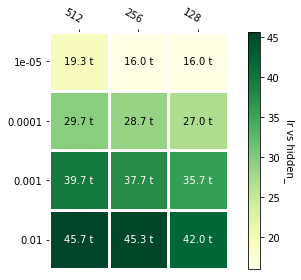

In [14]:
# Visualization accuracy vs parameters
fig, ax = plt.subplots()
lr_ = [str(lr) for lr in parameters['lr']]
hidden_ = [str(n_hidden) for n_hidden in parameters['n_hidden']]
im, cbar = heatmap(accuracy_mat, lr_, hidden_, ax=ax,
                   cmap='YlGn', cbarlabel='lr vs hidden_')
texts = annotate_heatmap(im, valfmt='{x:.1f} t')
fig.tight_layout()
plt.show()

In [15]:
# Best Parameters from above heat map
print('Best Learning Rate {0:.2f}'.format(best_lr))
print('Best Hidden Units {0}'.format(best_n_hidden))

Best Learning Rate 0.01
Best Hidden Units 512


# Train with best parameters

In [16]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,  shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)
bestmodeleval.train(trainloader, testloader, validation=False)
accuracy_test = bestmodeleval.test(testloader)

Epoch-1
-----------------
Iter-1, training loss1.61
Iter-2, training loss1.56
Iter-3, training loss1.44
Iter-4, training loss1.55
Iter-5, training loss1.54
Iter-6, training loss1.37
Iter-7, training loss1.29
Iter-8, training loss1.52
Iter-9, training loss1.39
Iter-10, training loss1.70
Iter-11, training loss1.45
Iter-12, training loss1.45
Iter-13, training loss1.37
Iter-14, training loss1.43
Iter-15, training loss1.31
Iter-16, training loss1.50
Iter-17, training loss1.35
Iter-18, training loss1.52
Iter-19, training loss1.46
Iter-20, training loss1.46
Iter-21, training loss1.60
Iter-22, training loss1.56
Iter-23, training loss1.36
Iter-24, training loss1.61
Iter-25, training loss1.47
Iter-26, training loss1.46
Iter-27, training loss1.38
Iter-28, training loss1.55
Iter-29, training loss1.52
Iter-30, training loss1.40
Iter-31, training loss1.45
Iter-32, training loss1.64
Iter-33, training loss1.40
Iter-34, training loss1.39
Iter-35, training loss1.58
Iter-36, training loss1.56
Iter-37, tr

Iter-298, training loss1.76
Iter-299, training loss1.59
Iter-300, training loss1.57
Iter-301, training loss1.57
Iter-302, training loss1.45
Iter-303, training loss1.54
Iter-304, training loss1.40
Iter-305, training loss1.45
Iter-306, training loss1.54
Iter-307, training loss1.61
Iter-308, training loss1.46
Iter-309, training loss1.40
Iter-310, training loss1.41
Iter-311, training loss1.52
Iter-312, training loss1.50
Iter-313, training loss1.35
Iter-314, training loss1.47
Iter-315, training loss1.53
Iter-316, training loss1.54
Iter-317, training loss1.53
Iter-318, training loss1.50
Iter-319, training loss1.65
Iter-320, training loss1.60
Iter-321, training loss1.59
Iter-322, training loss1.34
Iter-323, training loss1.52
Iter-324, training loss1.51
Iter-325, training loss1.54
Iter-326, training loss1.36
Iter-327, training loss1.52
Iter-328, training loss1.33
Iter-329, training loss1.36
Iter-330, training loss1.56
Iter-331, training loss1.54
Iter-332, training loss1.73
Iter-333, training l

Iter-591, training loss1.53
Iter-592, training loss1.34
Iter-593, training loss1.37
Iter-594, training loss1.35
Iter-595, training loss1.49
Iter-596, training loss1.29
Iter-597, training loss1.61
Iter-598, training loss1.84
Iter-599, training loss1.53
Iter-600, training loss1.63
Iter-601, training loss1.56
Iter-602, training loss1.62
Iter-603, training loss1.45
Iter-604, training loss1.51
Iter-605, training loss1.57
Iter-606, training loss1.55
Iter-607, training loss1.60
Iter-608, training loss1.40
Iter-609, training loss1.53
Iter-610, training loss1.67
Iter-611, training loss1.44
Iter-612, training loss1.42
Iter-613, training loss1.34
Iter-614, training loss1.48
Iter-615, training loss1.42
Iter-616, training loss1.50
Iter-617, training loss1.36
Iter-618, training loss1.57
Iter-619, training loss1.39
Iter-620, training loss1.44
Iter-621, training loss1.45
Iter-622, training loss1.49
Iter-623, training loss1.48
Iter-624, training loss1.48
Iter-625, training loss1.47
Iter-626, training l

Iter-886, training loss1.26
Iter-887, training loss1.27
Iter-888, training loss1.52
Iter-889, training loss1.34
Iter-890, training loss1.44
Iter-891, training loss1.53
Iter-892, training loss1.39
Iter-893, training loss1.46
Iter-894, training loss1.74
Iter-895, training loss1.39
Iter-896, training loss1.50
Iter-897, training loss1.60
Iter-898, training loss1.46
Iter-899, training loss1.49
Iter-900, training loss1.43
Iter-901, training loss1.46
Iter-902, training loss1.44
Iter-903, training loss1.37
Iter-904, training loss1.60
Iter-905, training loss1.61
Iter-906, training loss1.53
Iter-907, training loss1.53
Iter-908, training loss1.45
Iter-909, training loss1.52
Iter-910, training loss1.52
Iter-911, training loss1.42
Iter-912, training loss1.52
Iter-913, training loss1.37
Iter-914, training loss1.51
Iter-915, training loss1.46
Iter-916, training loss1.61
Iter-917, training loss1.52
Iter-918, training loss1.41
Iter-919, training loss1.49
Iter-920, training loss1.56
Iter-921, training l

Iter-1180, training loss1.54
Iter-1181, training loss1.40
Iter-1182, training loss1.43
Iter-1183, training loss1.57
Iter-1184, training loss1.48
Iter-1185, training loss1.39
Iter-1186, training loss1.43
Iter-1187, training loss1.61
Iter-1188, training loss1.44
Iter-1189, training loss1.37
Iter-1190, training loss1.52
Iter-1191, training loss1.40
Iter-1192, training loss1.58
Iter-1193, training loss1.50
Iter-1194, training loss1.50
Iter-1195, training loss1.55
Iter-1196, training loss1.64
Iter-1197, training loss1.45
Iter-1198, training loss1.50
Iter-1199, training loss1.34
Iter-1200, training loss1.30
Iter-1201, training loss1.66
Iter-1202, training loss1.47
Iter-1203, training loss1.41
Iter-1204, training loss1.37
Iter-1205, training loss1.72
Iter-1206, training loss1.49
Iter-1207, training loss1.47
Iter-1208, training loss1.48
Iter-1209, training loss1.44
Iter-1210, training loss1.60
Iter-1211, training loss1.70
Iter-1212, training loss1.22
Iter-1213, training loss1.40
Iter-1214, tra

Iter-1469, training loss1.43
Iter-1470, training loss1.65
Iter-1471, training loss1.30
Iter-1472, training loss1.24
Iter-1473, training loss1.45
Iter-1474, training loss1.72
Iter-1475, training loss1.42
Iter-1476, training loss1.56
Iter-1477, training loss1.55
Iter-1478, training loss1.56
Iter-1479, training loss1.58
Iter-1480, training loss1.46
Iter-1481, training loss1.28
Iter-1482, training loss1.31
Iter-1483, training loss1.39
Iter-1484, training loss1.48
Iter-1485, training loss1.41
Iter-1486, training loss1.52
Iter-1487, training loss1.40
Iter-1488, training loss1.55
Iter-1489, training loss1.40
Iter-1490, training loss1.37
Iter-1491, training loss1.44
Iter-1492, training loss1.29
Iter-1493, training loss1.61
Iter-1494, training loss1.44
Iter-1495, training loss1.55
Iter-1496, training loss1.32
Iter-1497, training loss1.41
Iter-1498, training loss1.46
Iter-1499, training loss1.53
Iter-1500, training loss1.48
Epoch-4
-----------------
Iter-1501, training loss1.47
Iter-1502, traini

Iter-1754, training loss1.29
Iter-1755, training loss1.33
Iter-1756, training loss1.41
Iter-1757, training loss1.32
Iter-1758, training loss1.46
Iter-1759, training loss1.24
Iter-1760, training loss1.50
Iter-1761, training loss1.39
Iter-1762, training loss1.39
Iter-1763, training loss1.49
Iter-1764, training loss1.27
Iter-1765, training loss1.56
Iter-1766, training loss1.53
Iter-1767, training loss1.48
Iter-1768, training loss1.38
Iter-1769, training loss1.50
Iter-1770, training loss1.60
Iter-1771, training loss1.27
Iter-1772, training loss1.43
Iter-1773, training loss1.31
Iter-1774, training loss1.47
Iter-1775, training loss1.35
Iter-1776, training loss1.40
Iter-1777, training loss1.51
Iter-1778, training loss1.43
Iter-1779, training loss1.44
Iter-1780, training loss1.30
Iter-1781, training loss1.49
Iter-1782, training loss1.36
Iter-1783, training loss1.42
Iter-1784, training loss1.55
Iter-1785, training loss1.49
Iter-1786, training loss1.45
Iter-1787, training loss1.49
Iter-1788, tra

Iter-2041, training loss1.36
Iter-2042, training loss1.36
Iter-2043, training loss1.46
Iter-2044, training loss1.38
Iter-2045, training loss1.64
Iter-2046, training loss1.32
Iter-2047, training loss1.22
Iter-2048, training loss1.35
Iter-2049, training loss1.41
Iter-2050, training loss1.41
Iter-2051, training loss1.46
Iter-2052, training loss1.26
Iter-2053, training loss1.39
Iter-2054, training loss1.44
Iter-2055, training loss1.46
Iter-2056, training loss1.55
Iter-2057, training loss1.32
Iter-2058, training loss1.56
Iter-2059, training loss1.43
Iter-2060, training loss1.81
Iter-2061, training loss1.32
Iter-2062, training loss1.50
Iter-2063, training loss1.43
Iter-2064, training loss1.34
Iter-2065, training loss1.45
Iter-2066, training loss1.26
Iter-2067, training loss1.26
Iter-2068, training loss1.27
Iter-2069, training loss1.46
Iter-2070, training loss1.39
Iter-2071, training loss1.32
Iter-2072, training loss1.29
Iter-2073, training loss1.43
Iter-2074, training loss1.45
Iter-2075, tra

Iter-2332, training loss1.39
Iter-2333, training loss1.56
Iter-2334, training loss1.39
Iter-2335, training loss1.56
Iter-2336, training loss1.25
Iter-2337, training loss1.28
Iter-2338, training loss1.79
Iter-2339, training loss1.29
Iter-2340, training loss1.55
Iter-2341, training loss1.59
Iter-2342, training loss1.47
Iter-2343, training loss1.61
Iter-2344, training loss1.44
Iter-2345, training loss1.34
Iter-2346, training loss1.41
Iter-2347, training loss1.33
Iter-2348, training loss1.26
Iter-2349, training loss1.36
Iter-2350, training loss1.24
Iter-2351, training loss1.33
Iter-2352, training loss1.52
Iter-2353, training loss1.51
Iter-2354, training loss1.26
Iter-2355, training loss1.25
Iter-2356, training loss1.39
Iter-2357, training loss1.56
Iter-2358, training loss1.63
Iter-2359, training loss1.49
Iter-2360, training loss1.20
Iter-2361, training loss1.47
Iter-2362, training loss1.35
Iter-2363, training loss1.40
Iter-2364, training loss1.40
Iter-2365, training loss1.35
Iter-2366, tra

Iter-2617, training loss1.44
Iter-2618, training loss1.40
Iter-2619, training loss1.32
Iter-2620, training loss1.36
Iter-2621, training loss1.52
Iter-2622, training loss1.40
Iter-2623, training loss1.43
Iter-2624, training loss1.46
Iter-2625, training loss1.30
Iter-2626, training loss1.58
Iter-2627, training loss1.27
Iter-2628, training loss1.35
Iter-2629, training loss1.34
Iter-2630, training loss1.30
Iter-2631, training loss1.59
Iter-2632, training loss1.32
Iter-2633, training loss1.48
Iter-2634, training loss1.41
Iter-2635, training loss1.52
Iter-2636, training loss1.32
Iter-2637, training loss1.35
Iter-2638, training loss1.11
Iter-2639, training loss1.43
Iter-2640, training loss1.40
Iter-2641, training loss1.52
Iter-2642, training loss1.37
Iter-2643, training loss1.57
Iter-2644, training loss1.31
Iter-2645, training loss1.26
Iter-2646, training loss1.15
Iter-2647, training loss1.43
Iter-2648, training loss1.21
Iter-2649, training loss1.42
Iter-2650, training loss1.40
Iter-2651, tra

Iter-2905, training loss1.42
Iter-2906, training loss1.30
Iter-2907, training loss1.42
Iter-2908, training loss1.29
Iter-2909, training loss1.44
Iter-2910, training loss1.50
Iter-2911, training loss1.39
Iter-2912, training loss1.27
Iter-2913, training loss1.26
Iter-2914, training loss1.44
Iter-2915, training loss1.39
Iter-2916, training loss1.52
Iter-2917, training loss1.49
Iter-2918, training loss1.41
Iter-2919, training loss1.31
Iter-2920, training loss1.37
Iter-2921, training loss1.31
Iter-2922, training loss1.41
Iter-2923, training loss1.47
Iter-2924, training loss1.40
Iter-2925, training loss1.47
Iter-2926, training loss1.33
Iter-2927, training loss1.41
Iter-2928, training loss1.44
Iter-2929, training loss1.36
Iter-2930, training loss1.28
Iter-2931, training loss1.40
Iter-2932, training loss1.24
Iter-2933, training loss1.34
Iter-2934, training loss1.57
Iter-2935, training loss1.31
Iter-2936, training loss1.23
Iter-2937, training loss1.38
Iter-2938, training loss1.27
Iter-2939, tra

Iter-3191, training loss1.21
Iter-3192, training loss1.31
Iter-3193, training loss1.31
Iter-3194, training loss1.35
Iter-3195, training loss1.38
Iter-3196, training loss1.31
Iter-3197, training loss1.48
Iter-3198, training loss1.29
Iter-3199, training loss1.28
Iter-3200, training loss1.33
Iter-3201, training loss1.37
Iter-3202, training loss1.38
Iter-3203, training loss1.28
Iter-3204, training loss1.26
Iter-3205, training loss1.32
Iter-3206, training loss1.36
Iter-3207, training loss1.35
Iter-3208, training loss1.19
Iter-3209, training loss1.30
Iter-3210, training loss1.36
Iter-3211, training loss1.42
Iter-3212, training loss1.36
Iter-3213, training loss1.21
Iter-3214, training loss1.50
Iter-3215, training loss1.42
Iter-3216, training loss1.41
Iter-3217, training loss1.50
Iter-3218, training loss1.42
Iter-3219, training loss1.31
Iter-3220, training loss1.48
Iter-3221, training loss1.28
Iter-3222, training loss1.28
Iter-3223, training loss1.50
Iter-3224, training loss1.24
Iter-3225, tra

Iter-3477, training loss1.47
Iter-3478, training loss1.45
Iter-3479, training loss1.38
Iter-3480, training loss1.40
Iter-3481, training loss1.33
Iter-3482, training loss1.35
Iter-3483, training loss1.33
Iter-3484, training loss1.41
Iter-3485, training loss1.22
Iter-3486, training loss1.43
Iter-3487, training loss1.65
Iter-3488, training loss1.37
Iter-3489, training loss1.39
Iter-3490, training loss1.28
Iter-3491, training loss1.33
Iter-3492, training loss1.31
Iter-3493, training loss1.49
Iter-3494, training loss1.67
Iter-3495, training loss1.31
Iter-3496, training loss1.40
Iter-3497, training loss1.42
Iter-3498, training loss1.44
Iter-3499, training loss1.33
Iter-3500, training loss1.51
Epoch-8
-----------------
Iter-3501, training loss1.38
Iter-3502, training loss1.35
Iter-3503, training loss1.37
Iter-3504, training loss1.52
Iter-3505, training loss1.44
Iter-3506, training loss1.23
Iter-3507, training loss1.35
Iter-3508, training loss1.25
Iter-3509, training loss1.34
Iter-3510, traini

Iter-3765, training loss1.45
Iter-3766, training loss1.17
Iter-3767, training loss1.15
Iter-3768, training loss1.42
Iter-3769, training loss1.68
Iter-3770, training loss1.17
Iter-3771, training loss1.03
Iter-3772, training loss1.50
Iter-3773, training loss1.40
Iter-3774, training loss1.42
Iter-3775, training loss1.42
Iter-3776, training loss1.36
Iter-3777, training loss1.32
Iter-3778, training loss1.42
Iter-3779, training loss1.35
Iter-3780, training loss1.29
Iter-3781, training loss1.34
Iter-3782, training loss1.49
Iter-3783, training loss1.41
Iter-3784, training loss1.39
Iter-3785, training loss1.18
Iter-3786, training loss1.52
Iter-3787, training loss1.46
Iter-3788, training loss1.23
Iter-3789, training loss1.31
Iter-3790, training loss1.51
Iter-3791, training loss1.30
Iter-3792, training loss1.50
Iter-3793, training loss1.34
Iter-3794, training loss1.35
Iter-3795, training loss1.23
Iter-3796, training loss1.31
Iter-3797, training loss1.41
Iter-3798, training loss1.32
Iter-3799, tra

Iter-4050, training loss1.45
Iter-4051, training loss1.29
Iter-4052, training loss1.31
Iter-4053, training loss1.43
Iter-4054, training loss1.26
Iter-4055, training loss1.17
Iter-4056, training loss1.25
Iter-4057, training loss1.30
Iter-4058, training loss1.34
Iter-4059, training loss1.19
Iter-4060, training loss1.26
Iter-4061, training loss1.47
Iter-4062, training loss1.46
Iter-4063, training loss1.34
Iter-4064, training loss1.31
Iter-4065, training loss1.43
Iter-4066, training loss1.40
Iter-4067, training loss1.41
Iter-4068, training loss1.13
Iter-4069, training loss1.39
Iter-4070, training loss1.35
Iter-4071, training loss1.27
Iter-4072, training loss1.41
Iter-4073, training loss1.27
Iter-4074, training loss1.38
Iter-4075, training loss1.34
Iter-4076, training loss1.33
Iter-4077, training loss1.23
Iter-4078, training loss1.38
Iter-4079, training loss1.11
Iter-4080, training loss1.39
Iter-4081, training loss1.42
Iter-4082, training loss1.46
Iter-4083, training loss1.44
Iter-4084, tra

Iter-4333, training loss1.41
Iter-4334, training loss1.24
Iter-4335, training loss1.35
Iter-4336, training loss1.24
Iter-4337, training loss1.29
Iter-4338, training loss1.37
Iter-4339, training loss1.44
Iter-4340, training loss1.49
Iter-4341, training loss1.42
Iter-4342, training loss1.45
Iter-4343, training loss1.44
Iter-4344, training loss1.15
Iter-4345, training loss1.38
Iter-4346, training loss1.31
Iter-4347, training loss1.45
Iter-4348, training loss1.15
Iter-4349, training loss1.38
Iter-4350, training loss1.19
Iter-4351, training loss1.46
Iter-4352, training loss1.40
Iter-4353, training loss1.57
Iter-4354, training loss1.30
Iter-4355, training loss1.38
Iter-4356, training loss1.15
Iter-4357, training loss1.37
Iter-4358, training loss1.33
Iter-4359, training loss1.23
Iter-4360, training loss1.29
Iter-4361, training loss1.06
Iter-4362, training loss1.26
Iter-4363, training loss1.29
Iter-4364, training loss1.35
Iter-4365, training loss1.47
Iter-4366, training loss1.41
Iter-4367, tra

Iter-4617, training loss1.21
Iter-4618, training loss1.34
Iter-4619, training loss1.56
Iter-4620, training loss1.30
Iter-4621, training loss1.26
Iter-4622, training loss1.38
Iter-4623, training loss1.19
Iter-4624, training loss1.16
Iter-4625, training loss1.46
Iter-4626, training loss1.31
Iter-4627, training loss1.56
Iter-4628, training loss1.30
Iter-4629, training loss1.42
Iter-4630, training loss1.41
Iter-4631, training loss1.34
Iter-4632, training loss1.36
Iter-4633, training loss1.43
Iter-4634, training loss1.28
Iter-4635, training loss1.19
Iter-4636, training loss1.53
Iter-4637, training loss1.35
Iter-4638, training loss1.35
Iter-4639, training loss1.42
Iter-4640, training loss1.34
Iter-4641, training loss1.45
Iter-4642, training loss1.26
Iter-4643, training loss1.25
Iter-4644, training loss1.32
Iter-4645, training loss1.41
Iter-4646, training loss1.34
Iter-4647, training loss1.35
Iter-4648, training loss1.45
Iter-4649, training loss1.27
Iter-4650, training loss1.37
Iter-4651, tra

Iter-4902, training loss1.29
Iter-4903, training loss1.47
Iter-4904, training loss1.47
Iter-4905, training loss1.44
Iter-4906, training loss1.22
Iter-4907, training loss1.27
Iter-4908, training loss1.53
Iter-4909, training loss1.30
Iter-4910, training loss1.31
Iter-4911, training loss1.32
Iter-4912, training loss1.37
Iter-4913, training loss1.39
Iter-4914, training loss1.45
Iter-4915, training loss1.35
Iter-4916, training loss1.22
Iter-4917, training loss1.26
Iter-4918, training loss1.26
Iter-4919, training loss1.34
Iter-4920, training loss1.40
Iter-4921, training loss1.32
Iter-4922, training loss1.25
Iter-4923, training loss1.63
Iter-4924, training loss1.47
Iter-4925, training loss1.16
Iter-4926, training loss1.22
Iter-4927, training loss1.38
Iter-4928, training loss1.32
Iter-4929, training loss1.37
Iter-4930, training loss1.32
Iter-4931, training loss1.51
Iter-4932, training loss1.43
Iter-4933, training loss1.37
Iter-4934, training loss1.28
Iter-4935, training loss1.29
Iter-4936, tra

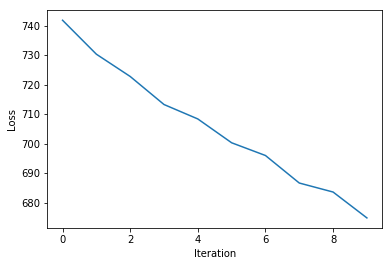

Accuracy of best model on test set with lr= 0.01, hidden units= 512.00, is 48.00


In [17]:
bestmodeleval.plot_loss()
print('Accuracy of best model on test set with lr= {0:.2f}, hidden units= {1:.2f}, is {2:.2f}'.format(best_lr, best_n_hidden, accuracy_test))